# AP-1 Figures

In [1]:
### header ###
__author__ = "Jenhan Tao"
__license__ = "BSD"
__email__ = "jenhantao@gmail.com"

### imports ###
import sys
import os
import pandas as pd
import numpy as np
import argparse
import matplotlib
import itertools
import scipy
import matplotlib.pyplot as plt 
import seaborn as sns
import scipy
import pickle
from sklearn import preprocessing
import sklearn
from sklearn import decomposition
from sklearn.cluster import KMeans
from sklearn import svm, datasets
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc
from sklearn import ensemble
from sklearn import neighbors
import matplotlib_venn
from sklearn.cross_validation import train_test_split
from random import shuffle
from collections import Counter
import time
import ete3
from scipy import ndimage
### notebook specific configuration ###
%matplotlib inline
matplotlib.pylab.rcParams['savefig.dpi'] = 200
sys.setrecursionlimit(5000)
os.chdir('/gpfs/data01/glasslab/home/jtao/analysis/cobinding_motif_analysis/')
sns.set_context('notebook')
%load_ext autoreload
%autoreload 2


## Functions

In [2]:
def quantile_normalize(vals1, vals2):
    '''
    input: two scalar arrays
    output: two quantile normalized scalar arrays
    '''
    vals1 = np.array(vals1)
    vals2 = np.array(vals2)
    
    ranks_1 = scipy.stats.rankdata(vals1, method = 'ordinal')
    ranks_2 = scipy.stats.rankdata(vals2, method = 'ordinal')
    
    sorted_vals_1 = sorted(vals1)
    sorted_vals_2 = sorted(vals2)
    means = np.mean([sorted_vals_1,sorted_vals_2], axis=0)
    
    rank_mean_dict = dict(zip(sorted(ranks_1), sorted(means)))
    normalized_vals_1 = np.array([rank_mean_dict[x] for x in ranks_1])
    normalized_vals_2 = np.array([rank_mean_dict[x] for x in ranks_2])
    return normalized_vals_1, normalized_vals_2

In [3]:
# split data into GC content matched training and test data
def get_split(features, labels, test_size):
    '''
    feature: 2D array (samples x features)
    labels: 1D boolean array (samples x)
    test_size: fraction of data to test on
    '''
    
    ### match GC content of samples labelled True with those labelled False by thowing out False samples
    # retrieve sequences using index of labels
    index_label_tuples = tuple(zip(labels.index.values, labels.values))
    
    true_ids = [x[0] for x in index_label_tuples if x[1]]
    
    false_ids = [x[0] for x in index_label_tuples if not x[1]]
       
    filtered_ids = true_ids + false_ids
    filtered_features = features[features.index.isin(filtered_ids)]
    filtered_labels = labels[labels.index.isin(filtered_ids)]

    if test_size <= 0.5:
        training_indices, test_indices = next(iter(
                sklearn.cross_validation.StratifiedKFold(filtered_labels, int(1/test_size), shuffle=True)))
    else:
        test_indices, training_indices = next(
            iter(sklearn.cross_validation.StratifiedKFold(filtered_labels, int(1/(1-test_size)), shuffle=True)))
    training_ids = [filtered_ids[i] for i in training_indices]
    test_ids = [filtered_ids[i] for i in test_indices]
    
    training_features = filtered_features[filtered_features.index.isin(training_ids)]
    test_features = filtered_features[filtered_features.index.isin(test_ids)]
    training_labels = filtered_labels[filtered_labels.index.isin(training_ids)]
    test_labels = filtered_labels[filtered_labels.index.isin(test_ids)]
    
    return training_features, test_features, training_labels, test_labels
    

In [4]:
def train_classifier(features,
                     labels,
                     numIterations=5,
                     test_size=0.5):
    all_rocs = []
    all_precisions = []
    all_coefficients = []
    all_scores = []
    all_testLabels = []

    for i in range(numIterations):  

        # split data into training and test sets
        training_features, test_features, training_labels, test_labels = get_split(
            features, labels, test_size = test_size)

        #  Train classifier
        classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1)

        classifier.fit(training_features, training_labels)
        # score predictions
        probas = classifier.predict_proba(test_features)
        current_roc = sklearn.metrics.roc_auc_score(test_labels, 
                                                              probas[:, 1], 
                                                              average = None)
        current_precision = sklearn.metrics.average_precision_score(test_labels, 
                                                                             probas[:, 1], 
                                                                             average = None)

         # retrieve coefficients
        current_coefficients = classifier.coef_.flatten()
        
        all_rocs.append(current_roc)
        all_precisions.append(current_precision)
        all_coefficients.append(current_coefficients)
        all_scores.append(probas)
        all_testLabels.append(test_labels)
        
    results = (all_rocs, 
               all_precisions, 
               all_coefficients,
               all_scores,
               all_testLabels)
    return results
    

In [28]:
def calculate_mean_weights(weights_dict, 
                           sorted_motif_names):
    '''
    '''
    
    factor_coeff_dict = {}

    # calculates the mean of each of the weights
    for factor_treatment in weights_dict.keys():
        current_weights = weights_dict[factor_treatment]
        mean_weights = np.mean(current_weights, axis=0)
        
        factor_coeff_dict[factor_treatment] = mean_weights
    coeff_frame = pd.DataFrame(factor_coeff_dict)
    coeff_frame.index = sorted_motif_names
        
    return coeff_frame

## Copy Score Files

In [1642]:
%%bash 
# copy C57 files
cp /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis_features/peak_sequences/C57BL6J.fa ./
cp /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis_features/group_summary.tsv ./
cp /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis_features/motif_score_frame_C57BL6J.pickle ./  
cp /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis_features/motif_start_frame_C57BL6J.pickle ./
cp /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis_features/motif_end_frame_C57BL6J.pickle ./
cp /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis_features/motif_sequence_frame_C57BL6J.pickle ./
cp /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis_features/motif_strand_frame_C57BL6J.pickle ./

In [1643]:
%%bash 
# copy BAL files
cp /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis_features/peak_sequences/BALBCJ.fa ./
cp /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis_features/motif_score_frame_BALBCJ.pickle ./  
cp /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis_features/motif_start_frame_BALBCJ.pickle ./
cp /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis_features/motif_end_frame_BALBCJ.pickle ./
cp /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis_features/motif_sequence_frame_BALBCJ.pickle ./
cp /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis_features/motif_strand_frame_BALBCJ.pickle ./

In [289]:
%%bash
# random background files for c57
cp /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis_background_features/background_group_summary.tsv ./
cp /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis_background_features/motif_score_background_frame_C57BL6J.pickle ./  
cp /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis_background_features/motif_start_background_frame_C57BL6J.pickle ./
cp /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis_background_features/motif_end_background_frame_C57BL6J.pickle ./
cp /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis_background_features/motif_sequence_background_frame_C57BL6J.pickle ./
cp /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis_background_features/motif_strand_background_frame_C57BL6J.pickle ./
cp /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis_background_features/C57BL6J_background.fa ./

In [283]:
# %%bash
# # random background files for balbc
# cp /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis_background_features/background_group_summary.tsv ./
# cp /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis_background_features/motif_score_background_frame_BALBCJ.pickle ./  
# cp /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis_background_features/motif_start_background_frame_BALBCJ.pickle ./
# cp /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis_background_features/motif_end_background_frame_BALBCJ.pickle ./
# cp /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis_background_features/motif_sequence_background_frame_BALBCJ.pickle ./
# cp /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis_background_features/motif_strand_background_frame_BALBCJ.pickle ./
# cp /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis_background_features/BALBCJ_background.fa ./

In [64]:
%%bash
# score files for unclustered motifs
cp /gpfs/data01/glasslab/home/jtao/analysis//ap1_analysis_unclustered_features/motif_score_unclustered_frame_C57BL6J.pickle ./
cp /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis_unclustered_features/motif_score_unclustered_frame_C57BL6J-background.pickle ./

## Copy Peak Files

In [1693]:
%%bash 
rm ./peak_files/*
cp /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis_features/peak_files/* ./peak_files/

rm ./peak_files_validation/*
cp /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis_features/peak_files_validation/* ./peak_files_validation/

cp /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis_features/merged_peaks_filtered_resized.tsv ./


## Read in Score Files

In [5]:
summary_frame = pd.read_csv('./group_summary.tsv' , sep='\t')
summary_frame = summary_frame.fillna('0')
for col in summary_frame.columns[5:]:
    floatValues = []
    for val in summary_frame[col].values.astype(str):
        if ',' in val:
            maxVal = np.mean([float(x) for x in val.split(',')])
            floatValues.append(maxVal)
        else:
            floatValues.append(float(val))
    summary_frame[col] = floatValues
summary_frame.index = summary_frame['ID'].values

# remove peaks in unknown/random chromosomes
summary_frame = summary_frame[~summary_frame['chr'].str.contains('random')]
summary_frame = summary_frame[~summary_frame['chr'].str.contains('Un')]

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (6,7,8,12,15,19,21,22,23,24,25,26,27,29,31,32,34,37,38,44,52) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
summary_background_frame = pd.read_csv('./background_group_summary.tsv' , sep='\t')
summary_background_frame = summary_background_frame.fillna('0')
for col in summary_background_frame.columns[5:]:
    floatValues = []
    for val in summary_background_frame[col].values.astype(str):
        if ',' in val:
            maxVal = np.mean([float(x) for x in val.split(',')])
            floatValues.append(maxVal)
        else:
            floatValues.append(float(val))
    summary_background_frame[col] = floatValues
summary_background_frame.index = summary_background_frame['ID'].values

# remove peaks in unknown/random chromosomes
summary_background_frame = summary_background_frame[~summary_background_frame['chr'].str.contains('random')]
summary_background_frame = summary_background_frame[~summary_background_frame['chr'].str.contains('Un')]

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (5,6,9,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
ap1_members=['atf3', 'cjun', 'fos','fra2', 'junb', 'jund']
contains_ap1 = summary_frame[['c57bl6_'+x+'_veh' for x in ap1_members]].sum(axis=1)>0
contains_ap1_tuples = tuple(zip(contains_ap1.index.values, contains_ap1.values, summary_frame['Factors'].values))
summary_frame['Factors'] = [x[2] + ',c57bl6_ap-1_veh' if x[1] == True else x[2] for x in contains_ap1_tuples]

contains_ap1 = summary_frame[['c57bl6_'+x+'_kla' for x in ap1_members]].sum(axis=1)>0
contains_ap1_tuples = tuple(zip(contains_ap1.index.values, contains_ap1.values, summary_frame['Factors'].values))
summary_frame['Factors'] = [x[2] + ',c57bl6_ap-1_kla' if x[1] == True else x[2] for x in contains_ap1_tuples]

In [8]:
motif_score_frame = pd.read_pickle('motif_score_frame_C57BL6J.pickle')
motif_sequence_frame = pd.read_pickle('motif_sequence_frame_C57BL6J.pickle')
motif_strand_frame = pd.read_pickle('motif_strand_frame_C57BL6J.pickle')
motif_start_frame = pd.read_pickle('motif_start_frame_C57BL6J.pickle')
motif_end_frame = pd.read_pickle('motif_end_frame_C57BL6J.pickle')

   

In [9]:
motif_score_balbc_frame = pd.read_pickle('motif_score_frame_BALBCJ.pickle')
motif_sequence_balbc_frame = pd.read_pickle('motif_sequence_frame_BALBCJ.pickle')
motif_strand_balbc_frame = pd.read_pickle('motif_strand_frame_BALBCJ.pickle')
motif_start_balbc_frame = pd.read_pickle('motif_start_frame_BALBCJ.pickle')
motif_end_balbc_frame = pd.read_pickle('motif_end_frame_BALBCJ.pickle')

In [10]:
motif_score_background_frame = pd.read_pickle('motif_score_background_frame_C57BL6J.pickle')
motif_sequence_background_frame = pd.read_pickle('motif_sequence_background_frame_C57BL6J.pickle')
motif_strand_background_frame = pd.read_pickle('motif_strand_background_frame_C57BL6J.pickle')
motif_start_background_frame = pd.read_pickle('motif_start_background_frame_C57BL6J.pickle')
motif_end_background_frame = pd.read_pickle('motif_end_background_frame_C57BL6J.pickle')
# make sure background frames don't have IDs that overlap with target frame
motif_score_background_frame = motif_score_background_frame[~motif_score_background_frame.index.isin(motif_score_frame.index.values)]
motif_sequence_background_frame = motif_sequence_background_frame[~motif_sequence_background_frame.index.isin(motif_score_frame.index.values)]
motif_strand_background_frame = motif_strand_background_frame[~motif_strand_background_frame.index.isin(motif_score_frame.index.values)]
motif_start_background_frame = motif_start_background_frame[~motif_start_background_frame.index.isin(motif_score_frame.index.values)]
motif_end_background_frame = motif_end_background_frame[~motif_end_background_frame.index.isin(motif_score_frame.index.values)]

In [11]:
# motif_score_background_balbc_frame = pd.read_pickle('motif_score_background_frame_BALBCJ.pickle')
# motif_sequence_background_balbc_frame = pd.read_pickle('motif_sequence_background_frame_BALBCJ.pickle')
# motif_strand_background_balbc_frame = pd.read_pickle('motif_strand_background_frame_BALBCJ.pickle')
# motif_start_background_balbc_frame = pd.read_pickle('motif_start_background_frame_BALBCJ.pickle')
# motif_end_background_balbc_frame = pd.read_pickle('motif_end_background_frame_BALBCJ.pickle')
# # make sure background frames don't have IDs that overlap with target frame
# motif_score_background_balbc_frame = motif_score_background_balbc_frame[~motif_score_background_balbc_frame.index.isin(motif_score_balbc_frame.index.values)]
# motif_sequence_background_balbc_frame = motif_sequence_background_balbc_frame[~motif_sequence_background_balbc_frame.index.isin(motif_score_balbc_frame.index.values)]
# motif_strand_background_balbc_frame = motif_strand_background_balbc_frame[~motif_strand_background_balbc_frame.index.isin(motif_score_balbc_frame.index.values)]
# motif_start_background_balbc_frame = motif_start_background_balbc_frame[~motif_start_background_balbc_frame.index.isin(motif_score_balbc_frame.index.values)]
# motif_end_background_balbc_frame = motif_end_background_balbc_frame[~motif_end_background_balbc_frame.index.isin(motif_score_balbc_frame.index.values)]

In [12]:
motif_score_unclustered_frame = pd.read_pickle('motif_score_unclustered_frame_C57BL6J.pickle')
motif_score_background_unclustered_frame = pd.read_pickle('motif_score_unclustered_frame_C57BL6J-background.pickle')
motif_score_background_unclustered_frame = motif_score_background_unclustered_frame[
    ~motif_score_background_unclustered_frame.index.isin(motif_score_unclustered_frame.index.values)]

# unclustered motifs
columns = list(motif_score_unclustered_frame.columns.values)
columns.remove('ID')
columns.remove('chr')
columns.remove('Factors')
motifs = columns
sorted_columns = ['ID', 'chr' , 'Factors'] + sorted(motifs)
motif_score_unclustered_frame = motif_score_unclustered_frame[sorted_columns]
motif_score_background_unclustered_frame = motif_score_background_unclustered_frame[sorted_columns]


In [13]:
# rearrange columns
columns = list(motif_score_frame.columns.values)
columns.remove('ID')
columns.remove('chr')
columns.remove('Factors')
motifs = columns
sorted_columns = ['ID', 'chr' , 'Factors'] + sorted(motifs)

motif_score_frame = motif_score_frame[sorted_columns]
motif_sequence_frame = motif_sequence_frame[sorted_columns]
motif_strand_frame = motif_strand_frame[sorted_columns]
motif_start_frame = motif_start_frame[sorted_columns]
motif_end_frame = motif_end_frame[sorted_columns]

motif_score_background_frame = motif_score_background_frame[sorted_columns]
motif_sequence_background_frame = motif_sequence_background_frame[sorted_columns]
motif_strand_background_frame = motif_strand_background_frame[sorted_columns]
motif_start_background_frame = motif_start_background_frame[sorted_columns]
motif_end_background_frame = motif_end_background_frame[sorted_columns]

motif_score_balbc_frame = motif_score_balbc_frame[sorted_columns]
motif_sequence_balbc_frame = motif_sequence_balbc_frame[sorted_columns]
motif_strand_balbc_frame = motif_strand_balbc_frame[sorted_columns]
motif_start_balbc_frame = motif_start_balbc_frame[sorted_columns]
motif_end_balbc_frame = motif_end_balbc_frame[sorted_columns]

# motif_score_background_balbc_frame = motif_score_background_balbc_frame[sorted_columns]
# motif_sequence_background_balbc_frame = motif_sequence_background_balbc_frame[sorted_columns]
# motif_strand_background_balbc_frame = motif_strand_background_balbc_frame[sorted_columns]
# motif_start_background_balbc_frame = motif_start_background_balbc_frame[sorted_columns]
# motif_end_background_balbc_frame = motif_end_background_balbc_frame[sorted_columns]


## Standardize motif scores

### By monomer and treatment

In [14]:
scaler = preprocessing.StandardScaler()
monomer_treatment_standardized_features_dict = {}
motifs = motif_score_frame.columns[3:]
strain = 'c57bl6'
background_ratio = 1.0
for treatment in ['veh', 'kla']:
    if treatment == 'veh':
        members = ['atf3', 'cjun', 'jund']
    else:
        members = ['atf3', 'cjun', 'fos', 'fra2', 'junb', 'jund']
    for monomer in members:   
        target_indices = summary_frame[summary_frame[strain + '_' + monomer + '_' + treatment] > 0.0].index.values
        background_indices = motif_score_background_frame[
            motif_score_background_frame['Factors'] == strain + '_' + monomer + '_' + treatment + '-background'].index.values
        # select subset of background indices to use
        shuffle(background_indices)
        background_indices = background_indices[:np.ceil(background_ratio*len(target_indices))]
        target_features = motif_score_frame.ix[motif_score_frame.index.isin(target_indices),
                                               motifs]
        background_features = motif_score_background_frame.ix[motif_score_background_frame.index.isin(background_indices),
                                                              motifs]
        bg_token = '_' + monomer + '_' + treatment + '-background'
        background_features.index = [x + bg_token for x in background_features.index.values]
        
        # merge target and background features together 
        features = pd.concat([target_features, background_features])
        
        standardized_features = pd.DataFrame(scaler.fit_transform(features))
        standardized_features.columns = features.columns.values
        standardized_features.index = features.index.values
        standardized_features = standardized_features[sorted(standardized_features.columns.values)]
        
        monomer_treatment_standardized_features_dict[monomer + '_' + treatment] = standardized_features

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:17: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


### By monomer and treatment for unclustered motifs

In [15]:
scaler = preprocessing.StandardScaler()
monomer_treatment_standardized_unclustered_features_dict = {}
motifs = motif_score_unclustered_frame.columns[3:]
strain = 'c57bl6'
background_ratio = 1.0
for treatment in ['veh', 'kla']:
    if treatment == 'veh':
        members = ['atf3', 'cjun', 'jund']
    else:
        members = ['atf3', 'cjun', 'fos', 'fra2', 'junb', 'jund']
    for monomer in members:   
        target_indices = summary_frame[summary_frame[strain + '_' + monomer + '_' + treatment] > 0.0].index.values
        background_indices = motif_score_background_unclustered_frame[
            motif_score_background_unclustered_frame['Factors'] == strain + '_' + monomer + '_' + treatment + '-background'].index.values
        # select subset of background indices to use
        shuffle(background_indices)
        background_indices = background_indices[:np.ceil(background_ratio*len(target_indices))]
        target_features = motif_score_unclustered_frame.ix[motif_score_unclustered_frame.index.isin(target_indices),
                                               motifs]
        background_features = motif_score_background_unclustered_frame.ix[motif_score_background_unclustered_frame.index.isin(background_indices),
                                                              motifs]
        bg_token = '_' + monomer + '_' + treatment + '-background'
        background_features.index = [x + bg_token for x in background_features.index.values]
        
        # merge target and background features together 
        features = pd.concat([target_features, background_features])
        
        standardized_features = pd.DataFrame(scaler.fit_transform(features))
        standardized_features.columns = features.columns.values
        standardized_features.index = features.index.values
        standardized_features = standardized_features[sorted(standardized_features.columns.values)]
        
        monomer_treatment_standardized_unclustered_features_dict[monomer + '_' + treatment] = standardized_features

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:17: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


### By dimer and treatment

In [16]:
scaler = preprocessing.StandardScaler()
dimer_standardized_features_dict = {}
motifs = motif_score_frame.columns[3:]
strain = 'c57bl6'
background_ratio = 1.0
treatment = 'kla'
members = ['atf3', 'cjun', 'fos', 'fra2', 'junb', 'jund']
for i in range(len(members) - 1):
    for j in range(i+1, len(members)):
        monomer1 = members[i]
        monomer2 = members[j]
        dimer = monomer1 + '_' + monomer2
        
        monomer1_indices = summary_frame[summary_frame[strain + '_' + monomer1 + '_' + treatment] > 0.0].index.values        
        monomer2_indices = summary_frame[summary_frame[strain + '_' + monomer2 + '_' + treatment] > 0.0].index.values
        dimer_indices = np.array(list(set(monomer1_indices).intersection(set(monomer2_indices))))
        
        
        # select subset of background indices to use
        monomer1_background_indices = motif_score_background_frame[
            motif_score_background_frame['Factors'] == strain + '_' + monomer1 + '_' + treatment + '-background'].index.values
        monomer2_background_indices = motif_score_background_frame[
            motif_score_background_frame['Factors'] == strain + '_' + monomer2 + '_' + treatment + '-background'].index.values
        
        shuffle(monomer1_background_indices)
        monomer1_background_indices = monomer1_background_indices[:len(monomer1_indices)]
        shuffle(monomer2_background_indices)
        monomer2_background_indices = monomer2_background_indices[:len(monomer2_indices)]
        background_indices = np.concatenate([monomer1_background_indices, monomer2_background_indices])
    
        
        target_features = motif_score_frame.ix[motif_score_frame.index.isin(dimer_indices),
                                               motifs]
        background_features = motif_score_background_frame.ix[motif_score_background_frame.index.isin(background_indices),
                                                              motifs]
        bg_token = '_' + dimer + '-background'
        background_features.index = [x + bg_token for x in background_features.index.values]

        # merge target and background features together 
        features = pd.concat([target_features, background_features])

        standardized_features = pd.DataFrame(scaler.fit_transform(features))
        standardized_features.columns = features.columns.values
        standardized_features.index = features.index.values
        standardized_features = standardized_features[sorted(standardized_features.columns.values)]

        dimer_standardized_features_dict[dimer] = standardized_features

### Balbc

In [17]:
scaler = preprocessing.StandardScaler()
monomer_treatment_standardized_features_balbc_dict = {}
motifs = motif_score_frame.columns[3:]
background_ratio = 1.0
strain = 'balbc'
for treatment in ['veh', 'kla']:
    if treatment == 'veh':
        members = ['atf3', 'cjun', 'jund']
    else:
        members = ['atf3', 'cjun', 'fos', 'junb', 'jund']
    for monomer in members:   
        target_indices = summary_frame[summary_frame[strain + '_' + monomer + '_' + treatment] > 0.0].index.values
        background_indices = motif_score_background_frame[
            motif_score_background_frame['Factors'] == 'c57bl6_' + monomer + '_' + treatment + '-background'].index.values
        # select subset of background indices to use
        shuffle(background_indices)
        background_indices = background_indices[:np.ceil(background_ratio*len(target_indices))]

        target_features = motif_score_frame.ix[motif_score_frame.index.isin(target_indices),
                                               motifs]
        background_features = motif_score_background_frame.ix[motif_score_background_frame.index.isin(background_indices),
                                                              motifs]
        bg_token = '_' + monomer + '_' + treatment + '-background'
        background_features.index = [x + bg_token for x in background_features.index.values]
        
        # merge target and background features together 
        features = pd.concat([target_features, background_features])
        
        standardized_features = pd.DataFrame(scaler.fit_transform(features))
        standardized_features.columns = features.columns.values
        standardized_features.index = features.index.values
        standardized_features = standardized_features[sorted(standardized_features.columns.values)]
        
        monomer_treatment_standardized_features_balbc_dict[monomer + '_' + treatment] = standardized_features

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:17: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


### By monomer

In [18]:
scaler = preprocessing.StandardScaler()
monomer_standardized_features_dict = {}
motifs = motif_score_frame.columns[3:]
background_ratio = 1.0
members = ['atf3', 'cjun', 'jund']
strain = 'c57bl6'
for monomer in members:   
    target_indices = summary_frame[(summary_frame[strain + '_' + monomer + '_veh'] > 0.0) |
                                   (summary_frame[strain + '_' + monomer + '_kla'] > 0.0)].index.values
    background_indices = motif_score_background_frame[
        (motif_score_background_frame['Factors'] == strain + '_' + monomer + '_veh-background') |
        (motif_score_background_frame['Factors'] == strain + '_' + monomer + '_kla-background')
        ].index.values
    # select subset of background indices to use
    shuffle(background_indices)
    background_indices = background_indices[:np.ceil(background_ratio*len(target_indices))]
    target_features = motif_score_frame.ix[motif_score_frame.index.isin(target_indices),
                                           motifs]
    background_features = motif_score_background_frame.ix[motif_score_background_frame.index.isin(background_indices),
                                                          motifs]
    bg_token = '_' + monomer + '-background'
    background_features.index = [x + bg_token for x in background_features.index.values]

    # merge target and background features together 
    features = pd.concat([target_features, background_features])

    standardized_features = pd.DataFrame(scaler.fit_transform(features))
    standardized_features.columns = features.columns.values
    standardized_features.index = features.index.values
    standardized_features = standardized_features[sorted(standardized_features.columns.values)]

    monomer_standardized_features_dict[monomer ] = standardized_features

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


## Concatentate Motif scores with background motif scores

In [19]:
# concatent target and background frames
columns = list(motif_score_frame.columns.values)
columns.remove('ID')
columns.remove('chr')
columns.remove('Factors')
motifs = columns
sorted_columns = ['ID', 'chr' , 'Factors'] + sorted(motifs)

all_score_frame = pd.concat([motif_score_frame, motif_score_background_frame])
all_score_frame = all_score_frame[motif_score_frame.columns.values]
all_score_frame = all_score_frame[sorted_columns]

scaler = preprocessing.StandardScaler()
all_standardized_score_frame = pd.DataFrame(scaler.fit_transform(all_score_frame.ix[:,3:]))
all_standardized_score_frame.columns = all_score_frame.columns.values[3:]
all_standardized_score_frame.index = all_score_frame.index.values
all_standardized_score_frame = all_standardized_score_frame[sorted(all_standardized_score_frame.columns.values)]

all_score_balbc_frame = pd.concat([motif_score_balbc_frame, motif_score_background_frame])
all_score_balbc_frame = all_score_balbc_frame[motif_score_balbc_frame.columns.values]
all_score_balbc_frame = all_score_balbc_frame[sorted_columns]

scaler = preprocessing.StandardScaler()
all_standardized_score_balbc_frame = pd.DataFrame(scaler.fit_transform(all_score_balbc_frame.ix[:,3:]))
all_standardized_score_balbc_frame.columns = all_score_balbc_frame.columns.values[3:]
all_standardized_score_balbc_frame.index = all_score_balbc_frame.index.values
all_standardized_score_balbc_frame = all_standardized_score_balbc_frame[sorted(all_standardized_score_balbc_frame.columns.values)]

## Read in peak sequence

In [20]:
### read in target sequences as dictionary {peakID: sequence}
with open('./C57BL6J.fa') as f:
    data = f.readlines()

_id_sequence_dict = {}
for line in data:
    if line[0] == '>':
        sequenceName = line.strip()[1:]
    else:
        _id_sequence_dict[sequenceName] = line.strip().upper()  
### read in background sequences
with open('./C57BL6J_background.fa') as f:
    data = f.readlines()

for line in data:
    if line[0] == '>':
        sequenceName = line.strip()[1:]
    else:
        _id_sequence_dict[sequenceName] = line.strip().upper()  

# Figure 1

### Expression of AP-1 monomers before and after KLA treatment

In [ ]:
%%bash
analyzeRepeats.pl rna mm10 -count exons -condenseGenes -rpkm -d  ~/analysis/ap1_analysis/tag_directories_rna/*Veh*UT*CR*/ ~/analysis/ap1_analysis/tag_directories_rna/*Veh*UT*VML*/ ~/analysis/ap1_analysis/tag_directories_rna/*KLA-1h*UT*/> rpkm_untreated.tsv

# python ~/code/seq_merge_pipe/run_idr_homerRNA.py rpkm_untreated.tsv ./rna_idr_untreated KLA KLA Veh Veh

In [218]:
# read in rpkm values
rpkm_frame = pd.read_csv('./rpkm_untreated.tsv', sep='\t')

rpkm_frame.index = [x.split('|')[0].upper() for x in rpkm_frame['Annotation/Divergence']]
rpkm_frame = rpkm_frame.ix[:,8:]
rpkm_frame.columns = [x.split('/')[-2].split('_')[3] for x in rpkm_frame.columns.values]

# rotate frame for plotting
rpkm_plotting_frame = pd.DataFrame(rpkm_frame.stack(), 
                                   columns=['RPKM'])
rpkm_plotting_frame['Gene'] = [x[0] for x in rpkm_plotting_frame.index.values]
rpkm_plotting_frame['Treatment'] = [x[1] for x in rpkm_plotting_frame.index.values]
rpkm_plotting_frame['Log2 RPKM'] = np.log2(rpkm_plotting_frame['RPKM'].values + 1)

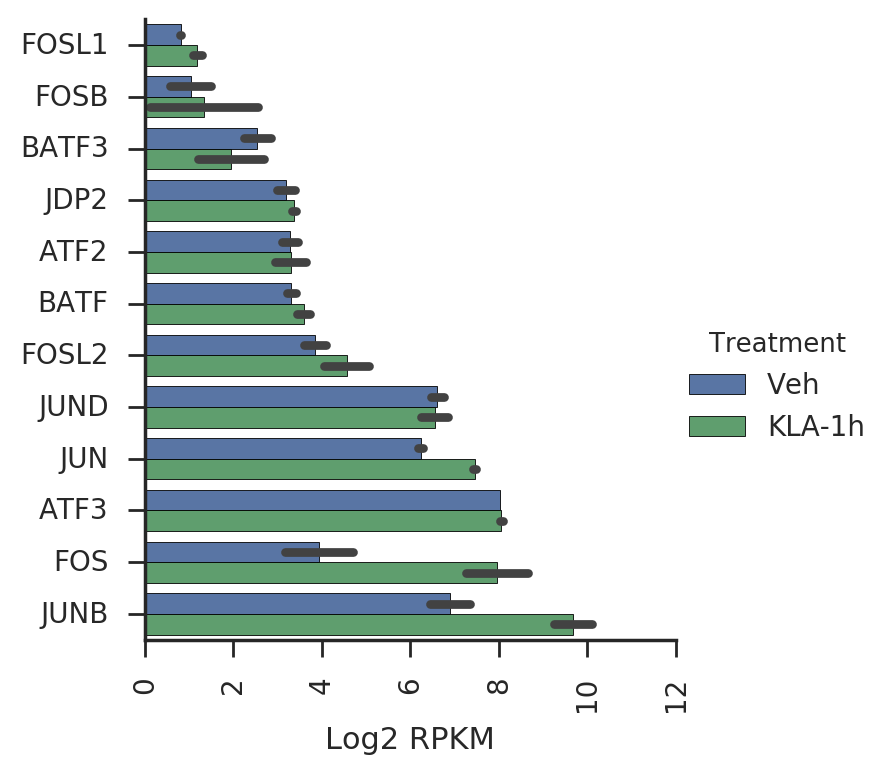

In [91]:
# from AP-1 as a regulator of cell life and death
# Jun (c-Jun, JunB, JunD), 
# Fos (c-Fos, FosB, Fra-1 and Fra2), 
# Maf (c-Maf, MafB, MafA, MafG/F/K and Nrl) and 
# ATF (ATF2, LRF1/ATF3, B-ATF, JDP1, JDP2) 
# BATF3 and JDP1 are the same thing
gene_list = ['JUN' , 'JUNB', 'JUND',
             'FOS', 'FOSL1', 'FOSL2', 'FOSB',
#              'MAF', 'MAFA','MAFB','MAFG', 'MAFF', 'MAFK', 'NRL',
             'ATF2', 'ATF3','BATF','JDP2','BATF3'#'JDP1'
             ]

plotting_frame = rpkm_plotting_frame[rpkm_plotting_frame['Gene'].isin(gene_list)]
gene_list_tuples = []
for gene in set(plotting_frame['Gene'].values):
    vals = plotting_frame[plotting_frame['Gene']==gene]['Log2 RPKM'].values
    gene_list_tuples.append((gene, np.max(vals)))
gene_list_tuples.sort(key=lambda x:x[1])
ordered_genes = [x[0] for x in gene_list_tuples]
with sns.axes_style('ticks'):
    sns.factorplot(data = plotting_frame, 
                   x='Log2 RPKM', 
                   y='Gene', 
                   hue='Treatment', 
                   kind='bar', 
                   order = ordered_genes,
                   hue_order=['Veh','KLA-1h'], 
                   ci=100,
                  size=4)
#     plt.xlabel('AP-1 Monomer')
    plt.ylabel('')

plt.xticks(rotation=90)
plt.savefig('./figures/figure_01_ap1_expression.svg', bbox_inches='tight')

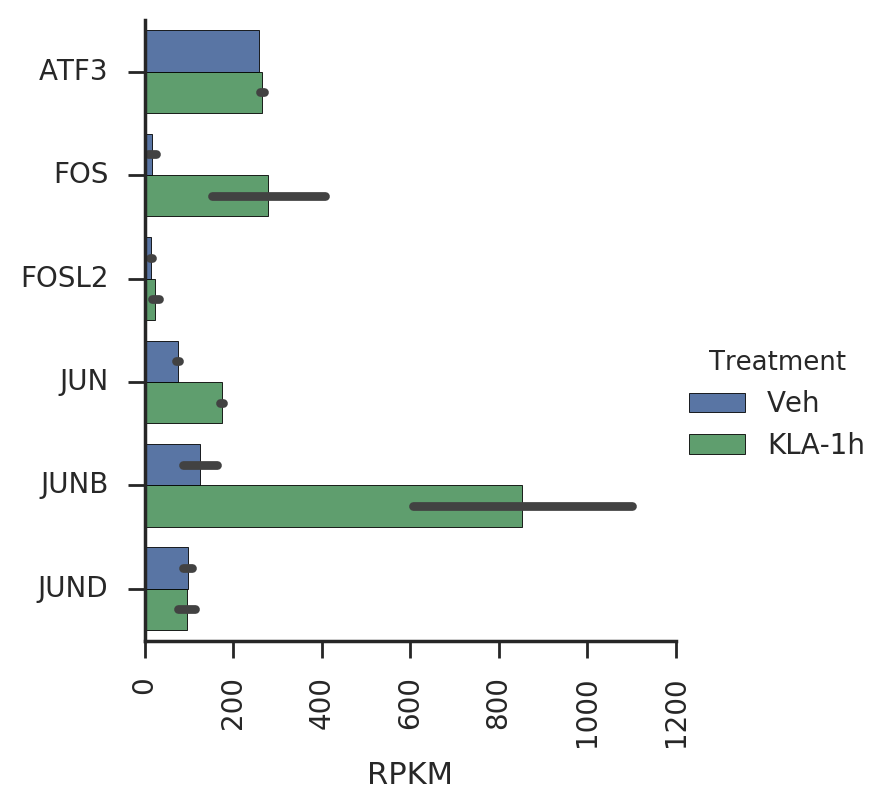

In [92]:
# from AP-1 as a regulator of cell life and death
# Jun (c-Jun, JunB, JunD), 
# Fos (c-Fos, FosB, Fra-1 and Fra2), 
# Maf (c-Maf, MafB, MafA, MafG/F/K and Nrl) and 
# ATF (ATF2, LRF1/ATF3, B-ATF, JDP1, JDP2) 
# BATF3 and JDP1 are the same thing
gene_list = ['JUN' , 'JUNB', 'JUND',
             'FOS', 'FOSL1', 'FOSL2', 'FOSB',
#              'MAF', 'MAFA','MAFB','MAFG', 'MAFF', 'MAFK', 'NRL',
             'ATF2', 'ATF3','BATF','JDP2','BATF3'#'JDP1'
             ]
gene_list = ['ATF3', 'FOS', 'FOSL2',
             'JUN' , 'JUNB', 'JUND']
plotting_frame = rpkm_plotting_frame[rpkm_plotting_frame['Gene'].isin(gene_list)]
gene_list_tuples = []
for gene in set(plotting_frame['Gene'].values):
    vals = plotting_frame[plotting_frame['Gene']==gene]['Log2 RPKM'].values
    gene_list_tuples.append((gene, np.max(vals)))
gene_list_tuples.sort(key=lambda x:x[1])
ordered_genes = [x[0] for x in gene_list_tuples]
with sns.axes_style('ticks'):
    sns.factorplot(data = plotting_frame, 
                   x='RPKM', 
                   y='Gene', 
                   hue='Treatment', 
                   kind='bar', 
                   order = gene_list,
                   hue_order=['Veh','KLA-1h'], 
                   ci=100,
                  size=4)
#     plt.xlabel('AP-1 Monomer')
    plt.ylabel('')

plt.xticks(rotation=90)
plt.savefig('./figures/figure_01_monomer_expression.svg', bbox_inches='tight')

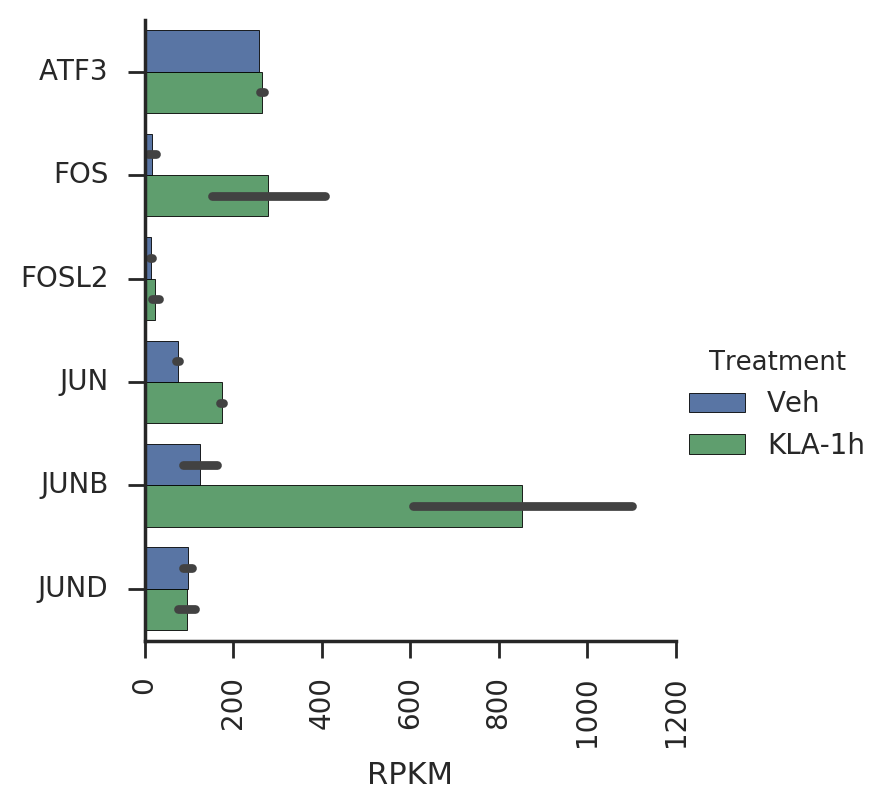

In [93]:
# from AP-1 as a regulator of cell life and death
# Jun (c-Jun, JunB, JunD), 
# Fos (c-Fos, FosB, Fra-1 and Fra2), 
# Maf (c-Maf, MafB, MafA, MafG/F/K and Nrl) and 
# ATF (ATF2, LRF1/ATF3, B-ATF, JDP1, JDP2) 
# BATF3 and JDP1 are the same thing
gene_list = ['JUN' , 'JUNB', 'JUND',
             'FOS', 'FOSL1', 'FOSL2', 'FOSB',
#              'MAF', 'MAFA','MAFB','MAFG', 'MAFF', 'MAFK', 'NRL',
             'ATF2', 'ATF3','BATF','JDP2','BATF3'#'JDP1'
             ]
gene_list = ['ATF3', 'FOS', 'FOSL2',
             'JUN' , 'JUNB', 'JUND']
plotting_frame = rpkm_plotting_frame[rpkm_plotting_frame['Gene'].isin(gene_list)]
gene_list_tuples = []
for gene in set(plotting_frame['Gene'].values):
    vals = plotting_frame[plotting_frame['Gene']==gene]['Log2 RPKM'].values
    gene_list_tuples.append((gene, np.max(vals)))
gene_list_tuples.sort(key=lambda x:x[1])
ordered_genes = [x[0] for x in gene_list_tuples]
with sns.axes_style('ticks'):
    sns.factorplot(data = plotting_frame, 
                   x='RPKM', 
                   y='Gene', 
                   hue='Treatment', 
                   kind='bar', 
                   order = gene_list,
                   hue_order=['Veh','KLA-1h'], 
                   ci=100,
                  size=4)
#     plt.xlabel('AP-1 Monomer')
    plt.ylabel('')

plt.xticks(rotation=90)
plt.savefig('./figures/figure_01_monomer_expression.svg', bbox_inches='tight')

### Heatmap of Cistrome

In [1827]:
%%capture
### create tag matrix
!annotatePeaks.pl ./merged_peaks_filtered_resized.tsv mm10 -size given -d ./tag_directories_ap1/*/ ./tag_directories_strains/*/ ./tag_directories_validation/*/> merged_annotated_peaks_ap1.tsv

In [89]:
# average tag counts from both replicates
ap1_tag_frame = pd.read_csv('merged_annotated_peaks_ap1.tsv', sep='\t')
ap1_tag_frame.index = ap1_tag_frame.ix[:,0].values
ap1_tag_frame = ap1_tag_frame[[x for x in ap1_tag_frame.columns.values if 'Tag Count' in x]]
columns = [x.split(' ')[0].split('/')[2].lower() for x in ap1_tag_frame.columns.values]
ap1_tag_frame.columns = columns

factor_treatments = sorted(set(['_'.join(x.split('_')[:5]) for x in columns]))

ap1_meanTag_dict = {}
for ft in factor_treatments:
    cleaned_ft = ft.replace('thiomac_chip_','').replace('-1h','')

    ap1_meanTag_dict[cleaned_ft] = ap1_tag_frame[[x for x in ap1_tag_frame.columns if ft in x]].mean(axis=1).values
ap1_meanTag_frame = pd.DataFrame(ap1_meanTag_dict)
ap1_meanTag_frame.index = ap1_tag_frame.index.values

### Heatmap for both Vehicle and KLA

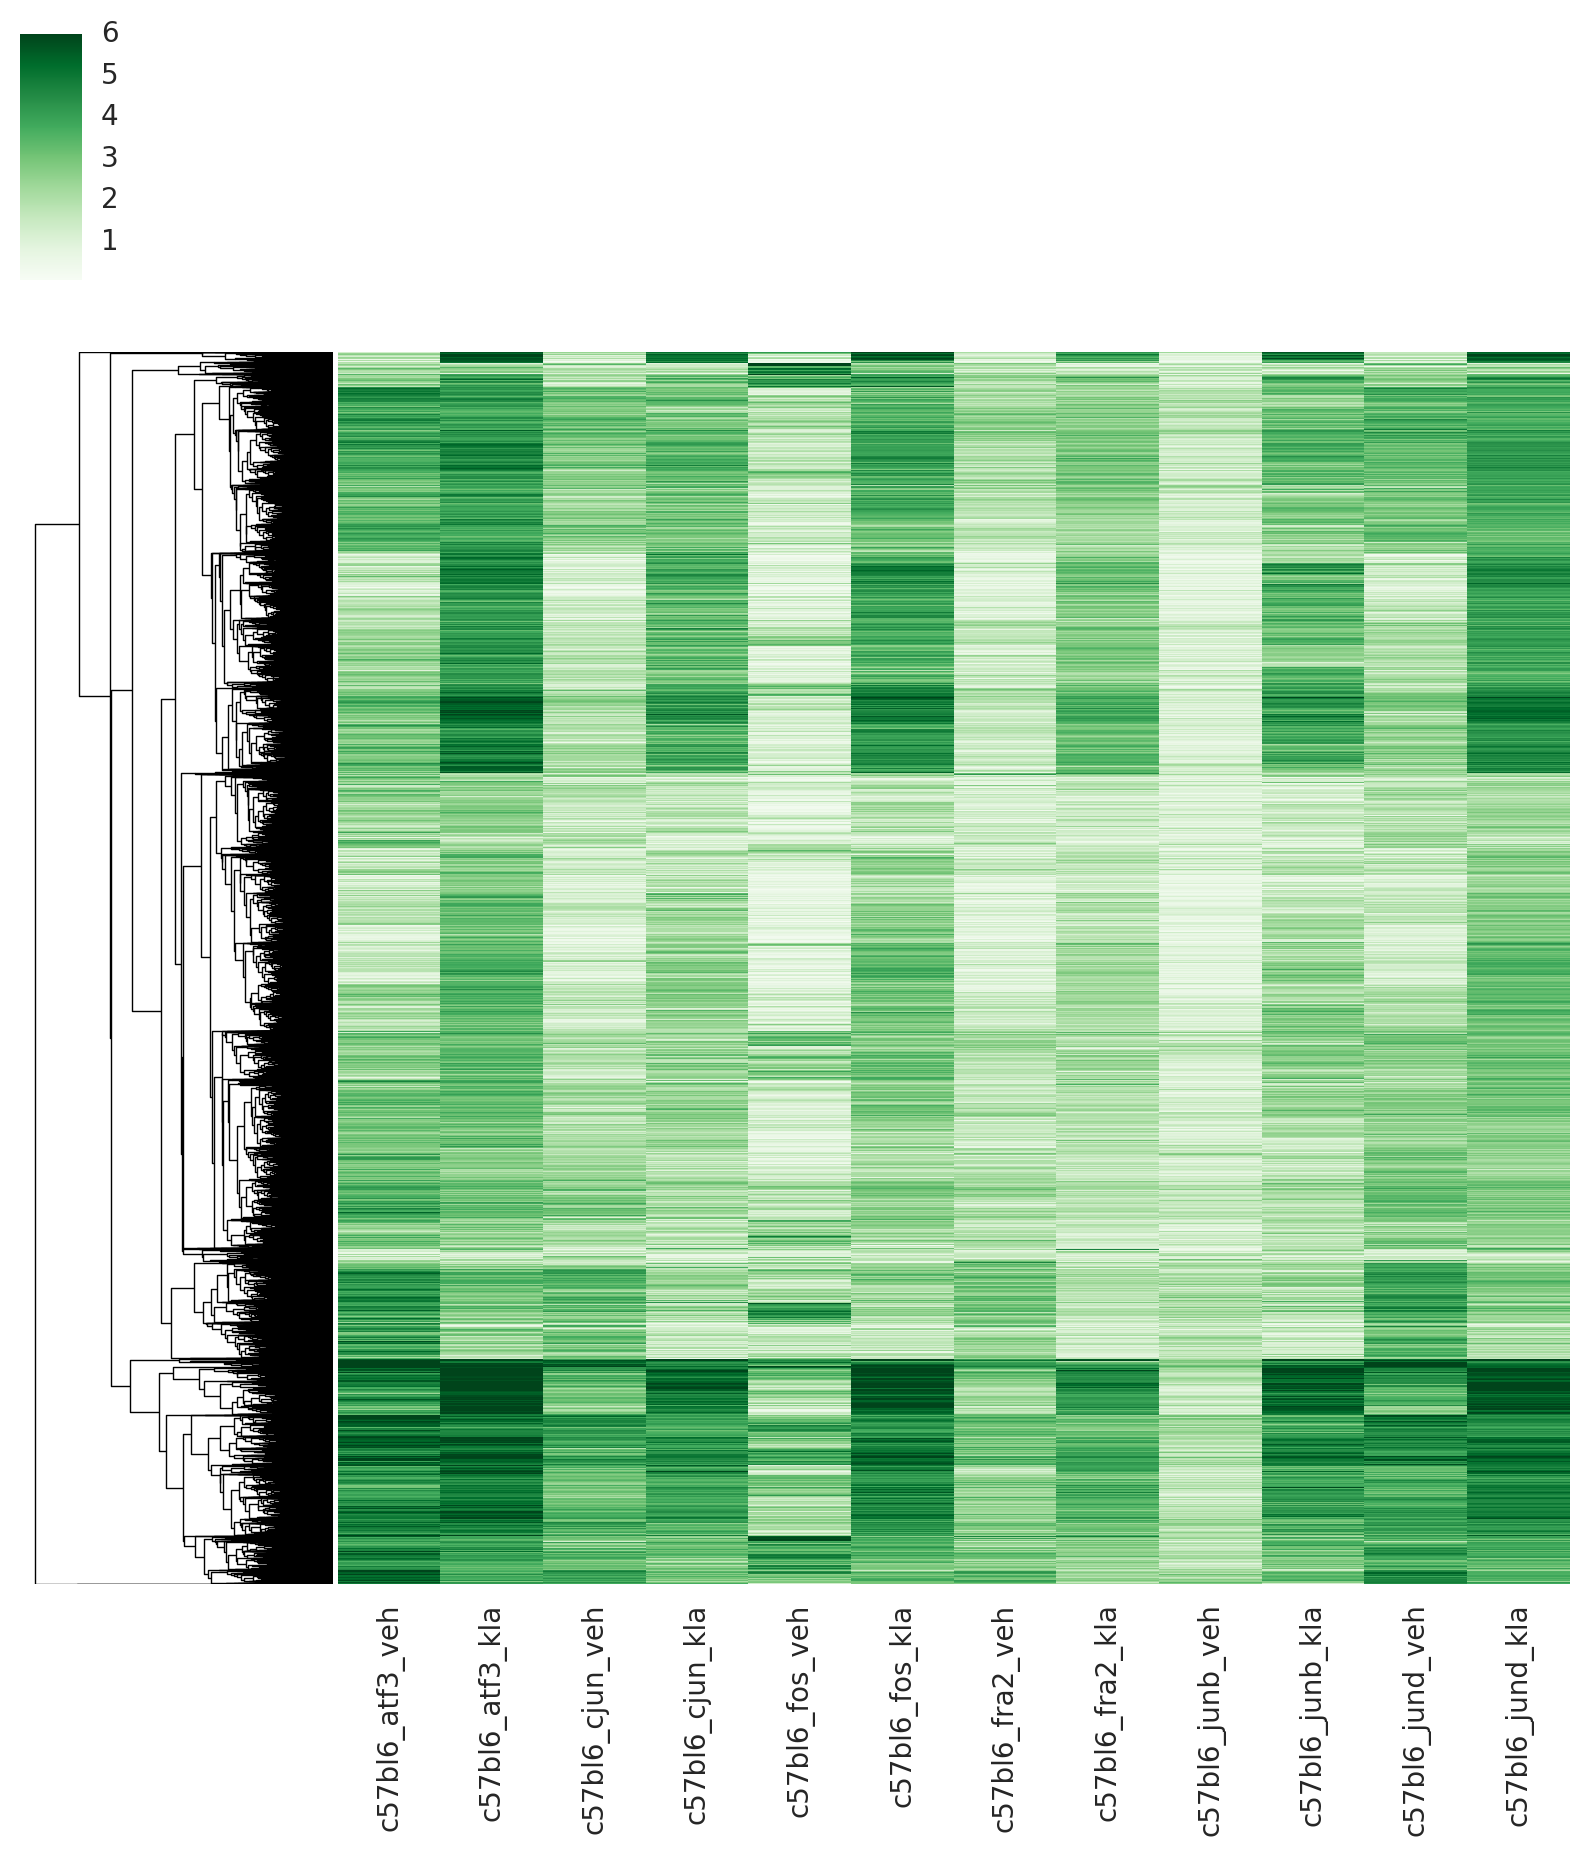

In [24]:
strain = 'c57bl6'
c57bl6_indices = summary_frame[summary_frame['Factors'].str.contains('c57bl6_ap-1')].index.values
ap1_normedTag_frame = ap1_meanTag_frame[ap1_meanTag_frame.index.isin(c57bl6_indices)][[]]
for factor in ['atf3','cjun', 'fos', 'fra2', 'junb', 'jund']:
    for treatment in ['veh','kla']:
        ft = strain + '_' + factor + '_' + treatment
        ap1_normedTag_frame[ft] = (ap1_meanTag_frame[ft] + 1)/(ap1_meanTag_frame[strain + '_input_'+treatment]+1)

logged_data = np.log2(ap1_normedTag_frame+1)

cg = sns.clustermap(logged_data,
                    yticklabels=False,
                    xticklabels=logged_data.columns,
                    cmap='Greens',
                    col_cluster=False,
                    row_cluster = True,
                    vmax=6)
plt.savefig('./figures/figure_01_tag_count_heatmap.png', bbox_inches='tight')

### Barplot summarizing overlap of peaks before and after KLA

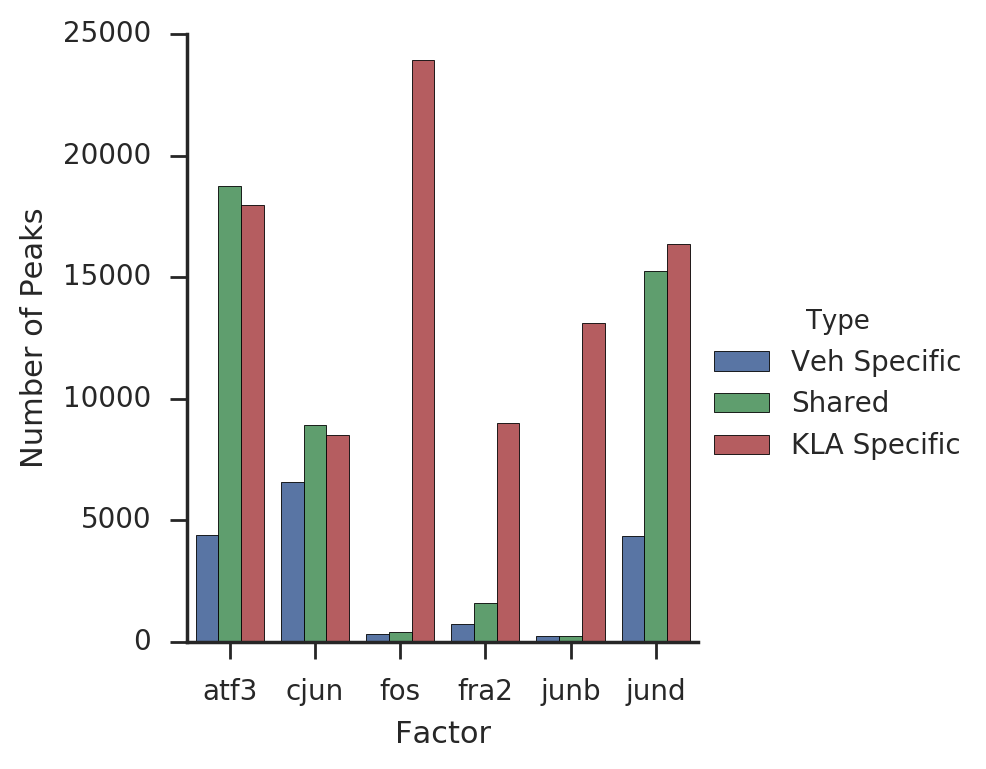

In [26]:
# ap1_members = ['atf3', 'cjun', 'fos', 'fra1', 'fra2','jdp2', 'junb', 'jund']
ap1_members = ['atf3', 'cjun', 'fos', 'fra2', 'junb', 'jund']
factor_list = []
count_list = []
type_list = []

veh_columns = ['c57bl6_' + x + '_veh' for x in ap1_members]
kla_columns = ['c57bl6_' + x + '_kla' for x in ap1_members]

for i in range(len(ap1_members)):
    factor = ap1_members[i]
    
        
    veh_indices = set(summary_frame[summary_frame['c57bl6_' + factor + '_veh'] > 0].index.values)
    kla_indices = set(summary_frame[summary_frame['c57bl6_' + factor + '_kla'] > 0].index.values)
        
    veh_count = len(veh_indices.difference(kla_indices))
    both_count = len(veh_indices.intersection(kla_indices))
    kla_count = len(kla_indices.difference(veh_indices))

    factor_list = factor_list + 3*[factor]
    type_list = type_list + ['Veh Specific', 'Shared', 'KLA Specific']
    count_list.append(veh_count)
    count_list.append(both_count)
    count_list.append(kla_count)
    
plotting_frame = pd.DataFrame({'Factor':factor_list,
                              'Type':type_list,
                              'Number of Peaks': count_list})
with sns.axes_style('ticks'):
    sns.factorplot(data=plotting_frame, 
                   x = 'Factor',
                   y = 'Number of Peaks',
                   hue = 'Type',
                   hue_order = ['Veh Specific', 'Shared', 'KLA Specific'],
                   kind = 'bar')

    plt.savefig('./figures/figure_01_peak_counts.svg', bbox_inches='tight')

### Browser shots

In [ ]:
summary_frame[(summary_frame['c57bl6_cjun_veh'] == 0) &
              (summary_frame['c57bl6_cjun_kla'] > 0) &
              (summary_frame['c57bl6_p65_kla'] > 0) &
              (summary_frame['c57bl6_p65_veh'] == 0)].sort('c57bl6_cjun_kla', ascending=False)

# Figure 2 

### De Novo Motif Analysis

In [ ]:
%%bash
### create motif analysis directories
if [ ! -d ./denovo_motif_analysis ]; 
then 
    # make directories for peaks
    mkdir ./denovo_motif_analysis;
    mkdir ./denovo_motif_analysis/veh_peaks;
    mkdir ./denovo_motif_analysis/kla_peaks;
    mkdir ./denovo_motif_analysis/veh_nonoverlapping_peaks;
    mkdir ./denovo_motif_analysis/kla_nonoverlapping_peaks;
    mkdir ./denovo_motif_analysis/veh_monomers_peaks;
    mkdir ./denovo_motif_analysis/kla_monomers_peaks;
    
    # make directories for motif analysis
    mkdir ./denovo_motif_analysis/veh_motif_analysis_overlapping;
    mkdir ./denovo_motif_analysis/kla_motif_analysis_overlapping;
    mkdir ./denovo_motif_analysis/veh_motif_analysis_nonoverlapping;
    mkdir ./denovo_motif_analysis/kla_motif_analysis_nonoverlapping;
    mkdir ./denovo_motif_analysis/veh_motif_analysis_monomers;
    mkdir ./denovo_motif_analysis/kla_motif_analysis_monomers;

else
    rm -rf ./denovo_motif_analysis/*/*
fi


### For overlapping dimer and monomer peaks

In [ ]:
### create peak files for denovo motif
peak_threshold = 1000 # minimum number of peaks required for running motif analysis
factors = ['atf3', 'cjun', 'fos', 'fra2', 'junb', 'jund']

for treatment in ['veh', 'kla']:
    for i in range(len(factors)):
        factor1 = 'c57bl6_'+factors[i] + '_' + treatment
        for j in range(i, len(factors)):
            factor2 = 'c57bl6_'+ factors[j] + '_' + treatment

            if factor1 == factor2:
                outputPath = './denovo_motif_analysis/' + treatment + '_monomers_peaks/' + factor1 + '_peaks.tsv'

                current_frame = summary_frame[(summary_frame[factor1] > 0)]
            else:
                outputPath = './denovo_motif_analysis/' + treatment + '_peaks/' + factor1 + '_' + factor2 + '_peaks.tsv'
                current_frame = summary_frame[(summary_frame[factor1]> 0) &
                                             (summary_frame[factor2] > 0)]
            current_peak_frame = current_frame[['ID', 'chr', 'start', 'end']]
            current_peak_frame['strand'] = '+'
            columns = current_peak_frame.columns.values
            columns[0]='#PeakID'        
            current_peak_frame.columns = columns
            if current_peak_frame.shape[0]  > peak_threshold:
                outputPath = outputPath.replace('c57bl6_','')
                current_peak_frame.to_csv(outputPath,
                                         index=False,
                                         sep='\t')

In [ ]:
%%capture
%%bash
for peakFile in ./denovo_motif_analysis/veh_peaks/*_peaks.tsv
do
    peakName=${peakFile%_peaks.tsv}
    peakName=${peakName##*/}
    findMotifsGenome.pl $peakFile mm10 ./denovo_motif_analysis/veh_motif_analysis_overlapping/${peakName} -size 200 -len 8 -p 24 -S 25 &
    
done


In [ ]:
%%capture
%%bash
for peakFile in ./denovo_motif_analysis/kla_peaks/*_peaks.tsv
do
    peakName=${peakFile%_peaks.tsv}
    peakName=${peakName##*/}
    findMotifsGenome.pl $peakFile mm10 ./denovo_motif_analysis/kla_motif_analysis_overlapping/${peakName} -size 200 -len 8 -p 24 -S 25 &
done

In [ ]:
%%capture
%%bash
rm -rf ./denovo_motif_analysis/veh_motif_analysis_monomers/*
for peakFile in ./denovo_motif_analysis/veh_monomers_peaks/*_peaks.tsv
do
    peakName=${peakFile%_peaks.tsv}
    peakName=${peakName##*/}
    findMotifsGenome.pl $peakFile mm10 ./denovo_motif_analysis/veh_motif_analysis_monomers/${peakName} -size 200 -len 8 -p 24 -S 25 &
    
done

In [ ]:
%%capture
%%bash
rm -rf ./denovo_motif_analysis/kla_motif_analysis_monomers/*
for peakFile in ./denovo_motif_analysis/kla_monomers_peaks/*_peaks.tsv
do
    peakName=${peakFile%_peaks.tsv}
    peakName=${peakName##*/}
    findMotifsGenome.pl $peakFile mm10 ./denovo_motif_analysis/kla_motif_analysis_monomers/${peakName} -size 200 -len 24 -p 8 -S 25 &
    
done

### for non overlappinng monomer peaks

In [ ]:
### create peak files for denovo motif analysis 
peak_threshold = 50 # minimum number of peaks required for running motif analysis
strain = 'c57bl6'
factorPairs = []
# ap1_members = ['atf3','cjun', 'fos', 'fra1','fra2', 'jdp2', 'junb','jund']    
ap1_members = ['atf3','cjun', 'fos', 'junb','jund']    

for treatment in ['veh', 'kla']:
    c57bl6_columns = ['c57bl6_' + x + '_' + treatment for x in ap1_members]
    for i in range(len(ap1_members)):
        monomer1 = strain + '_' +ap1_members[i] + '_' + treatment
            
        outputPath = './denovo_motif_analysis/' + treatment + '_nonoverlapping_peaks/' + \
            ap1_members[i].replace('c57bl6_','') + '_peaks.tsv'
            
        current_frame = summary_frame[(summary_frame[[monomer1]].sum(axis=1) == summary_frame[c57bl6_columns].sum(axis=1))
                                     & (summary_frame[monomer1] > 0)]
        if current_frame.shape[0] >= peak_threshold:
            print(ap1_members[i], current_frame.shape)
            current_peak_frame = current_frame[['ID', 'chr', 'start', 'end']]
            current_peak_frame['strand'] = '+'
            columns = current_peak_frame.columns.values
            columns[0]='#PeakID'        
            current_peak_frame.columns = columns
            if current_peak_frame.shape[0]  > peak_threshold:
                current_peak_frame.to_csv(outputPath,
                                         index=False,
                                         sep='\t')

In [ ]:
%%bash
%%capture
for peakFile in ./denovo_motif_analysis/veh_nonoverlapping_peaks/*_peaks.tsv
do
    peakName=${peakFile%_peaks.tsv}
    peakName=${peakName##*/}
    findMotifsGenome.pl $peakFile mm10 ./denovo_motif_analysis/veh_motif_analysis_nonoverlapping/${peakName} -size 200 -len 8 -p 24 -S 25 &
done

for peakFile in ./denovo_motif_analysis/kla_nonoverlapping_peaks/*_peaks.tsv
do
    peakName=${peakFile%_peaks.tsv}
    peakName=${peakName##*/}
    findMotifsGenome.pl $peakFile mm10 ./denovo_motif_analysis/kla_motif_analysis_nonoverlapping/${peakName} -size 200 -len 8 -p 24 -S 25 &
done

### Using other monomers as background

#### create background peaks

In [1391]:
other_background_path = './denovo_motif_analysis/other_monomer_background'
if not os.path.isdir(other_background_path):
    os.mkdir(other_background_path)
else:
    os.system('rm -rf ' + other_background_path + '/*')

In [1410]:
!ls ./denovo_motif_analysis/veh_monomers_peaks/

atf3_veh_peaks.tsv  cjun_veh_peaks.tsv	fra2_veh_peaks.tsv  jund_veh_peaks.tsv


In [ ]:
%%bash
other_background_path='./denovo_motif_analysis/other_monomer_background'
for factor in atf3 cjun jund;
    do
    for background_factor in atf3 cjun jund;
        do
        if [ ! "$factor" == $"$background_factor" ]
        then
        factor_path="./denovo_motif_analysis/veh_monomers_peaks/${factor}_veh_peaks.tsv"
        background_path="./denovo_motif_analysis/veh_nonoverlapping_peaks/${background_factor}_peaks.tsv"
        echo findMotifsGenome.pl $factor_path mm10 ${other_background_path}/${factor}_bg_${background_factor} -bg $background_path -size 200 -p 24 -S 25
        findMotifsGenome.pl $factor_path mm10 ${other_background_path}/${factor}_bg_${background_factor} -bg $background_path -size 200 -p 24 -S 25 &
        fi
    done
done

### Combine Denovo Motifs

In [53]:
def groupTopMotifs(numMotifs, denovo_result_dir, scanning_results_dir):
    '''
    move denovo motifs to scanning_results_dir
    '''
    if not os.path.isdir(scanning_results_dir):
        os.mkdir(scanning_results_dir)
   
    combinedFile = open(scanning_results_dir + '/combined.motif', 'w')

    # for each denovo motif analysis result for each monomer
    for monomer_result_dir in os.listdir(denovo_result_dir):
        for i in range(1, numMotifs+1):
            # construct path to motifs 1 through numMotifs
            motif_path = denovo_result_dir + '/' + monomer_result_dir + '/homerResults/motif' + str(i) + '.motif'
            # read in motif file
            if os.path.isfile(motif_path):
                with open(motif_path) as f:
                    data = f.readlines()

                # change motif header
                newMotifName = monomer_result_dir + '_' + str(i)
                os.system('cp ' + motif_path + ' ' + scanning_results_dir + '/' + newMotifName + '.motif')
                os.system('cp ' + motif_path.replace('.motif','.logo.png') + ' ' + scanning_results_dir + '/' + newMotifName + '.logo.png')
    combinedFile.close()

In [54]:
def copyTopMotifLogos(numMotifs, denovo_result_dir, output_dir):
    if not os.path.isdir(output_dir):
        os.mkdir(output_dir)
    else:
        for f in os.listdir(output_dir):
            os.remove(output_dir + '/' + f)

    # for each denovo motif analysis result for each monomer
    for monomer_result_dir in os.listdir(denovo_result_dir):
        for i in range(1, numMotifs+1):
            # construct path to motifs 1 through numMotifs
            logo_path = denovo_result_dir + '/' + monomer_result_dir + '/homerResults/motif' + str(i) + '.logo.png'
            motif_path = denovo_result_dir + '/' + monomer_result_dir + '/homerResults/motif' + str(i) + '.motif'

            if os.path.isfile(motif_path):
                with open(motif_path) as f:
                    line = f.readline()
                motif_name = line.split()[0][1:]
                newMotifName = motif_name + '.logo.png'
                
                os.system('cp ' +logo_path + ' '+ output_dir +'/' + newMotifName)


In [55]:
numMotifs = 25 # number of motifs to include
denovo_result_dir = './denovo_motif_analysis/veh_motif_analysis_nonoverlapping/'
scanning_results_dir = './denovo_motif_analysis/veh_motif_scanning/'
groupTopMotifs(numMotifs, denovo_result_dir, scanning_results_dir)

numMotifs = 25 # number of motifs to include
denovo_result_dir = './denovo_motif_analysis/kla_motif_analysis_nonoverlapping/'
scanning_results_dir = './denovo_motif_analysis/kla_motif_scanning/'
groupTopMotifs(numMotifs, denovo_result_dir, scanning_results_dir)



In [56]:
numMotifs = 25 # number of motifs to include
denovo_result_dir = './denovo_motif_analysis/veh_motif_analysis_nonoverlapping/'
veh_logo_path = './denovo_motif_analysis/veh_motif_scanning_logos/'
copyTopMotifLogos(numMotifs, denovo_result_dir, veh_logo_path)

numMotifs = 25 # number of motifs to include
denovo_result_dir = './denovo_motif_analysis/kla_motif_analysis_nonoverlapping/'
kla_logo_path = './denovo_motif_analysis/kla_motif_scanning_logos/'
copyTopMotifLogos(numMotifs, denovo_result_dir, kla_logo_path)

### Cluster Motifs

In [58]:
veh_scanning_dir = './denovo_motif_analysis/veh_motif_scanning/'
for mf in os.listdir(veh_scanning_dir):
    if '.motif' in mf:
        with open(veh_scanning_dir + '/' +mf) as f:
            data = f.readlines()
        header_tokens = data[0].split()
        out_file = open(veh_scanning_dir + '/' +mf, 'w')
        out_file.write('>'+header_tokens[1] + '\t' + mf.replace('.motif', '') + '\t' + header_tokens[2] + '\n')
        for line in data[1:]:
            out_file.write(line)
        out_file.close()

In [59]:
kla_scanning_dir = './denovo_motif_analysis/kla_motif_scanning/'
for mf in os.listdir(kla_scanning_dir):
    if '.motif' in mf:
        with open(kla_scanning_dir + '/' +mf) as f:
            data = f.readlines()
        header_tokens = data[0].split()
        out_file = open(kla_scanning_dir + '/' +mf, 'w')
        out_file.write('>'+header_tokens[0] + '\t' + mf.replace('.motif', '') + '\t' + header_tokens[2] + '\n')
        for line in data[1:]:
            out_file.write(line)
        out_file.close()

In [ ]:
%%bash
rm ./denovo_motif_analysis/veh_motif_scanning/combined.motif
rm ./denovo_motif_analysis/kla_motif_scanning/combined.motif

# score motif similarity

python /gpfs/data01/glasslab/home/jtao/code/tba/score_motifs.py ./denovo_motif_analysis/veh_scanning_motif_clustering/ ./denovo_motif_analysis/veh_motif_scanning/*motif
python /gpfs/data01/glasslab/home/jtao/code/tba/score_motifs.py ./denovo_motif_analysis/kla_scanning_motif_clustering/ ./denovo_motif_analysis/kla_motif_scanning/*motif

In [72]:
%%bash
# cluster motifs
rm -rf ./denovo_motif_analysis/veh_scanning_motif_clustering/clustered_motifs/
rm -rf ./denovo_motif_analysis/kla_scanning_motif_clustering/clustered_motifs/
python /gpfs/data01/glasslab/home/jtao/code/tba/threshold_cluster_motifs.py ./denovo_motif_analysis/veh_scanning_motif_clustering/correlation.npz ./denovo_motif_analysis/veh_scanning_motif_clustering/ 0.90 ./denovo_motif_analysis/veh_motif_scanning/*motif 
python /gpfs/data01/glasslab/home/jtao/code/tba/threshold_cluster_motifs.py ./denovo_motif_analysis/kla_scanning_motif_clustering/correlation.npz ./denovo_motif_analysis/kla_scanning_motif_clustering/ 0.90 ./denovo_motif_analysis/kla_motif_scanning/*motif 

In [73]:
veh_correlation_data = np.load('./denovo_motif_analysis/veh_scanning_motif_clustering/correlation.npz')
veh_correlations = veh_correlation_data['arr_0']
veh_motif_names = veh_correlation_data['arr_1']

In [74]:
kla_correlation_data = np.load('./denovo_motif_analysis/kla_scanning_motif_clustering/correlation.npz')
kla_correlations = kla_correlation_data['arr_0']
kla_motif_names = kla_correlation_data['arr_1']

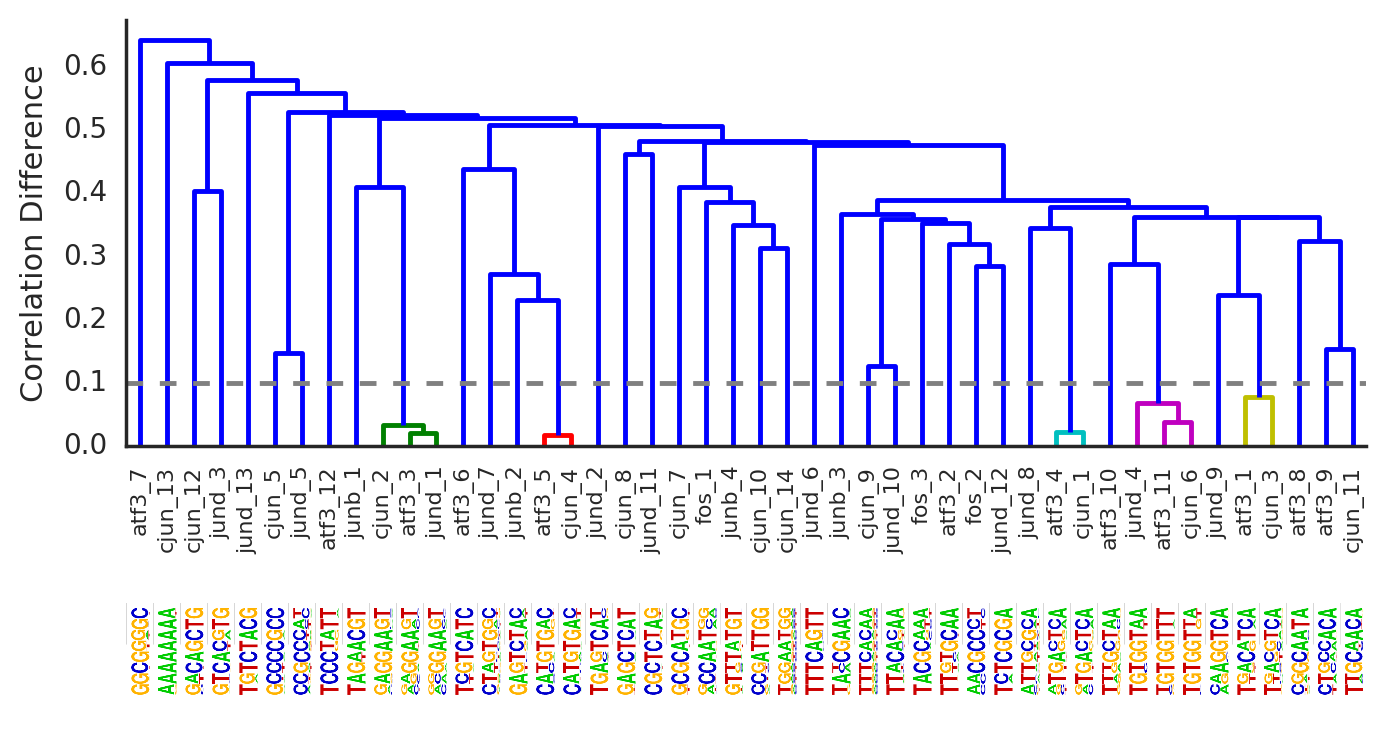

In [75]:
motif_path = './denovo_motif_analysis/veh_motif_scanning/'
motif_names = veh_motif_names
# fig = plt.figure(figsize=(10,10))
with sns.axes_style('white'):
    Z=scipy.cluster.hierarchy.linkage(veh_correlations, 
                                      'single', 
                                      'correlation')
    gs = matplotlib.gridspec.GridSpec(2, len(motif_names), wspace=0.0, hspace=0.0)
    dendrogram_axis = plt.subplot(gs[0,:len(motif_names)])
    sns.despine()
    scipy.cluster.hierarchy.dendrogram(Z, 
                                       color_threshold=0.1,
                                       ax=dendrogram_axis,
                                       labels=motif_names)
    plt.axhline(0.1, linestyle='--', color='grey')
    plt.ylabel('Correlation Difference')
    
    sorted_motif_names = [x.get_text() for x in  dendrogram_axis.get_xticklabels()]
    for i in range(len(motif_names)):
        current_axis = plt.subplot(gs[1, i])
        mn = sorted_motif_names[i]
        img = plt.imread(motif_path + '/' + mn + '.logo.png')
        rotated_img = scipy.ndimage.rotate(img, 90)
        current_axis.imshow(rotated_img)
        current_axis.set_xticks([])
        current_axis.set_yticks([])
        current_axis.axis('off')
plt.savefig('./figures/figure_02_veh_motif_clustering.svg', bbox_inches='tight')

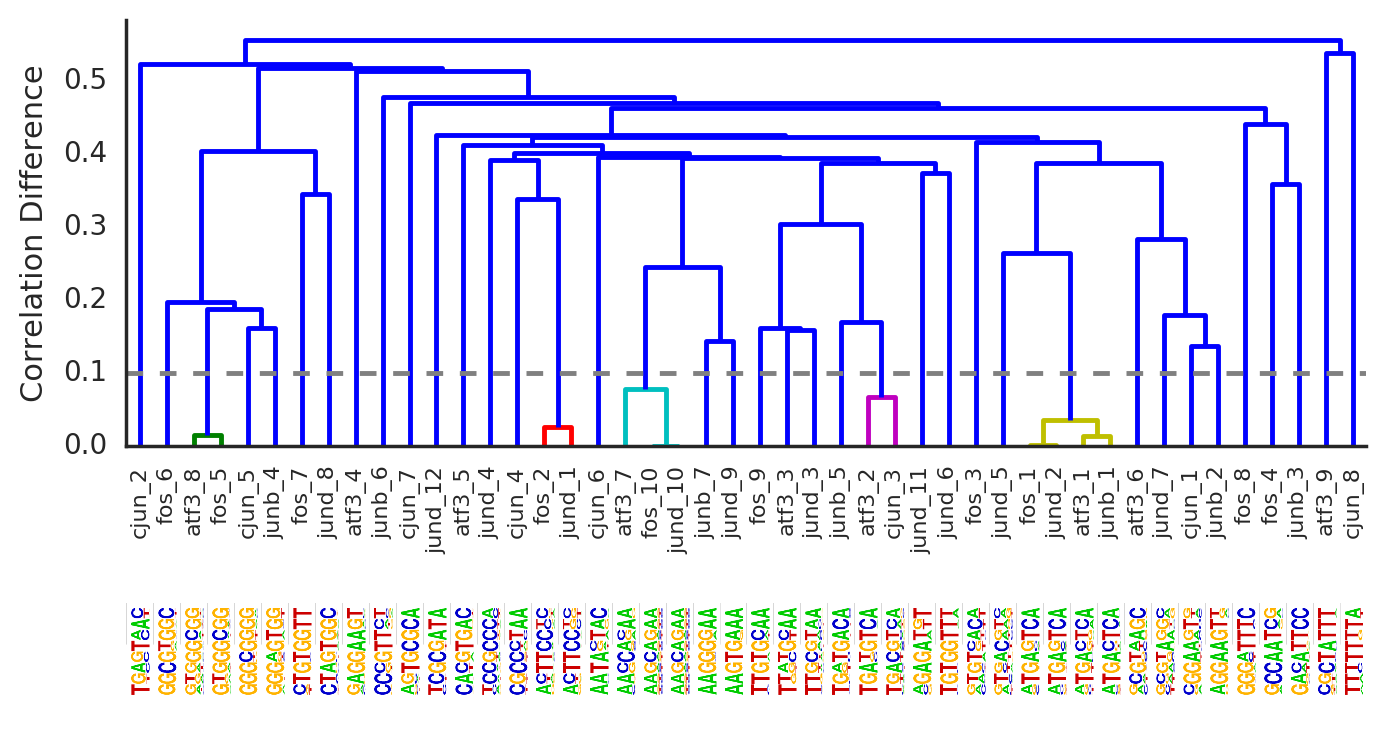

In [76]:
motif_path = './denovo_motif_analysis/kla_motif_scanning/'
motif_names = kla_motif_names
# fig = plt.figure(figsize=(10,10))
with sns.axes_style('white'):
    Z=scipy.cluster.hierarchy.linkage(kla_correlations, 
                                      'single', 
                                      'correlation')
    gs = matplotlib.gridspec.GridSpec(2, len(motif_names), wspace=0.0, hspace=0.0)
    dendrogram_axis = plt.subplot(gs[0,:len(motif_names)])
    sns.despine()
    scipy.cluster.hierarchy.dendrogram(Z, 
                                       color_threshold=0.1,
                                       ax=dendrogram_axis,
                                       labels=motif_names)
    plt.axhline(0.1, linestyle='--', color='grey')
    plt.ylabel('Correlation Difference')
    
    sorted_motif_names = [x.get_text() for x in  dendrogram_axis.get_xticklabels()]
    for i in range(len(motif_names)):
        current_axis = plt.subplot(gs[1, i])
        mn = sorted_motif_names[i]
        img = plt.imread(motif_path + '/' + mn + '.logo.png')
        rotated_img = scipy.ndimage.rotate(img, 90)
        current_axis.imshow(rotated_img)
        current_axis.set_xticks([])
        current_axis.set_yticks([])
        current_axis.axis('off')
plt.savefig('./figures/figure_02_kla_motif_clustering.svg', bbox_inches='tight')

In [48]:
%%bash
### combine motifs for motif scanning ###
out_path="./denovo_motif_analysis/veh_scanning_motif_clustering/combined.motif"
rm $out_path
touch $out_path
for f in ./denovo_motif_analysis/veh_scanning_motif_clustering/clustered_motifs/*motif;
do 
    if [[ ! "$f" == *"merged"* ]]; 
    then 
    unmerged=${f##*/}
    cat ./denovo_motif_analysis/veh_motif_scanning/$unmerged >> $out_path
    else
    # find first motif that was match
    merged=${f##*/}
    first_original=${merged:0:10}
    first_original=${first_original%_*}.motif
    cat ./denovo_motif_analysis/veh_motif_scanning/$first_original >> $out_path
    fi;
done

out_path="./denovo_motif_analysis/kla_scanning_motif_clustering/combined.motif"
rm $out_path
touch $out_path
for f in ./denovo_motif_analysis/kla_scanning_motif_clustering/clustered_motifs/*motif;
do 
    if [[ ! "$f" == *"merged"* ]]; 
    then 
    unmerged=${f##*/}
    cat ./denovo_motif_analysis/kla_motif_scanning/$unmerged >> $out_path
    else
    # find first motif that was match
    merged=${f##*/}
    first_original=${merged:0:10}
    first_original=${first_original%_*}.motif
    cat ./denovo_motif_analysis/kla_motif_scanning/$first_original >> $out_path
    fi;
done


In [ ]:
%%bash
### scan for top denovo motifs ###
rm -rf ./denovo_motif_analysis/veh_motif_scanning/*/
for peakFile in ./denovo_motif_analysis/veh_monomers_peaks/*_peaks.tsv
do
    peakName=${peakFile%_peaks.tsv}
    peakName=${peakName##*/}
    findMotifsGenome.pl $peakFile mm10 ./denovo_motif_analysis/veh_motif_scanning/${peakName} -nomotif -mknown ./denovo_motif_analysis/veh_scanning_motif_clustering/combined.motif -size 200 -p 8 &
    
done

rm -rf ./denovo_motif_analysis/kla_motif_scanning/*/
for peakFile in ./denovo_motif_analysis/kla_monomers_peaks/*_peaks.tsv
do
    peakName=${peakFile%_peaks.tsv}
    peakName=${peakName##*/}
    findMotifsGenome.pl $peakFile mm10 ./denovo_motif_analysis/kla_motif_scanning/${peakName} -nomotif -mknown ./denovo_motif_analysis/kla_scanning_motif_clustering/combined.motif -size 200 -p 8 &
    
done

In [80]:
def combineKnownMotifResults(scanning_results_dir):
    sorted_motif_names = None
    monomer_fractions_dict = {}
    for result_dir in os.listdir(scanning_results_dir):
        if os.path.isdir(scanning_results_dir + '/' + result_dir):
            knownResults_path = scanning_results_dir + '/' + result_dir + '/knownResults.txt'
            knownResults_frame = pd.read_csv(knownResults_path, sep='\t')
            motif_names = knownResults_frame['Motif Name'].values
            if sorted_motif_names == None:
                sorted_motif_names = sorted(motif_names)

            string_target_fractions = knownResults_frame['% of Target Sequences with Motif'].values
            target_fractions = np.array([float(x[:-1]) for x in string_target_fractions])

            string_background_fractions = knownResults_frame['% of Background Sequences with Motif'].values
            background_fractions = np.array([float(x[:-1]) for x in string_background_fractions])

            enrichment = target_fractions/background_fractions
            # sort fractions by motif name
            name_fraction_dict =  dict(zip(motif_names, target_fractions))
            sorted_fractions = [name_fraction_dict[x] for x in sorted_motif_names]

            monomer_fractions_dict[result_dir] = sorted_fractions
    monomer_fractions_frame = pd.DataFrame(monomer_fractions_dict, 
                                           index = [x.split(',')[0] for x in sorted_motif_names])
    monomer_fractions_frame['Best Match'] = [x.split(',')[1].split('/')[0].split(':')[1] for x in sorted_motif_names]
    return monomer_fractions_frame

In [81]:
# combine motif scanning results into one table
scanning_results_dir = './denovo_motif_analysis/veh_motif_scanning/'

veh_monomer_fractions_frame = combineKnownMotifResults(scanning_results_dir)

scanning_results_dir = './denovo_motif_analysis/kla_motif_scanning/'

kla_monomer_fractions_frame = combineKnownMotifResults(scanning_results_dir)

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:19: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


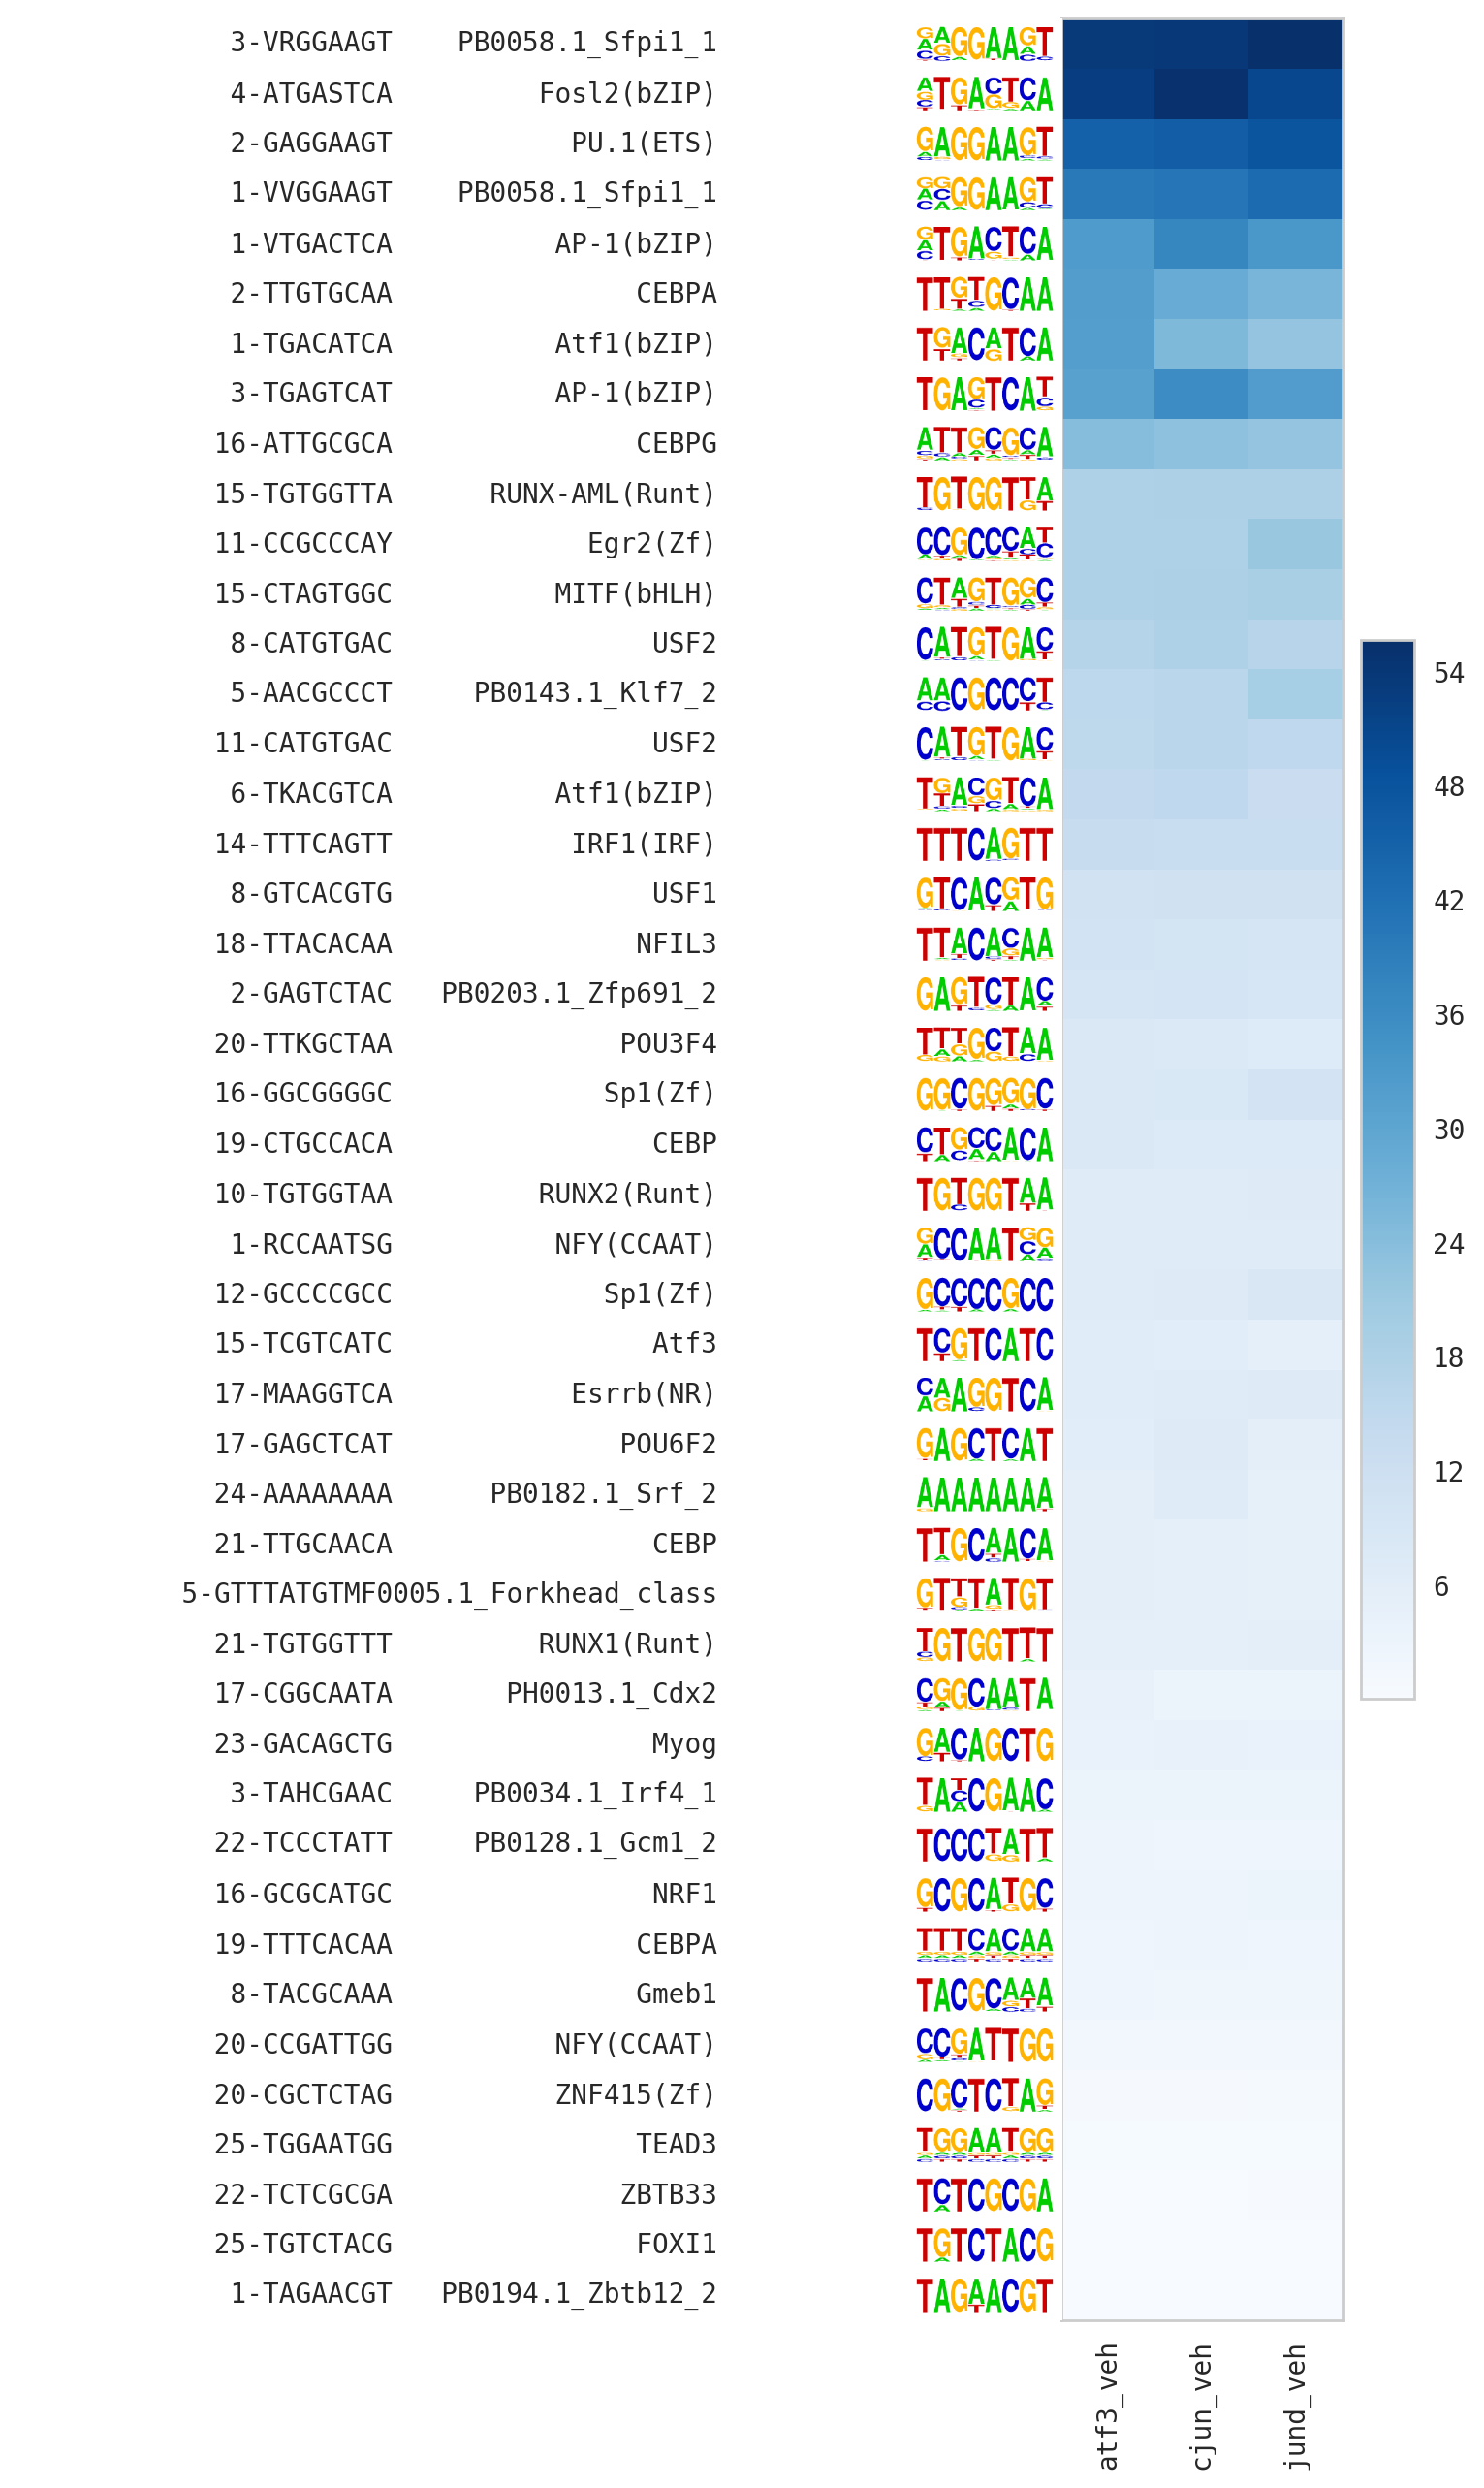

In [83]:
monomers = ['atf3_veh', 'cjun_veh', 'jund_veh']
text_padding=20
logo_path = './denovo_motif_analysis/veh_motif_scanning_logos/'
with sns.axes_style('whitegrid', {'font.family':'monospace'}):
    
    fig = plt.figure(figsize=(4,13))

    data = veh_monomer_fractions_frame.ix[[x for x in veh_monomer_fractions_frame.index.values if not 'junb' in x and not 'fos' in x],: 
                                        ]
    numRows = data.shape[0]

    gs = matplotlib.gridspec.GridSpec(numRows, 
                                      len(monomers) + 1, 
                                      wspace=0.0, 
                                      hspace=0.0)
    
    heatmap_axis = plt.subplot(gs[:,1:len(monomers)])
    
    sorted_data = data.sort('atf3_veh', ascending=True)
    plotting_data = sorted_data[monomers].values
    img = heatmap_axis.pcolor(plotting_data, 
                        cmap = matplotlib.cm.Blues,
                       )
    fig.colorbar(img)
    
    # annotate data
#     for y in range(plotting_data.shape[0]):
#         for x in range(plotting_data.shape[1]):
#             plt.text(x + 0.5, y + 0.5, '%.2f' % plotting_data[y, x],
#                      horizontalalignment='center',
#                      verticalalignment='center',
#                      color='grey'
#                      )
    
    labels = []
    for t in list(zip(sorted_data.index.values, sorted_data['Best Match'].values)):
        l = t[0].rjust(text_padding,' ') + t[1].rjust(text_padding,' ') +  ' '.rjust(text_padding,' ')
        labels.append(l)
    
    heatmap_axis.set_yticks(np.array(range(len(labels))) + 0.5 );
    heatmap_axis.set_yticklabels(labels, size =10);
    
    heatmap_axis.set_xticks(np.array(range(len(monomers)))+0.5)
    heatmap_axis.set_xticklabels(monomers, rotation=90)
    
    heatmap_axis.set_ylim(0,numRows)
    
    motif_names = sorted_data.index.values
    for i in range(len(motif_names)):
        current_axis = plt.subplot(gs[numRows - 1 - i,0])
        mn = motif_names[i].split('-')[1]
        img = plt.imread(logo_path + '/' + mn + '.logo.png')
        current_axis.imshow(img, aspect='auto')
        current_axis.axis('Off')
        current_axis.set_xticks([])
        current_axis.set_yticks([])
        
        
plt.tight_layout()
plt.savefig('./figures/figure_02_veh_denovo_motif_matrix.svg', bbox_inches='tight')

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:14: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


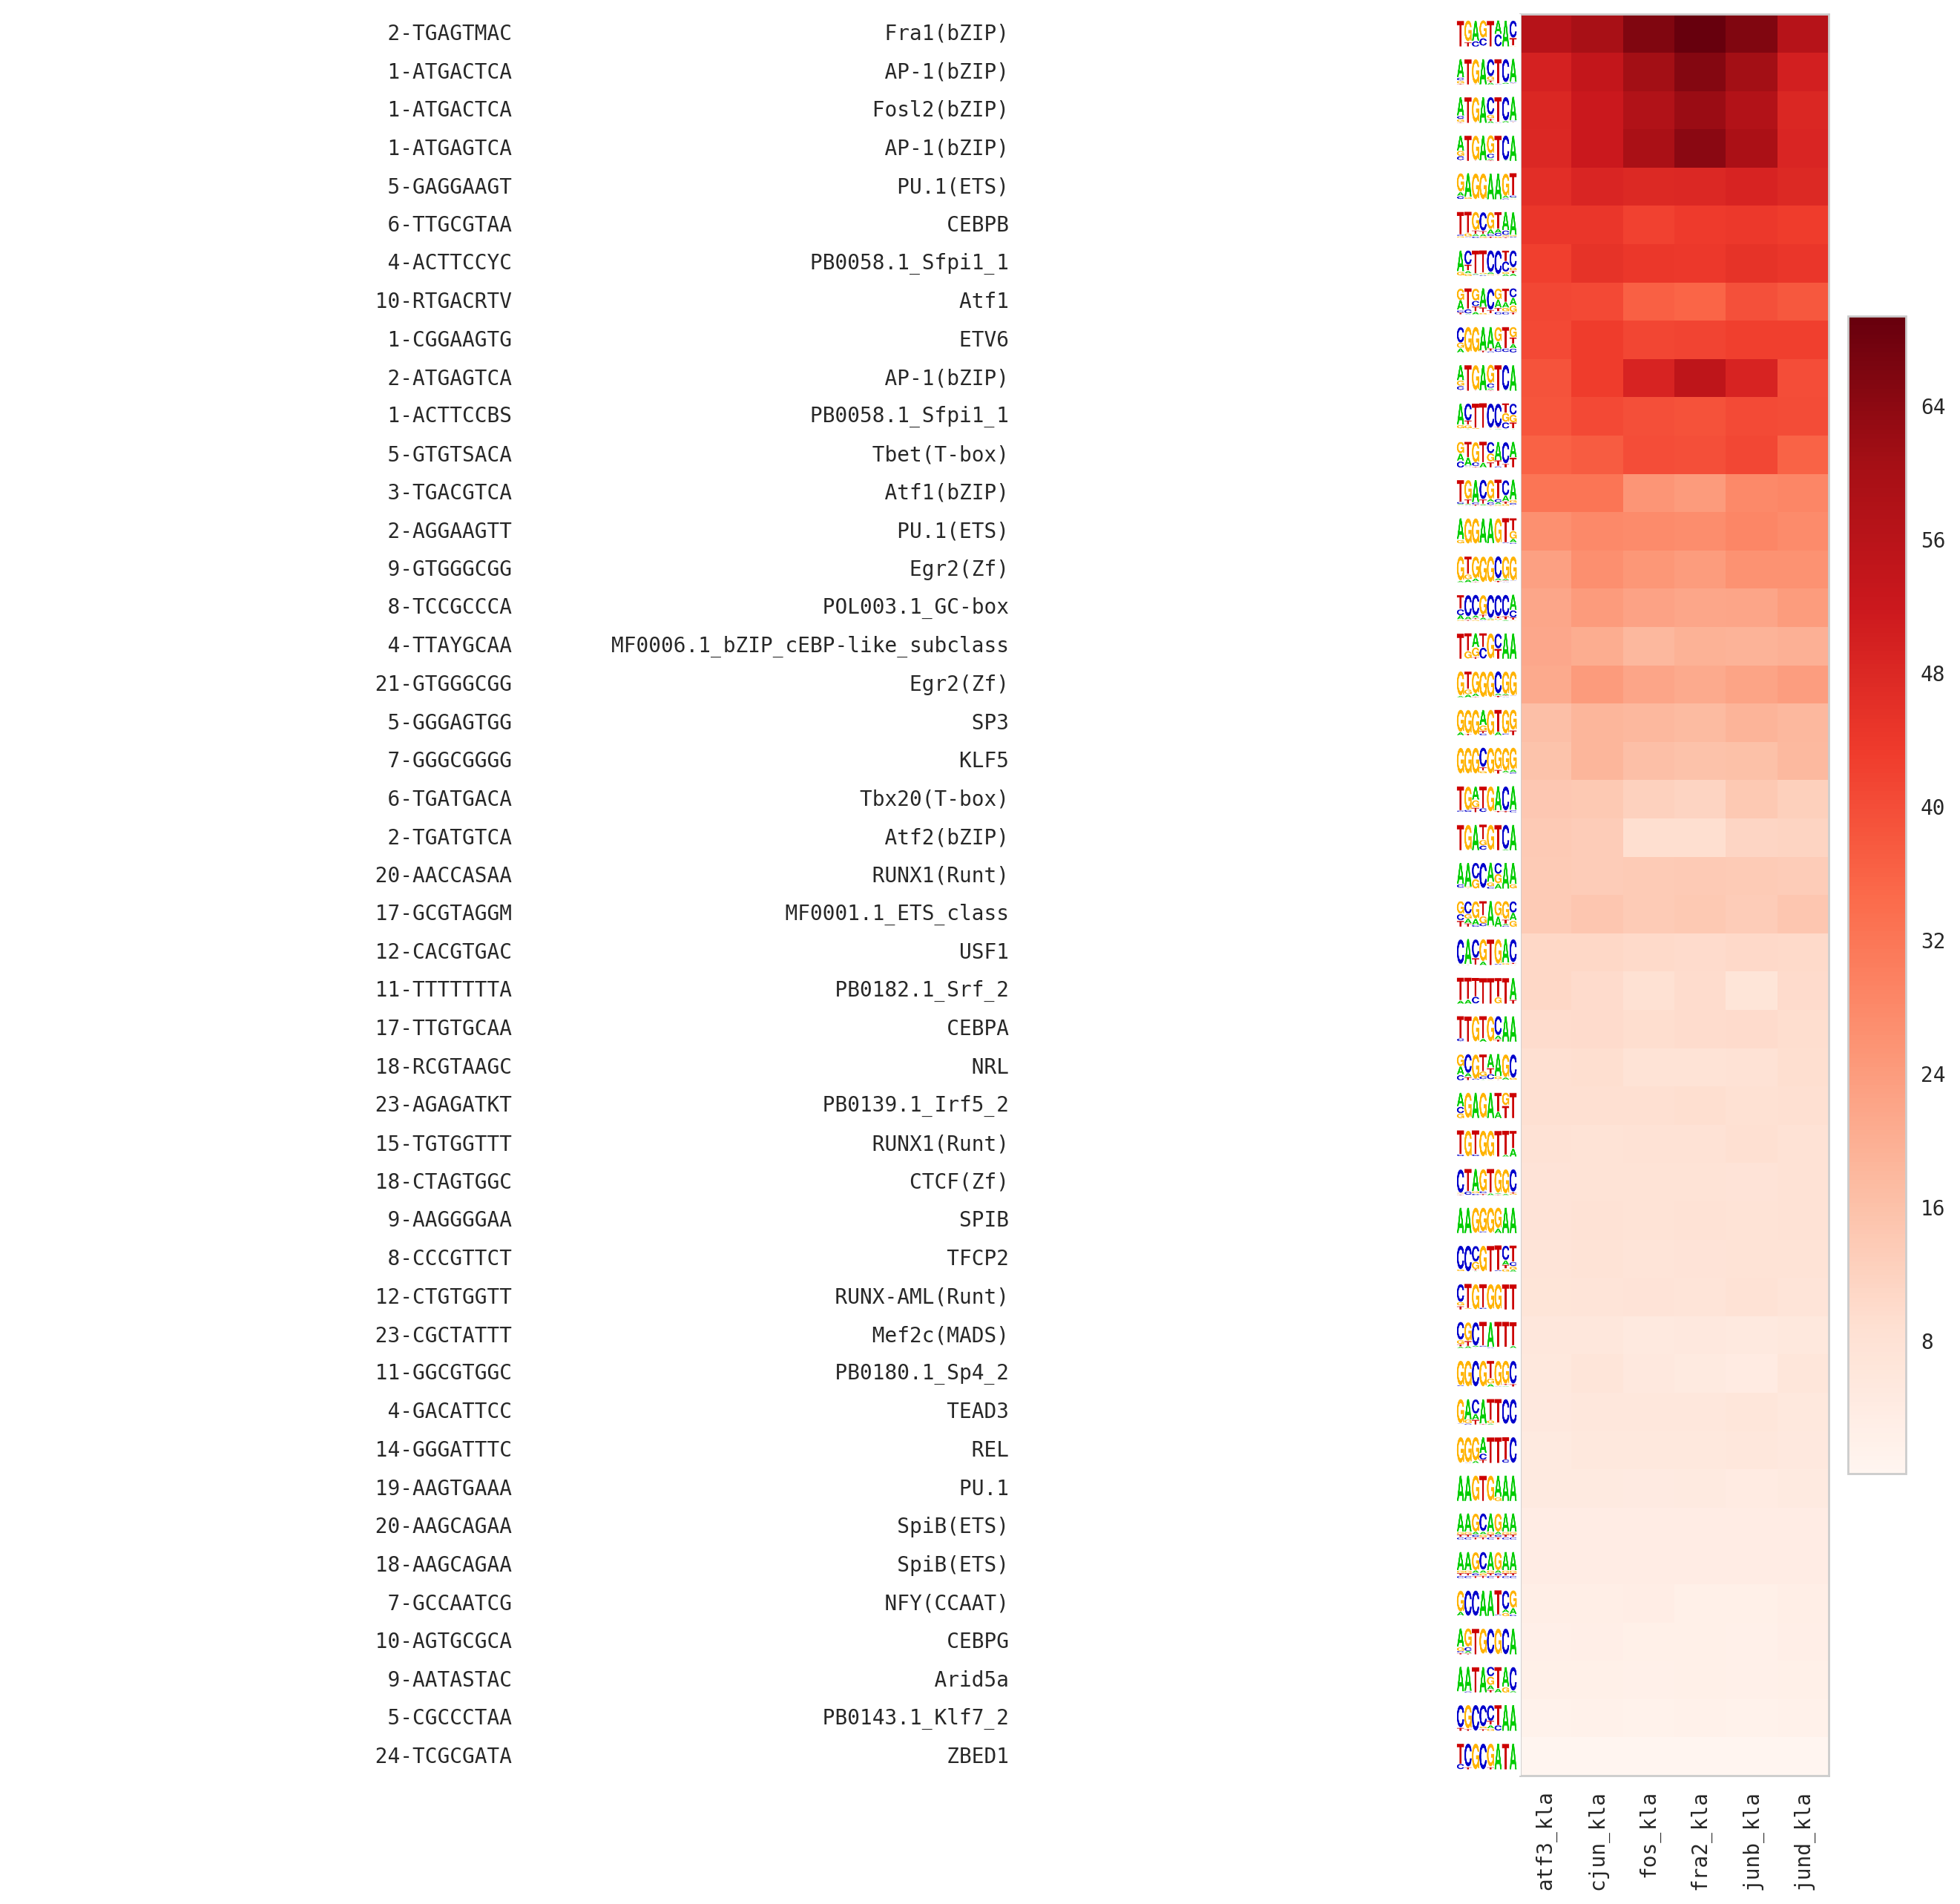

In [84]:
monomers = ['atf3_kla', 'cjun_kla', 'fos_kla', 'fra2_kla', 'junb_kla', 'jund_kla']
text_padding = 40
logo_path = './denovo_motif_analysis/kla_motif_scanning_logos/'
with sns.axes_style('whitegrid', {'font.family':'monospace'}):
    
    fig = plt.figure(figsize=(4,13))

    data = kla_monomer_fractions_frame
    data.sort('atf3_kla')
    numRows = data.shape[0]
    gs = matplotlib.gridspec.GridSpec(numRows, len(monomers) + 1, wspace=0.0, hspace=0.0)
    
    heatmap_axis = plt.subplot(gs[:,1:len(monomers)])
    sorted_data = data.sort('atf3_kla', ascending=True)
    plotting_data = sorted_data[monomers].values
    
    img = heatmap_axis.pcolor(plotting_data, 
                        cmap = matplotlib.cm.Reds,
#                         vmin = 0,
#                         vmax = 50
                       )
    
    # annotate data
#     for y in range(plotting_data.shape[0]):
#         for x in range(plotting_data.shape[1]):
#             plt.text(x + 0.5, y + 0.5, '%.2f' % plotting_data[y, x],
#                      horizontalalignment='center',
#                      verticalalignment='center',
#                      )
    cb = fig.colorbar(img)
    
    labels = []
    for t in list(zip(sorted_data.index.values, sorted_data['Best Match'].values)):
        l = t[0].rjust(text_padding,' ') + t[1].rjust(text_padding,' ') +  ' '.rjust(text_padding,' ')
        labels.append(l)
    
    heatmap_axis.set_yticks(np.array(range(len(labels))) + 0.5 );
    heatmap_axis.set_yticklabels(labels, size =10);
    
    heatmap_axis.set_xticks(np.array(range(len(monomers)))+0.5)
    heatmap_axis.set_xticklabels(monomers, rotation=90)
    
    heatmap_axis.set_ylim(0,numRows)

    motif_names = sorted_data.index.values
    for i in range(len(motif_names)):
        current_axis = plt.subplot(gs[numRows - 1 - i,0])
        mn = motif_names[i].split('-')[1]
        img = plt.imread(logo_path + '/' + mn + '.logo.png')
        current_axis.imshow(img, aspect='auto')
        current_axis.axis('Off')
        current_axis.set_xticks([])
        current_axis.set_yticks([])
plt.tight_layout()
# plt.subplots_adjust(left  = 0.0,  # the left side of the subplots of the figure
#                     right = 1,    # the right side of the subplots of the figure
#                     bottom = 0.0,   # the bottom of the subplots of the figure
#                     top = 1,      # the top of the subplots of the figure
#                     wspace = 0.0,   # the amount of width reserved for blank space between subplots
#                     hspace = 0.0,   # the amount of height reserved for white space between subplots
#                    )
plt.savefig('./figures/figure_02_kla_denovo_motif_matrix.svg', bbox_inches='tight')

### Peak Overlap Representations

#### Vehicle

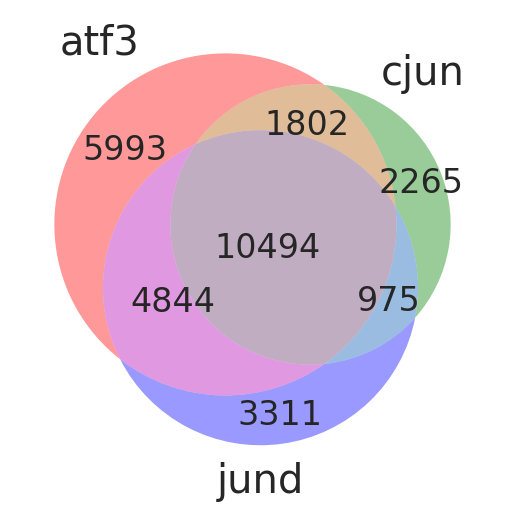

In [39]:
plt.figure(figsize=(3,3))
atf3_indices = set(summary_frame[summary_frame['c57bl6_atf3_veh'] > 0].index.values)
cjun_indices = set(summary_frame[summary_frame['c57bl6_cjun_veh'] > 0].index.values)
jund_indices = set(summary_frame[summary_frame['c57bl6_jund_veh'] > 0].index.values)
matplotlib_venn.venn3([atf3_indices, cjun_indices, jund_indices], set_labels=['atf3', 'cjun', 'jund'])
plt.savefig('./figures/figure_02_monomer_venn_veh.svg',  bbox_inches='tight')

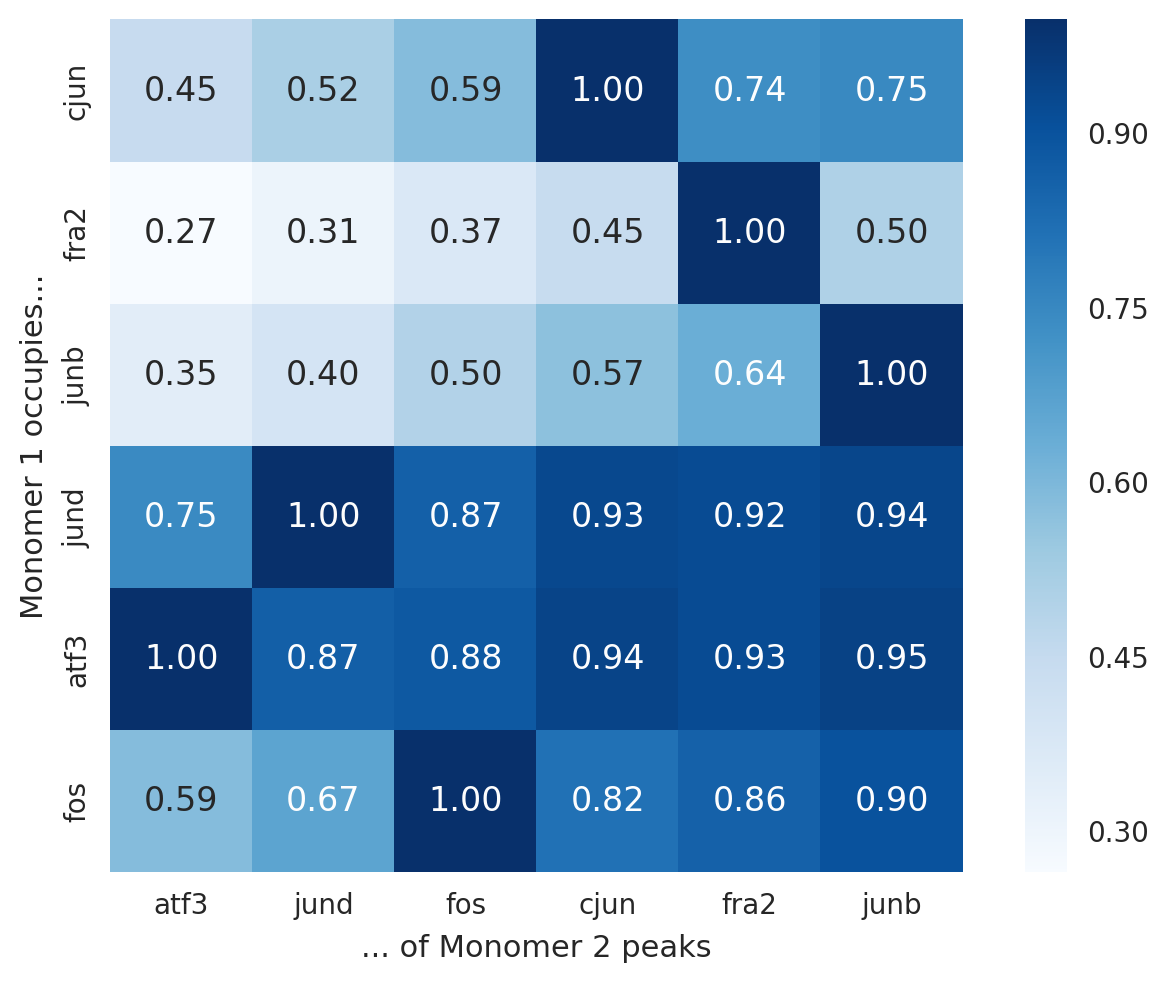

In [40]:
monomers = ['atf3_kla', 'cjun_kla', 'fos_kla', 'fra2_kla', 'junb_kla', 'jund_kla']
monomer_index_dict = dict(zip(monomers, 
                              range(len(monomers))))
matrix = np.zeros((len(monomers), len(monomers)))
# monomer_1 occupies which fraction of monomer_2
for monomer_1 in monomers:
    monomer_1_indices = set(summary_frame[summary_frame['c57bl6_' + monomer_1] > 0].index.values)
    ind_1 = monomer_index_dict[monomer_1]
    for monomer_2 in monomers:
        monomer_2_indices = set(summary_frame[summary_frame['c57bl6_' + monomer_2] > 0].index.values)
        ind_2 = monomer_index_dict[monomer_2]
        
        overlap = monomer_1_indices.intersection(monomer_2_indices)
        overlap_fraction = len(overlap)/len(monomer_2_indices)
        if not ind_1 == ind_2:
            matrix[ind_1][ind_2] = overlap_fraction
#         print(monomer_1, 'occupies', overlap_fraction, 'of', monomer_2)
labels = [x.replace('_kla','') for x in monomers]
matrix = pd.DataFrame(matrix, index = labels, columns = labels)


cg = sns.clustermap(matrix)
plt.close()
sorted_matrix = cg.data2d
for monomer in matrix.columns.values:
    sorted_matrix.ix[monomer, monomer] = 1
sns.heatmap(sorted_matrix,
            square=True,
            annot=True,
            fmt='0.2f',
            cmap='Blues')
plt.xlabel('... of Monomer 2 peaks')
plt.ylabel('Monomer 1 occupies...')
plt.savefig('./figures/figure_02_kla_overlap_matrix.svg',  bbox_inches='tight')

#### Chow Ruskey Diagram

In [41]:
out_file = open('./chow_ruskey.R', 'w')
monomers = ['atf3', 'cjun', 'fos', 'fra2', 'junb', 'jund']
# monomer_1 occupies which fraction of monomer_2
out_file.write('library(Vennerable)\n')
for monomer in monomers:
    monomer_indices = summary_frame[summary_frame['c57bl6_' + monomer + '_kla'] > 0].index.values
    out_file.write(monomer + " <- make.unique(c('" + "','".join([x.replace('Merged-','') for x in monomer_indices])+ "'))\n")
out_file.write('x = list('+ ','.join([x + '=' + x for x in monomers]) +')\n')
out_file.write('vx=Venn(x)\n')
out_file.write('plot(vx, type="ChowRuskey", doWeights=TRUE)\n')
out_file.close()

#### Venn Diagram

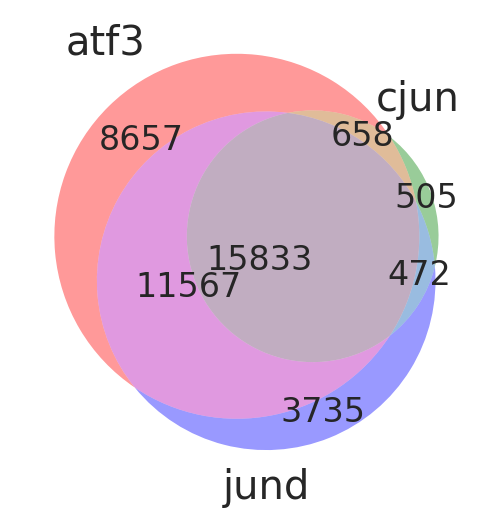

In [41]:
plt.figure(figsize=(3,3))
atf3_indices = set(summary_frame[summary_frame['c57bl6_atf3_kla'] > 0].index.values)
cjun_indices = set(summary_frame[summary_frame['c57bl6_cjun_kla'] > 0].index.values)
jund_indices = set(summary_frame[summary_frame['c57bl6_jund_kla'] > 0].index.values)
matplotlib_venn.venn3([atf3_indices, cjun_indices, jund_indices], set_labels=['atf3', 'cjun', 'jund'])
plt.savefig('./figures/figure_02_monomer_venn_kla.svg',  bbox_inches='tight')

### Enrichment of Cre vs Tre Motif

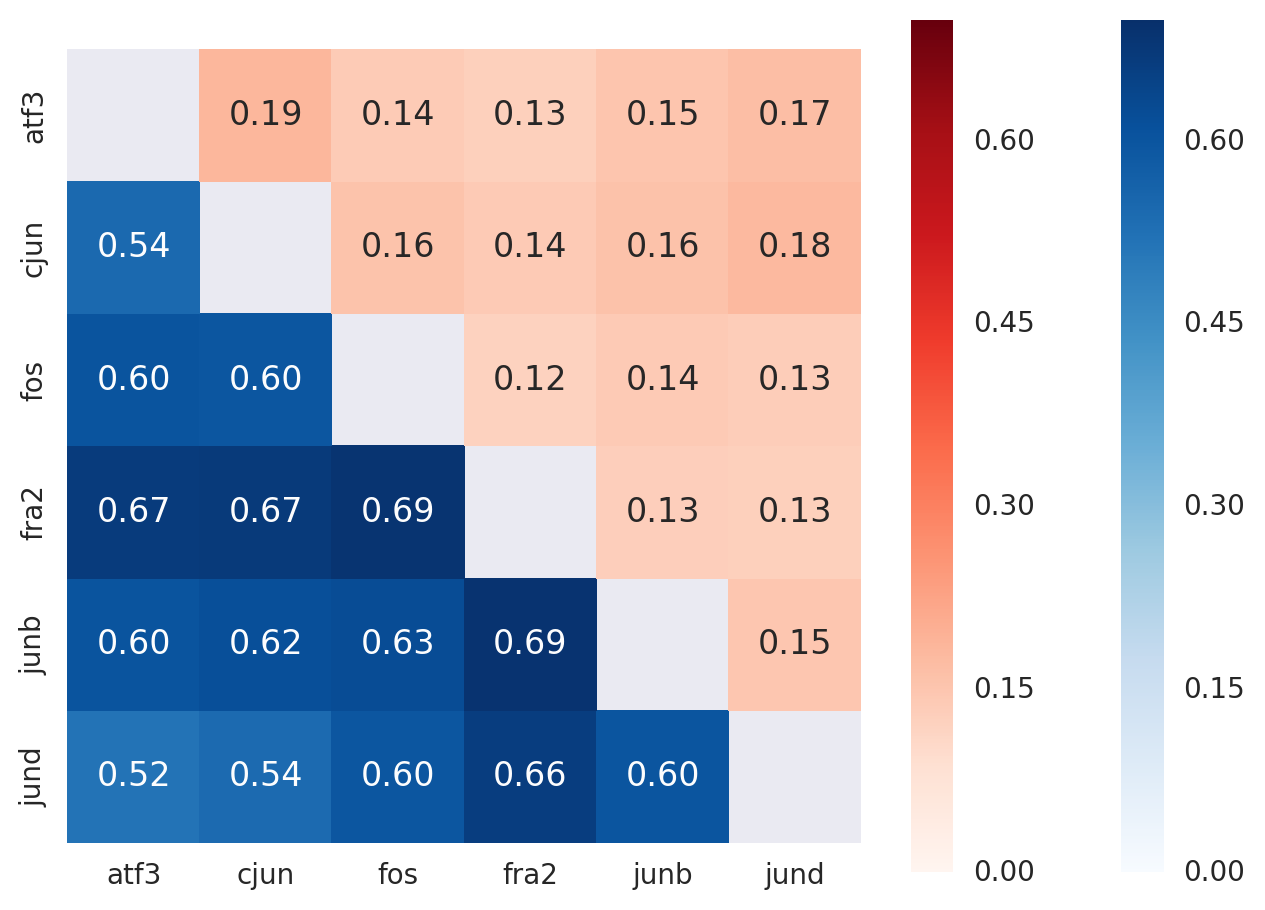

In [42]:
# TRE - one spacer motif
# CRE - two spacer motif
# motif_score_frame['ap-1'] # TRE motif
# motif_score_frame['atf7_batf3_creb5'] # CRE motif
threshold = 5
monomers = ['atf3_kla', 'cjun_kla', 'fos_kla', 'fra2_kla', 'junb_kla', 'jund_kla']
c57bl6_columns = ['c57bl6_' + x  for x in monomers]
monomer_index_dict = dict(zip(monomers, 
                              range(len(monomers))))
tre_matrix = np.zeros((len(monomers), len(monomers)))
cre_matrix = np.zeros((len(monomers), len(monomers)))
# monomer_1 occupies which fraction of monomer_2
for monomer_1 in monomers:
    monomer_1_indices = set(summary_frame[summary_frame['c57bl6_' + monomer_1] > 0].index.values)
    ind_1 = monomer_index_dict[monomer_1]
    for monomer_2 in monomers:
        ind_2 = monomer_index_dict[monomer_2]
        if not ind_1 == ind_2:
            # look for monomers
            monomer_2_indices = set(summary_frame[summary_frame['c57bl6_' + monomer_2] > 0].index.values)
            intersection_indices = monomer_1_indices.intersection(monomer_2_indices)
        else:
            monomer_2_indices = set(summary_frame[summary_frame['c57bl6_' + monomer_2] > 0].index.values)
            intersection_indices = monomer_1_indices.intersection(monomer_2_indices)
        tre_scores = motif_score_frame.ix[intersection_indices, 'ap-1'].values
        cre_scores = motif_score_frame.ix[intersection_indices, 'atf7_batf3_creb5'].values

        tre_fraction = np.sum(tre_scores >= threshold)/len(tre_scores)
        cre_fraction = np.sum(cre_scores >= threshold)/len(cre_scores)

        tre_matrix[ind_2][ind_1] = tre_fraction
        cre_matrix[ind_1][ind_2] = cre_fraction
#             print(monomer_1, monomer_2, 'tre_fraction', tre_fraction, 'cre_fraction',cre_fraction)
        

labels = [x.replace('_kla','') for x in monomers]
# plot TRE fractions
mask = np.zeros_like(tre_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# for i in range(mask.shape[0]):
#     mask[i][i] = False
    
sns.heatmap(tre_matrix, 
            yticklabels=labels,
            xticklabels=labels,
            mask=mask,
            square=True,
            annot=True,
            fmt='0.2f',
            cmap='Blues',
            vmin=0,
            vmax=0.7)


mask = np.ones_like(cre_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = False
for i in range(mask.shape[0]):
    mask[i][i] = True
sns.heatmap(cre_matrix, 
            yticklabels=labels,
            xticklabels=labels,
            mask=mask,
            square=True,
            annot=True,
            fmt='0.2f',
            cmap='Reds',
            vmin=0,
            vmax=0.7)
plt.savefig('./figures/figure_02_cre_tre_matrix.svg',  bbox_inches='tight')

### Fraction of Unique Peaks

#### Vehicle

atf3
cjun
jund


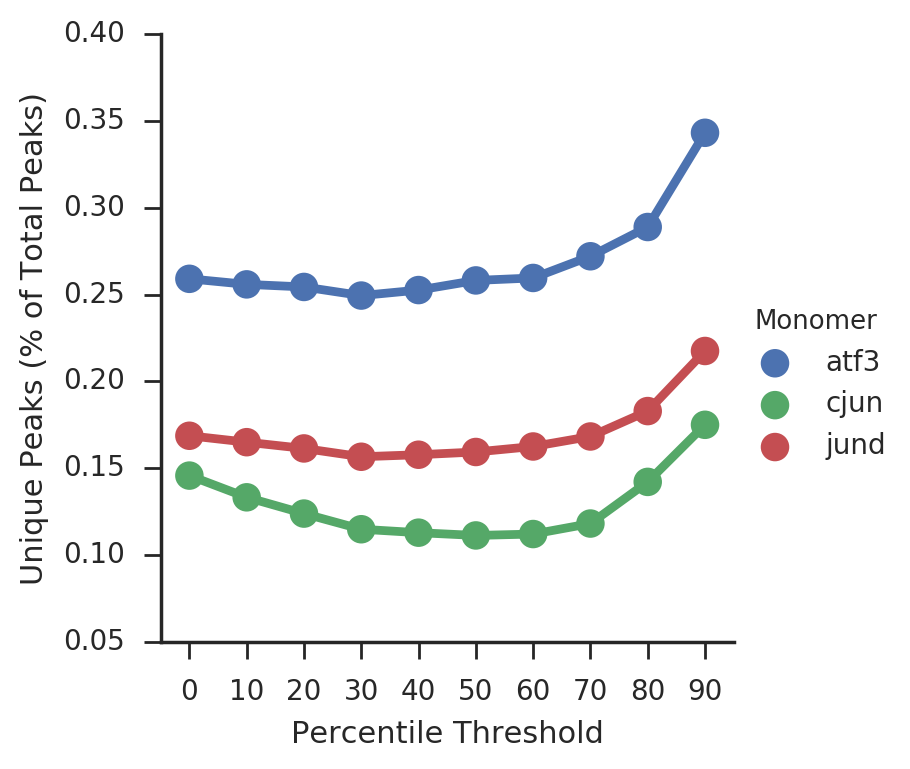

In [44]:
fraction_list = []
threshold_list = []
factor_list = []
thresholds = np.arange(0,100,10)
strain = 'c57bl6'
treatment = 'veh'
factors = ['atf3', 'cjun', 'jund']
for factor in factors:
    print(factor)
    factor_indices = set(summary_frame[summary_frame['_'.join([strain, factor, treatment])] > 0].index.values)
    factor_tagCounts = ap1_meanTag_frame[ap1_meanTag_frame.index.isin(factor_indices)]['_'.join([strain, factor, treatment])]
    
    for threshold in thresholds:
        factor_threshold = np.percentile(factor_tagCounts, threshold)
        factor_filtered_indices = set(factor_tagCounts[factor_tagCounts >= factor_threshold].index.values)
        
        other_filtered_indices = set()
        for of in factors:
            if not of == factor:
                of_indices = set(summary_frame[summary_frame['_'.join([strain, of, treatment])] > 0].index.values)
                of_tagCounts = ap1_meanTag_frame[ap1_meanTag_frame.index.isin(of_indices)]['_'.join([strain, of, treatment])]
                
                of_threshold = np.percentile(of_tagCounts, threshold)
                of_filtered_indices = set(of_tagCounts[of_tagCounts >= of_threshold].index.values)

                other_filtered_indices = other_filtered_indices.union(of_filtered_indices)

        factor_unique_indices = factor_filtered_indices - other_filtered_indices
        unique_fraction = len(factor_unique_indices)/len(factor_filtered_indices)
        
        fraction_list.append(unique_fraction)
        threshold_list.append(threshold)
        factor_list.append(factor)
frame = pd.DataFrame({'Unique Peaks (% of Total Peaks)':fraction_list,
                      'Percentile Threshold':threshold_list,
                      'Monomer':factor_list}, 
                     )
with sns.axes_style('ticks'):
    sns.factorplot(data=frame, x = 'Percentile Threshold', y='Unique Peaks (% of Total Peaks)', hue='Monomer')
    plt.savefig('./figures/figure_02_unique_peak_fraction_veh.svg')



#### KLA

atf3
cjun
fos
fra2
junb
jund


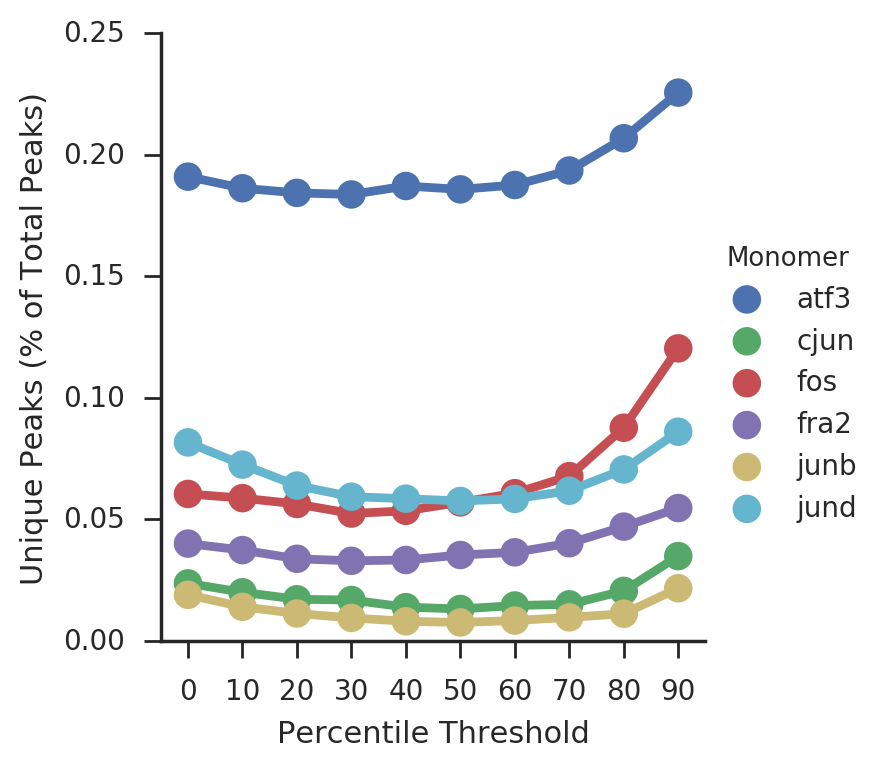

In [45]:
fraction_list = []
threshold_list = []
factor_list = []
thresholds = np.arange(0,100,10)
strain = 'c57bl6'
treatment = 'kla'
factors = ['atf3', 'cjun', 'fos', 'fra2', 'junb', 'jund']
# factors = ['atf3', 'cjun', 'jund']


for factor in factors:
    print(factor)
    factor_indices = set(summary_frame[summary_frame['_'.join([strain, factor, treatment])] > 0].index.values)
    factor_tagCounts = ap1_meanTag_frame[ap1_meanTag_frame.index.isin(factor_indices)]['_'.join([strain, factor, treatment])]
    
    for threshold in thresholds:
        factor_threshold = np.percentile(factor_tagCounts, threshold)
        factor_filtered_indices = set(factor_tagCounts[factor_tagCounts >= factor_threshold].index.values)
        
        other_filtered_indices = set()
        for of in factors:
            if not of == factor:
                of_indices = set(summary_frame[summary_frame['_'.join([strain, of, treatment])] > 0].index.values)
                of_tagCounts = ap1_meanTag_frame[ap1_meanTag_frame.index.isin(of_indices)]['_'.join([strain, of, treatment])]
                
                of_threshold = np.percentile(of_tagCounts, threshold)
                of_filtered_indices = set(of_tagCounts[of_tagCounts >= of_threshold].index.values)

                other_filtered_indices = other_filtered_indices.union(of_filtered_indices)

        factor_unique_indices = factor_filtered_indices - other_filtered_indices
        unique_fraction = len(factor_unique_indices)/len(factor_filtered_indices)
        
        fraction_list.append(unique_fraction)
        threshold_list.append(threshold)
        factor_list.append(factor)
frame = pd.DataFrame({'Unique Peaks (% of Total Peaks)':fraction_list,
                      'Percentile Threshold':threshold_list,
                      'Monomer':factor_list}, 
                     )
with sns.axes_style('ticks'):
    sns.factorplot(data=frame, x = 'Percentile Threshold', y='Unique Peaks (% of Total Peaks)', hue='Monomer')
    plt.ylim(0,0.25)
    plt.savefig('./figures/figure_02_unique_peak_fraction_kla.svg')



### Create Bed Files for Use with GREAT

In [46]:
outdir = './great_bed_files/'
if not os.path.isdir(outdir):
    os.mkdir(outdir)
else:
    for f in os.listdir(outdir):
        os.remove(outdir + '/' + f)
strain = 'c57bl6'
for treatment in ['veh', 'kla']:
    for monomer in ['atf3', 'cjun', 'fos', 'junb', 'jund']:
        position_frame = summary_frame[summary_frame[strain + '_' + monomer + '_' + treatment] > 0][['chr', 'start', 'end']]
        position_frame.to_csv(outdir + '/' + strain + '_' + monomer + '_' + treatment + '.bed', 
                              sep='\t', 
                              header = False,
                              index=False)

In [47]:
atf3_indices = set(summary_frame[summary_frame['c57bl6_atf3_veh'] > 0].index.values)
cjun_indices = set(summary_frame[summary_frame['c57bl6_cjun_veh'] > 0].index.values)
jund_indices = set(summary_frame[summary_frame['c57bl6_jund_veh'] > 0].index.values)

atf3_unique_indices = atf3_indices - (cjun_indices.union(jund_indices))
cjun_unique_indices = cjun_indices - (atf3_indices.union(jund_indices))
jund_unique_indices = jund_indices - (atf3_indices.union(cjun_indices))

position_frame = summary_frame[summary_frame.index.isin(atf3_unique_indices)][['chr', 'start', 'end']]
position_frame.to_csv(outdir + '/' + strain + '_unique_atf3_veh_' + treatment + '.bed', 
                      sep='\t', 
                      header = False,
                      index=False)
position_frame = summary_frame[summary_frame.index.isin(cjun_unique_indices)][['chr', 'start', 'end']]
position_frame.to_csv(outdir + '/' + strain + '_unique_cjun_veh_' + treatment + '.bed', 
                      sep='\t', 
                      header = False,
                      index=False)
position_frame = summary_frame[summary_frame.index.isin(jund_unique_indices)][['chr', 'start', 'end']]
position_frame.to_csv(outdir + '/' + strain + '_unique_jund_veh_' + treatment + '.bed', 
                      sep='\t', 
                      header = False,
                      index=False)

# Figure 3 - Machine Learning Overview

### Schematic of classifier workflow

## VIF Analysis for Features

In [44]:
def calculateVIF(features):
    '''
    calculates the VIF for each feature
    inputs: features, n X m (numSamples x numFeatures) vector of features
    output: VIFS, list of m VIFS
    '''
    vifs = []
    all_motifs = features.columns.values
    for motif in all_motifs:
        current_motif_scores = features[[motif]]
        other_motif_scores = features[[x for x in all_motifs if not x == motif]]
        lr = sklearn.linear_model.LinearRegression(n_jobs=-1)
        lr.fit(other_motif_scores, current_motif_scores)
        
        # calculate the coefficient of determination
        coeff_det = lr.score(other_motif_scores, current_motif_scores)
        # calculate VIF
        if coeff_det == 1:
            vif = 10
        else:
            vif = 1/(1-coeff_det)
        vifs.append(vif)
    toReturn = pd.Series(data = vifs, index = all_motifs)
    return toReturn

In [45]:
strain = 'c57bl6'
factorTreatment_vif_dict = {}

### calculate VIFs for vehicle data ###
treatment = 'veh'
ap1_members = ['atf3','cjun','jund']    
for factor in ap1_members:
    start = time.time()

    # merge target and background features together 
    features = monomer_treatment_standardized_features_dict[factor + '_' + treatment]
    print(factor, treatment, features.shape)
    vifs = calculateVIF(features)
    factorTreatment_vif_dict['_'.join([strain, factor, treatment])] = vifs
    end = time.time()
    print(factor, treatment, end - start)


### calculate VIFs for KLA data ###
treatment = 'kla'  
ap1_members = ['atf3','cjun', 'fos', 'fra2', 'junb','jund']    
for factor in ap1_members:
    start = time.time()
    features = monomer_treatment_standardized_features_dict[factor + '_' + treatment]
    print(factor, treatment, features.shape)
    vifs = calculateVIF(features)
    factorTreatment_vif_dict['_'.join([strain, factor, treatment])] = vifs
    end = time.time()
    print(factor, treatment, end - start)



atf3 veh (46262, 196)
atf3 veh 34.036980390548706
cjun veh (31070, 196)
cjun veh 22.394643783569336
jund veh (39248, 196)
jund veh 27.841918468475342
atf3 kla (73422, 196)
atf3 kla 54.82911038398743
cjun kla (34932, 196)
cjun kla 25.096773624420166
fos kla (48690, 196)
fos kla 33.90409016609192
fra2 kla (21218, 196)
fra2 kla 10.829406023025513
junb kla (26736, 196)
junb kla 19.400633335113525
jund kla (63210, 196)
jund kla 47.653138637542725


In [68]:
### calculate VIFs for vehicle data ###
factorTreatment_vif_unclustered_dict = {}
treatment = 'veh'
ap1_members = ['atf3','cjun','jund']    
for factor in ap1_members:
    start = time.time()

    # merge target and background features together 
    features = monomer_treatment_standardized_unclustered_features_dict[factor + '_' + treatment]
    print(factor, treatment, features.shape)
    vifs = calculateVIF(features)
    factorTreatment_vif_unclustered_dict['_'.join([strain + '_unclustered', factor, treatment])] = vifs
    end = time.time()
    print(factor, treatment, end - start)


### calculate VIFs for KLA data ###
treatment = 'kla'  
ap1_members = ['atf3','cjun', 'fos', 'fra2', 'junb','jund']    
for factor in ap1_members:
    start = time.time()
    features = monomer_treatment_standardized_unclustered_features_dict[factor + '_' + treatment]
    print(factor, treatment, features.shape)
    vifs = calculateVIF(features)
    factorTreatment_vif_unclustered_dict['_'.join([strain + '_unclustered', factor, treatment])] = vifs
    end = time.time()
    print(factor, treatment, end - start)



atf3 veh (46256, 519)
atf3 veh 315.8503806591034
cjun veh (31067, 519)
cjun veh 220.16932678222656
jund veh (39242, 519)
jund veh 278.7979235649109
atf3 kla (73414, 519)
atf3 kla 561.1550529003143
cjun kla (34924, 519)
cjun kla 247.06990003585815
fos kla (48683, 519)
fos kla 353.590674161911
fra2 kla (21215, 519)
fra2 kla 157.33467316627502
junb kla (26735, 519)
junb kla 189.81441807746887
jund kla (63205, 519)
jund kla 449.1656548976898


In [81]:
vif_frame = pd.DataFrame(factorTreatment_vif_dict)

frame = pd.DataFrame(vif_frame.stack(), columns = ['VIF'])
indices = vif_frame.stack().index.values
frame['Motif'] = [x[0] for x in indices]
frame['Factor'] = [x[1].split('_')[1] for x in indices]
frame['Treatment'] = [x[1].split('_')[2] for x in indices]
frame['Type'] = 'Merged Motifs'

In [85]:
vif_unclustered_frame = pd.DataFrame(factorTreatment_vif_unclustered_dict)

unclustered_frame = pd.DataFrame(vif_unclustered_frame.stack(), columns = ['VIF'])
indices = vif_unclustered_frame.stack().index.values
unclustered_frame['Motif'] = [x[0] for x in indices]
unclustered_frame['Factor'] = [x[1].split('_')[2] for x in indices]
unclustered_frame['Treatment'] = [x[1].split('_')[3] for x in indices]
unclustered_frame['Type'] = 'Jaspar Non-redudundant'

In [86]:
combined_frame = pd.concat([frame, unclustered_frame])

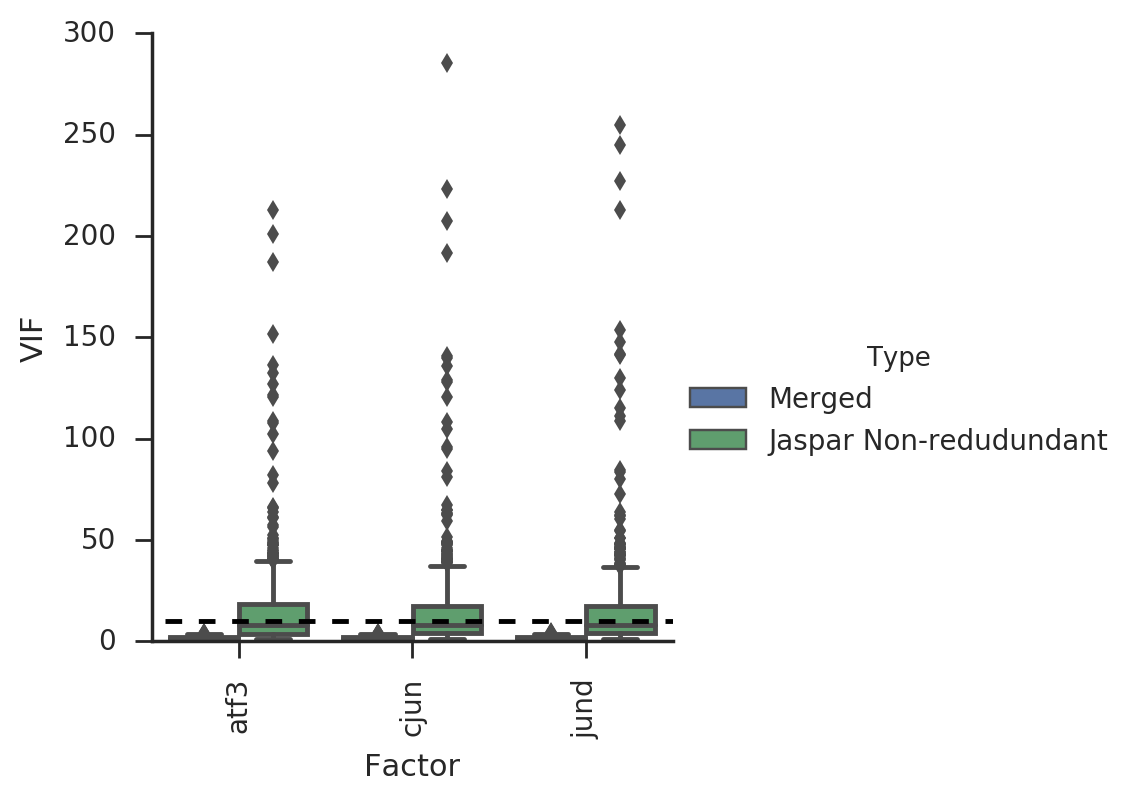

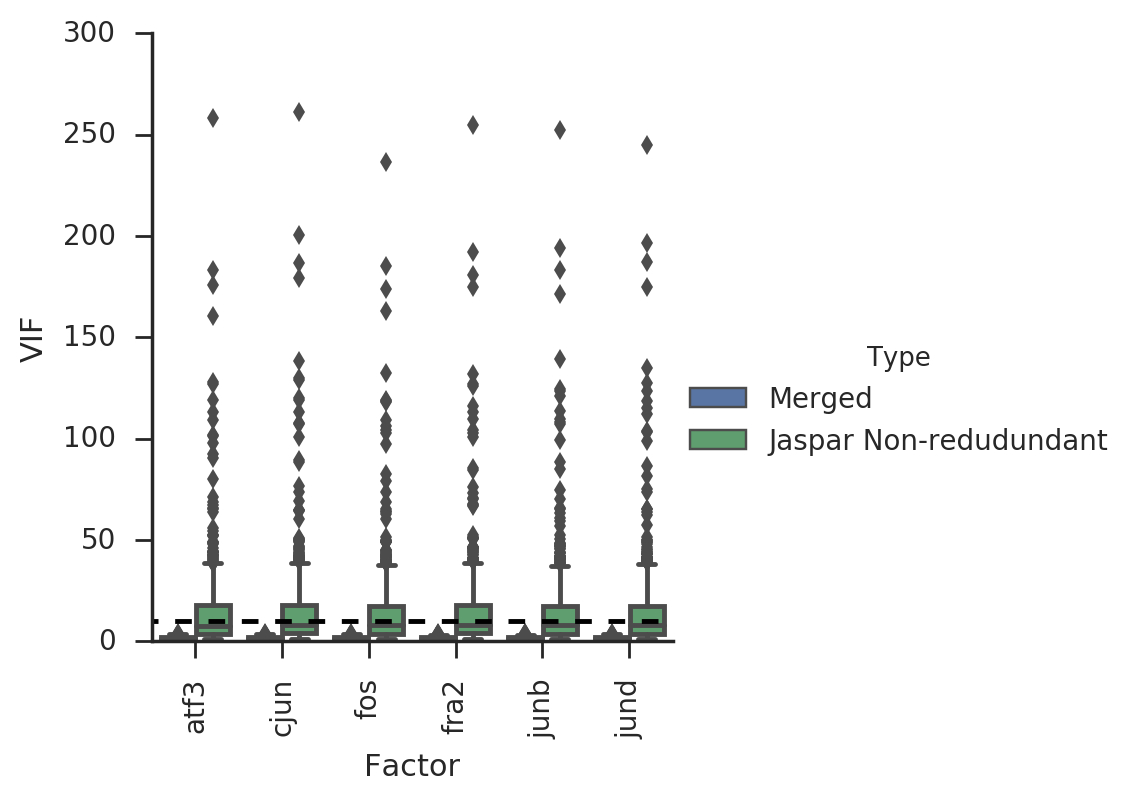

In [97]:
with sns.axes_style('ticks'):
    sns.factorplot(data = combined_frame[combined_frame['Treatment'] == 'veh'],
                   x = 'Factor',
                   y = 'VIF',
                   kind = 'box',
                   size=4,
                   hue = 'Type'
                  )
plt.ylim(0,300)
plt.xticks(rotation=90)
plt.plot([-1,3], [10,10], c = 'black', linestyle='--')
plt.savefig('./figures/figure_04_vif_analysis_veh.pdf', bbox_inches='tight')


with sns.axes_style('ticks'):
    sns.factorplot(data = combined_frame[combined_frame['Treatment'] == 'kla'],
                   x = 'Factor',
                   y = 'VIF',
                   kind = 'box',
                   size=4,
                   hue = 'Type'
                  )
plt.ylim(0,300)
plt.xticks(rotation=90)
plt.plot([-1,7], [10,10], c = 'black', linestyle='--')
plt.savefig('./figures/figure_04_vif_analysis_kla.pdf', bbox_inches='tight')


# Figure 4 - Motifs for Vehicle Dimers

### All Motifs

In [ ]:
numIterations = 100
test_size = 0.2
ap1_members = ['atf3','cjun', 'fos', 'fra2', 'junb','jund']    
factors = ['atf3','cjun', 'fos', 'junb','jund', 'cebpa', 'pu1', 'p65']

In [ ]:
# for monomers using the best motif scores for each motif
strain = 'c57bl6'

factor_coeff_dict = {}
factor_roc_dict = {}
factor_precision_dict = {}
factor_score_dict = {}
factor_testLabel_dict = {}

for treatment in ['veh', 'kla']:
    if treatment == 'veh':
        members = ['atf3', 'cjun', 'jund']
    else:
        members = ['atf3', 'cjun', 'fos', 'fra2', 'junb', 'jund']
    for monomer in members:
        features = monomer_treatment_standardized_features_dict[monomer + '_' + treatment]
        labels = pd.Series([False if 'background' in x else True for x in features.index.values],
                           index = features.index.values)
        print(np.sum(labels), len(labels))
                
        results = train_classifier(features, 
                                    labels,
                                    numIterations = numIterations,
                                    test_size = test_size,
                                    )
        # unpack result tuples
        all_rocs = results[0]
        all_precisions = results[1]
        all_coefficients = results[2]
        all_scores = results[3]
        all_testLabels = results[4]
        
        factor_roc_dict[monomer + '_' + treatment] = all_rocs
        factor_precision_dict[monomer + '_' + treatment] = all_precisions
        factor_coeff_dict[monomer + '_' + treatment] = all_coefficients
        factor_score_dict[monomer + '_' + treatment] = all_scores
        factor_testLabel_dict[monomer + '_' + treatment] = all_testLabels
        print(monomer + '_' + treatment,
              'roc:', np.mean(all_rocs),
              'precision:', np.mean(all_precisions),
             )

23131 46262


In [29]:
mean_coeff_frame = calculate_mean_weights(factor_coeff_dict,
                                  motif_score_frame.columns.values[3:])

mean_coeff_frame.to_pickle('mean_coeff_frame.pickle')



### AP-1 Motif Only

In [54]:
# for monomers using motif counts and best motif score 
strain = 'c57bl6'

factor_roc_ap1Only_dict = {}
factor_precision_ap1Only_dict = {}
factor_scores_ap1Only_dict = {}
factor_testLabel_ap1Only_dict = {}

for treatment in ['veh', 'kla']:
    if treatment == 'veh':
        members = ['atf3', 'cjun', 'jund']
    else:
        members = ['atf3', 'cjun', 'fos', 'fra2', 'junb', 'jund']
    for monomer in members:
        features = monomer_treatment_standardized_features_dict[monomer + '_' + treatment][['ap-1','atf7_batf3_creb5']]
        labels = pd.Series([False if 'background' in x else True for x in features.index.values],
                           index = features.index.values)
        print(np.sum(labels), len(labels))
                
        results = train_classifier(features, 
                                    labels,
                                    numIterations = 5,
                                    test_size = test_size,
                                    )
        # unpack result tuples
        all_rocs = results[0]
        all_precisions = results[1]
        all_coefficients = results[2]
        all_scores = results[3]
        all_testLabels = results[4]
        
        factor_roc_ap1Only_dict[monomer + '_' + treatment] = all_rocs
        factor_precision_ap1Only_dict[monomer + '_' + treatment] = all_precisions
        factor_scores_ap1Only_dict[monomer + '_' + treatment] = all_scores
        factor_testLabel_ap1Only_dict[monomer + '_' + treatment] = all_testLabels
        
        print(monomer + '_' + treatment,
              'roc:', np.mean(all_rocs),
              'precision:', np.mean(all_precisions),
              all_coefficients
             )

23131 46262
atf3_veh roc: 0.783522206812 precision: 0.801737281859 [array([ 1.02752824,  0.9686372 ]), array([ 1.0246095 ,  0.96066382]), array([ 1.02367965,  0.9493847 ]), array([ 1.02605985,  0.96229443]), array([ 1.019697  ,  0.95614653])]
15535 31070
cjun_veh roc: 0.79596121552 precision: 0.818510201135 [array([ 1.1554335 ,  0.88456618]), array([ 1.15142647,  0.88497924]), array([ 1.1337046 ,  0.87469164]), array([ 1.15010967,  0.89598374]), array([ 1.14481881,  0.88470219])]
19624 39248
jund_veh roc: 0.760512163577 precision: 0.791470634503 [array([ 1.00539201,  0.7463421 ]), array([ 1.01171639,  0.74880239]), array([ 1.0045094 ,  0.73028297]), array([ 1.01097982,  0.76956851]), array([ 1.02102311,  0.75333483])]
36711 73422
atf3_kla roc: 0.802316929029 precision: 0.820404709479 [array([ 1.17535861,  0.89566771]), array([ 1.1681532 ,  0.89356822]), array([ 1.16430358,  0.89401484]), array([ 1.16018318,  0.89190863]), array([ 1.16912795,  0.90481978])]
17466 34932
cjun_kla roc: 0.8

### Top Motif

#### Fraction of top motifs that are unique to each monomer

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:13: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting
/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:23: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting


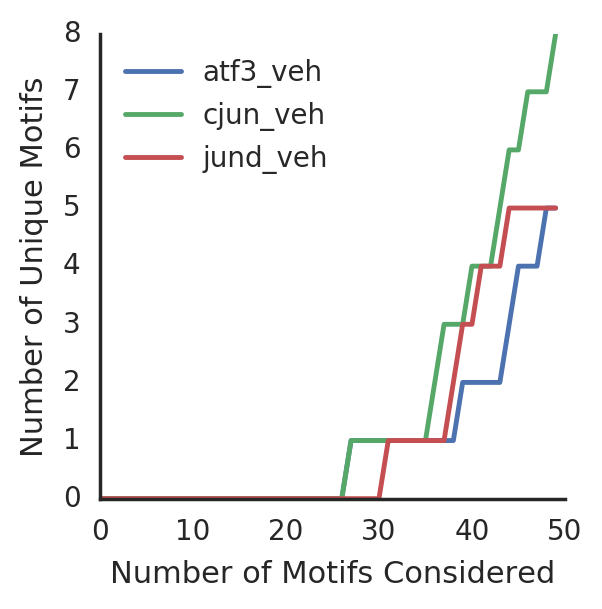

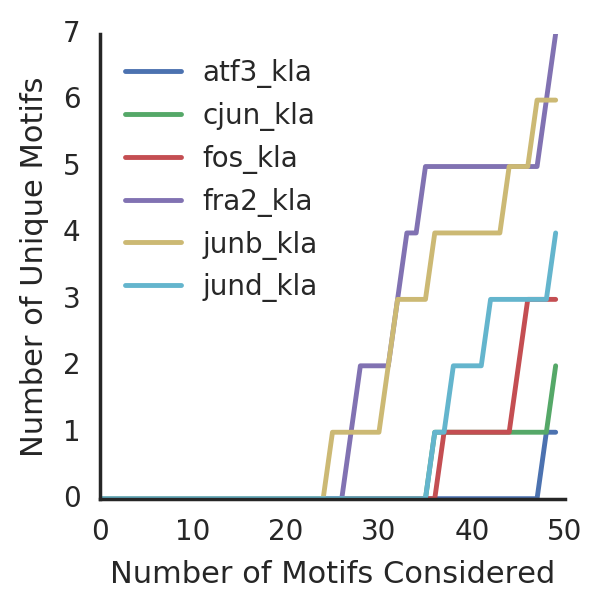

In [31]:
total_motifs = 50
thresholds = range(total_motifs)

for treatment in ['veh', 'kla']:
    if treatment == 'veh':
        members = ['atf3', 'cjun', 'jund']
    else:
        members = ['atf3', 'cjun', 'fos', 'fra2', 'junb', 'jund']
    plt.figure(figsize=(3,3))
    for monomer in members:
        fraction_list = []
        weights = mean_coeff_frame[monomer + '_' + treatment].abs()
        weights.sort(ascending=False)
        sorted_motifs = list(weights.index.values)
        
        for num_motifs in thresholds:
            current_motifs = sorted_motifs[:total_motifs]
            current_unique_motifs = set(current_motifs)
        
            for of in members:
                if not of == monomer:
                    other_weights = mean_coeff_frame[of + '_' + treatment].abs()
                    other_weights.sort(ascending=False)
                    other_motifs = set(list(other_weights.index.values)[:total_motifs])               
                    current_unique_motifs = current_unique_motifs - other_motifs

            selected_motifs = current_motifs[:num_motifs]
            selected_unique_motifs = set(selected_motifs).intersection(current_unique_motifs)
            unique_fraction = len(selected_unique_motifs)/max(1,len(current_unique_motifs))

            fraction_list.append(len(selected_unique_motifs))
        with sns.axes_style('white'):
            plt.plot(thresholds, fraction_list, label = monomer + '_' + treatment)
    plt.legend(loc = 'upper left')
    plt.xlabel('Number of Motifs Considered')
    plt.ylabel('Number of Unique Motifs')
    sns.despine()
    plt.savefig('./figures/figure_04_unique_motifs_' + treatment +'.svg', bbox_inches='tight')
    plt.show()


#### Overlap of Top Motifs

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting


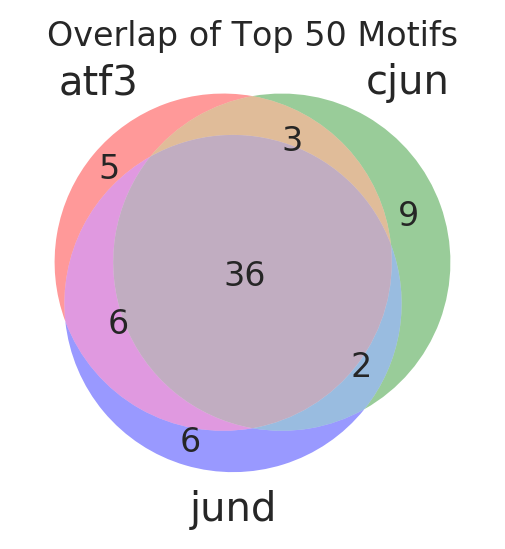

In [32]:
total_motifs = 50
treatment = 'veh'
members = ['atf3', 'cjun', 'jund']
sets = []
labels = []
plt.figure(figsize=(3,3))
for monomer in members:
    fraction_list = []
    weights = mean_coeff_frame[monomer + '_' + treatment].abs()
    weights.sort(ascending=False)
    sorted_motifs = list(weights.index.values)

    current_motifs = sorted_motifs[:total_motifs]
    current_unique_motifs = set(current_motifs)
    sets.append(current_unique_motifs)
    labels.append(monomer)
matplotlib_venn.venn3(sets, set_labels=labels)
plt.title('Overlap of Top ' + str(total_motifs) + ' Motifs')
plt.savefig('./figures/figure_04_unique_motifs_veh_venn_top50.svg', bbox_inches='tight')

#### Train Model on Top Motifs

In [33]:
# for monomers using motif counts and best motif score for top motifs
strain = 'c57bl6'
num_motifs_threshold = 20
factor_roc_top_dict = {}
factor_precision_top_dict = {}
factor_scores_top_dict = {}
factor_testLabel_top_dict = {}

        
for treatment in ['veh', 'kla']:
    if treatment == 'veh':
        members = ['atf3', 'cjun', 'jund']
    else:
        members = ['atf3', 'cjun', 'fos', 'fra2', 'junb', 'jund']
    for monomer in members:
        # determine top motifs
        weights = mean_coeff_frame[monomer + '_' + treatment].abs()
        weights.sort(ascending=False)
        sorted_motifs = list(weights.index.values)
        top_motifs = sorted_motifs[:num_motifs_threshold]
        print(len(top_motifs))
        
        features = monomer_treatment_standardized_features_dict[monomer + '_' + treatment][top_motifs]
        labels = pd.Series([False if 'background' in x else True for x in features.index.values],
                           index = features.index.values)
        
        results = train_classifier(features, 
                                    labels,
                                    numIterations = 5,
                                    test_size = test_size,
                                    )
        # unpack result tuples
        all_rocs = results[0]
        all_precisions = results[1]
        all_coefficients = results[2]
        all_scores = results[3]
        all_testLabels = results[4]
        
        factor_roc_top_dict[monomer + '_' + treatment] = all_rocs
        factor_precision_top_dict[monomer + '_' + treatment] = all_precisions
        factor_testLabel_top_dict[monomer + '_' + treatment] = all_testLabels

        print(monomer + '_' + treatment,
              'roc:', np.mean(all_rocs),
              'precision:', np.mean(all_precisions),
             )

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:18: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting


20
atf3_veh roc: 0.927170488813 precision: 0.923119303389
20
cjun_veh roc: 0.925556130249 precision: 0.923858940115
20
jund_veh roc: 0.923288604 precision: 0.919517178094
20
atf3_kla roc: 0.920751153258 precision: 0.914921828321
20
cjun_kla roc: 0.932377951703 precision: 0.929815785115
20
fos_kla roc: 0.933964416912 precision: 0.931336599525
20
fra2_kla roc: 0.935906276955 precision: 0.93578259716
20
junb_kla roc: 0.938367805662 precision: 0.935887983009
20
jund_kla roc: 0.919587258088 precision: 0.914610264447


### gkmSVM

In [599]:
!if [ ! -d ./gkmsvm_files ]; then mkdir ./gkmsvm_files; fi


In [600]:
! rm ./gkmsvm_files/*

In [601]:
numIterations = 5
test_size = 0.2
background_ratio = 1.0
ap1_members = ['atf3','cjun', 'fos', 'fra2', 'junb','jund']    
factors = ['atf3','cjun', 'fos', 'junb','jund', 'cebpa', 'pu1', 'p65']

In [602]:
### for all peaks in vehicle using gapped k-mers on background data
### write script
background_ratio = 1.0
numIterations = 5
for treatment in ['veh', 'kla']:
    script_file = open('gkmsvm_' + treatment + '.sh', 'w')
    for monomer in ap1_members:
        target_indices = summary_frame[summary_frame[strain + '_' + monomer + '_' + treatment] > 0.0].index.values
        background_indices = motif_score_background_frame[
            motif_score_background_frame['Factors'] == strain + '_' + monomer + '_' + treatment + '-background'].index.values

        shuffle(background_indices)
        background_indices = background_indices[:np.ceil(background_ratio*len(target_indices))]
        
        target_features = all_score_frame[all_score_frame.index.isin(target_indices)]
        background_features = all_score_frame[all_score_frame.index.isin(background_indices)]
        
        # merge target and background features together 
        features = pd.concat([target_features, background_features])
        labels = pd.Series(data = [True] * len(target_indices) + [False] * len(background_indices),
                           index = features.index.values)

        if np.sum(labels) > 100:
            print(monomer + '_' + treatment)
            all_aucs = []
            all_precisions = []
            for iteration in range(numIterations):  
                # split data into training and test sets
                training_features, test_features, training_labels, test_labels = get_split(
                    features, labels, test_size = test_size)

                # create fasta files for positive and negative sequences
                training_positive_path = './gkmsvm_files/' + monomer + '_' + treatment+ '_training_positive_' +str(iteration) + '.fa'
                training_negative_path = './gkmsvm_files/' + monomer + '_' + treatment+ '_training_negative_' +str(iteration) + '.fa'

                training_positive_file = open(training_positive_path,'w' )
                training_negative_file = open(training_negative_path,'w' )
                test_path = './gkmsvm_files/' + monomer + '_' + treatment+ '_test_' + str(iteration) + '.fa'

                test_file = open(test_path,'w')

                numPositiveSeqs = np.sum(training_labels)
                count=0
                for i in range(len(training_labels)):
                    index = training_labels.index[i]
                    label = training_labels[i]
                    seq = _id_sequence_dict[index]

                    if label == True:
                        training_positive_file.write('>' + index + '\n')
                        training_positive_file.write(seq + '\n')
                    else:
                        training_negative_file.write('>' + index + '\n')
                        training_negative_file.write(seq + '\n')
                        count+=1
                for i in range(len(test_labels)):
                    index = test_labels.index[i]
                    label = test_labels[i]
                    seq = _id_sequence_dict[index]
                    test_file.write('>' + index + '\n')
                    test_file.write(seq + '\n')

                training_positive_file.close()
                training_negative_file.close()
                test_file.close()

                #  Run classifier
                model_prefix = './gkmsvm_files/' + monomer + '_' + treatment + '_' +str(iteration)
                model_path = model_prefix + '.model.txt'
                results_path = model_prefix + '_results.txt'

                script_file.write('(gkmtrain '+ training_positive_path + ' ' + training_negative_path + ' ' + model_prefix +
                          ' -T 8 -m 64000;')
                if iteration == (numIterations - 1):
                    script_file.write('gkmpredict '+ test_path + ' ' + model_path + ' ' +  results_path + ' -T 8)\n')
                else:
                    script_file.write('gkmpredict '+ test_path + ' ' + model_path + ' ' +  results_path + ' -T 8)&\n')
                
    script_file.close()

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


atf3_veh
cjun_veh
fos_veh
fra2_veh
junb_veh
jund_veh
atf3_kla
cjun_kla
fos_kla
fra2_kla
junb_kla
jund_kla


In [ ]:
# %%bash
# chmod a+x ./gkmsvm_veh.sh 
# ./gkmsvm_veh.sh

In [ ]:
# %%bash
# chmod a+x ./gkmsvm_kla.sh 
# ./gkmsvm_kla.sh

In [ ]:
### for all peaks in vehicle using gapped k-mers on background data
### read performance
factor_auc_dict_gkmSVM = {}
factor_precision_dict_gkmSVM = {}

for treatment in ['veh', 'kla']:
    for monomer in ap1_members:
        target_indices = summary_frame[summary_frame[strain + '_' + monomer + '_' + treatment] > 0.0].index.values
        background_indices = motif_score_background_frame.index.values

        target_features = all_score_frame[all_score_frame.index.isin(target_indices)]
        background_features = all_score_frame[all_score_frame.index.isin(background_indices)]
        
        # merge target and background features together 
        features = pd.concat([target_features, background_features])
        labels = pd.Series(data = [True] * len(target_indices) + [False] * len(background_indices),
                           index = features.index.values)

        if np.sum(labels) > 100:
            print(monomer + '_' + treatment)
            all_aucs = []
            all_precisions = []
            for iteration in range(numIterations):  
                model_prefix = './gkmsvm_files/' + monomer  + '_' + treatment+ '_' +str(iteration)
                results_path = model_prefix + '_results.txt'


                index_score_dict = {} #{peakID: gkmSVM score}
                with open(results_path) as f:
                    data = f.readlines()
                for line in data:
                    tokens=line.strip().split()
                    score = float(tokens[1])
                    index = tokens[0]
                    index_score_dict[index] = score
                # define true labels
                index_label_dict = dict(zip(labels.index.values, labels.values))

                sorted_indices = sorted(index_score_dict.keys())

                sorted_scores = np.array([index_score_dict[x] for x in sorted_indices])
                test_labels = np.array([index_label_dict[x] for x in sorted_indices])

                min_score = np.min(sorted_scores)
                if min_score < 0:
                    normalized_scores = sorted_scores + abs(min_score)
                normalized_scores = normalized_scores/np.max(normalized_scores)
                normalized_scores = sorted_scores
                # score predictions  

                current_roc_auc = sklearn.metrics.roc_auc_score(test_labels, normalized_scores, average = None)
                current_precision = sklearn.metrics.average_precision_score(test_labels, normalized_scores, average = None)
                all_precisions.append(current_precision)
                all_aucs.append(current_roc_auc)

            # average scoring metrics 

            mean_roc_auc = np.mean(all_aucs) 
            mean_precision = np.mean(all_precisions)

            factor_auc_dict_gkmSVM[monomer + '_' + treatment]= all_aucs
            factor_precision_dict_gkmSVM[monomer + '_' + treatment]= all_precisions

            print(monomer + '_' + treatment,
                  'roc:', mean_roc_auc, 
                  'precision:', mean_precision,
                  'numTestPositives:', np.sum(test_labels)
                 )

### Motif Scores

In [ ]:
background_ratio = 1.0
ap1_members = ['atf3','cjun', 'fos', 'fra2', 'junb','jund']    
factors = ['atf3','cjun', 'fos', 'junb','jund', 'cebpa', 'pu1', 'p65']

In [ ]:
factor_auc_dict_motifScore = {}
factor_precision_dict_motifScore = {}
strain = 'c57bl6'

for treatment in ['veh', 'kla']:
    for monomer in ap1_members:    

        target_indices = summary_frame[summary_frame[strain + '_' + monomer + '_' + treatment] > 0.0].index.values
        background_indices = motif_score_background_frame[
            motif_score_background_frame['Factors'] == strain + '_' + monomer + '_' + treatment + '-background'].index.values

        # select subset of background indices to use
        shuffle(background_indices)
        background_indices = background_indices[:np.ceil(background_ratio*len(target_indices))]
        
        target_features = motif_score_frame[motif_score_frame.index.isin(target_indices)][['ap-1']]
        background_features = motif_score_background_frame[motif_score_background_frame.index.isin(background_indices)][['ap-1']]
        
        # merge target and background features together 
        features = pd.concat([target_features, background_features])
        labels = pd.Series(data = [True] * len(target_indices) + [False] * len(background_indices),
                   index = features.index.values)

        roc_pwm = sklearn.metrics.roc_auc_score(labels, features)
        precision_pwm = sklearn.metrics.roc_auc_score(labels, features)

        print(monomer, treatment, roc_pwm, precision_pwm)
        factor_auc_dict_motifScore[monomer + '_' + treatment]= [roc_pwm]
        factor_precision_dict_motifScore[monomer + '_' + treatment]= [precision_pwm]
    

### Bayesian Markov Models

In [ ]:
sequence_path = './individual_peak_sequences/'
if not os.path.isdir(sequence_path):
    os.mkdir(sequence_path)
else:
    for f in os.listdir(sequence_path):
        os.remove(sequence_path + '/' + f)
background_ratio = 1.0
for treatment in ['veh', 'kla']:
    for monomer in ap1_members:
        target_indices = summary_frame[summary_frame[strain + '_' + monomer + '_' + treatment] > 0.0].index.values
        background_indices = motif_score_background_frame[
            motif_score_background_frame['Factors'] == strain + '_' + monomer + '_' + treatment + '-background'].index.values

        background_indices = background_indices[:np.ceil(background_ratio*len(target_indices))]
        
        # write positive sequences
        positive_sequence_file = open(sequence_path + '/' + monomer + '_' + treatment + '.fasta', 'w')
        for ind in target_indices:
            seq = _id_sequence_dict[ind]
            positive_sequence_file.write('>'+ind+'\n')
            positive_sequence_file.write(seq + '\n')
        positive_sequence_file.close()
        
        # write negative sequences
        negative_sequence_file = open(sequence_path + '/' + monomer + '_' + treatment + '_background.fasta', 'w')
        for ind in background_indices:
            seq = _id_sequence_dict[ind]
            negative_sequence_file.write('>'+ind+'\n')
            negative_sequence_file.write(seq + '\n')
        negative_sequence_file.close()        
        
        

In [ ]:
%%bash
num_proc=20 # number of motifs to calculate at once

if [ ! -d ./bamm_output ]; then mkdir ./bamm_output; fi

script_path="./calculate_bamm.sh"
if [ -f $script_path ]; then rm $script_path; fi
counter=0
for neg_seq in ./individual_peak_sequences/*background*;
    # define output path
    do out_path=${neg_seq/individual_peak_sequences/bamm_output};
    out_path=${out_path/_background.fasta}
    if [ ! -d $out_path ]; then 
    counter=$[counter + 1]
    

    # find path to negative sequences
    pos_seq=${neg_seq/_background}

#     echo BaMMmotif $out_path $pos_seq --negSequenceSet $neg_seq --reverseComp --scorePosSequenceSet --scoreNegSequenceSet --maxPWMs 3 >>$script_path;
        if [ "$counter" -eq "$num_proc" ]; then
            echo "BaMMmotif $out_path $pos_seq --negSequenceSet $neg_seq --reverseComp --scorePosSequenceSet --scoreNegSequenceSet --maxPWMs 3" >>$script_path;
        else
            echo "BaMMmotif $out_path $pos_seq --negSequenceSet $neg_seq --reverseComp --scorePosSequenceSet --scoreNegSequenceSet --maxPWMs 3 &" >>$script_path;
        fi;
        if [ "$counter" -eq "$num_proc" ]; then counter=0; fi
    fi
done



In [ ]:
!bash ./calculate_bamm.sh

In [ ]:
# score BAMM performance
factor_auc_dict_bammScore = {}
factor_precision_dict_bammScore = {}

for treatment in ['veh', 'kla']:
    for monomer in ap1_members:           
        # read in positive scores
        positive_scores = []
        with open('./bamm_output/' + monomer + '_' + treatment +'/'+ monomer + '_' + treatment + '-1.logOdds') as f:
            data = f.readlines()

        for line in data:
            tokens = line.strip().split()
            log_odds = [float(x) if not x =='NA' else 0.0 for x in tokens]
            positive_scores.append(max(log_odds))
        
        # read in negative scores
        negative_scores = []
        with open('./bamm_output/' + monomer + '_' + treatment +'/'+ monomer + '_' + treatment + '_background-1.logOdds') as f:
            data = f.readlines()
        for line in data:
            tokens = line.strip().split()
            log_odds = [float(x) if not x =='NA' else 0.0 for x in tokens]
            negative_scores.append(max(log_odds))
        
        labels = [True] * len(positive_scores) + [False] * len(negative_scores)
        scores = positive_scores + negative_scores
        roc_bamm = sklearn.metrics.roc_auc_score(labels, scores)
        precision_bamm = sklearn.metrics.roc_auc_score(labels, scores)
        
        factor_auc_dict_bammScore[monomer + '_' + treatment] = [roc_bamm]
        factor_precision_dict_bammScore[monomer + '_' + treatment] = [precision_bamm]
        
        print(monomer, treatment, roc_bamm, precision_bamm) 

## Compare Performance with Different numbers of motifs

### Greedy Forward Feature Selection

In [ ]:
# strain = 'c57bl6'
# numIterations = 1
# test_size = 0.2
# background_ratio = 1.0
# ap1_members = ['atf3','cjun', 'fos', 'fra2', 'junb','jund']    
# num_to_select = 50

# factor_roc_forward_dict = {}

# for treatment in ['veh', 'kla']:
#     for monomer in ap1_members:
#         print('***starting selection for',monomer, treatment)
#         selected_motifs = []
#         performances = []
#         motifs_to_consider = sorted(list(all_standardized_score_frame.columns.values))
        
#         while len(motifs_to_consider) > 0 and len(selected_motifs) < num_to_select:
#             best_motif = None
#             best_performance = -1

#             for motif in motifs_to_consider:
#                 motifs_to_use = selected_motifs + [motif]
#                 target_features = all_standardized_score_frame[
#                     all_standardized_score_frame.index.isin(target_indices)][motifs_to_use]
#                 background_features = all_standardized_score_frame[
#                     all_standardized_score_frame.index.isin(background_indices)][motifs_to_use]

#                 # merge target and background features together 
#                 features = pd.concat([target_features, background_features])

#                 labels = pd.Series(data = [True] * len(target_indices) + [False] * len(background_indices),
#                                    index = features.index.values)

#                 results = train_classifier(features, 
#                                             labels,
#                                             numIterations = numIterations,
#                                             test_size = test_size,
#                                             )
#                 # unpack result tuples
#                 all_rocs = results[0]
#                 all_precisions = results[1]

#                 mean_roc = np.mean(all_rocs)

#                 if mean_roc > best_performance:
#                     best_performance = mean_roc
#                     best_motif = motif
#             performances.append(best_performance)
#             selected_motifs.append(best_motif)
#             motifs_to_consider.remove(best_motif)
            
#             print('selection made', monomer, treatment, len(selected_motifs), best_performance, best_motif, )
#         factor_roc_forward_dict[monomer + '_' + treatment] = list(zip(selected_motifs, performances))

***starting selection for atf3 veh
selection made atf3 veh 1 0.739249552213 ap-1
selection made atf3 veh 2 0.811470174254 elk_etv
selection made atf3 veh 3 0.844881179505 atf7_batf3_creb5
selection made atf3 veh 4 0.863278142411 cebp
selection made atf3 veh 5 0.882074815744 spi1-c


In [ ]:
if "factor_roc_forward_dict" in locals():
    if len(factor_roc_forward_dict) > 1:
        pickle.dump(factor_roc_forward_dict, open('./factor_roc_forward_dict.pickle','wb'))
else:
    factor_roc_forward_dict = pickle.load(open('./factor_roc_forward_dict.pickle','rb'))

In [ ]:
with sns.axes_style('white'):
    for treatment in ['veh', 'kla']:
        plt.figure(figsize=(3,3))
        if treatment == 'veh':
            members = ['atf3', 'cjun', 'jund']
        else:
            members = ['atf3', 'cjun', 'fos', 'fra2', 'junb', 'jund']
        for monomer in members:
            key = monomer + '_' + treatment
            rocs = [x[1] for x in factor_roc_forward_dict[key]]
            motifs = [x[0] for x in factor_roc_forward_dict[key]]
            plt.plot(range(len(rocs)), rocs, label = key)
            plt.xlabel('Motifs Included in Model')
            plt.ylabel('Model Performance')
            plt.xlim(0,50)
            plt.ylim(0.5,0.95)
            # Fix axes
            ax = plt.gca()
            x0,x1 = ax.get_xlim()
            y0,y1 = ax.get_ylim()
            ax.set_aspect(abs(x1-x0)/abs(y1-y0))
            plt.legend(loc='lower right')
            sns.despine()
        plt.show()
    

### Add Motifs According to overall weight

In [ ]:
strain = 'c57bl6'
numIterations = 1
test_size = 0.2
background_ratio = 1.0
ap1_members = ['atf3','cjun', 'fos', 'fra2', 'junb','jund']    
factor_roc_overall_forward_dict = {}
num_motifs = 50


for treatment in ['veh', 'kla']:
    if treatment == 'veh':
        members = ['atf3', 'cjun', 'jund']
    else:
        members = ['atf3', 'cjun', 'fos', 'fra2', 'junb', 'jund']
    for monomer in members:
        factor_roc_overall_forward_dict[monomer + '_' + treatment] = []
        weights = mean_coeff_frame[monomer + '_' + treatment].abs()
        weights.sort(ascending=False)
        sorted_motifs = list(weights.index.values)
        print(monomer, treatment)
        for i in range(num_motifs):
            motifs_to_use = sorted_motifs[:i+1]
            features = monomer_treatment_standardized_features_dict[monomer + '_' + treatment][motifs_to_use]
            labels = pd.Series([False if 'background' in x else True for x in features.index.values],
                           index = features.index.values)

            results = train_classifier(features, 
                                        labels,
                                        numIterations = numIterations,
                                        test_size = test_size,
                                        )
            # unpack result tuples
            all_rocs = results[0]
            all_precisions = results[1]

            mean_roc = np.mean(all_rocs)
            print(monomer, treatment, i+1, mean_roc)
            factor_roc_overall_forward_dict[monomer + '_' + treatment].append(mean_roc)

In [ ]:
if "factor_roc_overall_forward_dict" in locals():
    if len(factor_roc_overall_forward_dict) > 1:
        pickle.dump(factor_roc_overall_forward_dict, open('./factor_roc_overall_forward_dict.pickle','wb'))
else:
    factor_roc_overall_forward_dict = pickle.load(open('./factor_roc_overall_forward_dict.pickle','rb'))

In [ ]:
with sns.axes_style('white'):
    for treatment in ['veh', 'kla']:
        plt.figure(figsize=(3,3))
        if treatment == 'veh':
            members = ['atf3', 'cjun', 'jund']
        else:
            members = ['atf3', 'cjun', 'fos', 'fra2', 'junb', 'jund']
        for monomer in members:
            key = monomer + '_' + treatment
            rocs = [x for x in factor_roc_overall_forward_dict[key]]
            plt.plot(range(len(rocs)), rocs, label = key)
        plt.xlabel('Motifs Included in Model')
        plt.ylabel('Model Performance')
        plt.xlim(0,50)
        plt.ylim(0.5,0.95)
        # Fix axes
        ax = plt.gca()
        x0,x1 = ax.get_xlim()
        y0,y1 = ax.get_ylim()
        ax.set_aspect(abs(x1-x0)/abs(y1-y0))
        plt.legend(loc='lower right')
        sns.despine()
#         plt.savefig('./figures/figure_04_numMotifs_vs_performance_'+treatment+'.svg', bbox_inches='tight')
        plt.show()
    
    

### Remove Motifs according to overall weight

In [634]:
strain = 'c57bl6'
numIterations = 1
test_size = 0.2
ap1_members = ['atf3','cjun', 'fos', 'fra2', 'junb','jund']    
factor_roc_overall_backward_dict = {}
num_motifs = 196


for treatment in ['veh', 'kla']:
    if treatment == 'veh':
        members = ['atf3', 'cjun', 'jund']
    else:
        members = ['atf3', 'cjun', 'fos', 'fra2', 'junb', 'jund']
    for monomer in members:
        factor_roc_overall_backward_dict[monomer + '_' + treatment] = []
        weights = mean_coeff_frame[monomer + '_' + treatment].abs()
        weights.sort(ascending=False)
        sorted_motifs = list(weights.index.values)
        print(monomer, treatment)
        for i in range(num_motifs):
            motifs_to_use = sorted_motifs[i:]
            features = monomer_treatment_standardized_features_dict[monomer + '_' + treatment][motifs_to_use]
            labels = pd.Series([False if 'background' in x else True for x in features.index.values],
                           index = features.index.values)

            results = train_classifier(features, 
                                        labels,
                                        numIterations = numIterations,
                                        test_size = test_size,
                                        )
            # unpack result tuples
            all_rocs = results[0]
            all_precisions = results[1]

            mean_roc = np.mean(all_rocs)
#             print(monomer, treatment, i, mean_roc)
            factor_roc_overall_backward_dict[monomer + '_' + treatment].append(mean_roc)

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:17: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting


atf3 veh
cjun veh
jund veh
atf3 kla
cjun kla
fos kla
fra2 kla
junb kla
jund kla


In [ ]:
if "factor_roc_overall_backward_dict" in locals():
    if len(factor_roc_overall_backward_dict) > 1:
        pickle.dump(factor_roc_overall_backward_dict, open('./factor_roc_overall_backward_dict.pickle','wb'))
else:
    factor_roc_overall_backward_dict = pickle.load(open('./factor_roc_overall_backward_dict.pickle','rb'))

In [ ]:
with sns.axes_style('white'):
    for treatment in ['veh', 'kla']:
        plt.figure(figsize=(3,3))
        if treatment == 'veh':
            members = ['atf3', 'cjun', 'jund']
        else:
            members = ['atf3', 'cjun', 'fos', 'fra2', 'junb', 'jund']
        # calculate average motif score performance
        motif_score_rocs = []
        for monomer in members:
            motif_score_rocs.append(factor_auc_dict_motifScore[monomer + '_' + treatment][0])
        mean_motif_score_roc = np.mean(motif_score_rocs)
        for monomer in members:
            key = monomer + '_' + treatment
            rocs = [x for x in factor_roc_overall_backward_dict[key]]
            plt.plot(range(len(rocs)), rocs, label = key)
        
        plt.plot([0,len(rocs)], [mean_motif_score_roc, mean_motif_score_roc], linestyle='--', c='black', label = 'Avg Motif Score')


        plt.xlabel('Motifs Removed from Model')
        plt.ylabel('Model Performance')
        plt.xlim(-0.9,200)
        plt.ylim(0.5,0.95)
        # Fix axes
        ax = plt.gca()
        x0,x1 = ax.get_xlim()
        y0,y1 = ax.get_ylim()
        ax.set_aspect(abs(x1-x0)/abs(y1-y0))
        plt.legend(loc='upper right')
        sns.despine()
        plt.savefig('./figures/figure_04_numMotifsRemoved_vs_performance_'+treatment+'.svg', bbox_inches='tight')
        plt.show()
    
    

## Classifier Performance

In [ ]:
numIterations = 5
monomers = []
rocs = []
feature_set = []
for factor in ['atf3_veh', 'cjun_veh', 'jund_veh']:
    monomers = monomers  + [factor]
    rocs = rocs + factor_auc_dict_motifScore[factor]
    feature_set = feature_set + ['AP-1 Motif Score']
    
    monomers = monomers  + [factor]
    rocs = rocs + factor_auc_dict_bammScore[factor]
    feature_set = feature_set + ['BAMM Score']
    
    monomers = monomers + numIterations * [factor]
    rocs = rocs + factor_roc_ap1Only_dict[factor][:numIterations]
    feature_set = feature_set + numIterations * ['Known Motif LR Model']
    
    monomers = monomers + numIterations * [factor]
    rocs = rocs + factor_roc_dict[factor][:numIterations]
    feature_set = feature_set + numIterations * ['All Motifs LR Model']
    
    monomers = monomers + numIterations * [factor]
    rocs = rocs + factor_roc_top_dict[factor][:numIterations]
    feature_set = feature_set + numIterations * ['Top 20 Motifs LR Model']
    
#     monomers = monomers + numIterations * [factor]
#     rocs = rocs + factor_roc_interaction_dict[factor]
#     feature_set = feature_set + numIterations * ['Interaction Motifs']
    
    monomers = monomers + numIterations * [factor]
    rocs = rocs + factor_auc_dict_gkmSVM[factor][:numIterations]
    feature_set = feature_set + numIterations * ['gkmSVM']
    
    
    
data = pd.DataFrame({'Factor':monomers,
                     'roc':rocs,
                     'Feature Set': feature_set
                     })

for treatment in ['veh']:
    factor_roc_tuples = [(x, np.mean(factor_roc_dict[x])) for x in factor_roc_dict if treatment in x]
    sorted_monomers = [y[0] for y in sorted(factor_roc_tuples, key=lambda x:x[1])]
    with sns.axes_style('ticks'):
        plottingFrame = sns.factorplot(data = data[data['Factor'].str.contains(treatment)],
                                    x='Factor',
                                    y='roc',
#                                     order = sorted_monomers,
                                    palette='Set1',
                                    size=3,
                                    hue='Feature Set',
                                    kind = 'bar')
                                    #markers = '.', s='0.01')
        sns.despine()
        plt.xticks(rotation=90)
        plt.ylabel('aucROC')
        plt.xlabel('AP-1 Monomer')
        plt.ylim(0.5,0.99)
        plt.title('Classifier Performance')
        plt.savefig('./figures/figure_04_performance.pdf',bbox_inches='tight')
        plt.show()

    

### Distribution of Motif Weights

In [ ]:
with sns.axes_style('ticks'):
    plt.figure(figsize=(4,4))
    sns.distplot(mean_coeff_frame['cjun_veh'])
    sns.despine()
    plt.xlabel('Motif Weight')
    plt.ylabel('Frequency (KDE)')
plt.savefig('./figures/figure_04_motif_weight_distribution.svg', bbox_inches='tight')

## Test significance of each coefficient

In [ ]:
def calc_model_log_likelihood(probas, labels):
    log_likelihood = 0
    Y = labels.astype(float)
    for i in range(len(Y)):
        p_true = probas[i][1]
        p_false = probas[i][0]
        y = Y[i]
        prod = ((p_true)**y) * ((p_false) ** (1-y))
        log_prod = np.log(prod)
        log_likelihood += log_prod
    return log_likelihood
    

In [ ]:
def calc_feature_pvals(features,
                            labels,
                            test_size=0.5):
    num_motifs = features.shape[1]
    # split data into training and test sets
    training_features, test_features, training_labels, test_labels = get_split(
        features, labels, test_size = test_size)

    #  Train affinity classifier
    classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1)

    classifier.fit(training_features, training_labels)
    # score predictions

    probas = classifier.predict_proba(features) # [[p_false, p_true]...] 
    overall_log_likelihood = calc_model_log_likelihood(probas, labels)
    pvals = []
    for motif in features.columns.values:
        current_features = features.drop(motif, axis=1, inplace=False)
        current_training_features = training_features.drop(motif, axis=1, inplace = False)
        current_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1)
        current_classifier.fit(current_training_features, training_labels)
        current_probas = current_classifier.predict_proba(current_features)
        current_log_likelihood = calc_model_log_likelihood(current_probas, labels)

        stat = -2*(current_log_likelihood - overall_log_likelihood)
        p = scipy.stats.chisqprob(stat, df=1)

        pvals.append(p)

    return pvals
            

In [ ]:
num_iterations = 10

motifs = motif_score_frame.columns.values[3:]
monomer_lr_test_pvals_dict = {}
for treatment in ['veh', 'kla']:
    if treatment == 'veh':
        members = ['atf3', 'cjun', 'jund']
    else:
        members = ['atf3', 'cjun', 'fos', 'fra2', 'junb', 'jund']
    for monomer in members:
        monomer_lr_test_pvals_dict[monomer + '_' + treatment] = []
        
        for i in range(num_iterations):
            start = time.time()
            features = monomer_treatment_standardized_features_dict[monomer + '_' + treatment]
            labels = pd.Series([False if 'background' in x else True for x in features.index.values],
                               index = features.index.values)
            pvals = calc_feature_pvals(features,
                               labels,
                               test_size=0.2)
            monomer_lr_test_pvals_dict[monomer + '_' + treatment].append(pvals)
            print(monomer, treatment, time.time() - start)
    

In [ ]:
monomer_mean_lrTest_pval_frame = pd.DataFrame(index = motif_score_frame.columns[3:])
for treatment in ['veh', 'kla']:
    if treatment == 'veh':
        members = ['atf3', 'cjun', 'jund']
    else:
        members = ['atf3', 'cjun', 'fos', 'fra2', 'junb', 'jund']
    for monomer in members:
        mean_pvals = np.array(monomer_lr_test_pvals_dict[monomer + '_' + treatment]).mean(axis=0)
        monomer_mean_lrTest_pval_frame[monomer + '_' + treatment] = mean_pvals



In [ ]:
sns.set_style('whitegrid')
for treatment in ['veh', 'kla']:
    plt.figure(figsize=(3,3))
    if treatment == 'veh':
        members = ['atf3', 'cjun', 'jund']
    else:
        members = ['atf3', 'cjun', 'fos', 'fra2', 'junb', 'jund']
    for monomer in members:
        pvals = monomer_mean_lrTest_pval_frame[monomer + '_' + treatment]
        log_pvals = -np.log10(pvals)
        
        thresholds = np.arange(0,10,1)
        num_passed_motifs = []
        for t in thresholds:
            num_significant_motifs = np.sum(log_pvals > t)
            num_passed_motifs.append(num_significant_motifs)
        plt.plot(thresholds, num_passed_motifs, label = monomer + '_' + treatment)
    plt.vlines(x=-np.log10(0.05), ymin=0, ymax = 200, linestyle = '--', color='darkgrey')
    plt.xlabel(r'-Log$_{10}$ p-val threshold')
    plt.ylabel('Number of significant motifs')
    sns.despine()    
    plt.legend()
    if treatment == 'kla':
        plt.savefig('./figures/figure_05_lrTestSignificantMotifs_kla.pdf', bbox_inches='tight')
    else:
        plt.savefig('./figures/figure_04_lrTestSignificantMotifs_veh.pdf', bbox_inches='tight')
    plt.show()

In [35]:
if "monomer_mean_lrTest_pval_frame" in locals():
    if monomer_mean_lrTest_pval_frame.shape[0] > 1:
        monomer_mean_lrTest_pval_frame.to_pickle('./monomer_mean_lrTest_pval_frame.pickle')
else:
    monomer_mean_lrTest_pval_frame = pd.read_pickle('./monomer_mean_lrTest_pval_frame.pickle')

## Stability of Coefficients

In [ ]:
# calculate top motifs
p_threshold = 0.01
rank_threshold = 50
motif_names = list(motif_score_frame.columns[3:])

for treatment in ['veh', 'kla']:
    ratio_list = []
    if treatment == 'veh':
        members = ['atf3', 'cjun', 'jund']
    else:
        members = ['atf3', 'fos', 'fra2', 'cjun', 'junb', 'jund']
    for monomer in members:
        
        current_weights = factor_coeff_dict[monomer + '_' + treatment]
        current_weight_frame = pd.DataFrame(current_weights, 
                                                     ).T                
        mean_weights = current_weight_frame.mean(axis=1).values
        weight_vars = current_weight_frame.var(axis=1).values
        
        ratios = pd.Series(data = np.abs(mean_weights)/ np.abs(weight_vars),
                           index = motif_names)
        current_pvals = monomer_mean_lrTest_pval_frame[monomer + '_' + treatment]
        significant_motifs = current_pvals[current_pvals < p_threshold].index.values
        
#         ranks = pd.Series(data = scipy.stats.rankdata(np.abs(mean_weights)),
#                           index = motif_names)
        
#         top_ranked_motifs = ranks[ranks > len(motif_names) - rank_threshold].index.values
        
#         motifs_to_show = sorted(set(significant_motifs).intersection(set(top_ranked_motifs)))
        
        significant_ratios = ratios[significant_motifs]
        significant_log_ratios = np.log2(significant_ratios)
        ratio_list.append(significant_log_ratios)
    box = plt.boxplot(ratio_list, patch_artist=True, showfliers=False)
    plt.xticks(range(1, len(members) + 1), members)
    plt.xlabel('Monomer')
    plt.ylabel(r'Log$_{2}$ $\frac{Weight}{Var}$ Ratio')
    plt.ylim(0,15)
    if treatment == 'veh':
        plt.title('Stability of Veh Motif Weights')
        plt.savefig('./figures/figure_04_weight_stability_veh.svg', bbox_inches='tight')
    else:
        plt.title('Stability of KLA Motif Weights')
        plt.savefig('./figures/figure_05_weight_stability_kla.svg', bbox_inches='tight')
    plt.show()

## Visualization of significant weights

In [ ]:
num_motifs = 50
treatment = 'veh'
members = ['atf3', 'cjun', 'jund']
top_motifs = []
for monomer in members:
    weights = mean_coeff_frame[monomer + '_' + treatment].abs()
    weights.sort(ascending=False)
    sorted_motifs = list(weights.index.values)
    top_motifs = top_motifs + sorted_motifs[:num_motifs]
top_motifs = sorted(set(top_motifs)) 

# print(len(top_motifs))

signed_ranks_frame = mean_coeff_frame[[]]
for monomer in members:
    weights = mean_coeff_frame[monomer + '_' + treatment]
    ranks = mean_coeff_frame[monomer + '_' + treatment].abs().rank(ascending=True)
    signed_ranks = [-1 * ranks[i] if weights[i] <0 else ranks[i] for i in range(len(weights))]
    signed_ranks_frame[monomer + '_' + treatment] = signed_ranks

data = signed_ranks_frame.ix[top_motifs]
negative_data = data[data.min(axis=1) < -1*num_motifs]
positive_data = data[data.max(axis=1) > num_motifs]

In [ ]:
with sns.axes_style('darkgrid'):
    negative_data['max'] = negative_data.abs().max(axis=1)
    negative_data = negative_data.sort('max', ascending=False)
    del negative_data['max']


    hm = sns.heatmap(negative_data, 
                     square=True,
                     cmap = 'Blues_r',
                     vmin = -196,
                     vmax = -96
                     )
    pos = hm.get_position()
    hm.set_position([pos.x0, pos.y0, pos.width, pos.height*1.4])
    hm.set_yticklabels(size=8, labels = negative_data.index.values[::-1]);
    hm.set_xticklabels(size=8, labels = negative_data.columns.values);
    plt.savefig('./figures/figure_04_weight_heatmap_negative.svg', bbox_inches='tight')



In [ ]:
with sns.axes_style('darkgrid'):
    positive_data['max'] = positive_data.abs().max(axis=1)
    positive_data = positive_data.sort('max', ascending=False)
    del positive_data['max']


    hm = sns.heatmap(positive_data, 
                     square=True,
                     cmap = 'Reds',
                     vmax = 196,
                     vmin = 96
                     )
    pos = hm.get_position()
    hm.set_position([pos.x0, pos.y0, pos.width, pos.height*1.4])
    hm.set_yticklabels(size=8, labels = positive_data.index.values[::-1]);
    hm.set_xticklabels(size=8, labels = positive_data.columns.values);
    plt.savefig('./figures/figure_04_weight_heatmap_positive.svg', bbox_inches='tight')




# Figure 5 - Context Change after KLA treatment

## Change in Binding before/after KLA

In [ ]:
strain = 'c57bl6'
c57bl6_indices = summary_frame[summary_frame['Factors'].str.contains('c57bl6_ap-1')].index.values
ap1_klaChange_frame = ap1_meanTag_frame[ap1_meanTag_frame.index.isin(c57bl6_indices)][[]]
for factor in ['atf3','cjun', 'jund','fra2', 'fos' , 'junb']:
    kla_tags = (ap1_meanTag_frame.ix[c57bl6_indices, strain + '_' + factor + '_kla'] + 1)/(ap1_meanTag_frame.ix[c57bl6_indices,strain + '_input_kla'] + 1)
    veh_tags = (ap1_meanTag_frame.ix[c57bl6_indices, strain + '_' + factor + '_veh'] + 1)/(ap1_meanTag_frame.ix[c57bl6_indices,strain + '_input_veh'] + 1)
    ap1_klaChange_frame[factor] = kla_tags/veh_tags

cg = sns.clustermap(np.log2(ap1_klaChange_frame),
                    yticklabels=False,
                    xticklabels=ap1_klaChange_frame.columns,
                    col_cluster=False,
                    row_cluster = True,
                    vmin=-4,
                    vmax=4,
                   )
plt.savefig('./figures/figure_05_tag_count_fold_change_heatmap.pdf', bbox_inches='tight')

### Classifier Performance

In [ ]:
numIterations = 5
test_size = 0.5
background_ratio = 1.0
ap1_members = ['atf3','cjun', 'fos', 'junb','jund']    
factors = ['atf3','cjun', 'fos', 'junb','jund', 'atac', 'cebpa', 'pu1', 'p65']

In [ ]:
monomers = []
rocs = []
feature_set = []
for factor in ['atf3_kla','cjun_kla', 'fos_kla','fra2_kla', 'junb_kla','jund_kla']:
    monomers = monomers  + [factor]
    rocs = rocs + factor_auc_dict_motifScore[factor]
    feature_set = feature_set + ['Motif Score']
    
    monomers = monomers  + [factor]
    rocs = rocs + factor_auc_dict_bammScore[factor]
    feature_set = feature_set + ['BAMM Motif Score']
    
    monomers = monomers + numIterations * [factor]
    rocs = rocs + factor_roc_ap1Only_dict[factor][:numIterations]
    feature_set = feature_set + numIterations * ['Known Motif Model']
    
    monomers = monomers + numIterations * [factor]
    rocs = rocs + factor_roc_dict[factor][:numIterations]
    feature_set = feature_set + numIterations * ['All Motifs Model']
    
    monomers = monomers + numIterations * [factor]
    rocs = rocs + factor_roc_top_dict[factor][:numIterations]
    feature_set = feature_set + numIterations * ['Top 20 Motifs Model']
    
#     monomers = monomers + numIterations * [factor]
#     rocs = rocs + factor_roc_interaction_dict[factor]
#     feature_set = feature_set + numIterations * ['Interaction Motifs']
    
    monomers = monomers + numIterations * [factor]
    rocs = rocs + factor_auc_dict_gkmSVM[factor][:numIterations]
    feature_set = feature_set + numIterations * ['gkmSVM']
    
data = pd.DataFrame({'Factor':monomers,
                     'roc':rocs,
                     'Feature Set': feature_set
                     })

for treatment in ['kla']:
    factor_roc_tuples = [(x, np.mean(factor_roc_dict[x])) for x in factor_roc_dict if treatment in x]
    sorted_monomers = [y[0] for y in sorted(factor_roc_tuples, key=lambda x:x[1])]
    with sns.axes_style('ticks'):
        plottingFrame = sns.factorplot(data = data[data['Factor'].str.contains(treatment)],
                                    x='Factor',
                                    y='roc',
#                                     order = sorted_monomers,
                                    palette='Set1',
                                    size=3,
                                    hue='Feature Set',
                                    kind = 'bar')
                                    #markers = '.', s='0.01')
        sns.despine()
        plt.xticks(rotation=90)
        plt.ylabel('aucROC')
        plt.xlabel('AP-1 Monomer')
        plt.ylim(0.5,0.99)
        plt.title('Classifier Performance')
        plt.savefig('./figures/figure_05_performance.svg', bbox_inches='tight')
        plt.show()

    

### Scatter plot for motif weights before and after Vehicle

atf3_veh


/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


atf3 ap-1 0.189341783503 0.210202978848 1.20714475738 1.39648654088
atf3 egr 0.0912989048571 0.441338369299 0.255122208406 0.346421113263
atf3 irf7-8-9 0.0946672158171 1.77091781176 0.0392368817648 0.133904097582
atf3 nfat 0.0503202544091 2.21057888282 -0.00894008609757 0.0413801683115
atf3 rel 0.357994626794 2.41000103672 0.0829700143545 0.440964641148


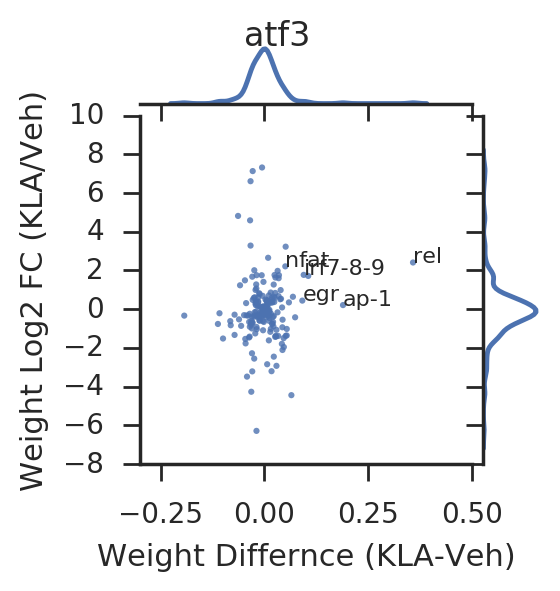

cjun_veh
cjun ap-1 0.243455892891 0.249860563284 1.28749844862 1.53095434151
cjun egr 0.167108576876 0.770427309724 0.236773180057 0.403881756933
cjun irf7-8-9 0.145722915935 3.24568209553 0.0171737231173 0.162896639053
cjun nfat 0.108221275007 5.40298153403 0.00261963370687 0.110840908714
cjun rel 0.379228807531 2.34054955087 0.0932922443008 0.472521051832


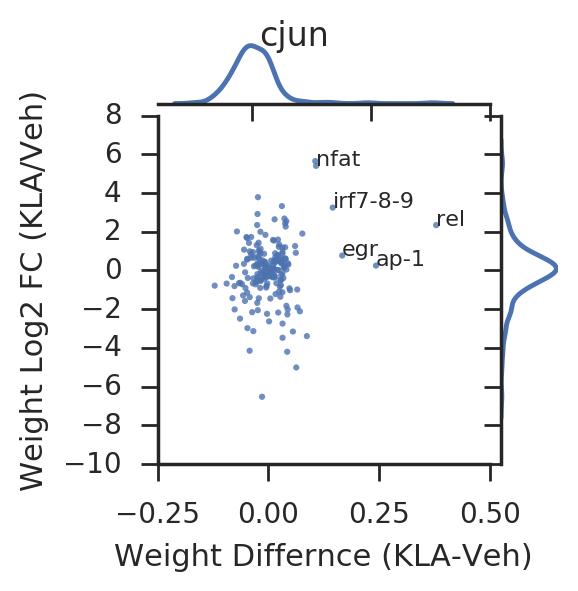

jund_veh
jund ap-1 0.203235515948 0.215945546425 1.25869786902 1.46193338497
jund egr 0.13876239862 0.585409028553 0.277267306791 0.41602970541
jund irf7-8-9 0.0502828596616 0.804407659799 0.0673645942951 0.117647453957
jund nfat 0.079519283851 2.9741684026 -0.00897708049151 0.0705422033595
jund rel 0.347492156796 2.04946747589 0.110682808404 0.4581749652


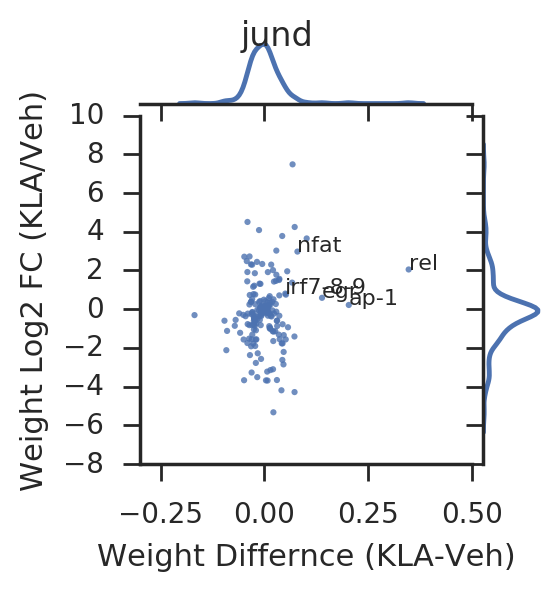

In [99]:
# scatterplot of weights
motifs = mean_coeff_frame.index.values
threshold = 0.1
for factor in ['atf3', 'cjun', 'jund']:
    factor1 = factor + '_veh'
    factor2 = factor + '_kla'
    with sns.axes_style('ticks'):
        print(factor1)
        coeffs_factor_1 = mean_coeff_frame[factor1]
        coeffs_factor_2 = mean_coeff_frame[factor2]
        ratios = np.log2((np.abs(coeffs_factor_2))/np.abs(coeffs_factor_1))
        differences = coeffs_factor_2 - coeffs_factor_1

        # calculate colors
        jg = sns.jointplot(data=pd.DataFrame({'Weight Log2 FC (KLA/Veh)':ratios, 
                                   'Weight Differnce (KLA-Veh)':differences}),
                     x='Weight Differnce (KLA-Veh)',
                     y='Weight Log2 FC (KLA/Veh)',
                     size=3,
                     stat_func=None,
#                      xlim=(-0.5,1.5),
#                      ylim=(-0.5,0.5),
                     kind='reg',
                     marginal_kws={'hist':False},
                     joint_kws = {'fit_reg':False,
                                  'scatter_kws':{
                                  'marker':'.', 
                                  's':5,
                                  'edgecolor':'None'}}
                     )  

#         calculate labels
        for i in range(len(ratios)):
            r = ratios[i]
            d = differences[i]
            m = motifs[i]
            
#             if abs(d) >= 0.05 and abs(r) > 1.5:
            if m in ['nfat', 'egr', 'irf7-8-9', 'rel', 'ap-1']:
                jg.ax_joint.annotate(motifs[i], xy=(d,r) , size=8)
                print(factor, motifs[i], d, r, coeffs_factor_1[i], coeffs_factor_2[i])
        jg.ax_joint.set_xticks(np.arange(-0.25,0.51,0.25))
        plt.suptitle(factor)
        plt.savefig('./figures/figure_05_weight_differences_scatter_'+factor1+'.pdf', bbox_inches='tight')
        plt.show()



### Correlations of Individual Motif Scores and Condition Specific Binding

In [144]:
# for monomers using the best motif scores for each motif
motif_score_differences_frame = motif_score_frame.ix[:,3:] - motif_score_balbc_frame.ix[:,3:]
threshold = 1
motifs = motif_score_frame.columns.values[3:]
motifScore_klaSpecificBinding_correlations_dict = {}

for monomer in ['atf3','cjun', 'jund']:
    veh_indices = summary_frame[summary_frame['c57bl6_' + monomer + '_veh'] > 0].index.values
    kla_indices = summary_frame[summary_frame['c57bl6_' + monomer + '_kla'] > 0].index.values
    
    veh_indices = set(veh_indices)
    kla_indices = set(kla_indices)
    
    indices = veh_indices.union(kla_indices)
    indices = sorted(indices)
    
    fold_changes = (ap1_meanTag_frame.ix[indices, 'c57bl6_'+monomer+'_kla']+1)/(ap1_meanTag_frame.ix[indices,'c57bl6_'+monomer+'_veh']+1)
    log_fold_changes = np.log2(fold_changes)
    pearsons = []
    for motif in motifs:
        motif_scores = motif_score_frame.ix[indices, motif]
        pearson, pval = scipy.stats.pearsonr(motif_scores, log_fold_changes)
        pearsons.append(pearson)
        if pearson > 0.15:
            print(monomer, motif, pearson)
    motifScore_klaSpecificBinding_correlations_dict[monomer] = pearsons       
    


atf3 ap-1 0.180995694169
atf3 nfat 0.222687764668
atf3 nfkb 0.170541982951
atf3 rel 0.34416080329
cjun nfkb 0.176290234224
cjun rel 0.333089745645
jund ap-1 0.179719832323
jund arid3b 0.160110246651
jund arid5a 0.151611915455
jund hoxd8 0.151892399481
jund nfat 0.245011203747
jund nfkb 0.167856844954
jund pou1f1 0.168916968941
jund pou2-3-5 0.155459031928
jund pou4 0.182747378621
jund rel 0.339103100363


In [145]:
frame = pd.DataFrame(motifScore_klaSpecificBinding_correlations_dict)
frame.index = motifs

In [146]:
frame[frame.abs().max(axis=1) > 0.15]

atf3      cjun      jund
ap-1        0.180996  0.103362  0.179720
arid3b      0.131581  0.025849  0.160110
arid5a      0.097812  0.022836  0.151612
arntl_mitf -0.144220 -0.108789 -0.177644
e2f4_e2f6  -0.102569  0.012203 -0.152025
elf        -0.143847 -0.098086 -0.183489
elk_etv    -0.149234 -0.075503 -0.191565
hinfp      -0.159644 -0.056647 -0.210843
hoxd8       0.114283  0.028190  0.151892
nfat        0.222688  0.149482  0.245011
nfkb        0.170542  0.176290  0.167857
nrf1       -0.157106 -0.057449 -0.200293
pou1f1      0.118600  0.062011  0.168917
pou2-3-5    0.102979  0.054589  0.155459
pou4        0.124601  0.059241  0.182747
rel         0.344161  0.333090  0.339103
sp4        -0.101968 -0.028886 -0.151924
tcfl5      -0.181946 -0.094652 -0.228577
zbtb33     -0.116311 -0.052016 -0.161536
zfx        -0.121159 -0.027366 -0.166647

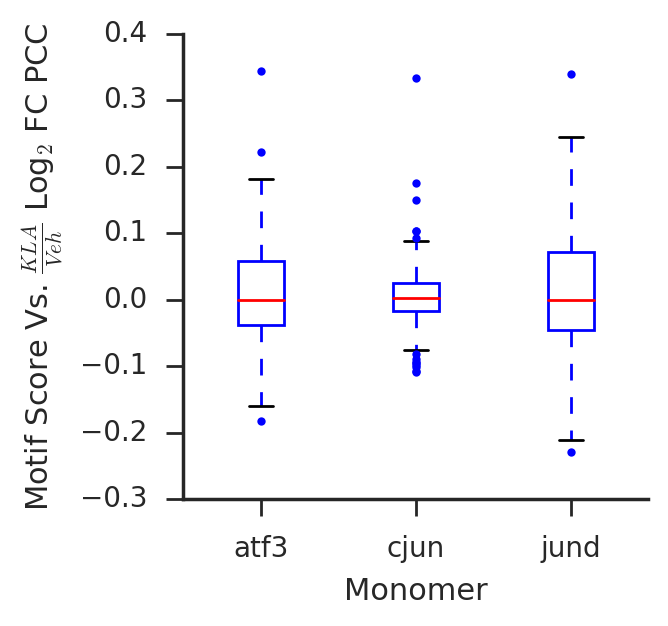

In [147]:
monomers = ['atf3', 'cjun', 'jund']
with sns.axes_style('ticks'):
    plt.figure(figsize=(3,3))
    vals = [motifScore_klaSpecificBinding_correlations_dict[m] for m in monomers]
    plt.boxplot(vals, showfliers=True, sym='.',patch_artist=True)
    plt.xticks(range(1,len(monomers)+1), monomers)
    plt.ylabel(r'Motif Score Vs. $\frac{KLA}{Veh}$ Log$_2$ FC PCC')
    plt.xlabel('Monomer')
    sns.despine()
    plt.savefig('./figures/figure_05_motif_klaSpecificBinding_correlation_boxplot.pdf', bbox_inches='tight')
    plt.show()

### Prediction of KLA and Veh specific binding 

atf3 0.497286413521


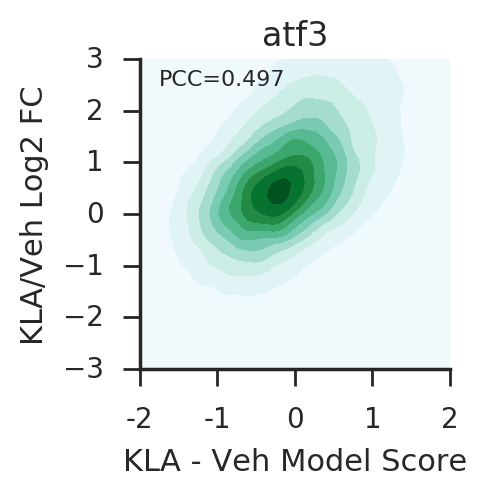

cjun 0.41937888922


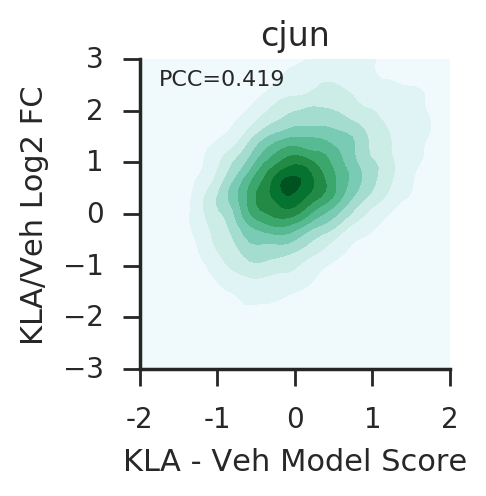

jund 0.503813869208


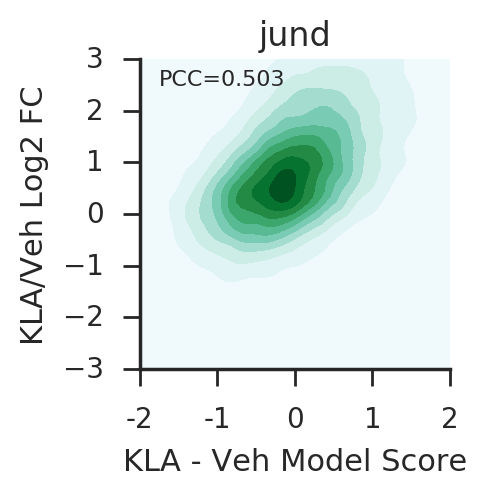

In [133]:
num_bins = 5
colors = sns.color_palette('coolwarm',num_bins)
for monomer in ['atf3','cjun', 'jund']:
    veh_indices = summary_frame[summary_frame['c57bl6_' + monomer + '_veh'] > 0].index.values
    kla_indices = summary_frame[summary_frame['c57bl6_' + monomer + '_kla'] > 0].index.values
    
    veh_indices = set(veh_indices)
    kla_indices = set(kla_indices)
    
    indices = veh_indices.union(kla_indices)
    indices = sorted(indices)
    
    current_scores = monomer_standardized_features_dict[monomer].ix[indices,:]
#     current_scores = all_score_frame.ix[indices,:]
    veh_weights = mean_coeff_frame[monomer + '_veh']
    kla_weights = mean_coeff_frame[monomer + '_kla']
    
    veh_products = veh_weights * current_scores
    veh_scores = veh_products.sum(axis=1)
    kla_products = kla_weights * current_scores
    kla_scores = kla_products.sum(axis=1)
    
#     ratios = np.log2(kla_scores/veh_scores)
    differences = kla_scores - veh_scores
#     ratios.fillna(0,inplace=True)
    
    fold_changes = (ap1_meanTag_frame.ix[indices, 'c57bl6_'+monomer+'_kla']+1)/(ap1_meanTag_frame.ix[indices,'c57bl6_'+monomer+'_veh']+1)
    log_fold_changes = np.log2(fold_changes)
    
    pearson, pval = scipy.stats.pearsonr(differences,np.log2(fold_changes))
    print(monomer, pearson)
    
    with sns.axes_style('ticks'):
        plt.figure(figsize=(2,2))
        sns.kdeplot(differences, log_fold_changes, shade=True)
        plt.xlabel('KLA - Veh Model Score')
        plt.ylabel('KLA/Veh Log2 FC')
        plt.title(monomer)
        plt.gca().annotate(xy=(-1.75,2.5), s='PCC='+str(pearson)[:5], size=8)
        plt.ylim(-3,3)
        plt.xlim(-2,2)
        plt.xticks([-2,-1,0,1,2],[-2,-1,0,1,2])        
        sns.despine()
        plt.savefig('./figures/figure_05_score_FC_scatter_'+monomer+'.pdf', bbox_inches='tight')
        plt.show()

### Venn Diagrams

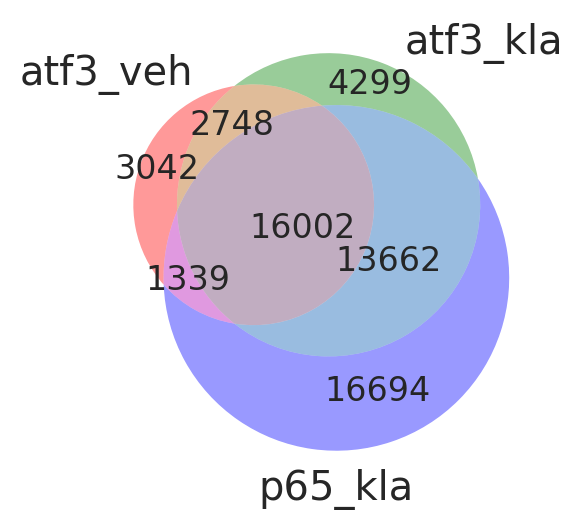

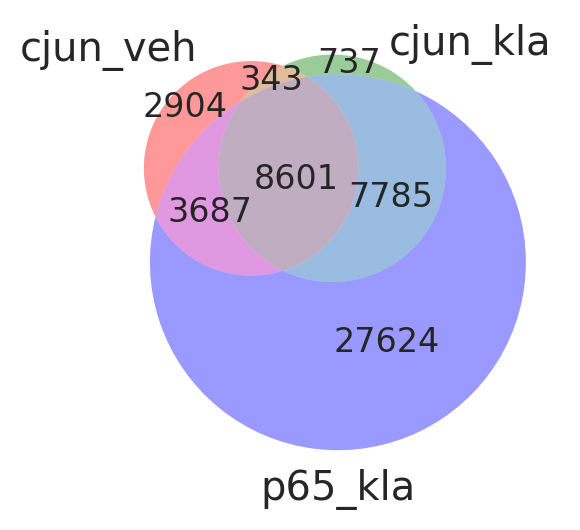

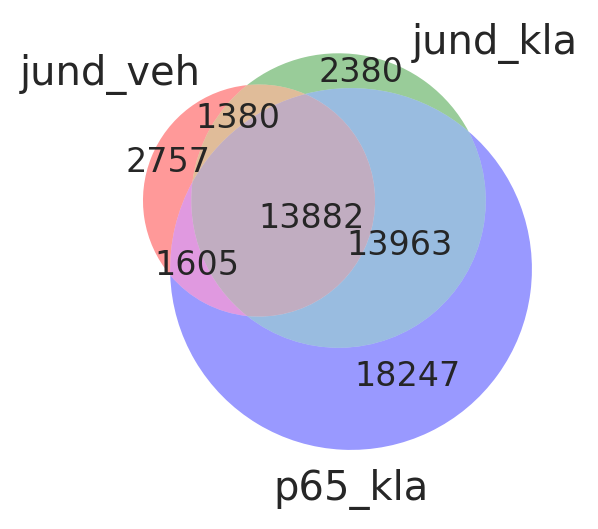

In [138]:
p65_indices = set(summary_frame[summary_frame['c57bl6_p65_kla'] > 0].index.values)
for monomer in ['atf3', 'cjun', 'jund']:
    plt.figure(figsize=(3,3))
    veh_indices = set(summary_frame[summary_frame['c57bl6_' + monomer + '_veh'] > 0].index.values)
    kla_indices = set(summary_frame[summary_frame['c57bl6_' + monomer + '_kla'] > 0].index.values)
    matplotlib_venn.venn3([veh_indices, kla_indices, p65_indices],
                         set_labels=[monomer + '_veh', monomer+'_kla', 'p65_kla'])
    plt.savefig('./figures/figure_05_venn_'+monomer+'.svg', bbox_inches='tight')
    plt.show()

### Weight Heatmap

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


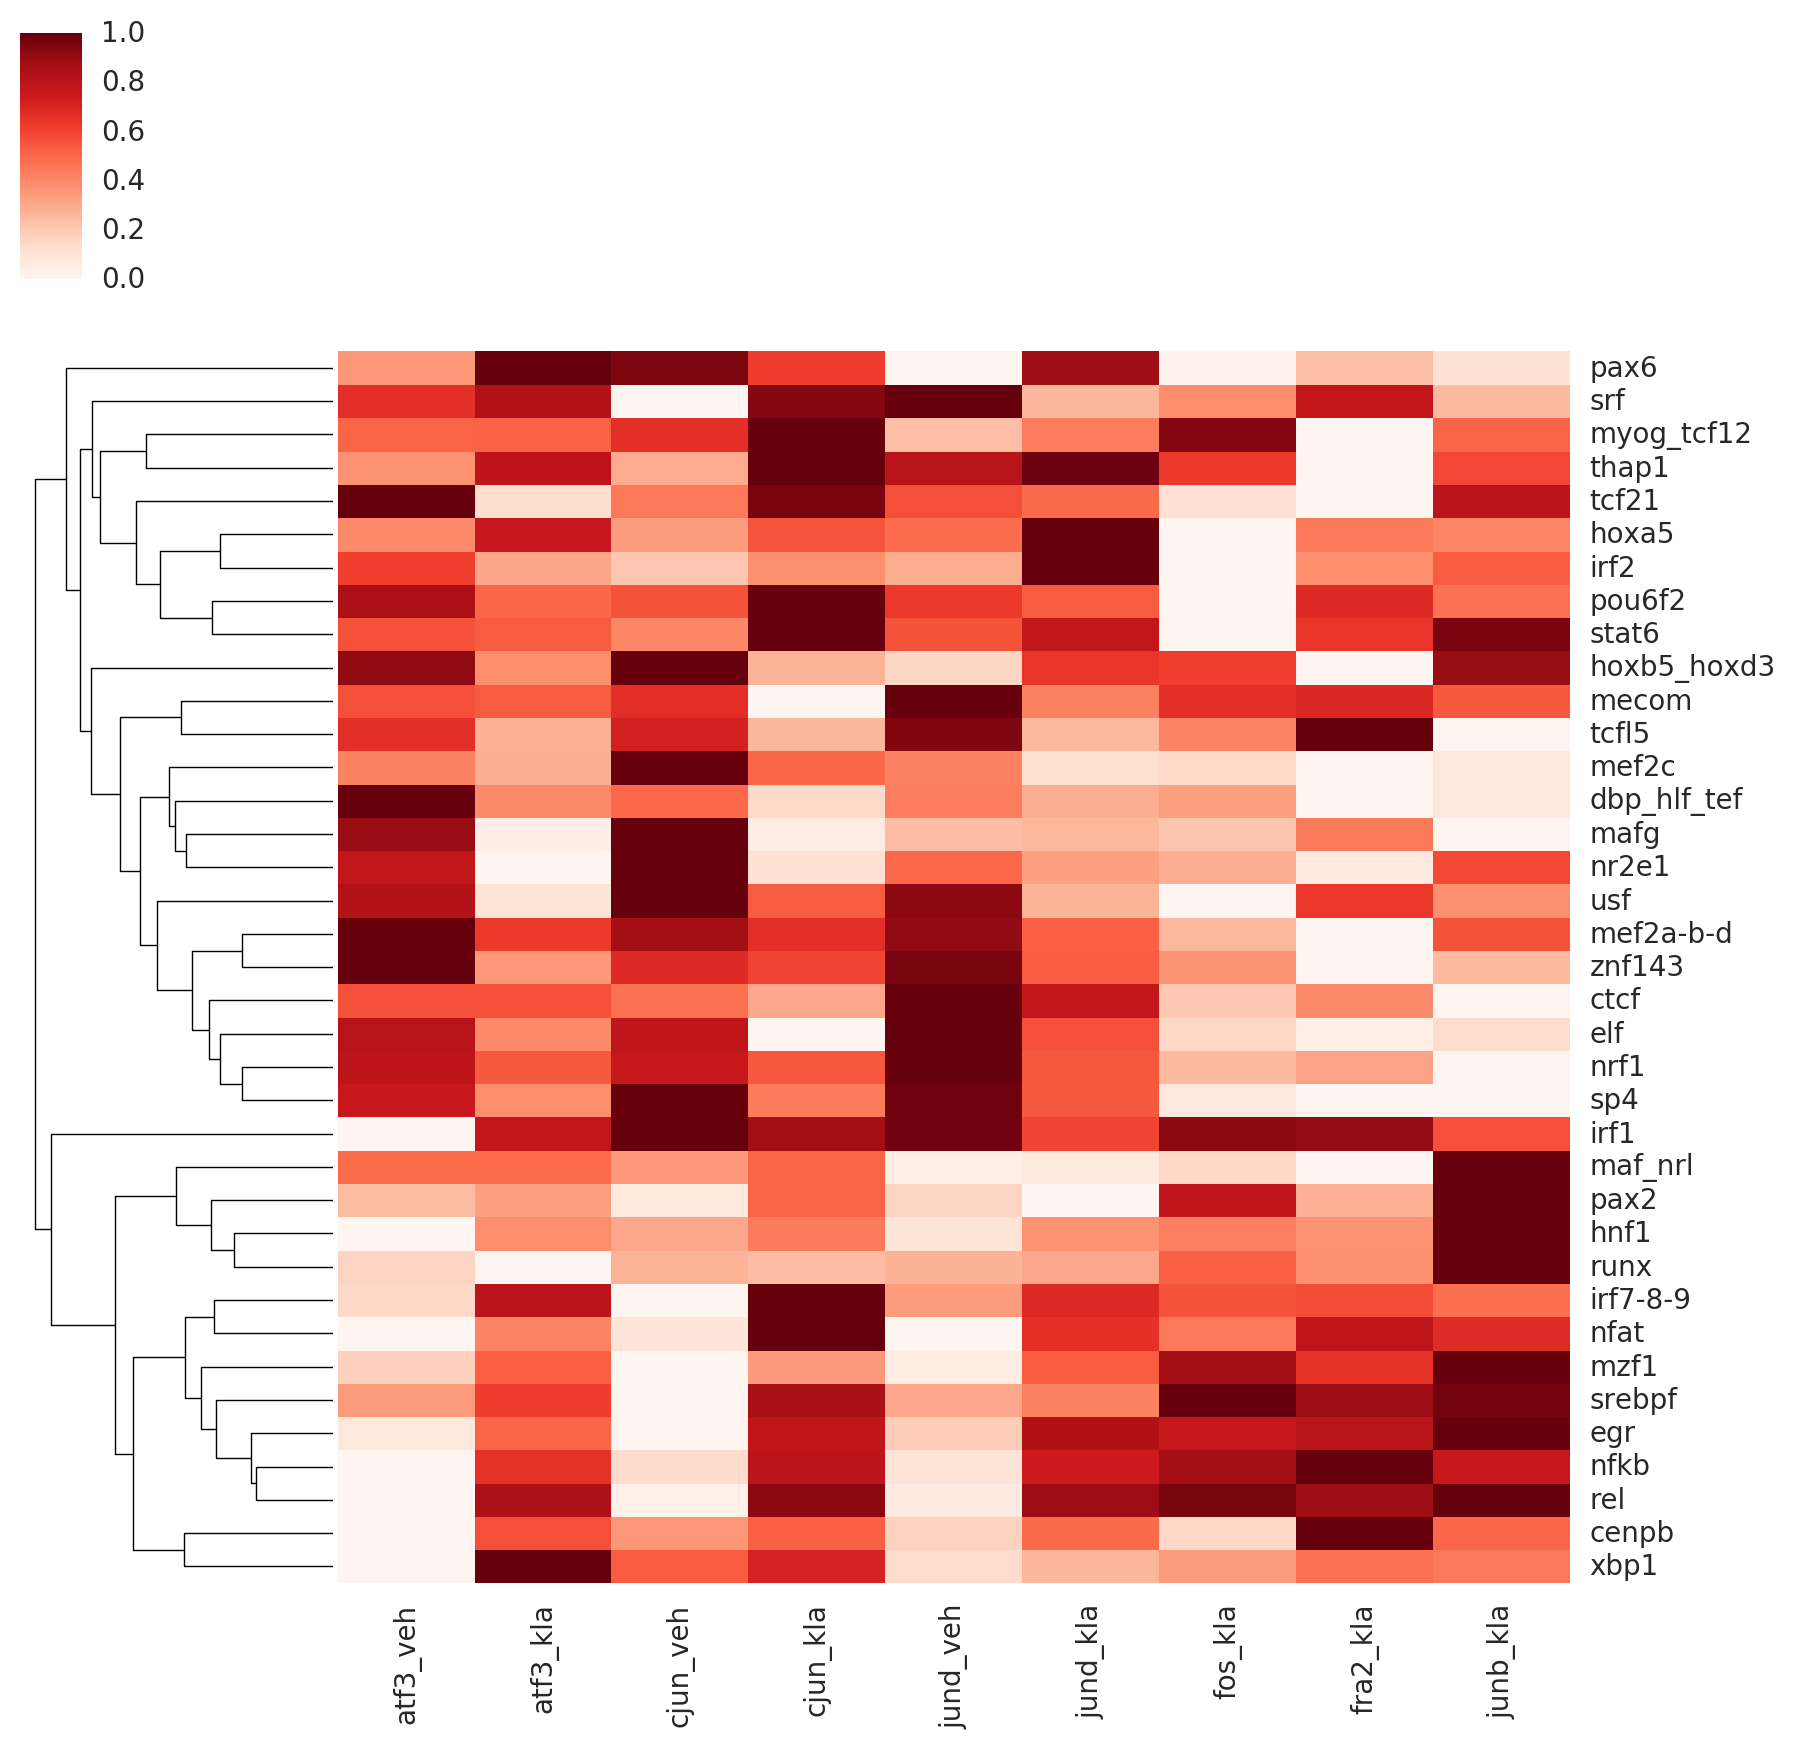

In [139]:
sns.set_style('darkgrid')
rank_threshold = 50
p_threshold = 0.01/196
fold_threshold = 4
kla_coeffs = mean_coeff_frame[[x for x in mean_coeff_frame.columns if 'kla' in x]]
abs_ranks = kla_coeffs.abs().rank(ascending=False)

log_ratio_frame = monomer_mean_lrTest_pval_frame[[]]
for monomer in ['atf3','cjun', 'jund']:
    kla_pvals = monomer_mean_lrTest_pval_frame[monomer + '_kla']
    veh_pvals = monomer_mean_lrTest_pval_frame[monomer + '_veh']
    log_ratios = (np.log10(kla_pvals + 1e-50) - np.log10(veh_pvals+ 1e-50))
    log_ratio_frame[monomer] = -log_ratios
indices = log_ratio_frame[log_ratio_frame.abs().max(axis=1) >= fold_threshold].index.values
# indices = kla_coeffs[(abs_ranks.min(axis=1) <= rank_threshold) &
#                      (kla_pvals < p_threshold) &
#                      (veh_pvals >= p_threshold)
#                      ].index.values
# log_ratios = (np.log10(kla_pvals + 1e-200) - np.log10(veh_pvals+ 1e-200))
# indices = log_ratios[log_ratios.abs() > 4].index.values

data = mean_coeff_frame.ix[indices,:]
data = data[data.max(axis=1) > 0]
scaler = sklearn.preprocessing.MinMaxScaler()
scaled_data = pd.DataFrame(scaler.fit_transform(data.T).T)
scaled_data.columns = data.columns.values
scaled_data.index = data.index.values

cm = sns.clustermap(scaled_data[['atf3_veh','atf3_kla','cjun_veh', 'cjun_kla', 'jund_veh', 'jund_kla',
                                        'fos_kla','fra2_kla','junb_kla']],
                    col_cluster = False,
                    cmap = 'Reds'
#                    vmin=-1.5,
#                    vmax=1.5
                   )
plt.setp(cm.ax_heatmap.yaxis.get_majorticklabels(), 
         fontsize=10, 
         rotation=0);
plt.setp(cm.ax_heatmap.xaxis.get_majorticklabels(), 
         fontsize=10, 
         rotation=90);
plt.savefig('./figures/figure_05_weight_heatmap_kla.pdf', bbox_inches='tight')



### Visualization of significant weights

In [140]:
num_motifs = 50
treatment = 'kla'
members = ['atf3', 'cjun', 'fos', 'fra2', 'junb', 'jund']
top_motifs = []
for monomer in members:
    weights = mean_coeff_frame[monomer + '_' + treatment].abs()
    weights.sort(ascending=False)
    sorted_motifs = list(weights.index.values)
    top_motifs = top_motifs + sorted_motifs[:num_motifs]
top_motifs = sorted(set(top_motifs)) 

# print(len(top_motifs))

signed_ranks_frame = mean_coeff_frame[[]]
for monomer in members:
    weights = mean_coeff_frame[monomer + '_' + treatment]
    ranks = mean_coeff_frame[monomer + '_' + treatment].abs().rank(ascending=True)
    signed_ranks = [-1 * ranks[i] if weights[i] <0 else ranks[i] for i in range(len(weights))]
    signed_ranks_frame[monomer + '_' + treatment] = signed_ranks


data = signed_ranks_frame.ix[top_motifs]
negative_data = data[data.min(axis=1) < -1*num_motifs]
positive_data = data[data.max(axis=1) > num_motifs]

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting
/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


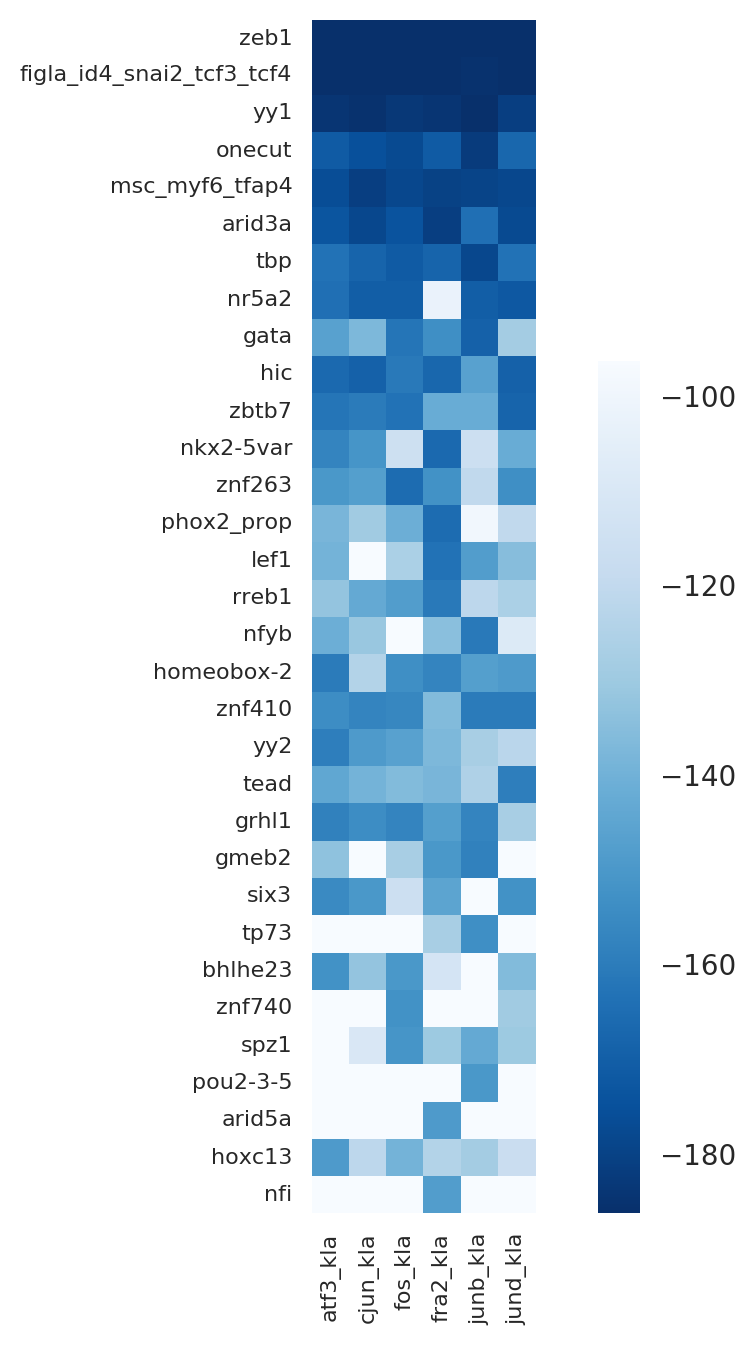

In [141]:
sns.set_style('darkgrid')
negative_data['max'] = signed_ranks_frame.abs().max(axis=1)
negative_data = negative_data.sort('max', ascending=False)
del negative_data['max']


hm = sns.heatmap(negative_data, 
                 square=True,
                 cmap = 'Blues_r',
                 vmin = -186,
                 vmax = -96
                 )
pos = hm.get_position()
hm.set_position([pos.x0, pos.y0, pos.width, pos.height*1.4])
hm.set_yticklabels(size=8, labels = negative_data.index.values[::-1]);
hm.set_xticklabels(size=8, labels = negative_data.columns.values);
plt.savefig('./figures/figure_05_weight_heatmap_negative.svg', bbox_inches='tight')



/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


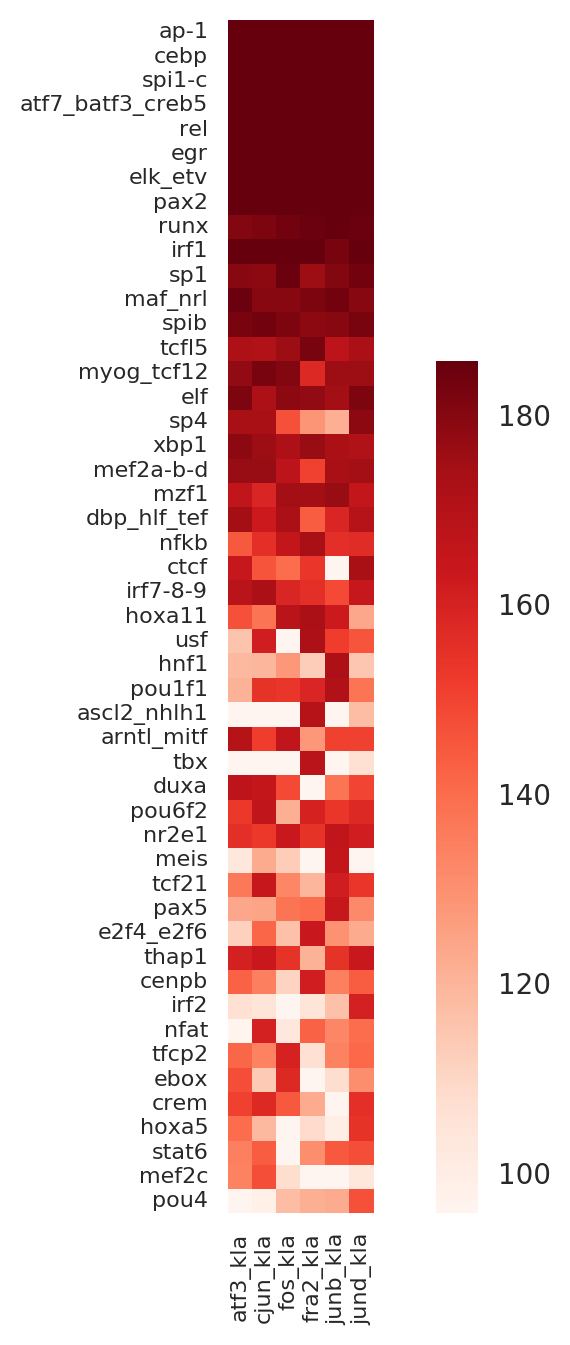

In [142]:
sns.set_style('darkgrid')
positive_data['max'] = signed_ranks_frame.abs().max(axis=1)
positive_data = positive_data.sort('max', ascending=False)
del positive_data['max']

hm = sns.heatmap(positive_data, 
                 square=True,
                 cmap = 'Reds',
                 vmax = 186,
                 vmin = 96
                 )
pos = hm.get_position()
hm.set_position([pos.x0, pos.y0, pos.width, pos.height*1.4])
hm.set_yticklabels(size=8, labels = positive_data.index.values[::-1]);
hm.set_xticklabels(size=8, labels = positive_data.columns.values);
plt.savefig('./figures/figure_05_weight_heatmap_positive.svg', bbox_inches='tight')




### Barplots showing inducible RNA-seq expression for motifs that are different between vehicle and KLA

In [ ]:
!analyzeRepeats.pl rna mm10 -count exons -condenseGenes -noadj -d  ~/analysis/ap1_analysis/tag_directories_rna/C57Bl6_*Veh*UT*TKS*/ ~/analysis/ap1_analysis/tag_directories_rna/C57*KLA-1h*UT*/> raw_untreated.tsv



In [ ]:
!getDiffExpression.pl ./raw_untreated.tsv veh veh kla kla -edgeR -AvsA>./diff_expression.tsv

In [303]:
diffExpression_frame = pd.read_csv('diff_expression.tsv', sep='\t')

In [304]:
diff_expressed_genes = [x.split('|')[0].upper() for x in diffExpression_frame[diffExpression_frame['veh vs. kla adj. p-value'] <= 0.05]['Annotation/Divergence']]

In [330]:
sorted(diff_expressed_genes)

['0610039K10RIK',
 '1810011O10RIK',
 'ADM',
 'ADORA2B',
 'ADRB2',
 'AREG',
 'ARG1',
 'ATP5L',
 'BCL2A1A',
 'BCL2A1B',
 'BCL2A1D',
 'BTG1',
 'BTG2',
 'CCL12',
 'CCL2',
 'CCL3',
 'CCL4',
 'CCL7',
 'CCL9',
 'CCR7',
 'CCRL2',
 'CD14',
 'CD40',
 'CD69',
 'CD83',
 'CDC42EP2',
 'CDK5R1',
 'CDKN1A',
 'CH25H',
 'CISH',
 'CLCF1',
 'CLEC4E',
 'CSF2',
 'CSF3',
 'CSRNP1',
 'CTGF',
 'CXCL1',
 'CXCL10',
 'CXCL2',
 'CXCL3',
 'D930048N14RIK',
 'DNAJB4',
 'DNAJC28',
 'DUSP1',
 'DUSP2',
 'DUSP4',
 'DUSP5',
 'DUSP8',
 'E230013L22RIK',
 'EGR1',
 'EGR2',
 'EGR3',
 'EHD1',
 'EID3',
 'ERRFI1',
 'F13A1',
 'F3',
 'FAM43A',
 'FLRT3',
 'FOS',
 'FOSB',
 'FOSL2',
 'GAPDH',
 'GBP5',
 'GDF15',
 'GEM',
 'GM14023',
 'GM6377',
 'GM6793',
 'GPR84',
 'GPR85',
 'H3F3B',
 'HILPDA',
 'ICAM1',
 'ID3',
 'IER2',
 'IER3',
 'IFIT1',
 'IFNB1',
 'IFRD1',
 'IL10',
 'IL1A',
 'IL1B',
 'IL1RN',
 'IL23A',
 'IL6',
 'IRF1',
 'IRG1',
 'ISG15',
 'JCHAIN',
 'JUNB',
 'KCTD12',
 'KDM6B',
 'KLF2',
 'KLF6',
 'LARS2',
 'LIF',
 'MAFF',
 'MARCKSL1'

In [302]:
# read in rpkm values
rpkm_frame = pd.read_csv('./rpkm_untreated.tsv', sep='\t')

rpkm_frame.index = [x.split('|')[0].upper() for x in rpkm_frame['Annotation/Divergence']]
rpkm_frame = rpkm_frame.ix[:,8:]
rpkm_frame.columns = [x.split('/')[-2].split('_')[3] for x in rpkm_frame.columns.values]

# rotate frame for plotting
rpkm_plotting_frame = pd.DataFrame(rpkm_frame.stack(), 
                                   columns=['RPKM'])
rpkm_plotting_frame['Gene'] = [x[0] for x in rpkm_plotting_frame.index.values]
rpkm_plotting_frame['Treatment'] = [x[1] for x in rpkm_plotting_frame.index.values]
rpkm_plotting_frame['Log2 RPKM'] = np.log2(rpkm_plotting_frame['RPKM'].values + 1)

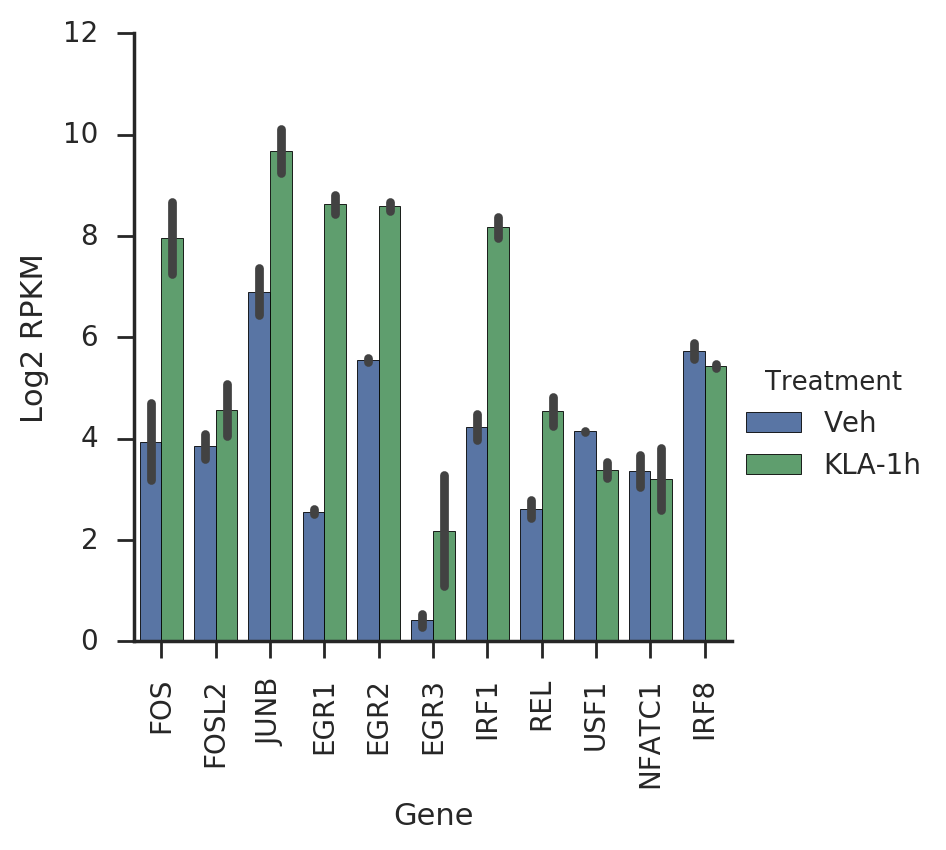

In [849]:
gene_list = ['EGR1', 
             'REL', 
             'EGR2', 
             'EGR3', 
             'IRF1',
             'FOS', 
             'FOSL2', 
             'JUNB',
             'NFATC1',
             'NFATC2',
             'USF1',
#              'IRF7',
             'IRF8',
#              'IRF2',
#              'IRF3',
#              'IRF4', 
             
            ]


plottingFrame = rpkm_plotting_frame[rpkm_plotting_frame['Gene'].isin(gene_list)]

with sns.axes_style('ticks'):
    sns.factorplot(data = plottingFrame, x='Gene', y='Log2 RPKM', hue='Treatment', kind='bar', 
#                    order = sorted(gene_list),
                   order = ['FOS','FOSL2','JUNB',
                            'EGR1','EGR2','EGR3','IRF1','REL','USF1',
                            'NFATC1', 'IRF8'],
                   hue_order=['Veh','KLA-1h'], 
                   ci=100,
                  size=4)

plt.xticks(rotation=90)
plt.savefig('./figures/figure_05_factor_expression.pdf', bbox_inches='tight')

### Dimer Analysis in KLA

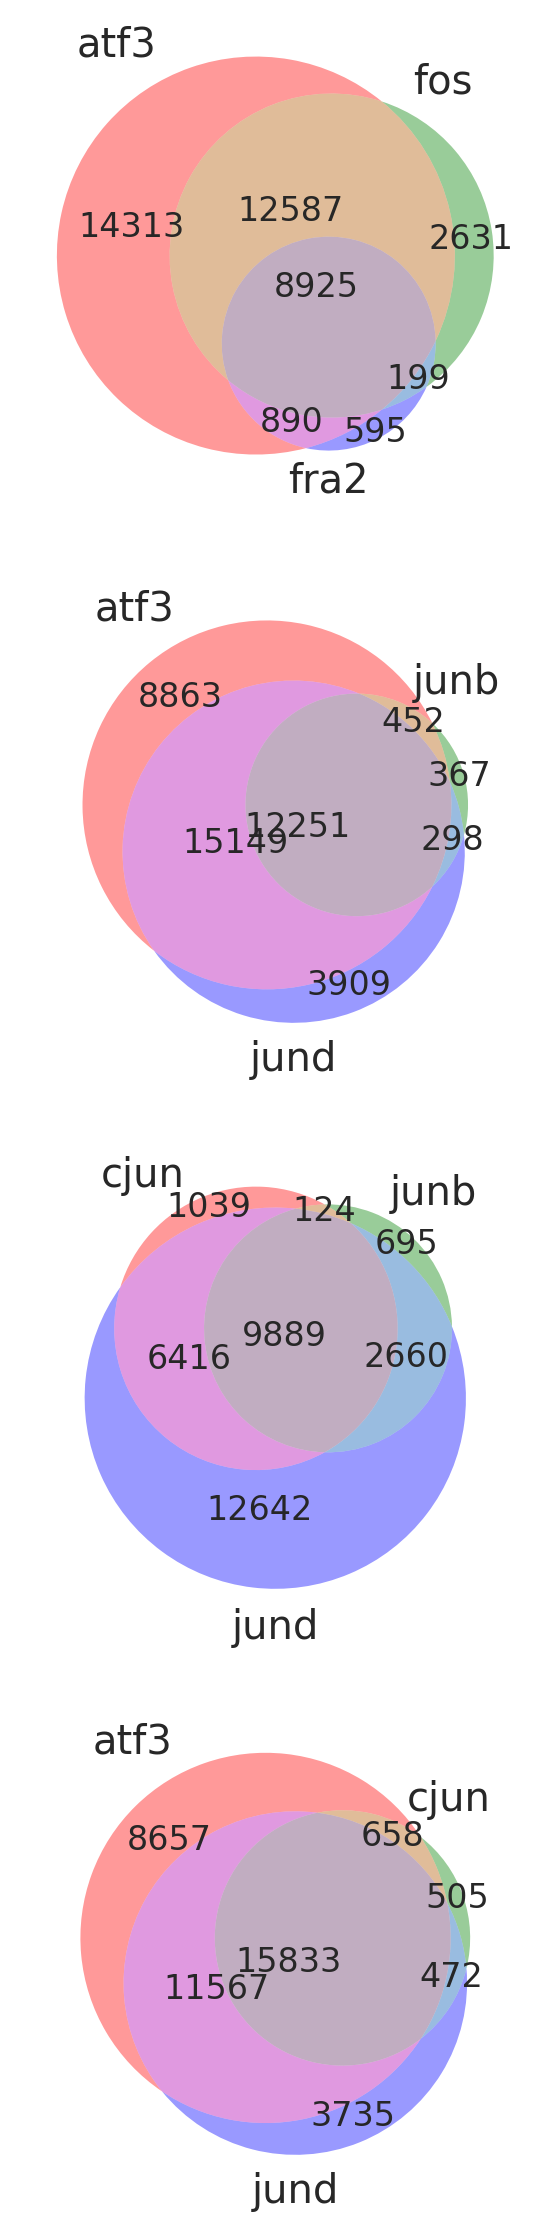

In [1053]:
plt.figure(figsize=(3.5,14))
atf3_indices = set(summary_frame[summary_frame['c57bl6_atf3_kla'] > 0].index.values)
cjun_indices = set(summary_frame[summary_frame['c57bl6_cjun_kla'] > 0].index.values)
fos_indices = set(summary_frame[summary_frame['c57bl6_fos_kla'] > 0].index.values)
fra2_indices = set(summary_frame[summary_frame['c57bl6_fra2_kla'] > 0].index.values)
junb_indices = set(summary_frame[summary_frame['c57bl6_junb_kla'] > 0].index.values)
jund_indices = set(summary_frame[summary_frame['c57bl6_jund_kla'] > 0].index.values)
plt.subplot(4,1,1)
matplotlib_venn.venn3([atf3_indices, fos_indices, fra2_indices], set_labels=['atf3', 'fos', 'fra2'])
plt.subplot(4,1,2)
matplotlib_venn.venn3([atf3_indices, junb_indices, jund_indices], set_labels=['atf3', 'junb', 'jund'])
plt.subplot(4,1,3)
matplotlib_venn.venn3([cjun_indices, junb_indices, jund_indices], set_labels=['cjun', 'junb', 'jund'])
plt.subplot(4,1,4)
matplotlib_venn.venn3([atf3_indices, cjun_indices, jund_indices], set_labels=['atf3', 'cjun', 'jund'])

# plt.savefig('./figures/figure_02_c_venn_kla.svg')
# plt.savefig('./figures/figure_02_c_venn_kla.png')

In [1054]:
numIterations = 5
test_size = 0.5
background_ratio = 1.0
ap1_members = ['atf3','cjun', 'fos', 'fra2', 'junb','jund']    
factors = ['atf3','cjun', 'fos', 'junb','jund', 'cebpa', 'pu1', 'p65']
ap1_dimers = []
for i in range(len(ap1_members) - 1):
    for j in range(i+1, len(ap1_members)):
        ap1_dimers.append((ap1_members[i], ap1_members[j]))

In [1064]:
# for monomers using motif counts and best motif score 
strain = 'c57bl6'

factor_coeff_dimer_dict = {}
factor_roc_dimer_dict = {}
factor_precision_dimer_dict = {}
factor_score_dimer_dict = {}
factor_testLabel_dimer_dict = {}

for dimer in ap1_dimers:
    features = dimer_standardized_features_dict['_'.join(dimer)]                
    labels = pd.Series([False if 'background' in x else True for x in features.index.values],
                           index = features.index.values)
    
    results = train_classifier(features, 
                                labels,
                                numIterations = 5,
                                test_size = test_size,
                                )
    # unpack result tuples
    all_rocs = results[0]
    all_precisions = results[1]
    all_coefficients = results[2]
    all_scores = results[3]
    all_testLabels = results[4]

    factor_roc_dimer_dict['_'.join(dimer)] = all_rocs
    factor_precision_dimer_dict['_'.join(dimer)] = all_precisions
    factor_coeff_dimer_dict['_'.join(dimer)] = all_coefficients
    factor_score_dimer_dict['_'.join(dimer)] = all_scores
    factor_testLabel_dimer_dict['_'.join(dimer)] = all_testLabels

    print('_'.join(dimer) + '_' + treatment,
          'roc:', np.mean(all_rocs),
          'precision:', np.mean(all_precisions),
         )

atf3_cjun_kla roc: 0.949149845735 precision: 0.856880584183
atf3_fos_kla roc: 0.947800117041 precision: 0.868017789651
atf3_fra2_kla roc: 0.95451948857 precision: 0.833841902915
atf3_junb_kla roc: 0.952383870413 precision: 0.846160912682
atf3_jund_kla roc: 0.942561939523 precision: 0.868704734904
cjun_fos_kla roc: 0.950508130079 precision: 0.872843137033
cjun_fra2_kla roc: 0.955547037924 precision: 0.868309528608
cjun_junb_kla roc: 0.955050193965 precision: 0.879640376748
cjun_jund_kla roc: 0.94832352331 precision: 0.867558711696
fos_fra2_kla roc: 0.956106504528 precision: 0.862198024188
fos_junb_kla roc: 0.951720957862 precision: 0.869806651971
fos_jund_kla roc: 0.946305668712 precision: 0.87108030942
fra2_junb_kla roc: 0.95821643347 precision: 0.878935535969
fra2_jund_kla roc: 0.95345739059 precision: 0.846832626868
junb_jund_kla roc: 0.952529512686 precision: 0.85988485017


In [1074]:
mean_coeff_dimer_frame = calculate_mean_weights(factor_coeff_dimer_dict,
                                                motif_score_frame.columns.values[3:])

In [1080]:
data = pd.concat([mean_coeff_frame[[x for x in mean_coeff_frame.columns if 'kla' in x]], 
                  mean_coeff_dimer_frame], axis=1)
model = sklearn.decomposition.PCA(n_components=3)

reduced_features = model.fit_transform(data.T)
explained_variance_ratios = model.explained_variance_ratio_

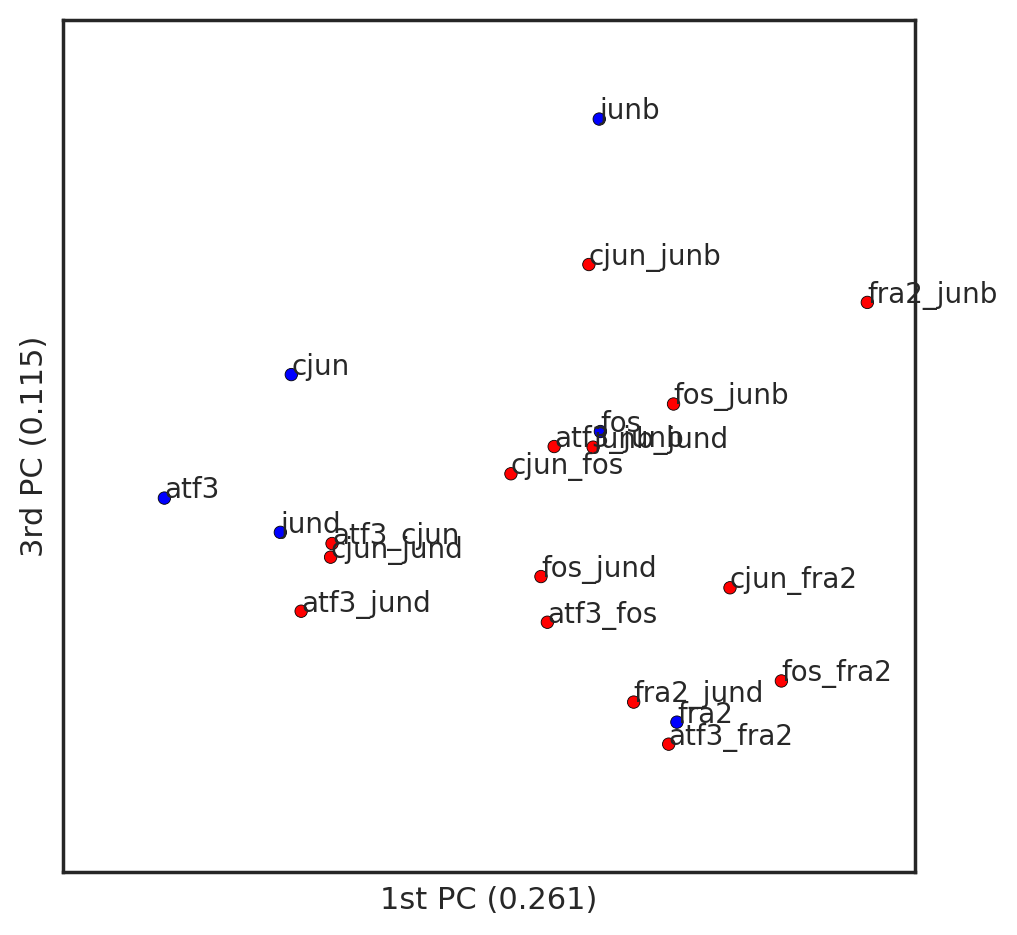

In [1087]:
sns.set_style('white')
# f = plt.figure(figsize=(5,5))
labels = [x.replace('_kla','') for x in data.columns.values]
colors = ['red' if '_' in x else 'blue' for x in labels]
# 1st and 2nd principal component
x_vals = reduced_features[:, 0]
y_vals = reduced_features[:, 2]
plt.scatter(x_vals, y_vals, s=20, c=colors)

for i in range(len(x_vals)):
        x = x_vals[i]
        y = y_vals[i]
        plt.annotate(labels[i], xy=(x,y) , size=10)

plt.xlabel("1st PC (" + "{:.3f}".format(explained_variance_ratios[0]) +')')
plt.xticks([])
plt.ylabel("3rd PC (" + "{:.3f}".format(explained_variance_ratios[2]) +')')
plt.yticks([])
ax = plt.gca()
x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()
ax.set_aspect(abs(x1-x0)/abs(y1-y0))

plt.savefig('./figures/figure_05_dimer_weight_pca.svg', bbox_inches='tight')





### GRO-seq Analysis

In [ ]:
%%capture
!annotatePeaks.pl ./merged_peaks_filtered_resized.tsv mm10 -size 1000 -d ./tag_directories_gro/*/ > ./merged_peaks_filtered_resized_gro.tsv

In [577]:
# average tag counts from both replicates
gro_tag_frame = pd.read_csv('merged_peaks_filtered_resized_gro.tsv', sep='\t')
gro_tag_frame.index = gro_tag_frame.ix[:,0].values
annotations = pd.Series([x.split()[0] for x in gro_tag_frame['Annotation'].values], index = gro_tag_frame.index.values)
gro_tag_frame = gro_tag_frame[[x for x in gro_tag_frame.columns.values if 'Tag Count' in x]]
columns = [x.split(' ')[0].split('/')[2].lower() for x in gro_tag_frame.columns.values]
gro_tag_frame.columns = columns

factor_treatments = sorted(set(['_'.join(x.split('_')[:5]) for x in columns]))

mean_gro_tag_dict = {}
for ft in factor_treatments:
    cleaned_ft = ft.split('_')[3].split('-')[0]
    mean_gro_tag_dict[cleaned_ft] = gro_tag_frame[[x for x in gro_tag_frame.columns if ft in x]].mean(axis=1).values
mean_gro_frame = pd.DataFrame(mean_gro_tag_dict)
mean_gro_frame.index = gro_tag_frame.index.values



atf3 3.93933441104e-53 2.78024899367e-166 1.41396934815e-183
cjun 5.75023597374e-71 1.2890994525e-115 2.4243624486e-262
jund 3.04348870107e-73 2.68423079959e-201 1.60256570172e-243


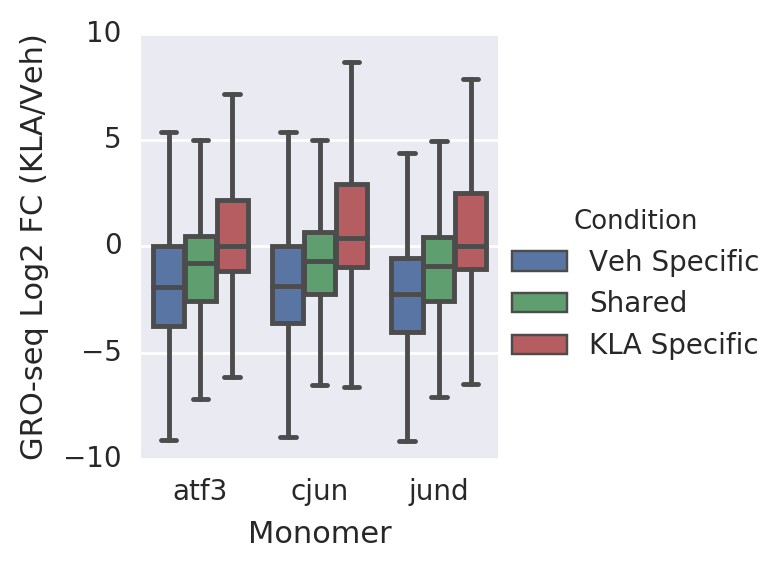

In [578]:
intergenic_indices = annotations[annotations == 'Intergenic'].index.values
fold_changes = np.log2((mean_gro_frame['kla'] + 0.1)/(mean_gro_frame['veh'] + 0.1))

fold_change_list = []
condition_list = []
monomer_list = []
for monomer in ['atf3','cjun', 'jund']:
    veh_indices = summary_frame[(summary_frame.index.isin(intergenic_indices)) &
                                (summary_frame['c57bl6_' + monomer + '_veh'] > 0)].index.values
    kla_indices = summary_frame[(summary_frame.index.isin(intergenic_indices)) &
                                (summary_frame['c57bl6_' + monomer + '_kla'] > 0)].index.values
    
    veh_indices = set(veh_indices)
    kla_indices = set(kla_indices)
    
    veh_specific_indices = veh_indices - kla_indices
    kla_specific_indices = kla_indices - veh_indices
    shared_indices = veh_indices.intersection(kla_indices)

    fold_change_list = fold_change_list + list(fold_changes[veh_specific_indices])
    fold_change_list = fold_change_list + list(fold_changes[kla_specific_indices])
    fold_change_list = fold_change_list + list(fold_changes[shared_indices])
    
    monomer_list = monomer_list + [monomer] * (len(veh_specific_indices) + len(kla_specific_indices) + len(shared_indices))
    
    condition_list = condition_list + ['Veh Specific'] * len(veh_specific_indices)
    condition_list = condition_list + ['KLA Specific'] * len(kla_specific_indices)
    condition_list = condition_list + ['Shared'] * len(shared_indices)
    
    stat,veh_kla_pval = scipy.stats.ttest_ind(fold_changes[veh_specific_indices],fold_changes[kla_specific_indices])
    stat,veh_shared_pval = scipy.stats.ttest_ind(fold_changes[shared_indices],fold_changes[veh_specific_indices])
    stat,kla_shared_pval = scipy.stats.ttest_ind(fold_changes[shared_indices],fold_changes[kla_specific_indices])
    
    print(monomer, veh_shared_pval, kla_shared_pval, veh_kla_pval)
kla_change_frame = pd.DataFrame({'Condition':condition_list,
                      'GRO-seq Log2 Fold Change':fold_change_list,
                      'Monomer':monomer_list
                     })

sns.factorplot(data = kla_change_frame, 
               x = 'Monomer',
               y = 'GRO-seq Log2 Fold Change',
               hue = 'Condition',
               kind = 'box',
               hue_order = ['Veh Specific', 'Shared', 'KLA Specific'],
               showfliers = False,
               size=3
              )
plt.ylabel('GRO-seq Log2 FC (KLA/Veh)')
plt.savefig('./figures/figure_05_gro_boxplots.svg', bbox_inches='tight')

atf3 kla 2.12951464259e-120 1.26370015047e-22 5.54697562737e-46
cjun kla 7.03155796828e-126 1.49114693812e-16 2.25532646532e-60
jund kla 2.6941480742e-181 1.70678017684e-28 5.28549141804e-75


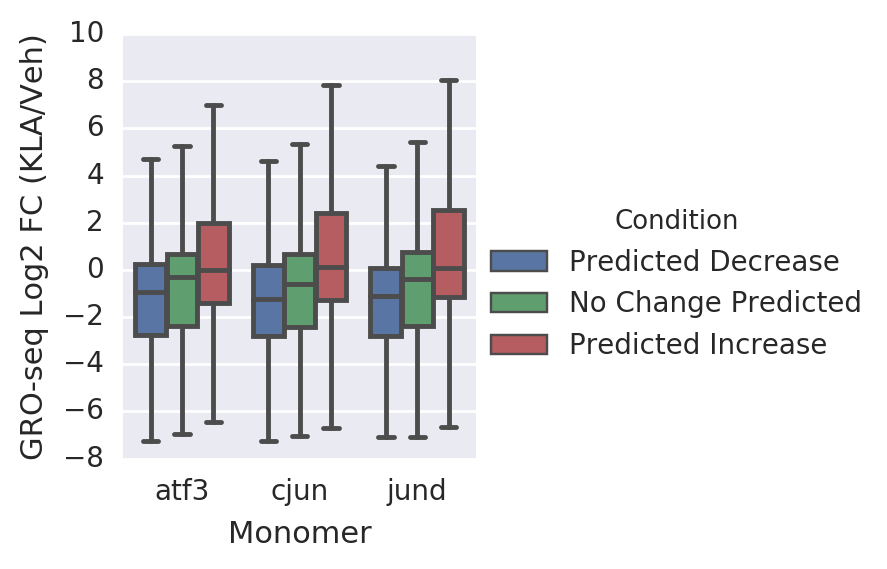

In [790]:
intergenic_indices = annotations[annotations == 'Intergenic'].index.values
fold_changes = np.log2((mean_gro_frame['kla'] + 0.1)/(mean_gro_frame['veh'] + 0.1))

fold_change_list = []
condition_list = []
monomer_list = []
for monomer in ['atf3','cjun', 'jund']:
    veh_indices = summary_frame[(summary_frame.index.isin(intergenic_indices)) &
                                (summary_frame['c57bl6_' + monomer + '_veh'] > 0)].index.values
    kla_indices = summary_frame[(summary_frame.index.isin(intergenic_indices)) &
                                (summary_frame['c57bl6_' + monomer + '_kla'] > 0)].index.values
    
    veh_indices = set(veh_indices)
    kla_indices = set(kla_indices)
    
    indices = veh_indices.union(kla_indices)

    current_fold_changes = fold_changes[indices]
    
    current_scores = monomer_standardized_features_dict[monomer].ix[indices,:]
    veh_weights = mean_coeff_frame[monomer + '_veh']
    kla_weights = mean_coeff_frame[monomer + '_kla']
    
    veh_products = veh_weights * current_scores
    veh_scores = veh_products.sum(axis=1)
    kla_products = kla_weights * current_scores
    kla_scores = kla_products.sum(axis=1)
    
    differences = kla_scores - veh_scores
    
    high_log_fcs = current_fold_changes[differences[differences > np.percentile(differences,67)].index.values]
    med_log_fcs = current_fold_changes[differences[(differences > np.percentile(differences,33)) &
                                                     (differences < np.percentile(differences,67))].index.values]
    low_log_fcs = current_fold_changes[differences[differences < np.percentile(differences,33)].index.values]
    
    fold_change_list = fold_change_list + list(high_log_fcs)
    fold_change_list = fold_change_list + list(med_log_fcs)
    fold_change_list = fold_change_list + list(low_log_fcs)
    
    condition_list = condition_list + ['Predicted Increase'] * len(high_log_fcs)
    condition_list = condition_list + ['No Change Predicted'] * len(med_log_fcs)
    condition_list = condition_list + ['Predicted Decrease'] * len(low_log_fcs)
    
    monomer_list = monomer_list + [monomer] *len(indices)
    
    stat,high_low_pval = scipy.stats.ttest_ind(high_log_fcs,low_log_fcs)
    stat,med_low_pval = scipy.stats.ttest_ind(med_log_fcs,low_log_fcs)
    stat,med_high_pval = scipy.stats.ttest_ind(med_log_fcs,high_log_fcs)
    print(monomer, treatment, high_low_pval, med_low_pval, med_high_pval)
  

prediction_frame = pd.DataFrame({'Condition':condition_list,
                      'GRO-seq Log2 Fold Change':fold_change_list,
                      'Monomer':monomer_list
                     })

sns.factorplot(data = prediction_frame, 
               x = 'Monomer',
               y = 'GRO-seq Log2 Fold Change',
               hue = 'Condition',
               kind = 'box',
               hue_order = ['Predicted Decrease', 
                            'No Change Predicted',
                            'Predicted Increase'],
               showfliers = False,
               size=3
              )
plt.ylabel('GRO-seq Log2 FC (KLA/Veh)')
plt.savefig('./figures/figure_05_predicted_gro_boxplots.svg', bbox_inches='tight')

# Figure 6 - Strains Based Confirmation

## Expression of AP-1 Monomers in Balbc

In [72]:
## %%capture
! analyzeRepeats.pl rna mm10 -count exons -condenseGenes -rpkm -d  ~/analysis/ap1_analysis/tag_directories_rna/C57Bl6_*Veh*UT*/ ~/analysis/ap1_analysis/tag_directories_rna/*KLA-1h*UT*/ /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories_rna/Balbc*/ > rpkm_strains.tsv



	Tag Directories:
		/gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_Veh_UT_CR_12-03-09/
		/gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_Veh_UT_GFEW_16-02-04/
		/gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_Veh_UT_VML_15-02-17/
		/gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories_rna/Balbc_Thiomac_RNA_KLA-1h_UT_VML_14-12-01/
		/gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories_rna/Balbc_Thiomac_RNA_KLA-1h_UT_VML_15-02-26/
		/gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_KLA-1h_UT_CR_12-03-09/
		/gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_KLA-1h_UT_VML_15-02-17/
		/gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories_rna/Balbc_Thiomac_RNA_KLA-1h_UT_VML_14-12-01/
		/gpfs/data01/glasslab/home/jtao/analysis/

In [73]:
# read in rpkm values
rpkm_strains_frame = pd.read_csv('./rpkm_strains.tsv', sep='\t')

rpkm_strains_frame.index = [x.split('|')[0].upper() for x in rpkm_strains_frame['Annotation/Divergence']]
rpkm_strains_frame = rpkm_strains_frame.ix[:,8:]
rpkm_strains_frame.columns = ['_'.join(x.split('/')[-2].split('_')[0:4]).replace('Thiomac_RNA_','') for x in rpkm_strains_frame.columns.values]

# rotate frame for plotting
rpkm_plotting_frame = pd.DataFrame(rpkm_strains_frame.stack(), 
                                   columns=['RPKM'])
rpkm_plotting_frame['Gene'] = [x[0] for x in rpkm_plotting_frame.index.values]
rpkm_plotting_frame['Genotype'] = [x[1].split('_')[0] for x in rpkm_plotting_frame.index.values]
rpkm_plotting_frame['Treatment'] = [x[1].split('_')[1] for x in rpkm_plotting_frame.index.values]
rpkm_plotting_frame['Log2 RPKM'] = np.log2(rpkm_plotting_frame['RPKM'].values + 1)

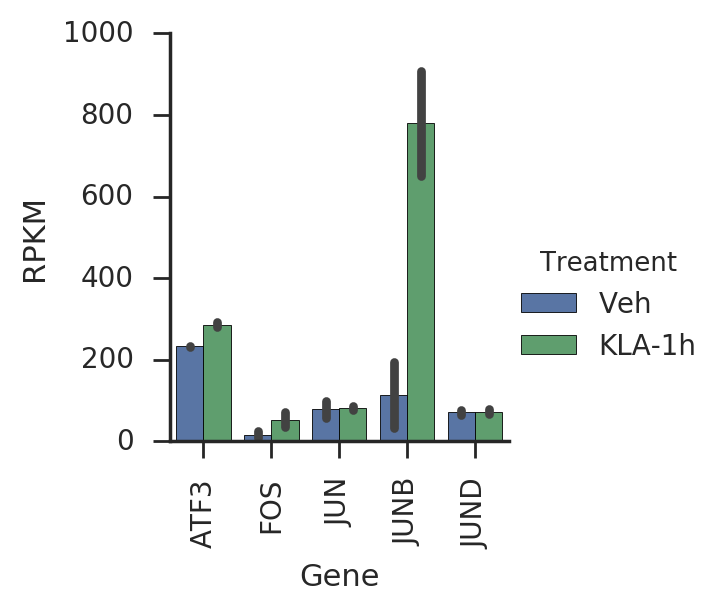

In [109]:
gene_list = ['ATF3', 'FOS', 'JUN', 'JUNB', 'JUND']


plottingFrame = rpkm_plotting_frame[rpkm_plotting_frame['Gene'].isin(gene_list)]

with sns.axes_style('ticks'):
    sns.factorplot(data = plottingFrame[plottingFrame['Genotype'] == 'Balbc'], 
                   x='Gene', y='RPKM', hue='Treatment', kind='bar', 
                   order = gene_list,
                   hue_order = ['Veh', 'KLA-1h'],
                   size=3,
                   sharey=True)

plt.xticks(rotation=90)
plt.savefig('./figures/figure_06_strains_monomer_expression.svg', bbox_inches='tight')

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

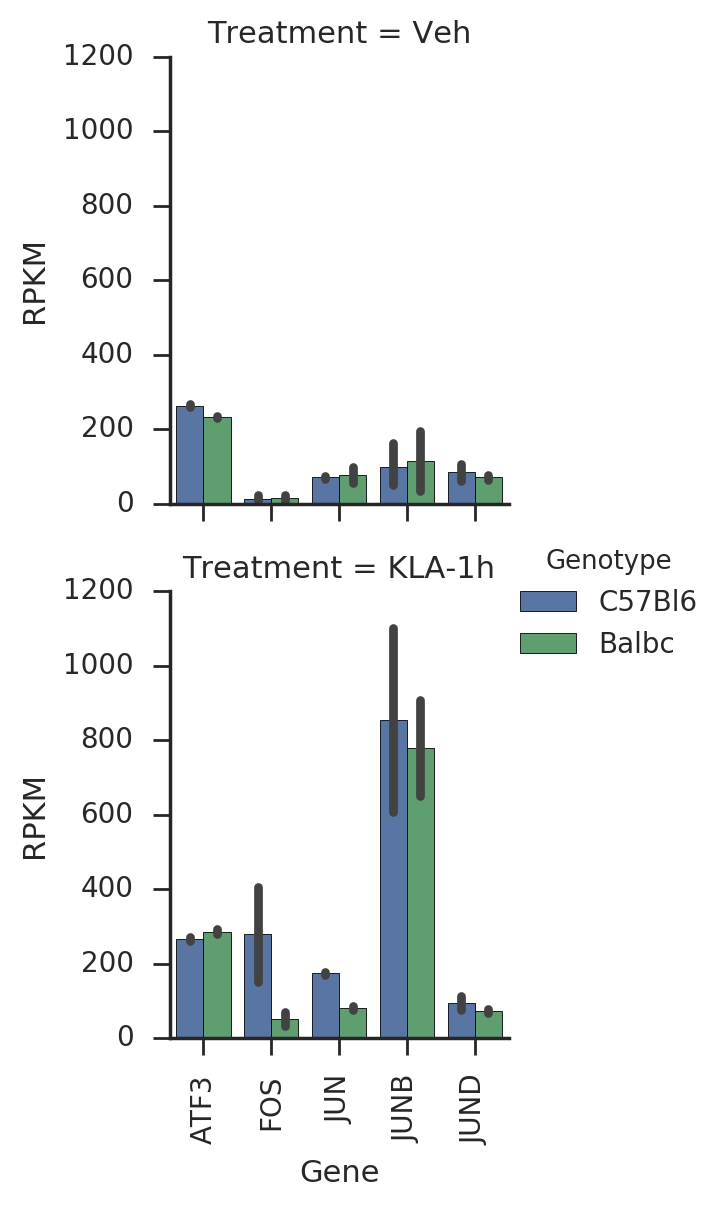

In [113]:
gene_list = ['ATF3', 'FOS', 'JUN', 'JUNB', 'JUND']


plottingFrame = rpkm_plotting_frame[rpkm_plotting_frame['Gene'].isin(gene_list)]

with sns.axes_style('ticks'):
    sns.factorplot(data = plottingFrame, 
                   x='Gene', y='RPKM', hue='Genotype', kind='bar', 
                   order = gene_list,
                   row = 'Treatment',
                   size=3,
                   sharey=True)

plt.xticks(rotation=90)

## Differential Gene Expression

In [77]:
## %%capture
! analyzeRepeats.pl rna mm10 -count exons -condenseGenes -noadj -d  ~/analysis/ap1_analysis/tag_directories_rna/C57Bl6_*Veh*UT*/ ~/analysis/ap1_analysis/tag_directories_rna/*KLA-1h*UT*/ /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories_rna/Balbc*/ > reads_strains.tsv


	Tag Directories:
		/gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_Veh_UT_CR_12-03-09/
		/gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_Veh_UT_GFEW_16-02-04/
		/gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_Veh_UT_VML_15-02-17/
		/gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories_rna/Balbc_Thiomac_RNA_KLA-1h_UT_VML_14-12-01/
		/gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories_rna/Balbc_Thiomac_RNA_KLA-1h_UT_VML_15-02-26/
		/gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_KLA-1h_UT_CR_12-03-09/
		/gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_KLA-1h_UT_VML_15-02-17/
		/gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories_rna/Balbc_Thiomac_RNA_KLA-1h_UT_VML_14-12-01/
		/gpfs/data01/glasslab/home/jtao/analysis/

In [96]:
with open('./reads_strains.tsv') as f:
    header = f.readline()

conditions = ' '.join(['_'.join(x.replace('Thiomac_RNA_','').split('/')[-2].split('_')[:2]) for x in header.split('\t')[8:]])
! getDiffExpression.pl ./reads_strains.tsv -AvsA -edgeR $conditions > ./diff_expression_strains.tsv


	Differential Expression Program: edgeR
	Autodetecting input file format...
	Using edgeR to calculate differential expression/enrichment...
	Autodetected analyzeRepeats.pl file
	Output Stats C57Bl6_Veh vs. Balbc_KLA-1h:
		Total Genes: 24453
		Total Up-regulated in Balbc_KLA-1h vs. C57Bl6_Veh: 853 (3.488%) [log2fold>1, FDR<0.05]
		Total Dn-regulated in Balbc_KLA-1h vs. C57Bl6_Veh: 977 (3.995%) [log2fold<-1, FDR<0.05]
	Output Stats C57Bl6_Veh vs. C57Bl6_KLA-1h:
		Total Genes: 24453
		Total Up-regulated in C57Bl6_KLA-1h vs. C57Bl6_Veh: 123 (0.503%) [log2fold>1, FDR<0.05]
		Total Dn-regulated in C57Bl6_KLA-1h vs. C57Bl6_Veh: 0 (0.000%) [log2fold<-1, FDR<0.05]
	Output Stats C57Bl6_Veh vs. Balbc_Veh:
		Total Genes: 24453
		Total Up-regulated in Balbc_Veh vs. C57Bl6_Veh: 58 (0.237%) [log2fold>1, FDR<0.05]
		Total Dn-regulated in Balbc_Veh vs. C57Bl6_Veh: 46 (0.188%) [log2fold<-1, FDR<0.05]
	Output Stats Balbc_KLA-1h vs. C57Bl6_KLA-1h:
		Total Genes: 24453
		Total Up-regulated in C57Bl6_KLA-1

In [103]:
diff_expression_strains_frame = pd.read_csv('./diff_expression_strains.tsv', sep = '\t')
diff_expression_strains_frame.index = [x.split('|')[0].upper() for x in diff_expression_strains_frame['Annotation/Divergence'].values]
diff_expression_strains_frame = diff_expression_strains_frame[
    [x for x in diff_expression_strains_frame.columns if 'adj.' in x or 'Fold' in x]]

In [97]:
[x for x in diff_expression_strains_frame.columns if 'adj.' in x]

['C57Bl6_Veh vs. Balbc_KLA-1h adj. p-value',
 'C57Bl6_Veh vs. C57Bl6_KLA-1h adj. p-value',
 'C57Bl6_Veh vs. Balbc_Veh adj. p-value',
 'Balbc_KLA-1h vs. C57Bl6_KLA-1h adj. p-value',
 'Balbc_KLA-1h vs. Balbc_Veh adj. p-value',
 'C57Bl6_KLA-1h vs. Balbc_Veh adj. p-value']

In [106]:
diff_expression_strains_frame[diff_expression_strains_frame['C57Bl6_Veh vs. Balbc_Veh adj. p-value'] < 0.05].index.values

array(['H2-EA-PS', 'ACSS2', 'MT3', 'CHST10', 'AMDHD1', 'GM15772',
       'GM14548', 'USP2', 'GBP2B', 'ATP6V0C-PS2', 'FBLIM1', 'MIR466N',
       'TIFAB', 'GM867', 'PIRA11', 'SIGLEC1', 'H2-T10', 'TMEM181C-PS',
       'ADGRE5', 'NGFRAP1', '1810022K09RIK', 'ARG2', 'GM4759', 'MARVELD2',
       'ZFP459', 'H2-Q1', 'PLEKHG1', 'SGSH', 'HDAC9', 'CADM1', 'TOR3A',
       'LRRC27', 'VSIG8', '5830417I10RIK', 'LACC1', 'RPL26',
       '2610507I01RIK', 'H2-Q8', 'MFGE8', 'PIRA6', 'CAND2', 'AA388235',
       'FAM19A2', 'ACSL3', 'B930041F14RIK', 'DPPA3', 'C5AR2', 'GM12191',
       'RPS25', 'ARHGAP19', 'GDF15', 'LILRA6', 'ARFGEF3', 'C5AR1', 'SIK1',
       'ATP6V0E2', 'H2-DMB1', 'TRIM12A', 'RPL30', 'CHIC1', 'CTSE', 'C1QB',
       '2610035D17RIK', 'C1QC', 'WDFY1', 'ADA', 'RAMP1', 'COLEC12',
       'IFI202B', 'ZFP30', 'CD28', 'GDF3', '4930523C07RIK', 'KLRA3',
       'MAMDC2', '2210011C24RIK', 'H2-Q6', 'GPR183', 'H2-Q5', 'ARSB',
       'IFI44', 'CYP4F18', 'QPCT', 'BAIAP2L1', 'VILL', 'IFI44L', 'TSPAN32',
      

In [108]:
diff_expression_strains_frame[diff_expression_strains_frame['Balbc_KLA-1h vs. C57Bl6_KLA-1h adj. p-value'] < 0.05].index.values

array(['ZHX2', 'H2-EA-PS', '1810034E14RIK', 'MLLT4', 'SPIB', 'ACSS2',
       'PTTG1', 'EBF1', 'GDE1', 'RPL32L', 'HIST2H2BE', 'S100A4', 'GNG7',
       'ASB4', 'MT3', 'FOLR2', 'KANK2', 'SNN', 'SNORA81', 'CD72', 'SPHK1',
       'FGGY', 'GM16576', 'CHST10', 'FZD8', 'GBP7', 'LTBP2', 'NDC80',
       'NXPE4', 'DYNLT1B', 'AMDHD1', 'GM15772', 'THBS2', 'SPP1',
       'D630041G03RIK', 'PNP2', 'FRAT2', 'GM14548', 'USP2', 'AR', 'MAP9',
       'ICOSL', 'ATP10D', 'PTPN14', 'MARCKSL1', 'C1QA', 'IRG1', 'H2AFZ',
       'XLR4A', 'PARVG', 'MEF2B', 'SLCO2B1', 'PDP1', 'B4GALT4',
       'LOC100038947', 'TRF', 'ADAMTS1', 'TSPO', 'A730017L22RIK', 'TCAF1',
       'PTBP2', 'D030025P21RIK', 'ITGB3', 'SFN', 'GBP2B', 'MIR5132',
       'C920006O11RIK', 'RSAD2', 'SLC25A42', 'RASL11A', 'UNC5A', 'EAR12',
       'ARMCX6', 'ZFP658', 'NBL1', 'CEP164', 'CD1D1', 'ATP6V0C-PS2',
       'COL16A1', 'FAM132A', 'ARHGEF37', 'FBLIM1', 'TFPI', 'HTR2B',
       'CXCL14', 'NIN', 'SLC46A3', 'MIR466N', 'FAM169B', 'ZFP775',
       'FIGNL2

## Number of strain specific sites

### Find Position of SNPs at strain specific sites

In [82]:
def read_fasta(file_path):
    '''
    reads in a fasta file and returns a list of sequence ids and a list of sequences
    inputs: filepath - path to a fasta file
    outputs: sequence_list - a list of sequences
             id_list - a list of ids
    '''
    with open(file_path) as f:
        data = f.readlines()
    id_list = []
    sequence_list = []
    # loop through each sequence
    for line in data:
        if '>' in line:
            seq_id = line.strip()[1:]
            id_list.append(seq_id)
        else:
            seq = line.strip()
            sequence_list.append(seq)
    return sequence_list, id_list

In [83]:
def convert_sequences_to_array(sequences):
    '''
    inputs: sequence of nucleotides represented as a string composed of A, C, G, T
    outputs: a list of numpy array representations of a sequence with:
             A = [1, 0, 0, 0]
             C = [0, 1, 0, 0]
             G = [0, 0, 1, 0]
             T = [0, 0, 0, 1]
             
    '''
    nucleotide_array_dict = {'A': [1, 0, 0, 0],
                             'C': [0, 1, 0, 0],
                             'G': [0, 0, 1, 0],
                             'T': [0, 0, 0, 1],
                             'N': [0, 0, 0, 0]}
    sequence_array_list = []
    for seq in sequences:
        seq_array = []
        for nuc in seq:
            seq_array.append(nucleotide_array_dict[nuc])
        seq_array = np.array(seq_array, dtype=np.int8)
        sequence_array_list.append(seq_array)
    return sequence_array_list

In [84]:
balbc_sequences, balbc_ids = read_fasta('./BALBCJ.fa')
c57bl6_sequences, c57bl6_ids = read_fasta('./C57BL6J.fa')

# convert sequences to arrays
balbc_seq_arrays = convert_sequences_to_array(balbc_sequences)
c57bl6_seq_arrays = convert_sequences_to_array(c57bl6_sequences)

# create pandas series
c57bl6_seq_arrays = pd.Series(c57bl6_seq_arrays, c57bl6_ids)
balbc_seq_arrays = pd.Series(balbc_seq_arrays, balbc_ids)


In [85]:
id_sequence_balbc_dict = dict(zip(balbc_ids, balbc_sequences))

id_sequence_c57bl6_dict = dict(zip(c57bl6_ids, c57bl6_sequences))

## Fraction of Peaks with a SNP

In [86]:
monomer_list = []
treatment_list = []
fraction_list = []
positions = range(200)
for treatment in ['veh', 'kla']:
    if treatment == 'veh':
        monomers = ['atf3', 'cjun', 'jund']
    else:
        monomers = ['atf3', 'cjun', 'fos', 'junb', 'jund']
    for i in range(len(monomers)):
        monomer = monomers[i]
        # find where monomer binds
        monomer_indices= summary_frame[(summary_frame['c57bl6_' + monomer + '_'+ treatment] > 0) |
                                       summary_frame['balbc_' + monomer + '_'+ treatment] > 0].index.values 
        num_mutated_peaks = 0
        for ind in monomer_indices:
            c57bl6_seq = c57bl6_seq_arrays[ind]
            balbc_seq = balbc_seq_arrays[ind]
            # if sequence lengths are the same
            if c57bl6_seq.shape[0] == balbc_seq.shape[0]:
                has_snp = ((c57bl6_seq + balbc_seq).max(axis=1) == 1)
                snp_positions = [x for x in positions if has_snp[x]]
                if len(snp_positions) > 0:
                    num_mutated_peaks += 1
        mutated_fraction = num_mutated_peaks/len(monomer_indices)
        print(monomer, treatment, mutated_fraction)
        fraction_list.append(mutated_fraction)
        treatment_list.append(treatment)
        monomer_list.append(monomer)
frame = pd.DataFrame({'Mutated Fraction':fraction_list,
                     'Monomer':monomer_list,
                     'Treatment':treatment_list})
# sns.factorplot(data = frame, 
#                x = 'Monomer', 
#                kind='bar',
#                y = 'Mutated Fraction', 
#                col = 'Treatment')
    



atf3 veh 0.14760988815273918
cjun veh 0.14068020036910098
jund veh 0.14433390098891577
atf3 kla 0.14550247116968698
cjun kla 0.13931694121056953
fos kla 0.1427476661557754
junb kla 0.14364505454099766
jund kla 0.14496472097498397


In [87]:
frame

Monomer  Mutated Fraction Treatment
0    atf3          0.147610       veh
1    cjun          0.140680       veh
2    jund          0.144334       veh
3    atf3          0.145502       kla
4    cjun          0.139317       kla
5     fos          0.142748       kla
6    junb          0.143645       kla
7    jund          0.144965       kla

## Fraction of Peaks that are Strain Specific after normalization

In [91]:
monomer_list = []
treatment_list = []
bal_specific_fraction_list = []
c57_specific_fraction_list = []
threshold = 2
pseudocount = 1
for treatment in ['veh', 'kla']:
    if treatment == 'veh':
        monomers = monomers = ['atf3', 'cjun', 'jund']
    else:
        monomers = monomers = ['atf3', 'cjun', 'fos', 'junb', 'jund']
    for i in range(len(monomers)):
        monomer = monomers[i]
        # find where monomer binds
        monomer_indices= summary_frame[(summary_frame['c57bl6_' + monomer + '_'+ treatment] > 0) |
                                       summary_frame['balbc_' + monomer + '_'+ treatment] > 0].index.values 
        
        balbc_tags = ap1_meanTag_frame.ix[monomer_indices,'balbc_' + monomer + '_' + treatment]
        c57bl6_tags = ap1_meanTag_frame.ix[monomer_indices,'c57bl6_' + monomer + '_' + treatment]
        
        normed_balbc_tags, normed_c57bl6_tags = quantile_normalize(balbc_tags, c57bl6_tags)  
        
        fold_changes = (normed_c57bl6_tags + pseudocount) / (normed_balbc_tags + pseudocount)
        fold_changes = pd.Series(fold_changes, index = monomer_indices)
        
        c57bl6_specific_indices = set(fold_changes[fold_changes >= threshold].index.values)
        balbc_specific_indices = set(fold_changes[fold_changes <= 1/threshold].index.values)
        
        num_peaks = len(monomer_indices)

        balbc_fraction = len(balbc_specific_indices)/num_peaks
        c57bl6_fraction = len(c57bl6_specific_indices)/num_peaks
        
        monomer_list = monomer_list + [monomer]
        treatment_list=treatment_list + [treatment]

        c57_specific_fraction_list.append(c57bl6_fraction)
        bal_specific_fraction_list.append(balbc_fraction)
        print(monomer, num_peaks, len(balbc_specific_indices), len(c57bl6_specific_indices))
frame = pd.DataFrame({'Monomer':monomer_list,
                     'Treatment':treatment_list,
                     'C57 Specific Fraction':c57_specific_fraction_list,
                     'BAL Specific Fraction':bal_specific_fraction_list
                     })
            
    


atf3 28074 2591 2466
cjun 18965 2244 2153
jund 33471 1950 1982
atf3 45525 3698 3698
cjun 20701 1733 1717
fos 43062 3161 3050
junb 24477 3473 3080
jund 42093 2381 2470


In [92]:
frame

BAL Specific Fraction  C57 Specific Fraction Monomer Treatment
0               0.092292               0.087839    atf3       veh
1               0.118323               0.113525    cjun       veh
2               0.058259               0.059215    jund       veh
3               0.081230               0.081230    atf3       kla
4               0.083716               0.082943    cjun       kla
5               0.073406               0.070828     fos       kla
6               0.141888               0.125832    junb       kla
7               0.056565               0.058680    jund       kla

## Fraction of Strain Specific Peaks that have a SNP

atf3 veh 0.29670098760243746 1412
cjun veh 0.22100760456273763 930
jund veh 0.3317808219178082 1211
atf3 kla 0.32661348803480783 2252
cjun kla 0.2587369711833231 844
fos kla 0.3150943396226415 1837
junb kla 0.21133280127693535 1324
jund kla 0.38172521120498 1717


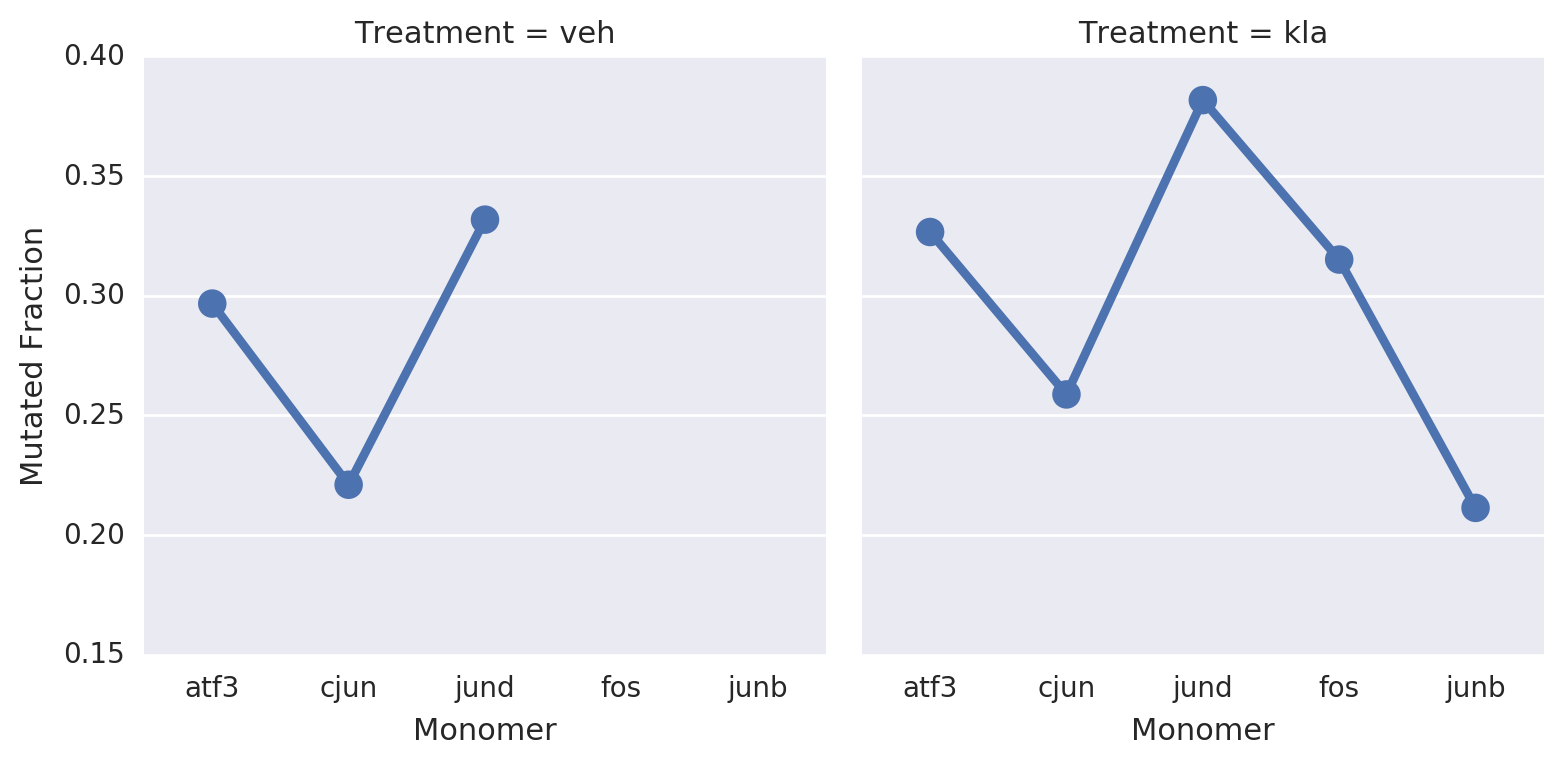

In [93]:
monomer_list = []
treatment_list = []
fraction_list = []
pseudocount = 1
threshold = 2
for treatment in ['veh', 'kla']:
    if treatment == 'veh':
        monomers = monomers = ['atf3', 'cjun', 'jund']
    else:
        monomers = monomers = ['atf3', 'cjun', 'fos', 'junb', 'jund']
    for i in range(len(monomers)):
        monomer = monomers[i]
        # find where monomer binds
        monomer_indices= summary_frame[(summary_frame['c57bl6_' + monomer + '_'+ treatment] > 0) |
                                       summary_frame['balbc_' + monomer + '_'+ treatment] > 0].index.values 
        
        balbc_tags = ap1_meanTag_frame.ix[monomer_indices,'balbc_' + monomer + '_' + treatment] 
        c57bl6_tags = ap1_meanTag_frame.ix[monomer_indices,'c57bl6_' + monomer + '_' + treatment]
        
        normed_balbc_tags, normed_c57bl6_tags = quantile_normalize(balbc_tags, c57bl6_tags)  
        
        fold_changes = (normed_c57bl6_tags + pseudocount) / (normed_balbc_tags + pseudocount)
        fold_changes = pd.Series(fold_changes, index = monomer_indices)
        
        c57bl6_specific_indices = set(fold_changes[fold_changes >= threshold].index.values)
        balbc_specific_indices = set(fold_changes[fold_changes <= 1/threshold].index.values)
        
        strain_specific_indices = c57bl6_specific_indices.union(balbc_specific_indices)
        num_mutated_peaks = 0
        num_peaks = 0
        for ind in strain_specific_indices:
            c57bl6_seq = c57bl6_seq_arrays[ind]
            balbc_seq = balbc_seq_arrays[ind]
            # if sequence lengths are the same
            if c57bl6_seq.shape[0] == balbc_seq.shape[0]:
                num_peaks +=1
                has_snp = ((c57bl6_seq + balbc_seq).max(axis=1) == 1)
                if np.sum(has_snp) > 0:
                    num_mutated_peaks += 1
#             else:
#                 num_peaks += 1
#                 num_mutated_peaks += 1
        mutated_fraction = num_mutated_peaks/num_peaks
        print(monomer, treatment, mutated_fraction, num_mutated_peaks)
        fraction_list.append(mutated_fraction)
        treatment_list.append(treatment)
        monomer_list.append(monomer)
frame = pd.DataFrame({'Mutated Fraction':fraction_list,
                     'Monomer':monomer_list,
                     'Treatment':treatment_list})
sns.factorplot(data = frame, x = 'Monomer', y = 'Mutated Fraction', col = 'Treatment')
    




## Correlations of Individual Motif Score Changes with Strain Specific Binding

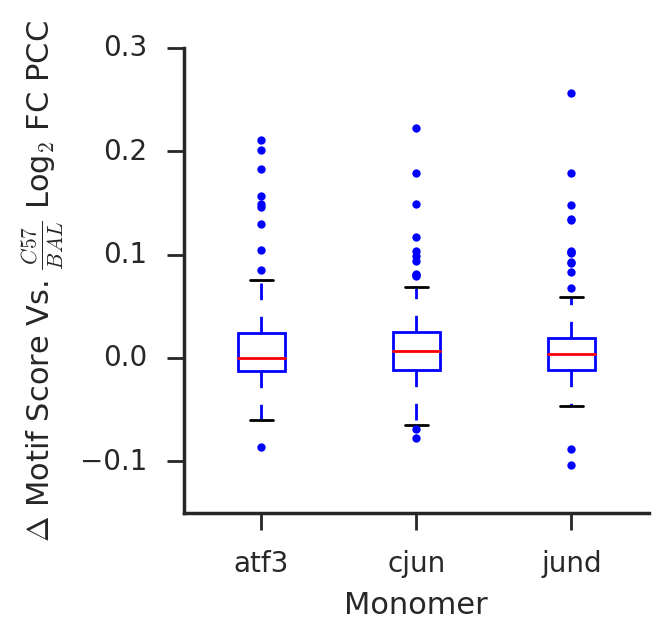

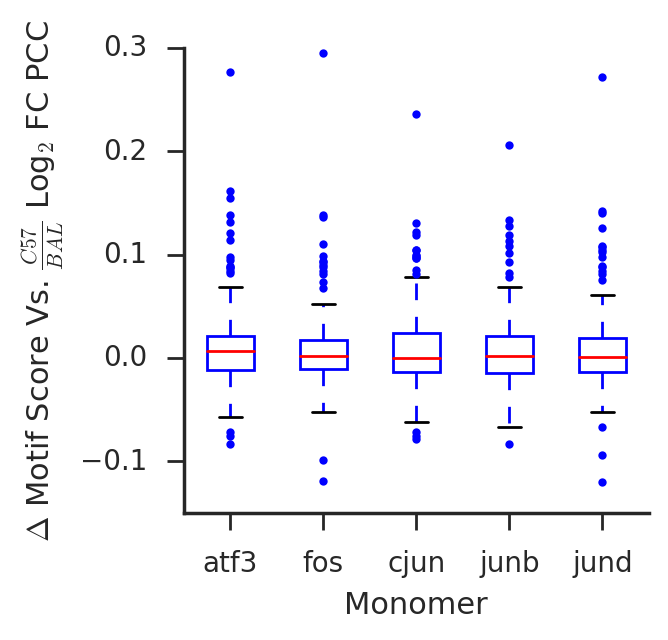

In [163]:
# for monomers using the best motif scores for each motif
motif_score_differences_frame = motif_score_frame.ix[:,3:] - motif_score_balbc_frame.ix[:,3:]
threshold = 1
motifs = motif_score_differences_frame.columns.values
monomerTreatment_correlations_dict = {}
for treatment in ['veh', 'kla']:
    if treatment == 'veh':
        monomers = ['atf3', 'cjun', 'jund']
    else:
        monomers = ['atf3', 'cjun', 'fos', 'junb', 'jund']
    for i in range(len(monomers)):
        monomer = monomers[i]
        # find where monomer binds
        monomer_indices= summary_frame[(summary_frame['c57bl6_' + monomer + '_'+ treatment] > 0) |
                                       summary_frame['balbc_' + monomer + '_'+ treatment] > 0].index.values 
        mutated_indices = []
        for ind in monomer_indices:
            c57bl6_seq = c57bl6_seq_arrays[ind]
            balbc_seq = balbc_seq_arrays[ind]
            # if sequence lengths are the same
            if c57bl6_seq.shape[0] == balbc_seq.shape[0]:
                has_snp = ((c57bl6_seq + balbc_seq).max(axis=1) == 1)
                if np.sum(has_snp) > 0:
                    mutated_indices.append(ind)

        
        balbc_tags = ap1_meanTag_frame.ix[monomer_indices,'balbc_' + monomer + '_' + treatment] 
        c57bl6_tags = ap1_meanTag_frame.ix[monomer_indices,'c57bl6_' + monomer + '_' + treatment]
        
        normed_balbc_tags, normed_c57bl6_tags = quantile_normalize(balbc_tags, c57bl6_tags)  
        
        fold_changes = (normed_c57bl6_tags + pseudocount) / (normed_balbc_tags + pseudocount)
        fold_changes = pd.Series(fold_changes, index = monomer_indices)
        log_fold_changes = np.log2(fold_changes)
        
        c57bl6_specific_indices = set(fold_changes[fold_changes >= threshold].index.values)
        balbc_specific_indices = set(fold_changes[fold_changes <= 1/threshold].index.values)
        strain_specific_indices = c57bl6_specific_indices.union(balbc_specific_indices).intersection(mutated_indices)
        
        pearsons = []
        
        for motif in motifs:
            motif_score_changes = motif_score_differences_frame.ix[strain_specific_indices, motif]
            pearson, pval = scipy.stats.pearsonr(motif_score_changes, log_fold_changes[strain_specific_indices])
            pearsons.append(pearson)
        monomerTreatment_correlations_dict[monomer + '_' + treatment] = pearsons
            



for treatment in ['veh', 'kla']:
    if treatment == 'veh':
        monomers = ['atf3', 'cjun', 'jund']
    else:
        monomers = ['atf3', 'fos', 'cjun', 'junb', 'jund']
    with sns.axes_style('ticks'):
        plt.figure(figsize=(3,3))
        vals = [monomerTreatment_correlations_dict[m +'_' +treatment] for m in monomers]
        plt.boxplot(vals, showfliers=True, sym='.',patch_artist=True)
        plt.xticks(range(1,len(monomers)+1), monomers)
        plt.ylabel(r'$\Delta$ Motif Score Vs. $\frac{C57}{BAL}$ Log$_2$ FC PCC')
        plt.xlabel('Monomer')
        sns.despine()
        plt.savefig('./figures/figure_06_motif_strainSpecificBinding_correlation_boxplot_'+treatment+'.pdf',bbox_inches='tight')
        plt.show()

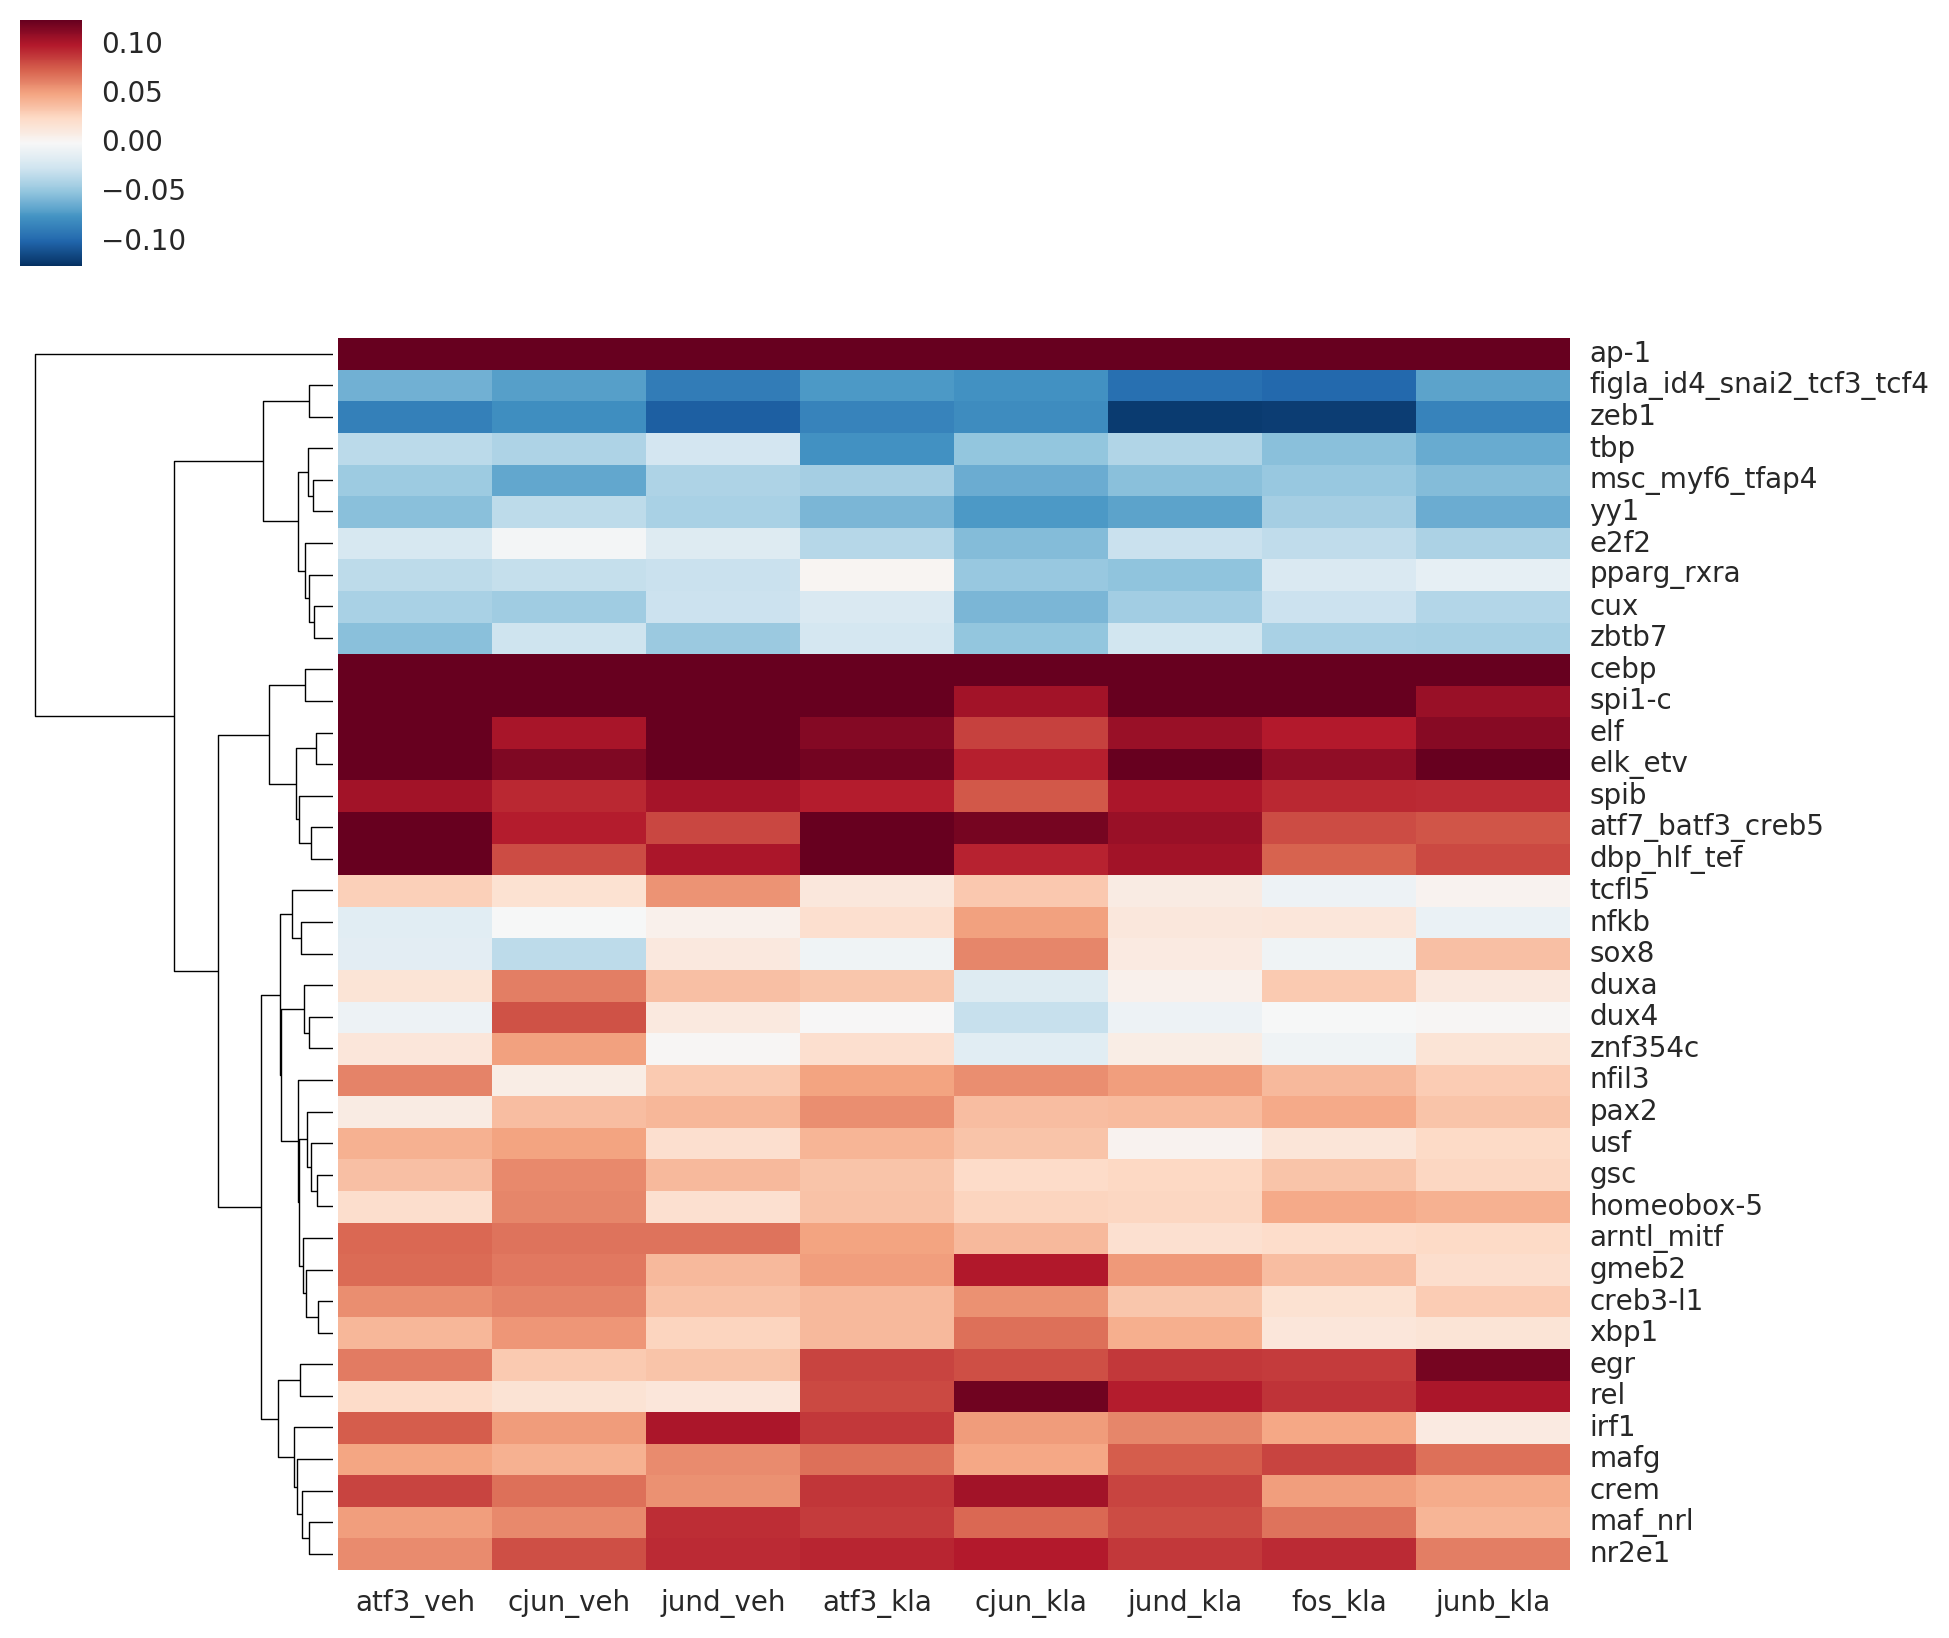

In [165]:
strain_motif_binding_correlation_frame = pd.DataFrame(monomerTreatment_correlations_dict,
                                                      index = motifs)

threshold = 0.05
data = strain_motif_binding_correlation_frame[strain_motif_binding_correlation_frame.abs().max(axis=1) > threshold]
cg = sns.clustermap(data[['atf3_veh','cjun_veh','jund_veh',
                          'atf3_kla','cjun_kla','jund_kla','fos_kla','junb_kla']],
                    vmin = -0.125,
                    vmax = 0.125,
                    col_cluster=False)
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), 
         fontsize=10, 
         rotation=0);
plt.savefig('./figures/figure_06_motif_strainSpecificBinding_correlation_heatmap.pdf',bbox_inches='tight')



## VIF Analysis of Motif Score Changes

In [322]:
### calculate VIFs for vehicle data ###
motif_score_differences_frame = motif_score_frame.ix[:,3:] - motif_score_balbc_frame.ix[:,3:]
factorTreatment_mutation_vif_dict = {}

for treatment in ['veh', 'kla']:
    if treatment == 'veh':
        members = ['atf3', 'cjun', 'jund']
    else:
        members = ['atf3', 'cjun', 'fos', 'junb', 'jund']
    for i in range(len(members)):
        start = time.time()
        monomer = members[i]
        monomer_indices= summary_frame[(summary_frame['c57bl6_' + monomer + '_'+ treatment] > 0) |
                                       summary_frame['balbc_' + monomer + '_'+ treatment] > 0].index.values
        motif_score_changes = motif_score_differences_frame.ix[monomer_indices]
        vifs = calculateVIF(motif_score_changes)
        factorTreatment_mutation_vif_dict['_'.join([strain, monomer, treatment])] = vifs
        end = time.time()
        print(monomer, treatment, end - start)

atf3 veh 14.028110027313232
cjun veh 10.053351402282715
jund veh 19.88895034790039
atf3 kla 33.631715536117554
cjun kla 13.425570249557495
fos kla 34.184590101242065
junb kla 15.161710500717163
jund kla 31.165645122528076


In [323]:
vif_mutation_frame = pd.DataFrame(factorTreatment_mutation_vif_dict)

frame = pd.DataFrame(vif_mutation_frame.stack(), columns = ['VIF'])
indices = vif_mutation_frame.stack().index.values
frame['Motif'] = [x[0] for x in indices]
frame['Monomer'] = [x[1].split('_')[1] for x in indices]
frame['Treatment'] = [x[1].split('_')[2] for x in indices]

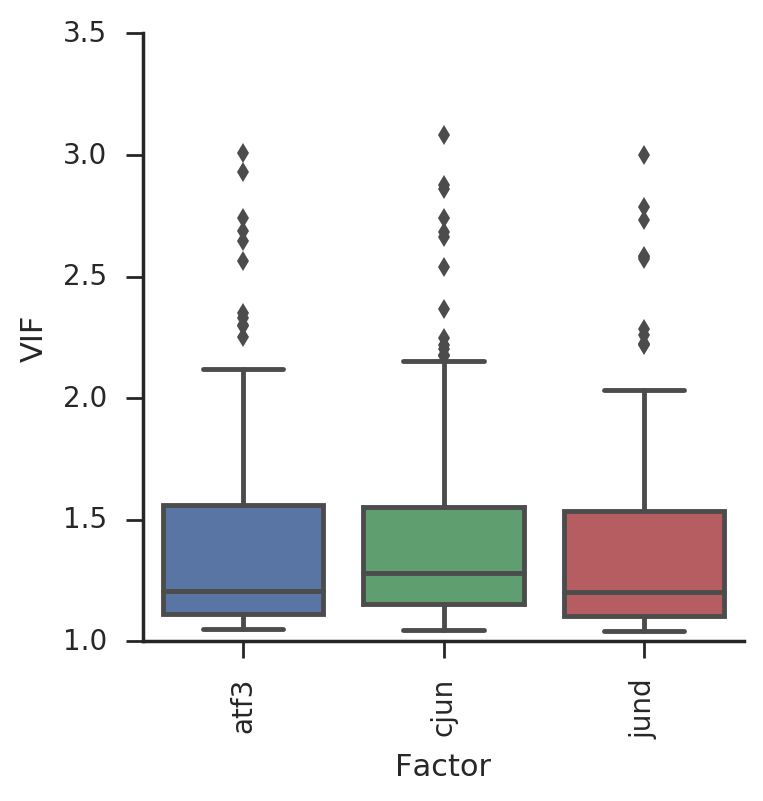

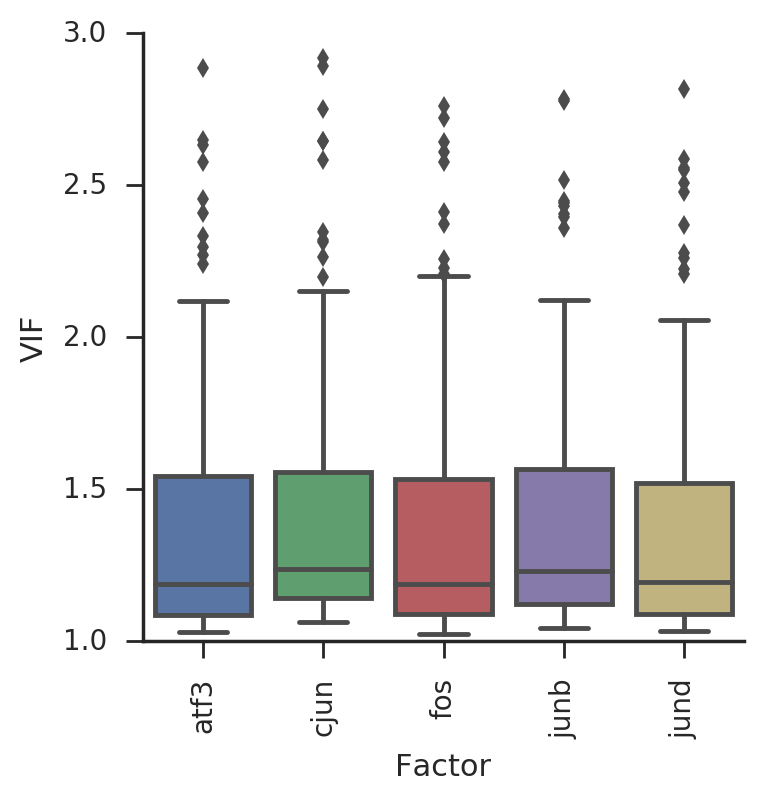

In [328]:
with sns.axes_style('ticks'):
    sns.factorplot(data =frame[frame['Treatment'] == 'veh'],
                   x = 'Factor',
                   y = 'VIF',
                   kind = 'box',
                   size=4,
                  )
# plt.ylim(0,300)
plt.xticks(rotation=90)
# plt.plot([-1,3], [10,10], c = 'black', linestyle='--')
plt.savefig('./figures/figure_06_vif_analysis_veh.pdf', bbox_inches='tight')


with sns.axes_style('ticks'):
    sns.factorplot(data = frame[frame['Treatment'] == 'kla'],
                   x = 'Factor',
                   y = 'VIF',
                   kind = 'box',
                   size=4,
                  )
# plt.ylim(0,300)
plt.xticks(rotation=90)
# plt.plot([-1,7], [10,10], c = 'black', linestyle='--')
plt.savefig('./figures/figure_06_vif_analysis_kla.pdf', bbox_inches='tight')


## C57+BAL Model Prediction of Strain Specific Binding

In [ ]:
# for monomers using the best motif scores for each motif
threshold = 1
pseudocount = 1
sns.set_style('ticks')
standardized_motif_score_differences_frame = all_standardized_score_frame - all_standardized_score_balbc_frame

for treatment in ['veh', 'kla']:
    if treatment == 'veh':
        monomers = ['atf3', 'cjun', 'jund']
        f, axes = plt.subplots(3,1, figsize=(1.5,4.5), sharey=True, sharex=True)
    else:
        monomers = ['atf3', 'fos', 'cjun', 'junb', 'jund']
        f, axes = plt.subplots(5,1, figsize=(1.5,7.5), sharey=True, sharex=True)
    for i in range(len(monomers)):
        ax = axes[i]
        monomer = monomers[i]
        monomer_indices= summary_frame[(summary_frame['c57bl6_' + monomer + '_'+ treatment] > 0) |
                                       summary_frame['balbc_' + monomer + '_'+ treatment] > 0].index.values
        
        motif_score_changes = standardized_motif_score_differences_frame.ix[monomer_indices]
        
        balbc_tags = ap1_meanTag_frame.ix[monomer_indices,'balbc_' + monomer + '_' + treatment] 
        c57bl6_tags = ap1_meanTag_frame.ix[monomer_indices,'c57bl6_' + monomer + '_' + treatment]
        normed_balbc_tags, normed_c57bl6_tags = quantile_normalize(balbc_tags, c57bl6_tags) 
        fold_changes = (normed_c57bl6_tags + pseudocount) / (normed_balbc_tags + pseudocount)
        fold_changes = pd.Series(fold_changes, index = monomer_indices)
        log_fold_changes = np.log2(fold_changes)
        
        mutated_indices = []
        for ind in monomer_indices:
            c57bl6_seq = c57bl6_seq_arrays[ind]
            balbc_seq = balbc_seq_arrays[ind]
            # if sequence lengths are the same
            if c57bl6_seq.shape[0] == balbc_seq.shape[0]:
                has_snp = ((c57bl6_seq + balbc_seq).max(axis=1) == 1)
                if np.sum(has_snp) > 0:
                    mutated_indices.append(ind)
                    
 
        lr = sklearn.linear_model.LinearRegression()
        
        lr.fit(motif_score_changes, log_fold_changes)
        predictions = lr.predict(motif_score_changes.ix[mutated_indices,:])
        pearson, pval = scipy.stats.pearsonr(predictions, log_fold_changes[mutated_indices])
        print(pearson)

        ax.scatter(log_fold_changes[mutated_indices], 
                    predictions,
                    s=1,
                    edgecolor='None',
                    )

        ax.annotate(xy=(-5.5,3.5),s='PCC='+str(round(pearson,3)),size=8)
        ax.annotate(xy=(-5.5,2.5),s='N='+str(len(strain_specific_indices)),size=8)

        ax.set_xlim(-6,6)
        ax.set_ylim(-4,4)
        ax.set_title(monomer + ' ' + treatment, size=10)
        sns.despine()
    plt.xlabel(r'$\frac{C57}{BAL}$ $Log_2$ FC')
    axes[int(len(axes)/2)].set_ylabel('C57+BAL Model Prediction')
    plt.savefig('./figures/figure_06_C57BALmodel_predictions_'+treatment+'.png', bbox_inches='tight')
    plt.savefig('./figures/figure_06_C57BALmodel_predictions_'+treatment+'.pdf', bbox_inches='tight')
    plt.show()

## Comparison of Different Models for Strain Specific Binding

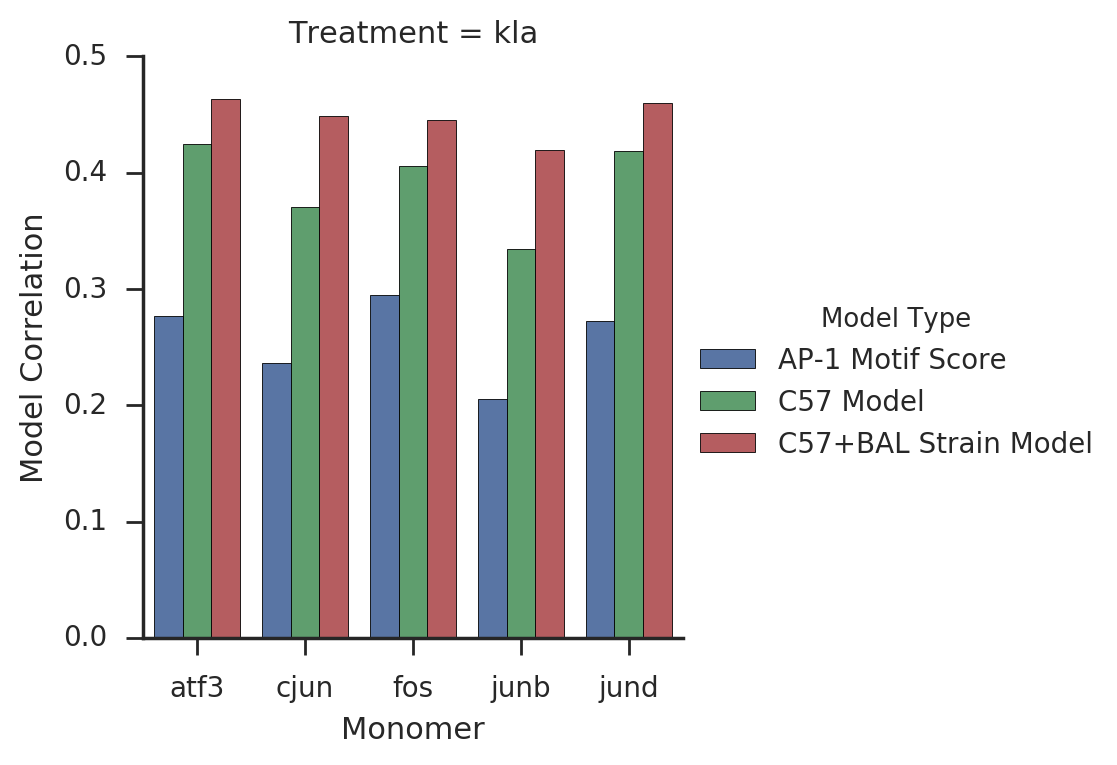

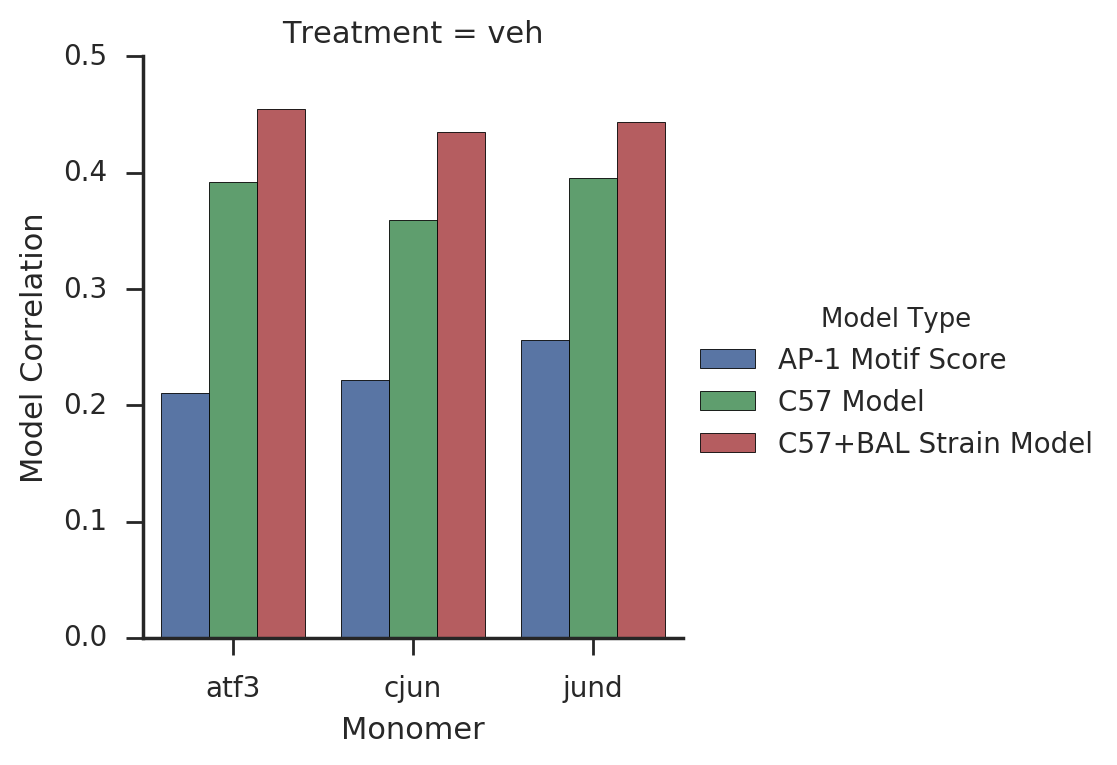

In [974]:
motif_score_differences_frame = motif_score_frame.ix[:,3:] - motif_score_balbc_frame.ix[:,3:]
standardized_motif_score_differences_frame = all_standardized_score_frame - all_standardized_score_balbc_frame

pseudocount = 1
factor_list = []
treatment_list = []
correlation_list = []
model_list = []
for treatment in ['veh', 'kla']:
    if treatment == 'veh':
        monomers = ['atf3', 'cjun', 'jund']
    else:
        monomers = ['atf3', 'cjun', 'fos', 'junb', 'jund']
    for i in range(len(monomers)):
        monomer = monomers[i]
        # find where monomer binds
        monomer_indices= summary_frame[(summary_frame['c57bl6_' + monomer + '_'+ treatment] > 0) |
                                       summary_frame['balbc_' + monomer + '_'+ treatment] > 0].index.values 
        mutated_indices = []
        for ind in monomer_indices:
            c57bl6_seq = c57bl6_seq_arrays[ind]
            balbc_seq = balbc_seq_arrays[ind]
            # if sequence lengths are the same
            if c57bl6_seq.shape[0] == balbc_seq.shape[0]:
                has_snp = ((c57bl6_seq + balbc_seq).max(axis=1) == 1)
                if np.sum(has_snp) > 0:
                    mutated_indices.append(ind)

        balbc_tags = ap1_meanTag_frame.ix[monomer_indices,'balbc_' + monomer + '_' + treatment] 
        c57bl6_tags = ap1_meanTag_frame.ix[monomer_indices,'c57bl6_' + monomer + '_' + treatment]
        
        normed_balbc_tags, normed_c57bl6_tags = quantile_normalize(balbc_tags, c57bl6_tags)  
        
        fold_changes = (normed_c57bl6_tags + pseudocount) / (normed_balbc_tags + pseudocount)
        fold_changes = pd.Series(fold_changes, index = monomer_indices)
        log_fold_changes = np.log2(fold_changes)

        motif_score_changes = motif_score_differences_frame.ix[monomer_indices]
        standardized_motif_score_changes = standardized_motif_score_differences_frame.ix[monomer_indices]
        
        l
        lr = sklearn.linear_model.LinearRegression()
        lr.fit(standardized_motif_score_changes, log_fold_changes)
        
        
        current_weights = mean_coeff_frame[monomer + '_' + treatment]

        products = current_weights * standardized_motif_score_changes
        scores = products.sum(axis=1)
        delta_pearson, pval = scipy.stats.pearsonr(scores.ix[mutated_indices], 
                                                   log_fold_changes.ix[mutated_indices])
        
        ap1_pearson, pval = scipy.stats.pearsonr(motif_score_changes.ix[mutated_indices,'ap-1'], 
                                                 log_fold_changes.ix[mutated_indices])
        
        lin_pearson, pval = scipy.stats.pearsonr(lr.predict(standardized_motif_score_changes.ix[mutated_indices]), 
                                                 log_fold_changes.ix[mutated_indices])
        
        factor_list = factor_list + 3*[monomer]
        treatment_list = treatment_list + 3*[treatment]
        correlation_list.append(ap1_pearson)
        correlation_list.append(delta_pearson)
        correlation_list.append(lin_pearson)
        
        
        model_list = model_list + ['AP-1 Motif Score', 'C57 Model', 'C57+BAL Strain Model']
        
frame = pd.DataFrame({'Monomer':factor_list,
                      'Treatment':treatment_list,
                      'Model Correlation':correlation_list,
                      'Model Type':model_list})
# plt.figure(figsize=(3,3))
with sns.axes_style('ticks'):
    sns.factorplot(data = frame[frame['Treatment']=='kla'], 
                   col = 'Treatment', 
                   x = 'Monomer', 
                   hue = 'Model Type',
                   y ='Model Correlation', 
                   kind='bar',
                   hue_order = ['AP-1 Motif Score', 'C57 Model', 'C57+BAL Strain Model'])
    plt.savefig('./figures/figure_06_model_correlation_with_strain_specific_binding_kla.svg',bbox_inches='tight')           


    sns.factorplot(data = frame[frame['Treatment']=='veh'], 
                   col = 'Treatment', 
                   x = 'Monomer', 
                   hue = 'Model Type',
                   y ='Model Correlation', 
                   kind='bar',
                   hue_order = ['AP-1 Motif Score', 'C57 Model', 'C57+BAL Strain Model'])
    plt.savefig('./figures/figure_06_model_correlation_with_strain_specific_binding_veh.svg',bbox_inches='tight')           
    

## Calculate significance of each regressor

In [275]:
# for monomers using the best motif scores for each motif
threshold = 1
sns.set_style('ticks')
motif_score_differences_frame = motif_score_frame.ix[:,3:] - motif_score_balbc_frame.ix[:,3:]
standardized_motif_score_differences_frame = all_standardized_score_frame - all_standardized_score_balbc_frame

monomer_Ftest_pval_frame = pd.DataFrame(index = motif_score_frame.columns[3:])

for treatment in ['veh', 'kla']:
    if treatment == 'veh':
        monomers = ['atf3', 'cjun', 'jund']
    else:
        monomers = ['atf3', 'fos', 'cjun', 'junb', 'jund']
    for i in range(len(monomers)):
        monomer = monomers[i]
        monomer_indices= summary_frame[(summary_frame['c57bl6_' + monomer + '_'+ treatment] > 0) |
                                       summary_frame['balbc_' + monomer + '_'+ treatment] > 0].index.values

        
        standardized_motif_score_changes = standardized_motif_score_differences_frame.ix[monomer_indices]
        
        
        balbc_tags = ap1_meanTag_frame.ix[monomer_indices,'balbc_' + monomer + '_' + treatment] 
        c57bl6_tags = ap1_meanTag_frame.ix[monomer_indices,'c57bl6_' + monomer + '_' + treatment]
        normed_balbc_tags, normed_c57bl6_tags = quantile_normalize(balbc_tags, c57bl6_tags) 
        fold_changes = (normed_c57bl6_tags + pseudocount) / (normed_balbc_tags + pseudocount)
        fold_changes = pd.Series(fold_changes, index = monomer_indices)
        log_fold_changes = np.log2(fold_changes)

        stats, pvals = sklearn.feature_selection.f_regression(standardized_motif_score_changes, log_fold_changes)
        monomer_Ftest_pval_frame[monomer + '_' + treatment] = pvals 

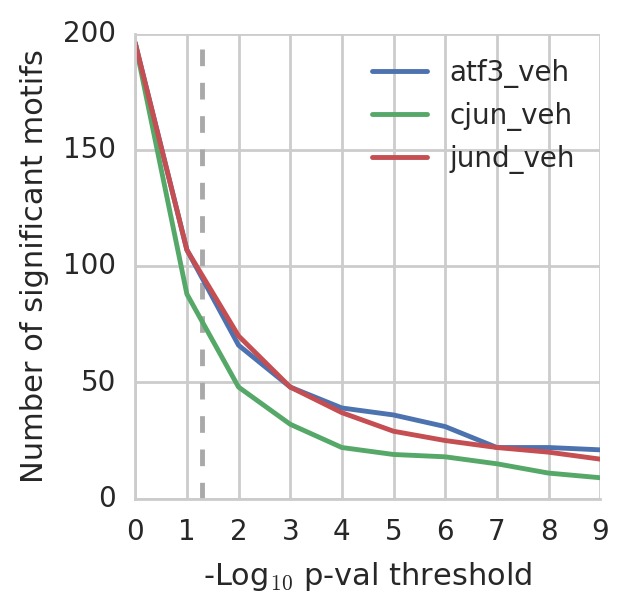

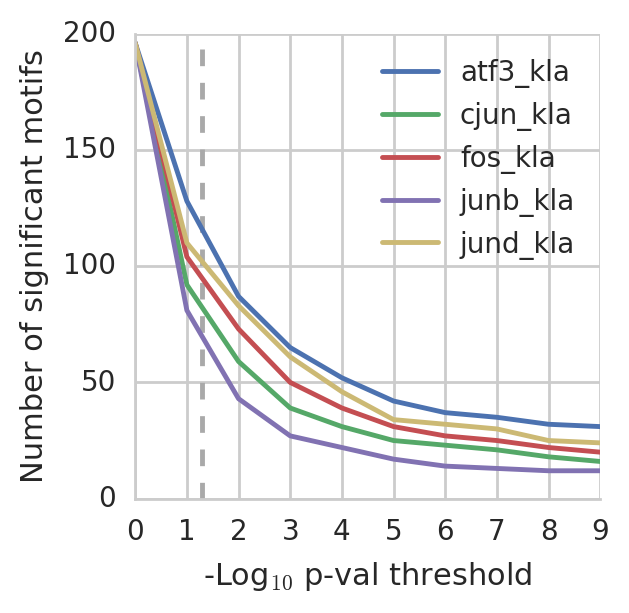

In [276]:
sns.set_style('whitegrid')
for treatment in ['veh', 'kla']:
    plt.figure(figsize=(3,3))
    if treatment == 'veh':
        members = ['atf3', 'cjun', 'jund']
    else:
        members = ['atf3', 'cjun', 'fos', 'junb', 'jund']
    for monomer in members:
        pvals = monomer_Ftest_pval_frame[monomer + '_' + treatment]
        log_pvals = -np.log10(pvals)
        
        thresholds = np.arange(0,10,1)
        num_passed_motifs = []
        for t in thresholds:
            num_significant_motifs = np.sum(log_pvals > t)
            num_passed_motifs.append(num_significant_motifs)
        plt.plot(thresholds, num_passed_motifs, label = monomer + '_' + treatment)
    plt.vlines(x=-np.log10(0.05), ymin=0, ymax = 200, linestyle = '--', color='darkgrey')
    plt.xlabel(r'-Log$_{10}$ p-val threshold')
    plt.ylabel('Number of significant motifs')
    sns.despine()    
    plt.legend()
    plt.savefig('./figures/figure_06_FtestSignificantMotifs_' + treatment + '.pdf', bbox_inches='tight')
   
    plt.show()

## Comparison of Linear Regression and Logistic Regression Coefficients

In [272]:
standardized_motif_score_differences_frame = all_standardized_score_frame - all_standardized_score_balbc_frame
factor_strain_coeff_dict = {}
for treatment in ['veh', 'kla']:

    if treatment == 'veh':
        members = ['atf3', 'cjun', 'jund']
    else:
        members = ['atf3', 'cjun', 'fos', 'junb', 'jund']
    for monomer in members:
        monomer_indices= summary_frame[(summary_frame['c57bl6_' + monomer + '_'+ treatment] > 0) |
                                       summary_frame['balbc_' + monomer + '_'+ treatment] > 0].index.values
       
        mutated_indices = []
        for ind in monomer_indices:
            c57bl6_seq = c57bl6_seq_arrays[ind]
            balbc_seq = balbc_seq_arrays[ind]
            # if sequence lengths are the same
            if c57bl6_seq.shape[0] == balbc_seq.shape[0]:
                has_snp = ((c57bl6_seq + balbc_seq).max(axis=1) == 1)
                if np.sum(has_snp) > 0:
                    mutated_indices.append(ind)
        print(len(mutated_indices))
        standardized_motif_score_changes = standardized_motif_score_differences_frame.ix[monomer_indices]
        
        balbc_tags = ap1_meanTag_frame.ix[monomer_indices,'balbc_' + monomer + '_' + treatment] 
        c57bl6_tags = ap1_meanTag_frame.ix[monomer_indices,'c57bl6_' + monomer + '_' + treatment]
        
        normed_balbc_tags, normed_c57bl6_tags = quantile_normalize(balbc_tags, c57bl6_tags)  
        
        fold_changes = (normed_c57bl6_tags + pseudocount) / (normed_balbc_tags + pseudocount)
        fold_changes = pd.Series(fold_changes, index = monomer_indices)
        log_fold_changes = np.log2(fold_changes)
        
        lr = sklearn.linear_model.LinearRegression()
        
        lr.fit(standardized_motif_score_changes, log_fold_changes)
        
        factor_strain_coeff_dict[monomer + '_' + treatment] = lr.coef_


strain_coeff_frame = pd.DataFrame(factor_strain_coeff_dict, 
                                  index= motif_score_differences_frame.columns.values)

4144
2668
4831
6624
2884
6147
3516
6102


atf3 veh 0.79106578292
cjun veh 0.719724823111
jund veh 0.812852823108


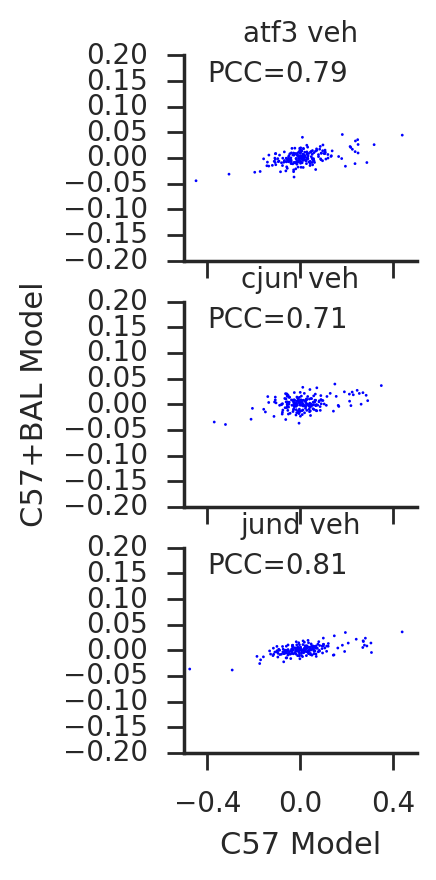

atf3 kla 0.876465667771
cjun kla 0.749443686006
fos kla 0.839130550247
junb kla 0.726471188354
jund kla 0.86472483027


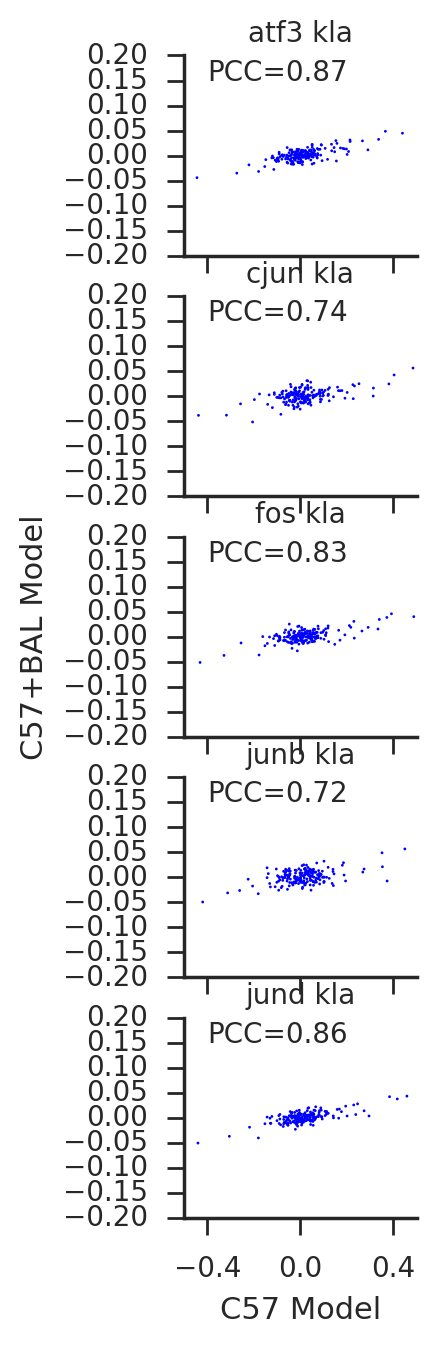

In [919]:
sns.set_style('ticks')
for treatment in ['veh', 'kla']:
    if treatment == 'veh':
        members = ['atf3', 'cjun', 'jund']
        f, axes = plt.subplots(3,1, figsize=(1.5,4.5), sharey=True, sharex=True)
    else:
        members = ['atf3', 'cjun', 'fos', 'junb', 'jund']
        f, axes = plt.subplots(5,1, figsize=(1.5,7.5), sharey=True, sharex=True)
    for i in range(len(members)):
        ax = axes[i]
        monomer = members[i]
        pearson, pval = scipy.stats.pearsonr(mean_coeff_frame[monomer + '_' + treatment],
                    strain_coeff_frame[monomer + '_' + treatment])
        print(monomer, treatment, pearson)
        ax.scatter(mean_coeff_frame[monomer + '_' + treatment],
                    strain_coeff_frame[monomer + '_' + treatment], 
                    edgecolors = 'None', s=1)

        ax.set_xticks([-0.4, 0 ,0.4])
        ax.set_title(monomer + ' ' + treatment, size=10)
        ax.set_xlim(-0.5,0.5)
        ax.set_ylim(-0.2,0.2)
        
#         ax.set_aspect(1.0)
        sns.despine()
        ax.annotate(xy=(-0.4,0.15,), s='PCC='+str(pearson)[:4], size=10)
    plt.xlabel('C57 Model')
    axes[int(len(axes)/2)].set_ylabel('C57+BAL Model')
    plt.savefig('./figures/figure_06_model_comparison_scatter_' + treatment+'.svg',bbox_inches='tight')
    plt.savefig('./figures/figure_06_model_comparison_scatter_' + treatment+'.png',bbox_inches='tight')
    plt.show()



## Visualization of Two Strain Model Weights

### Vehicle

In [955]:
num_motifs_to_include = 20
num_motifs = strain_coeff_frame.shape[0]
treatment = 'veh'
members = ['atf3', 'cjun', 'jund']
top_motifs = []
for monomer in members:
    weights = strain_coeff_frame[monomer + '_' + treatment].abs()
    weights.sort(ascending=False)
    sorted_motifs = list(weights.index.values)
    top_motifs = top_motifs + sorted_motifs[:num_motifs_to_include]
top_motifs = sorted(set(top_motifs)) 

# print(len(top_motifs))

signed_ranks_frame = strain_coeff_frame[[]]
for monomer in members:
    weights = strain_coeff_frame[monomer + '_' + treatment]
    ranks = strain_coeff_frame[monomer + '_' + treatment].abs().rank(ascending=True)
    signed_ranks = [-1 * ranks[i] if weights[i] <0 else ranks[i] for i in range(len(weights))]
    signed_ranks_frame[monomer + '_' + treatment] = signed_ranks


data = signed_ranks_frame.ix[top_motifs]
negative_data = data[data.min(axis=1) < -1*(num_motifs- num_motifs_to_include)]
positive_data = data[data.max(axis=1) >( num_motifs - num_motifs_to_include)]

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting
/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


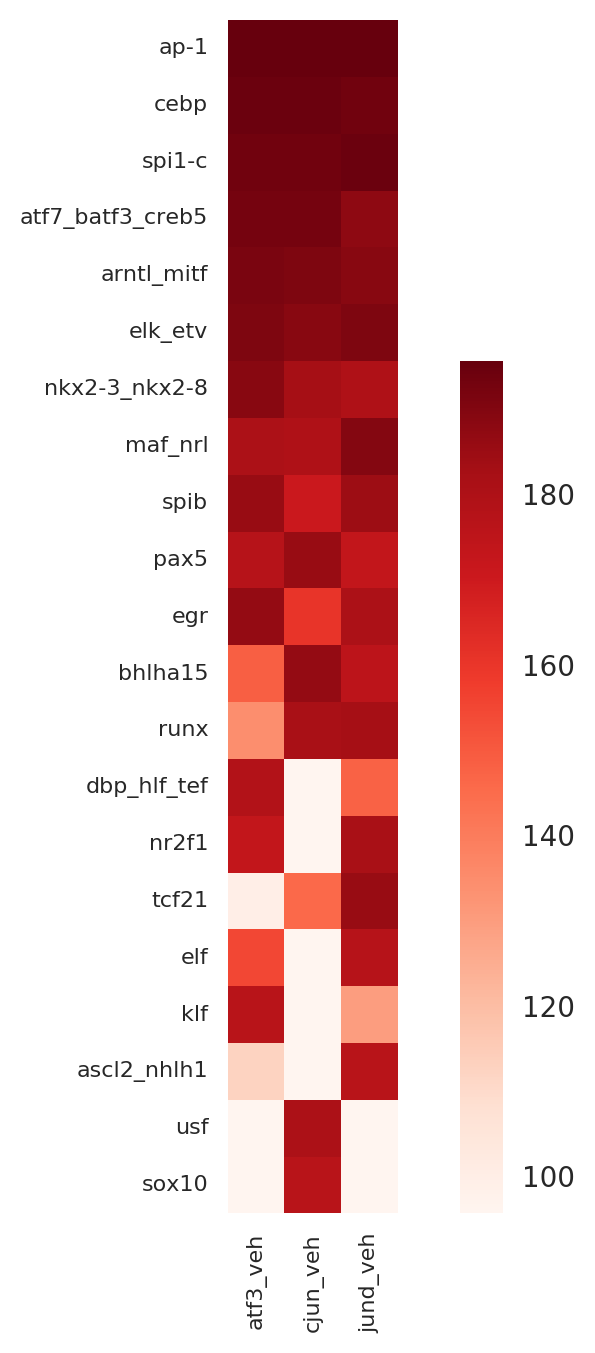

In [956]:
sns.set_style('darkgrid')
positive_data['mean'] = signed_ranks_frame.abs().mean(axis=1)
positive_data = positive_data.sort('mean', ascending=False)
del positive_data['mean']


hm = sns.heatmap(positive_data, 
                 square=True,
                 cmap = 'Reds',
                 vmax = 196,
                 vmin = 96
                 )
pos = hm.get_position()
hm.set_position([pos.x0, pos.y0, pos.width, pos.height*1.4])
hm.set_yticklabels(size=8, labels = positive_data.index.values[::-1]);
hm.set_xticklabels(size=8, labels = positive_data.columns.values);
plt.savefig('./figures/figure_06_linReg_ranks_heatmap_positive.svg', bbox_inches='tight')




/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


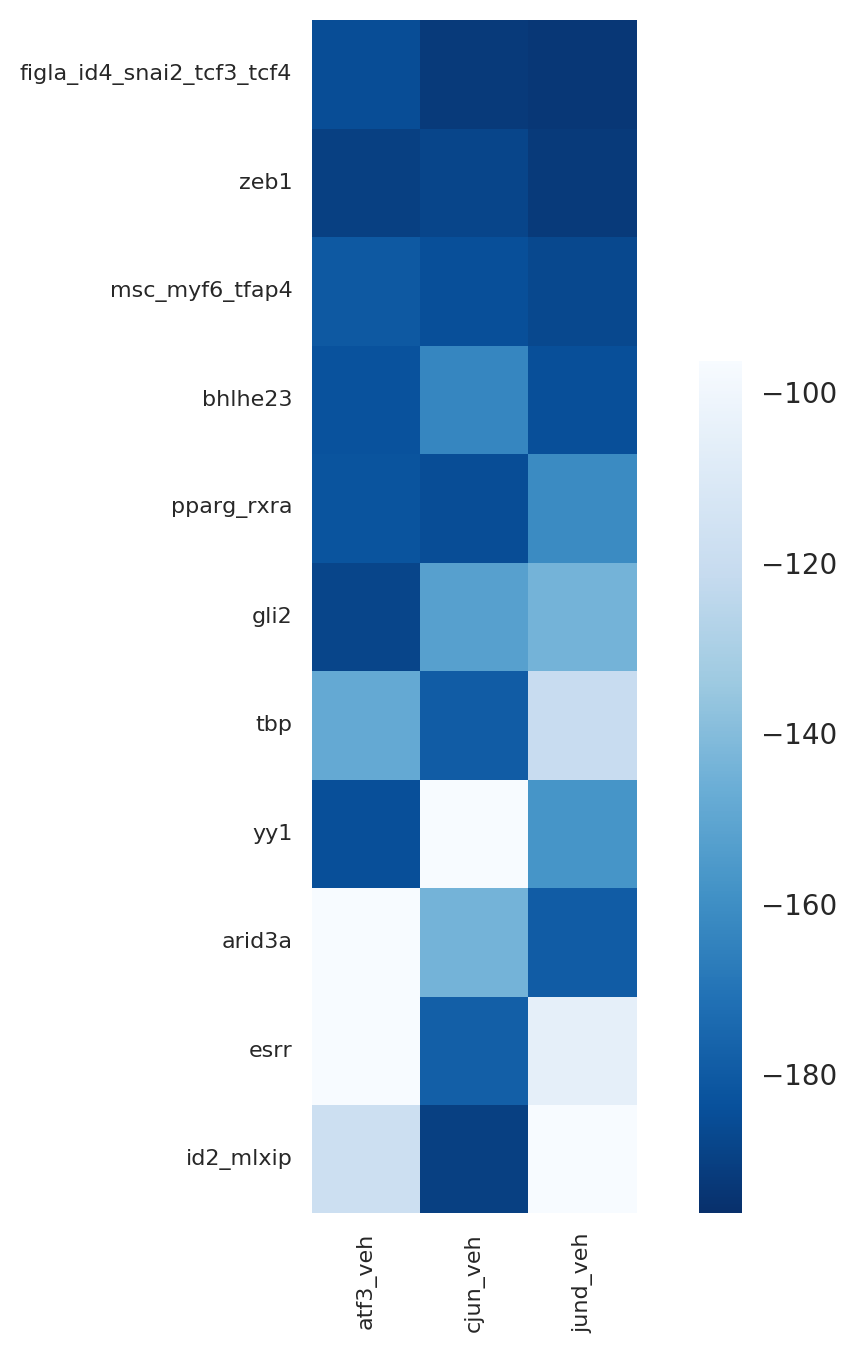

In [957]:
sns.set_style('darkgrid')
negative_data['mean'] = signed_ranks_frame.abs().mean(axis=1)
negative_data = negative_data.sort('mean', ascending=False)
del negative_data['mean']


hm = sns.heatmap(negative_data, 
                 square=True,
                 cmap = 'Blues_r',
                 vmin = -196,
                 vmax = -96
                 )
pos = hm.get_position()
hm.set_position([pos.x0, pos.y0, pos.width, pos.height*1.4])
hm.set_yticklabels(size=8, labels = negative_data.index.values[::-1]);
hm.set_xticklabels(size=8, labels = negative_data.columns.values);
plt.savefig('./figures/figure_06_linReg_ranks_heatmap_negative.svg', bbox_inches='tight')



### Calculate DeltaSVM Style Scores

atf3 veh 0.396688815438
cjun veh 0.366845619006
jund veh 0.404670880182


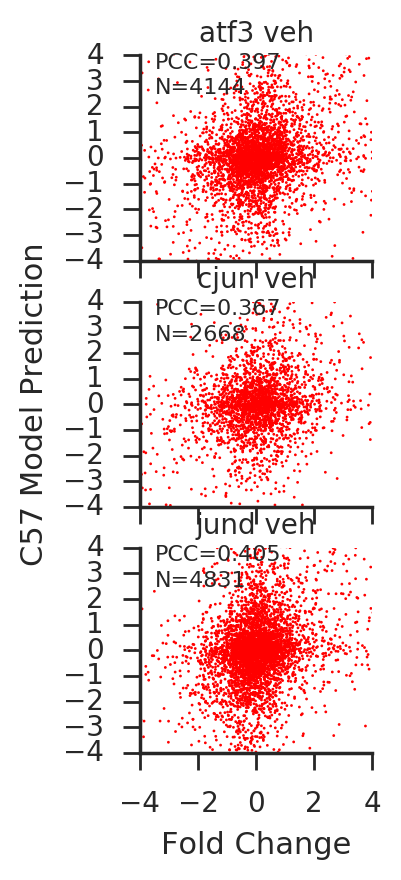

atf3 kla 0.43081244045
cjun kla 0.374695998579
fos kla 0.409691680183
junb kla 0.33745917321
jund kla 0.422919781924


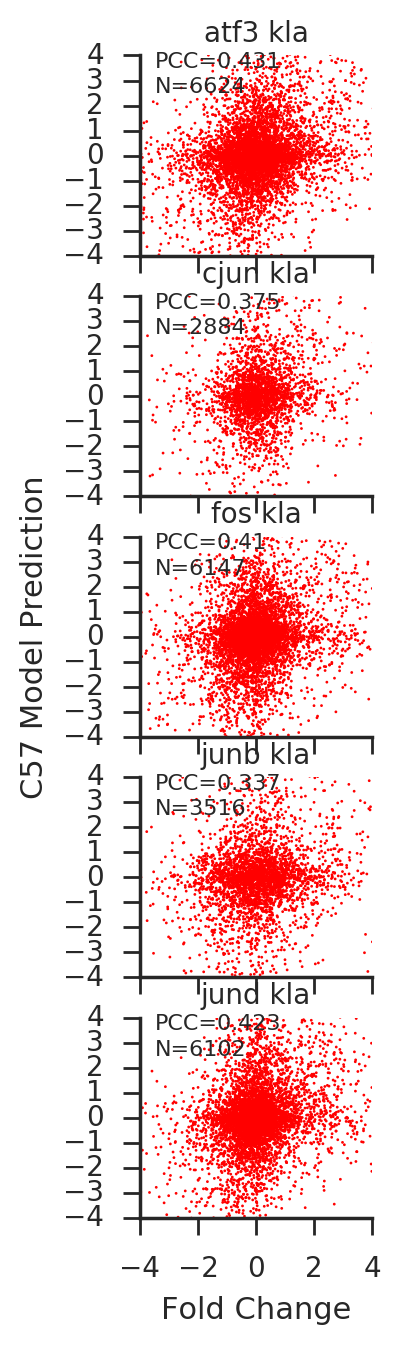

In [157]:
motif_score_differences_frame = motif_score_frame.ix[:,3:] - motif_score_balbc_frame.ix[:,3:]
sns.set_style('ticks')
pseudocount = 1
threshold = 1
sns.axes_style('ticks')
for treatment in ['veh', 'kla']:
    if treatment == 'veh':
        monomers = monomers = ['atf3', 'cjun', 'jund']
        f, axes = plt.subplots(3,1, figsize=(1.5,4.5), sharey=True, sharex=True)
    else:
        monomers = monomers = ['atf3', 'cjun', 'fos', 'junb', 'jund']
        f, axes = plt.subplots(5,1, figsize=(1.5,7.5), sharey=True, sharex=True)

    for i in range(len(monomers)):
        ax = axes[i]
        monomer = monomers[i]
        monomer_indices= summary_frame[(summary_frame['c57bl6_' + monomer + '_'+ treatment] > 0) |
                                       summary_frame['balbc_' + monomer + '_'+ treatment] > 0].index.values 
        
        balbc_tags = ap1_meanTag_frame.ix[monomer_indices,'balbc_' + monomer + '_' + treatment] 
        c57bl6_tags = ap1_meanTag_frame.ix[monomer_indices,'c57bl6_' + monomer + '_' + treatment]
        
        normed_balbc_tags, normed_c57bl6_tags = quantile_normalize(balbc_tags, c57bl6_tags)  
        
        fold_changes = (normed_c57bl6_tags + pseudocount) / (normed_balbc_tags + pseudocount)
        fold_changes = pd.Series(fold_changes, index = monomer_indices)
        
        c57bl6_specific_indices = set(fold_changes[fold_changes >= threshold].index.values)
        balbc_specific_indices = set(fold_changes[fold_changes <= 1/threshold].index.values)
        
        strain_specific_indices = sorted(c57bl6_specific_indices.union(balbc_specific_indices))
        current_differences = motif_score_differences_frame.ix[strain_specific_indices,:]
        
        num_mutated_peaks = 0
        num_peaks = 0
        mutated_strain_specific_indices = []
        for ind in strain_specific_indices:
            c57bl6_seq = c57bl6_seq_arrays[ind]
            balbc_seq = balbc_seq_arrays[ind]
            # if sequence lengths are the same
            if c57bl6_seq.shape[0] == balbc_seq.shape[0]:
                num_peaks +=1
                has_snp = ((c57bl6_seq + balbc_seq).max(axis=1) == 1)
                if np.sum(has_snp) > 0:
                    mutated_strain_specific_indices.append(ind)
                    num_mutated_peaks += 1
        current_weights = mean_coeff_frame[monomer + '_' + treatment]
        current_differences = motif_score_differences_frame.ix[mutated_strain_specific_indices,:]
        products = current_weights * current_differences
        scores = products.sum(axis=1)
        current_fold_changes = fold_changes[mutated_strain_specific_indices]
        pearson, pval = scipy.stats.pearsonr(scores, np.log2(current_fold_changes))
        print(monomer, treatment, pearson)
        ax.scatter(np.log2(current_fold_changes), 
                    scores,
                    edgecolor='None', 
                    s=1,
                    c='red')
        sns.despine()
        ax.annotate(xy=(-3.5,3.5),s='PCC='+str(round(pearson,3)),size=8)
        ax.annotate(xy=(-3.5,2.5),s='N='+str(len(scores)),size=8)
        ax.set_xlim(-4,4)
        ax.set_ylim(-4,4)
        ax.set_xticks([-4,-2,0,2,4])
        ax.set_title(' '.join([monomer, treatment]), size=10)
        
    axes[int(len(axes)/2)].set_ylabel('C57 Model Prediction')
    plt.xlabel('Fold Change')
    plt.savefig('./figures/figure_06_C57model_predictions_'+treatment+'.png', bbox_inches='tight')
    plt.savefig('./figures/figure_06_C57model_predictions_'+treatment+'.pdf', bbox_inches='tight')

    plt.show()

                    
    

In [158]:
motif_score_differences_frame = motif_score_frame.ix[:,3:] - motif_score_balbc_frame.ix[:,3:]

factor_pearson_dict = {}
ap1_pearson_dict = {}
num_motifs = 100
threshold = 1
for treatment in ['veh', 'kla']:
    if treatment == 'veh':
        monomers = ['atf3', 'cjun', 'jund']
    else:
        monomers = ['atf3', 'cjun', 'fos', 'junb', 'jund']
    for i in range(len(monomers)):
        monomer = monomers[i]
        
        factor_pearson_dict[monomer + '_' + treatment] = []
        current_weights = mean_coeff_frame[monomer + '_' + treatment]
        abs_weights = current_weights.abs()
        abs_weights.sort(ascending=False)
        sorted_motifs = list(abs_weights.index.values)
        
        # find where monomer binds
        monomer_indices= summary_frame[(summary_frame['c57bl6_' + monomer + '_'+ treatment] > 0) |
                                       summary_frame['balbc_' + monomer + '_'+ treatment] > 0].index.values 
        
        balbc_tags = ap1_meanTag_frame.ix[monomer_indices,'balbc_' + monomer + '_' + treatment] 
        c57bl6_tags = ap1_meanTag_frame.ix[monomer_indices,'c57bl6_' + monomer + '_' + treatment]
        
        # normalize tags
        normed_balbc_tags, normed_c57bl6_tags = quantile_normalize(balbc_tags, c57bl6_tags)  
        
        # calculate strain specific binding
        fold_changes = (normed_c57bl6_tags + pseudocount) / (normed_balbc_tags + pseudocount)
        fold_changes = pd.Series(fold_changes, index = monomer_indices)
        
        c57bl6_specific_indices = set(fold_changes[fold_changes >= threshold].index.values)
        balbc_specific_indices = set(fold_changes[fold_changes <= 1/threshold].index.values)
        
        strain_specific_indices = sorted(c57bl6_specific_indices.union(balbc_specific_indices))
                
        # filter strain specific peaks according to whether or not there is a SNP
        num_mutated_peaks = 0
        num_peaks = 0
        mutated_strain_specific_indices = []
        for ind in strain_specific_indices:
            c57bl6_seq = c57bl6_seq_arrays[ind]
            balbc_seq = balbc_seq_arrays[ind]
            # if sequence lengths are the same
            if c57bl6_seq.shape[0] == balbc_seq.shape[0]:
                num_peaks +=1
                has_snp = ((c57bl6_seq + balbc_seq).max(axis=1) == 1)
                if np.sum(has_snp) > 0:
                    mutated_strain_specific_indices.append(ind)
                    num_mutated_peaks += 1
        current_fold_changes = fold_changes[mutated_strain_specific_indices]
        
        # calculate correlation to AP-1 binding
        ap1_motif_differences = motif_score_differences_frame.ix[mutated_strain_specific_indices,['ap-1']]
        ap1_motif_scores = ap1_motif_differences.sum(axis=1)
        ap1_pearson, pval = scipy.stats.pearsonr(ap1_motif_scores, np.log2(current_fold_changes))
        ap1_pearson_dict[monomer + '_' + treatment] = ap1_pearson
        
        # threshold on number of motifs
        for i in range(num_motifs):
            motifs_to_use = sorted_motifs[i:]
#             motifs_to_use = sorted_motifs[:i+1]
            current_differences = motif_score_differences_frame.ix[mutated_strain_specific_indices,motifs_to_use]
            products = current_weights * current_differences
            scores = products.sum(axis=1)

            pearson, pval = scipy.stats.pearsonr(scores, np.log2(current_fold_changes))
            factor_pearson_dict[monomer + '_' + treatment].append(pearson)


/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:18: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting


In [159]:
correlation_frame = pd.DataFrame(factor_pearson_dict)
correlation_plotting_frame = pd.DataFrame(correlation_frame.stack(), columns=['PCC'])
correlation_plotting_frame['Monomer'] = [x[1] for x in correlation_plotting_frame.index.values]
correlation_plotting_frame['Motifs Removed'] = [x[0] for x in correlation_plotting_frame.index.values]

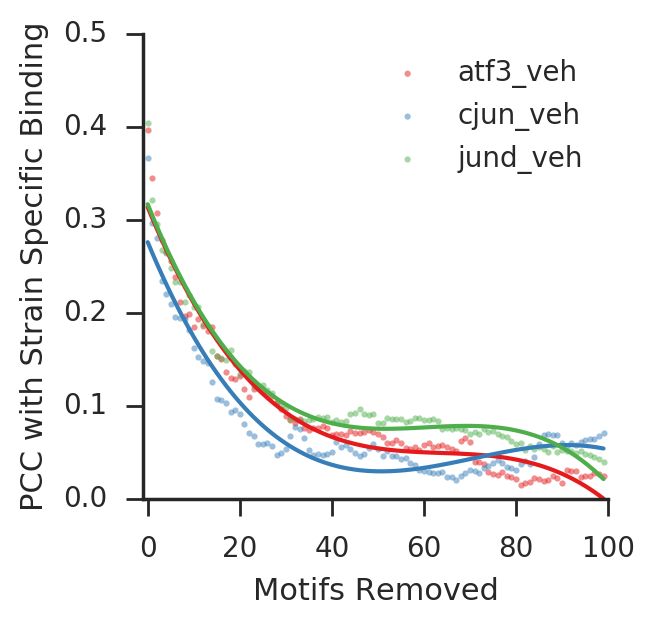

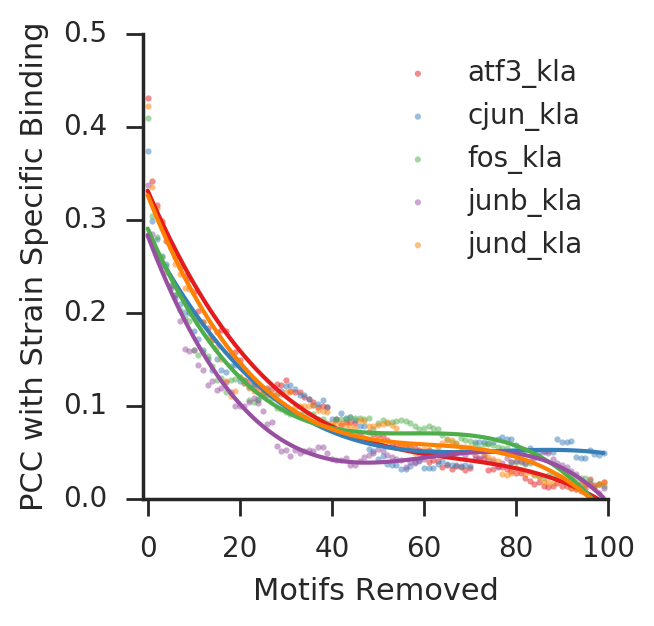

In [473]:
palette = sns.color_palette("Set1")

with sns.axes_style('ticks'):
    for treatment in ['veh', 'kla']:
        plt.figure(figsize=(3,3))
        if treatment == 'veh':
            members = ['atf3', 'cjun', 'jund']
        else:
            members = ['atf3', 'cjun', 'fos', 'junb', 'jund']
        for i in range(len(members)):
            monomer = members[i]
            c = palette[i]
    

            sns.regplot(data =correlation_plotting_frame[correlation_plotting_frame['Monomer'].str.contains(monomer + '_' + treatment)],
                        x = 'Motifs Removed',
                        y = 'PCC',
                        color = c,
                        ci = False,
                        order = 3,
                        truncate = True,
                        scatter_kws = {'s':5,
                                       'alpha':0.5},
                        line_kws = {'linewidth':1.5},
                        label = monomer + '_' + treatment
                        )
        plt.ylabel('PCC with Strain Specific Binding')
        sns.despine()
        plt.xlim(-1,100)
        plt.ylim(0,0.5)
        plt.legend()
        plt.savefig('./figures/figure_06_numMotifsRemoved_vs_strain_specific_binding_'+treatment+'.svg', bbox_inches='tight')
        plt.savefig('./figures/figure_06_numMotifsRemoved_vs_strain_specific_binding_'+treatment+'.png', bbox_inches='tight')



## Intersection of all 2 tests

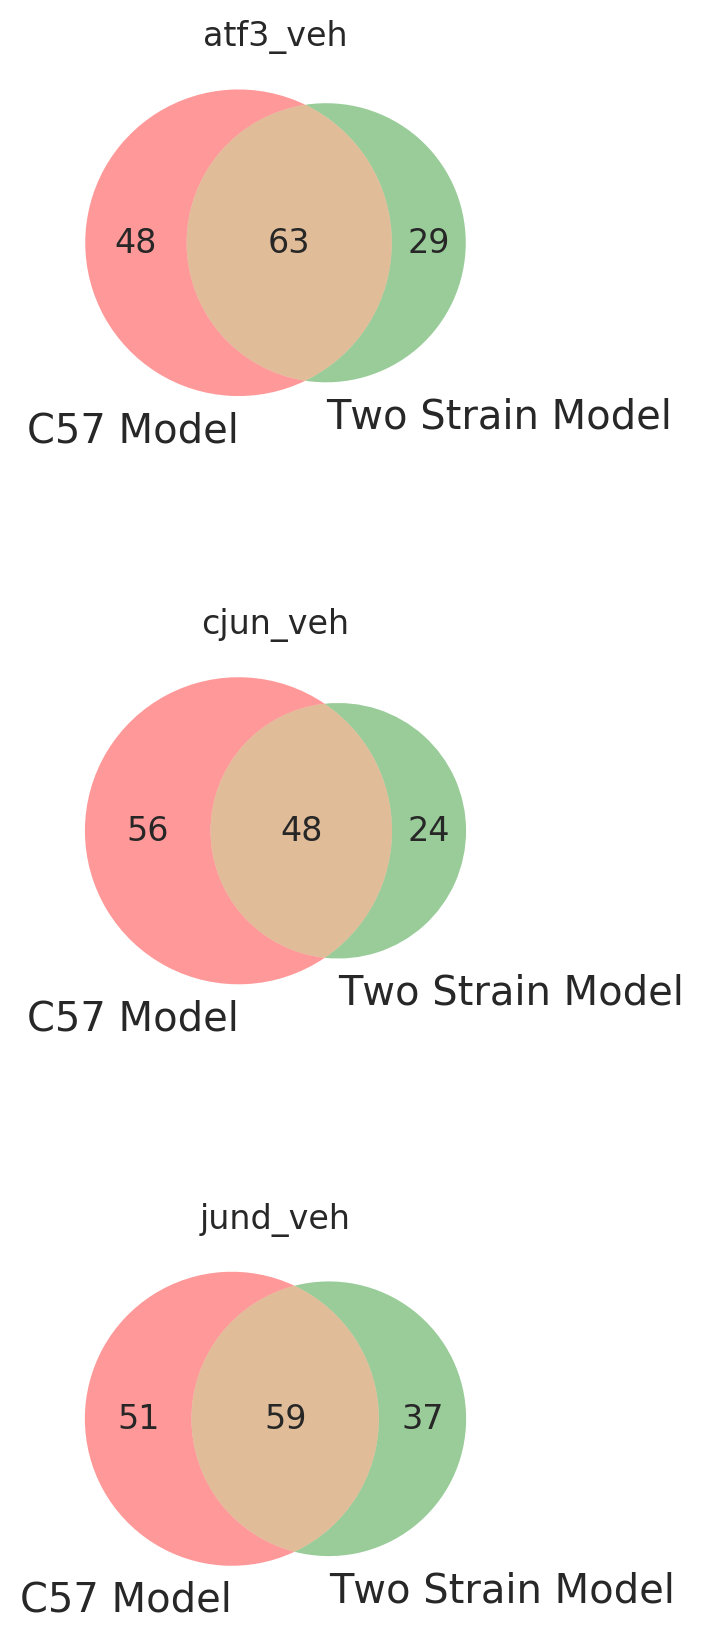

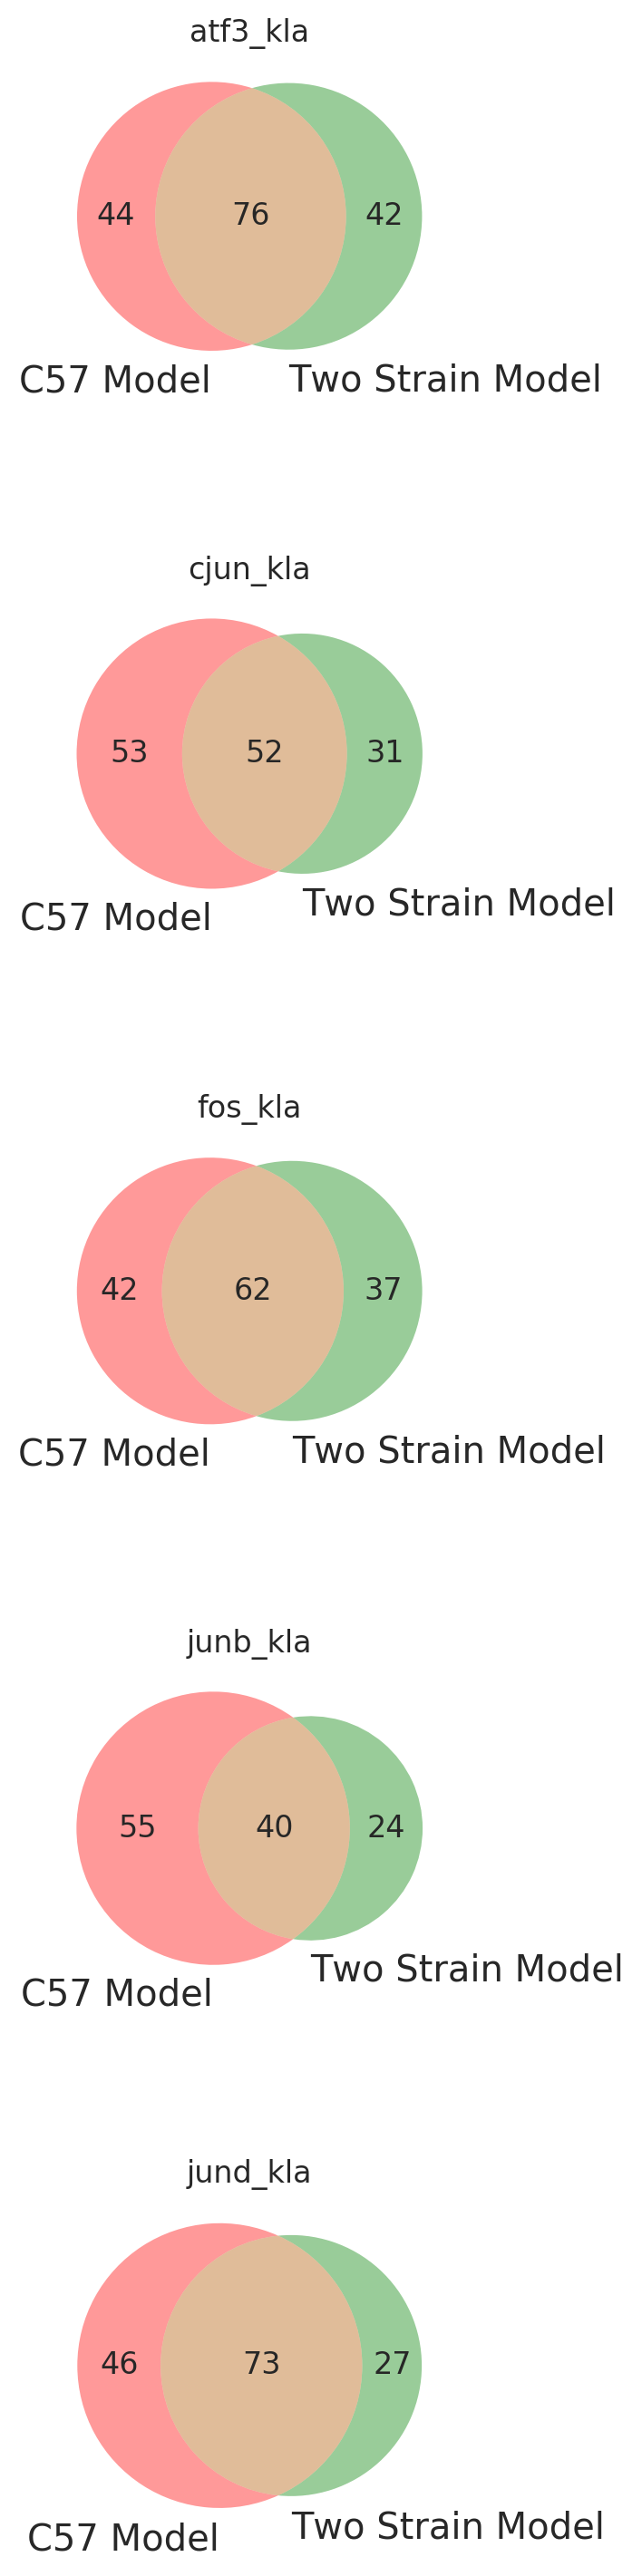

In [451]:
# factor_pvals_frame
# monomer_Ftest_pval_frame
# monomer_mean_lrTest_pval_frame
# individual_p_threshold = 0.05/196
lr_p_threshold = 0.05
f_p_threshold = 0.05
rank_threshold = 200
intersection_counts = []
# individual_counts = []
lr_counts = []
f_counts = []
monomer_list = []
treatment_list = []
for treatment in ['veh', 'kla']:
    if treatment == 'veh':
        monomers = ['atf3', 'cjun', 'jund']
    else:
        monomers = ['atf3', 'cjun', 'fos', 'junb', 'jund'] 
    f, axes = plt.subplots(len(monomers),1, figsize=(3,3*len(monomers)))
    plt.tight_layout()
    for i in range(len(monomers)):
        monomer = monomers[i]
        ax = axes[i]
        
        significant_lr_motifs = set(monomer_mean_lrTest_pval_frame[monomer_mean_lrTest_pval_frame[monomer+'_'+treatment] < lr_p_threshold
                                                               ].index.values)
        significant_f_motifs = set(monomer_Ftest_pval_frame[monomer_Ftest_pval_frame[monomer+'_'+treatment] < f_p_threshold
                                                       ].index.values)
        
        
        
        lr_ranks = mean_coeff_frame[monomer+'_'+treatment].abs().rank(ascending = False)
        top_lr_motifs = set(lr_ranks[lr_ranks<= rank_threshold].index.values)
        
        f_ranks = strain_coeff_frame[monomer+'_'+treatment].abs().rank(ascending = False)
        top_f_motifs = set(f_ranks[f_ranks<= rank_threshold].index.values)
        
        lr_motifs = significant_lr_motifs.intersection(top_lr_motifs)
        f_motifs = significant_f_motifs.intersection(top_f_motifs)
        intersection_counts.append(len(lr_motifs.intersection(f_motifs)))
        
        lr_counts.append(len(lr_motifs))
        f_counts.append(len(f_motifs))
        monomer_list.append(monomer)
        treatment_list.append(treatment)

        matplotlib_venn.venn2([lr_motifs,
                              f_motifs],
                             set_labels = ['C57 Model', 'Two Strain Model'],
                             ax=ax)
        ax.set_title(monomer + '_' + treatment)
    plt.savefig('./figures/figure_06_model_venn_' + treatment + '.pdf',
               bbox_inches='tight')
    plt.show()
frame = pd.DataFrame({'Monomer':monomer_list,
                      'Treatment':treatment_list,
                      'Intersection':intersection_counts,
#                       'Individual Model':individual_counts,
                      'C57 Model':lr_counts,
                      'Two Strain Model':f_counts},
                    )

In [452]:
frame[['Treatment','Monomer', 'C57 Model','Two Strain Model', 'Intersection']]

Treatment Monomer  C57 Model  Two Strain Model  Intersection
0       veh    atf3        111                92            63
1       veh    cjun        104                72            48
2       veh    jund        110                96            59
3       kla    atf3        120               118            76
4       kla    cjun        105                83            52
5       kla     fos        104                99            62
6       kla    junb         95                64            40
7       kla    jund        119               100            73

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:30: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


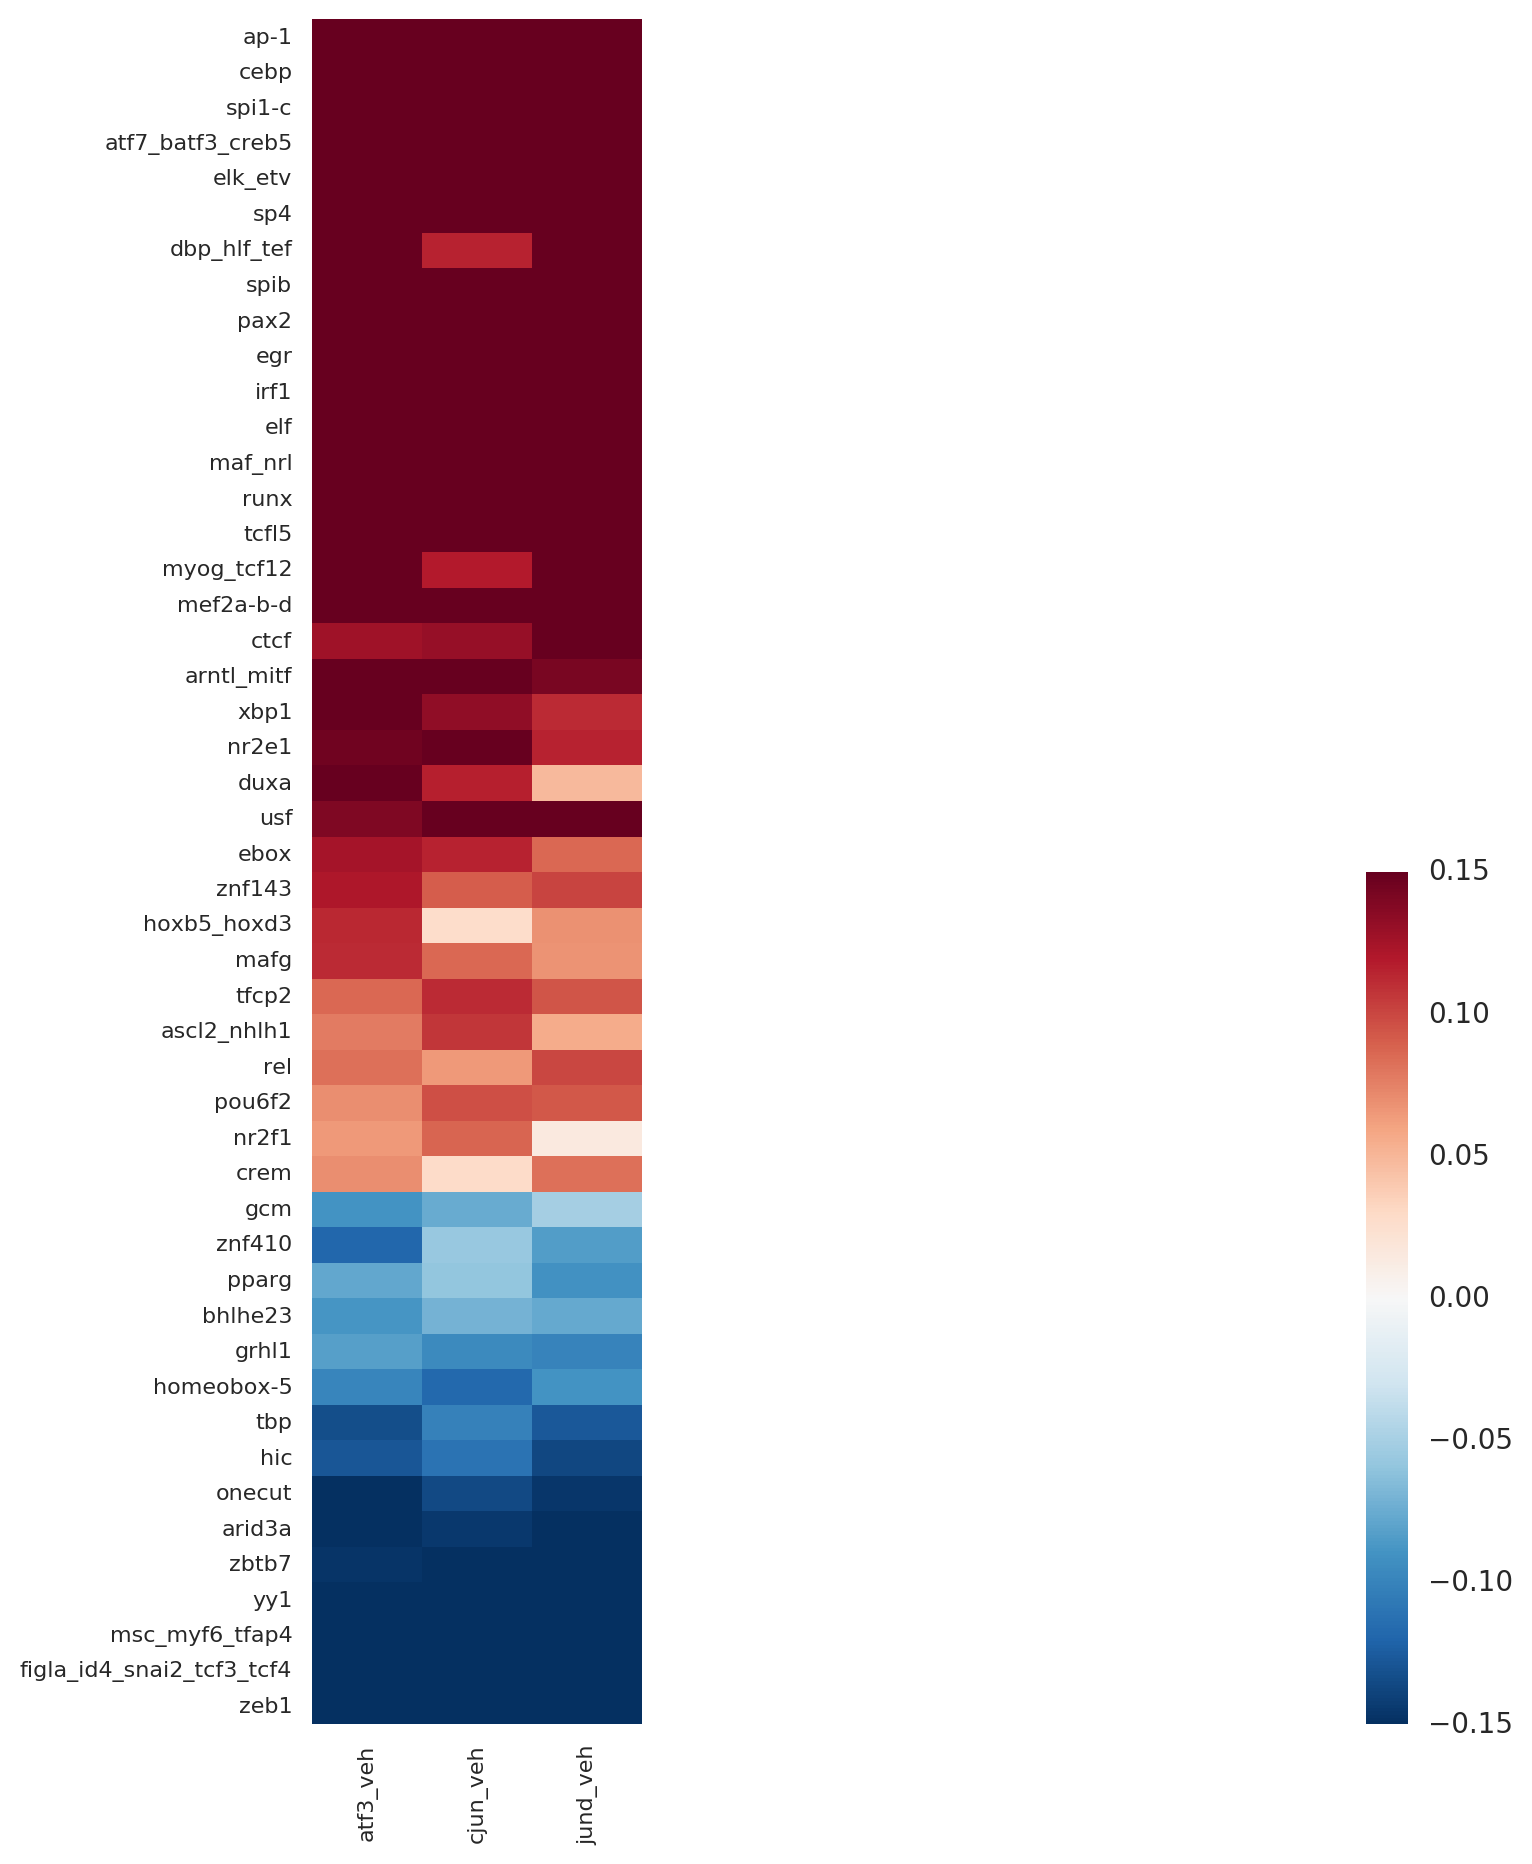

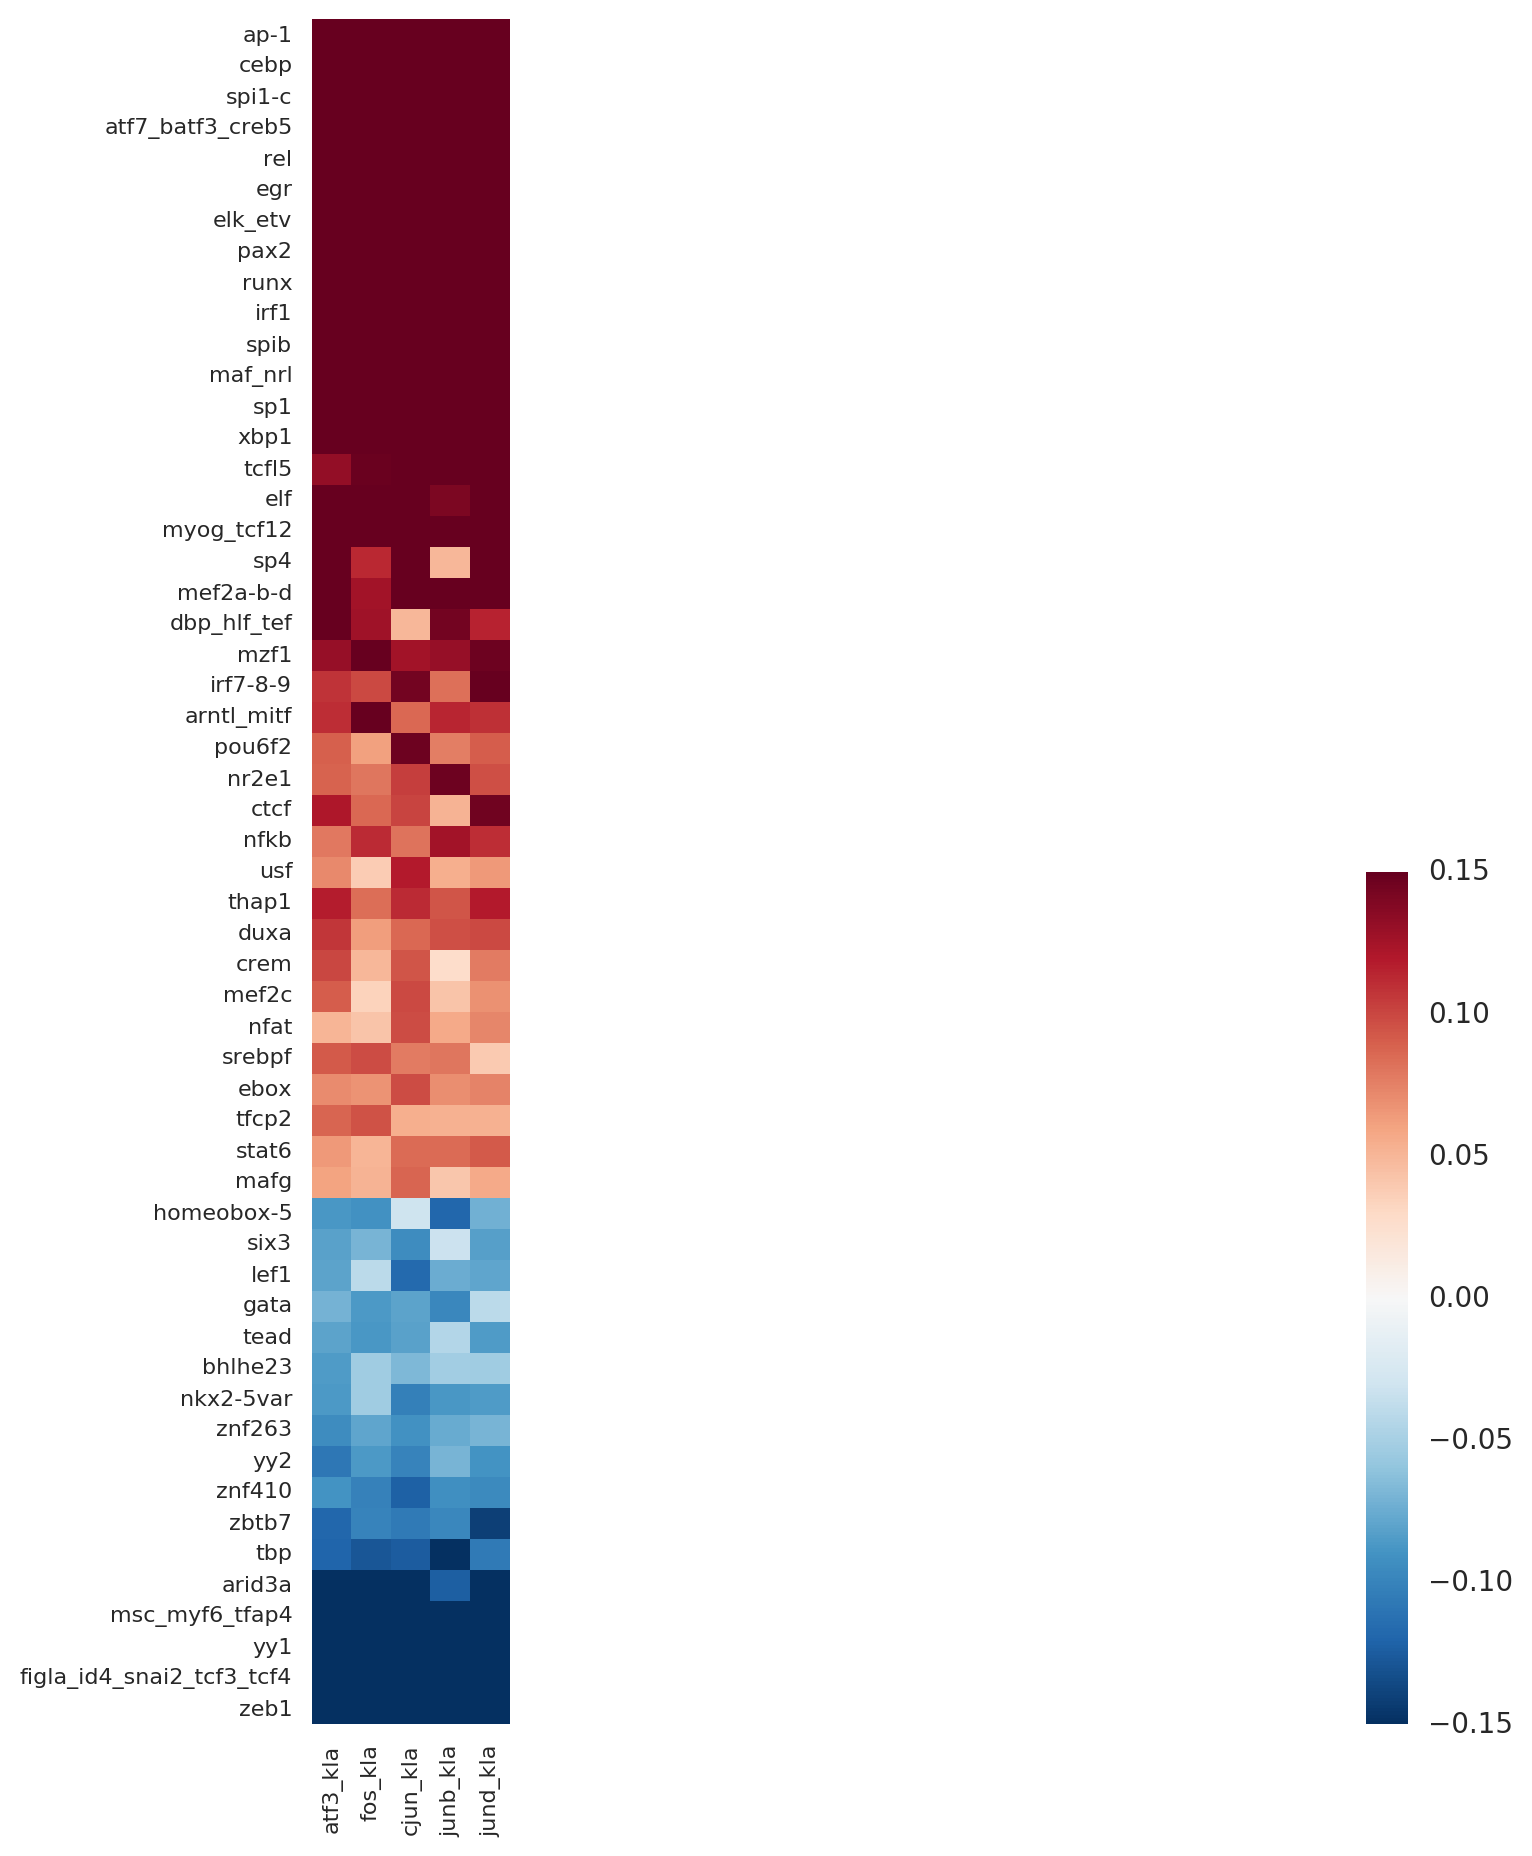

In [454]:
sns.set_style('darkgrid')
lr_p_threshold = 0.05
f_p_threshold = 0.05
rank_threshold = 50
intersection_counts = []
lr_counts = []
f_counts = []
monomer_list = []
treatment_list = []
for treatment in ['veh', 'kla']:
    motifs_for_condition = set()
    if treatment == 'veh':
        monomers = ['atf3', 'cjun', 'jund']
    else:
        monomers = ['atf3', 'fos', 'cjun', 'junb', 'jund'] 
    for monomer in monomers:
        lr_motifs = set(monomer_mean_lrTest_pval_frame[monomer_mean_lrTest_pval_frame[monomer+'_'+treatment] < lr_p_threshold
                                                               ].index.values)
        f_motifs = set(monomer_Ftest_pval_frame[monomer_Ftest_pval_frame[monomer+'_'+treatment] < f_p_threshold
                                                       ].index.values)
        ranks = mean_coeff_frame[monomer + '_' + treatment].abs().rank(ascending = False)
        top_motifs = ranks[ranks<=rank_threshold].index.values
        intersection=lr_motifs.intersection(f_motifs).intersection(top_motifs)
        
        motifs_for_condition = motifs_for_condition.union(intersection)
    motifs_for_condition = sorted(motifs_for_condition)
    
    data = mean_coeff_frame.ix[motifs_for_condition,[x + '_' + treatment for x in monomers]]
    data['mean'] = data.max(axis=1)
    data = data.sort('mean', ascending=False)
    del data['mean']
    
    hm = sns.heatmap(data,
                     vmin=-0.15,
                     vmax=0.15,
                    )
    pos = hm.get_position()
    hm.set_position([pos.x0, pos.y0, pos.width/len(monomers), pos.height*2])
    hm.set_yticklabels(size=8, labels = data.index.values[::-1]);
    hm.set_xticklabels(size=8, labels = data.columns.values, rotation=90);
    plt.savefig('./figures/figure_06_intersecting_motif_heatmap_'+ treatment + '.pdf',
               bbox_inches='tight')
    plt.show()

## show that models trained on one strain works for the other strain

In [ ]:
numIterations = 1
test_size = 0.2
background_ratio = 1.0
ap1_members = ['atf3','cjun', 'fos', 'fra2', 'junb','jund']    
factors = ['atf3','cjun', 'fos', 'junb','jund', 'cebpa', 'pu1', 'p65']

In [ ]:
# for monomers using motif counts and best motif score 
strain = 'c57bl6'
roc_list = []
precision_list = []
factor_list = []
treatment_list = []
training_strain_list = []
testing_strain_list = []
test_train_list = []
for training_strain in ['balbc', 'c57bl6']:
    for testing_strain in ['balbc', 'c57bl6']:
        for treatment in ['veh', 'kla']:
            if treatment == 'veh':
                monomers = monomers = ['atf3', 'cjun', 'jund']
            else:
                monomers = monomers = ['atf3', 'cjun', 'fos', 'junb', 'jund']    
            for monomer in ['atf3','cjun', 'fos', 'junb','jund']:
                target_indices = summary_frame[
                    summary_frame[training_strain + '_' + monomer + '_' + treatment] > 0.0
                    ].index.values
                background_indices = motif_score_background_frame[
                    motif_score_background_frame['Factors'] == 'c57bl6' + '_' + monomer + '_' + treatment + '-background'
                    ].index.values

                # select subset of background indices to use
                shuffle(background_indices)
                background_indices = background_indices[:np.ceil(background_ratio*len(target_indices))]
                
                if training_strain == 'c57bl6':
                    target_features = all_standardized_score_frame[
                        all_standardized_score_frame.index.isin(target_indices)]
                elif training_strain == 'balbc':
                    target_features = all_standardized_score_balbc_frame[
                        all_standardized_score_balbc_frame.index.isin(target_indices)]

                background_features = all_standardized_score_frame[
                    all_standardized_score_frame.index.isin(background_indices)]

                # merge target and background features together 
                features = pd.concat([target_features, background_features])

                labels = pd.Series(data = [True] * len(target_indices) + [False] * len(background_indices),
                                   index = features.index.values)

                results = train_classifier(features, 
                                            labels,
                                            numIterations = 5,
                                            test_size = test_size,
                                            )
                # unpack result tuples
                all_coefficients = results[2]
                mean_coefficients = np.mean(all_coefficients, axis=0)
                
                # test on testing strain
                target_testing_indices = summary_frame[
                    summary_frame[testing_strain + '_' + monomer + '_' + treatment] > 0.0
                    ].index.values
                if testing_strain == 'c57bl6':
                    target_testing_features = all_standardized_score_frame[
                        all_standardized_score_frame.index.isin(target_testing_indices)]
                elif testing_strain == 'balbc':
                    target_testing_features = all_standardized_score_balbc_frame[
                        all_standardized_score_balbc_frame.index.isin(target_testing_indices)]
                    
                testing_features = pd.concat([target_testing_features, background_features])
                testing_labels = pd.Series(
                    data = [True] * len(target_testing_features) + [False] * len(background_indices),
                    index = testing_features.index.values)
                testing_scores = (testing_features* mean_coefficients).sum(axis=1)
                normed_scores = (testing_scores + abs(np.min(testing_scores)))/np.max(testing_scores)
                roc = sklearn.metrics.roc_auc_score(testing_labels, normed_scores)
                precision = sklearn.metrics.average_precision_score(testing_labels, normed_scores)

                roc_list.append(roc)
                precision_list.append(precision)
                
                factor_list.append(monomer)
                treatment_list.append(treatment)
                training_strain_list.append(training_strain)
                testing_strain_list.append(testing_strain)
                test_train_list.append(testing_strain + ' '+ training_strain)
                
                print(training_strain, testing_strain, monomer, treatment, roc, precision)

In [ ]:
strain_performance_frame = pd.DataFrame({'Training Strain':training_strain_list,
                            'Testing Strain':testing_strain_list,
                            'Train Test Strain':test_train_list,
                            'ROC':roc_list,
                            'Precision':precision_list,
                            'Monomer':factor_list,
                            'Treatment':treatment_list})

In [ ]:
strain_color_dict = dict(zip(['balbc', 'c57bl6'], sns.color_palette('coolwarm',2)))
treatment_color_dict = dict(zip(['veh','kla'], sns.color_palette('deep',2)))
monomer_color_dict = dict(zip(['atf3','cjun','fos','fra2','junb','jund'], sns.color_palette('husl',6)))

In [ ]:
training_colors = []
testing_colors = []
treatment_colors = []
monomer_colors = []
matrix_dict = {}


for training_strain in ['balbc', 'c57bl6']:
    for testing_strain in ['balbc', 'c57bl6']:
        matrix_dict[training_strain+ '_'+testing_strain] = []
        training_colors.append(strain_color_dict[training_strain])
        testing_colors.append(strain_color_dict[testing_strain])
        
        treatment_index_list = []
        monomer_index_list = []
        for treatment in ['veh', 'kla']:
            if treatment == 'veh':
                monomers = monomers = ['atf3', 'cjun', 'jund']
            else:
                monomers = monomers = ['atf3', 'cjun', 'fos', 'junb', 'jund']    
            for monomer in monomers:
                treatment_colors.append(treatment_color_dict[treatment])
                monomer_colors.append(monomer_color_dict[monomer])
                roc = strain_performance_frame[(strain_performance_frame['Training Strain'] == training_strain) &
                                         (strain_performance_frame['Testing Strain'] == testing_strain) &
                                         (strain_performance_frame['Monomer'] == monomer) &
                                         (strain_performance_frame['Treatment'] == treatment)]['ROC'].values[0]

                matrix_dict[training_strain+ '_'+testing_strain].append(roc)
                treatment_index_list.append(treatment)
                monomer_index_list.append(monomer)

In [ ]:
frame = pd.DataFrame(matrix_dict, index = pd.MultiIndex.from_arrays([treatment_index_list, monomer_index_list]))


In [ ]:
frame

# Figure 7 

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting


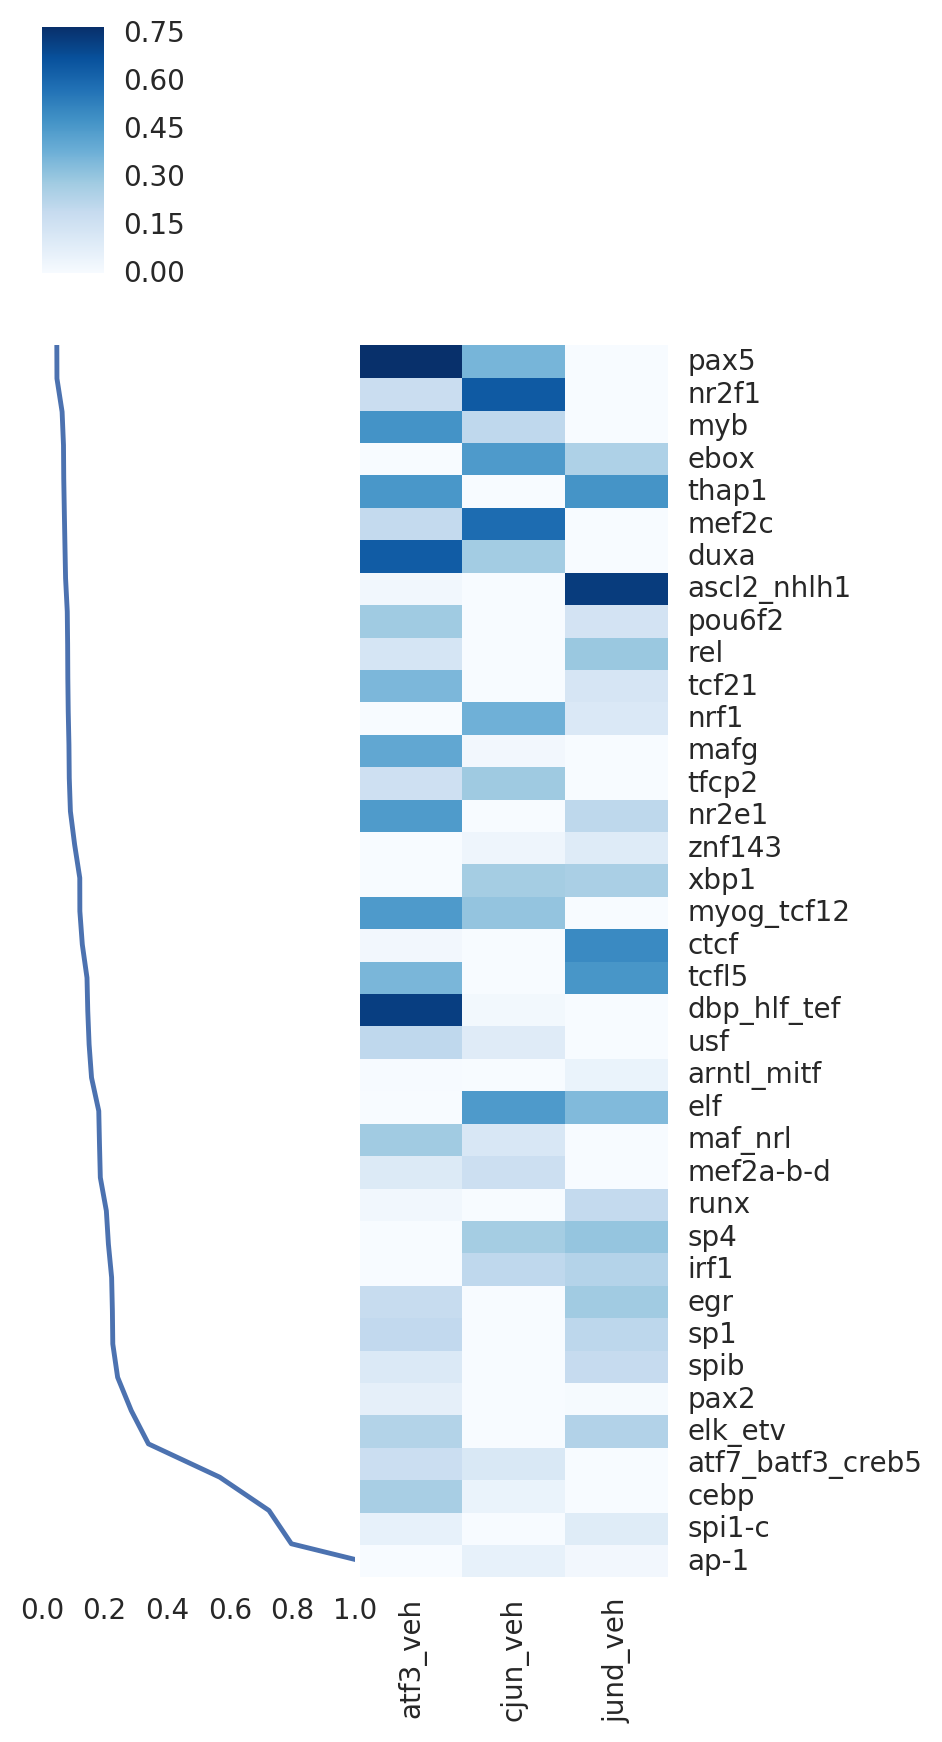

In [1148]:
sns.set_style('darkgrid')
rank_threshold = 50
p_threshold = 0.01
size_threshold = 0.05
veh_coeffs = mean_coeff_frame[[x for x in mean_coeff_frame.columns if 'veh' in x]]
abs_ranks = veh_coeffs.abs().rank(ascending=False)
ranks = veh_coeffs.rank(ascending=False)
pvals = monomer_mean_lrTest_pval_frame[[x for x in mean_coeff_frame.columns if 'veh' in x]]

indices = veh_coeffs[(abs_ranks.min(axis=1) <= rank_threshold) &
                     (ranks.min(axis=1) <= rank_threshold) &
                     (pvals.min(axis=1) <= p_threshold)
                     ].index.values



data = mean_coeff_frame.ix[indices,[x for x in mean_coeff_frame.columns if 'veh' in x]]

mins = data.min(axis=1)
maxes = data.mean(axis=1)
differences = data[[]]
for col in data.columns:
    differences[col] = data[col].values - mins.values
mins.sort()
sorted_maxes = maxes[mins.index.values]
sorted_differences = differences.ix[mins.index.values,:]
sorted_fractional_differences = (sorted_differences.T/sorted_maxes).T
cm = sns.clustermap(sorted_fractional_differences,
                    col_cluster=False,
                    row_cluster=False,
                    cmap='Blues',
                   )
plt.setp(cm.ax_heatmap.yaxis.get_majorticklabels(), 
         fontsize=10, 
         rotation=0);
plt.setp(cm.ax_heatmap.xaxis.get_majorticklabels(), 
         fontsize=10, 
         rotation=90);

cm.ax_row_dendrogram.clear()
cm.ax_row_dendrogram.plot(sorted(mins, reverse=True), range(len(mins)))
cm.ax_row_dendrogram.set_yticks([])
cm.ax_row_dendrogram.set_xlim(0,1)
cm.ax_row_dendrogram.set_ylim(0,len(mins)-1)

hm = cm.ax_heatmap.get_position()
cm.ax_heatmap.set_position([hm.x0, hm.y0, hm.width*0.25, hm.height])
col = cm.ax_col_dendrogram.get_position()
cm.ax_col_dendrogram.set_position([col.x0, col.y0, col.width*0.25, col.height*0.5])
plt.savefig('./figures/figure_07_weight_heatmap.svg', bbox_inches='tight')



## PPARg Venn Diagrams

In [1631]:
%%capture
! mergePeaks -d 100 -venn validation_venn.txt ./peak_files/c57bl6_atf3_veh_peaks.tsv ./peak_files/c57bl6_cjun_veh_peaks.tsv ./peak_files/c57bl6_jund_veh_peaks.tsv ./peak_files_validation/* > merged_validation_peaks.tsv



In [1632]:
! makeSummaryFile.py ./merged_validation_peaks.tsv ./group_validation_summary.tsv ./peak_files/c57bl6_atf3_veh_peaks.tsv ./peak_files/c57bl6_cjun_veh_peaks.tsv ./peak_files/c57bl6_jund_veh_peaks.tsv ./peak_files_validation/* 

Finished reading merged peak file...
Integrating scores for c57bl6_atf3_veh
Integrating scores for c57bl6_cjun_veh
Integrating scores for c57bl6_jund_veh
Integrating scores for c57bl6_atf3_ikkvii
Integrating scores for c57bl6_cjun_ikkvii
Integrating scores for c57bl6_fos_ikkvii
Integrating scores for c57bl6_junb_ikkvii
Integrating scores for c57bl6_jund_ikkvii
Integrating scores for c57bl6-lxrko_atf3_veh
Integrating scores for c57bl6-lxrko_cjun_veh
Integrating scores for c57bl6-lxrko_jund_veh
Integrating scores for c57bl6_p65_ikkvii
Integrating scores for c57bl6-ppargko_atf3_veh
Integrating scores for c57bl6-ppargko_cjun_veh
Integrating scores for c57bl6-ppargko_fos_veh
Integrating scores for c57bl6-ppargko_junb_veh
Integrating scores for c57bl6-ppargko_jund_veh
Integrating scores for c57bl6_pparg_veh


In [1633]:
# read in peak data data
summary_validation_frame = pd.read_csv('./group_validation_summary.tsv' , sep='\t')
summary_validation_frame = summary_validation_frame.fillna('0')
for col in summary_validation_frame.columns[5:]:
    floatValues = []
    for val in summary_validation_frame[col].values.astype(str):
        if ',' in val:
            maxVal = np.mean([float(x) for x in val.split(',')])
            floatValues.append(maxVal)
        else:
            floatValues.append(float(val))
    summary_validation_frame[col] = floatValues
summary_validation_frame.index = summary_validation_frame['ID'].values

# remove peaks in unknown/random chromosomes
summary_validation_frame = summary_validation_frame[~summary_validation_frame['chr'].str.contains('random')]
summary_validation_frame = summary_validation_frame[~summary_validation_frame['chr'].str.contains('Un')]

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Search for browser shots

In [1634]:
summary_validation_frame[(summary_validation_frame['c57bl6_pparg_veh'] == 0) &
#                          (summary_validation_frame['c57bl6-ppargko_atf3_veh'] > 0) &
                         (summary_validation_frame['c57bl6-ppargko_cjun_veh'] > 0) &
                         (summary_validation_frame['c57bl6-ppargko_jund_veh'] > 0)].sort('c57bl6-ppargko_cjun_veh', ascending=False)

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


ID    chr      start  \
Merged-chr10-127596815-13  Merged-chr10-127596815-13  chr10  127596726   
Merged-chr14-47361790-13    Merged-chr14-47361790-13  chr14   47361665   
Merged-chr18-36708890-9      Merged-chr18-36708890-9  chr18   36708820   
Merged-chr2-32907613-12      Merged-chr2-32907613-12   chr2   32907523   
Merged-chr8-122567518-12    Merged-chr8-122567518-12   chr8  122567441   
Merged-chr10-80751626-12    Merged-chr10-80751626-12  chr10   80751509   
Merged-chr19-29641287-12    Merged-chr19-29641287-12  chr19   29641211   
Merged-chr13-4771623-13      Merged-chr13-4771623-13  chr13    4771537   
Merged-chr14-21747989-11    Merged-chr14-21747989-11  chr14   21747908   
Merged-chr17-27555682-11    Merged-chr17-27555682-11  chr17   27555619   
Merged-chr9-48817506-11      Merged-chr9-48817506-11   chr9   48817421   
Merged-chr10-75170660-10    Merged-chr10-75170660-10  chr10   75170571   
Merged-chr14-34343253-10    Merged-chr14-34343253-10  chr14   34343149   
Merged-chr11-60935513-13    Merged-chr11-60935513-13  chr11   60935431   
Merged-chr5-3301315-11        Merged-chr5-3301315-11   chr5    3301210   
Merged-chr10-120628264-11  Merged-chr10-120628264-11  chr10  120628177   
Merged-chr12-104186422-10  Merged-chr12-104186422-10  chr12  104186330   
Merged-chr3-109273221-9      Merged-chr3-109273221-9   chr3  109273124   
Merged-chr7-83853246-12      Merged-chr7-83853246-12   chr7   83853138   
Merged-chr16-94229007-11    Merged-chr16-94229007-11  chr16   94228930   
Merged-chr14-106012201-12  Merged-chr14-106012201-12  chr14  106012112   
Merged-chr15-6492630-12      Merged-chr15-6492630-12  chr15    6492553   
Merged-chr1-40295006-11      Merged-chr1-40295006-11   chr1   40294887   
Merged-chr19-37254970-9      Merged-chr19-37254970-9  chr19   37254908   
Merged-chr5-23433377-9        Merged-chr5-23433377-9   chr5   23433302   
Merged-chr6-124834750-9      Merged-chr6-124834750-9   chr6  124834680   
Merged-chr1-72229224-12      Merged-chr1-72229224-12   chr1   72229153   
Merged-chr7-141372117-11    Merged-chr7-141372117-11   chr7  141372045   
Merged-chr1-84200131-7        Merged-chr1-84200131-7   chr1   84200027   
Merged-chr14-106044515-11  Merged-chr14-106044515-11  chr14  106044410   
...                                              ...    ...        ...   
Merged-chr2-31259048-5        Merged-chr2-31259048-5   chr2   31258986   
Merged-chr13-52985595-10    Merged-chr13-52985595-10  chr13   52985498   
Merged-chr1-54914618-10      Merged-chr1-54914618-10   chr1   54914541   
Merged-chr7-80178178-11      Merged-chr7-80178178-11   chr7   80178086   
Merged-chr15-39887155-8      Merged-chr15-39887155-8  chr15   39887081   
Merged-chr16-3706857-9        Merged-chr16-3706857-9  chr16    3706787   
Merged-chr1-151625929-8      Merged-chr1-151625929-8   chr1  151625813   
Merged-chr14-120910523-7    Merged-chr14-120910523-7  chr14  120910450   
Merged-chr4-147927860-11    Merged-chr4-147927860-11   chr4  147927781   
Merged-chr12-98375754-4      Merged-chr12-98375754-4  chr12   98375676   
Merged-chr12-103099329-5    Merged-chr12-103099329-5  chr12  103099222   
Merged-chr5-108268782-3      Merged-chr5-108268782-3   chr5  108268656   
Merged-chrX-136741769-4      Merged-chrX-136741769-4   chrX  136741644   
Merged-chr12-71007999-3      Merged-chr12-71007999-3  chr12   71007917   
Merged-chr5-53460484-4        Merged-chr5-53460484-4   chr5   53460349   
Merged-chr5-135479437-8      Merged-chr5-135479437-8   chr5  135479329   
Merged-chr2-50687964-9        Merged-chr2-50687964-9   chr2   50687818   
Merged-chr17-47145216-9      Merged-chr17-47145216-9  chr17   47145135   
Merged-chr10-43703131-9      Merged-chr10-43703131-9  chr10   43703056   
Merged-chr9-64092316-6        Merged-chr9-64092316-6   chr9   64092233   
Merged-chr12-40637575-2      Merged-chr12-40637575-2  chr12   40637509   
Merged-chrX-169980559-2      Merged-chrX-169980559-2   chrX  169980485   
Merged-chr9-89856084-6        Merged-chr9-89856084-6  

### Venn Diagrams

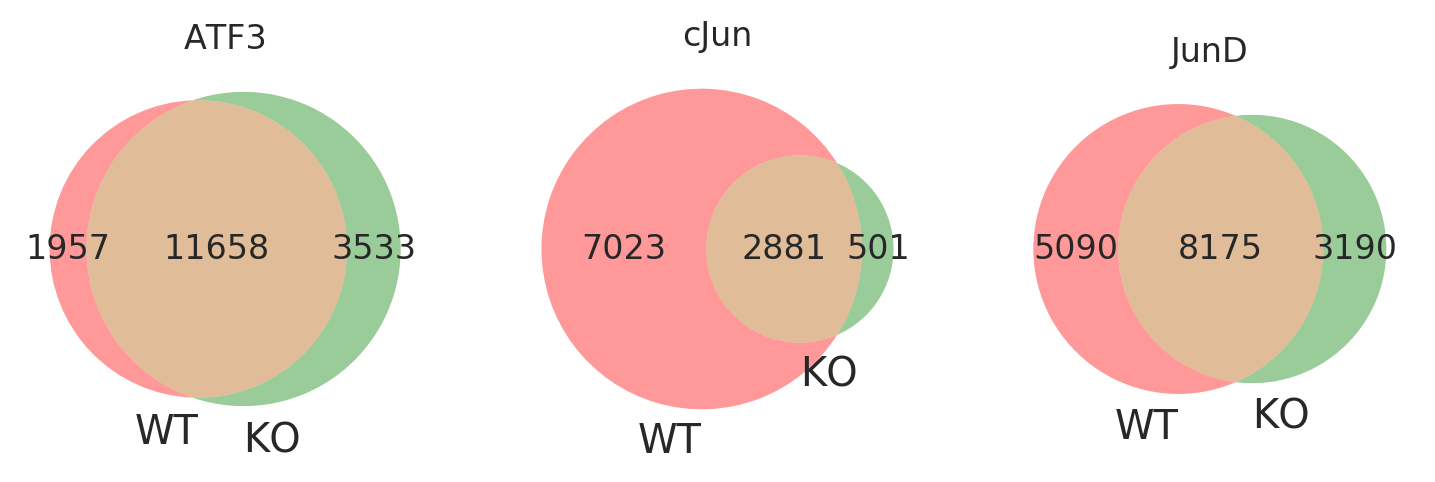

In [1635]:
ppar_indices = set(summary_validation_frame[summary_validation_frame['c57bl6_pparg_veh'] > 0].index.values)

atf3_wt_indices = set(summary_validation_frame[summary_validation_frame['c57bl6_atf3_veh'] > 0].index.values)
atf3_ko_indices = set(summary_validation_frame[summary_validation_frame['c57bl6-ppargko_atf3_veh'] > 0].index.values)

cjun_wt_indices = set(summary_validation_frame[summary_validation_frame['c57bl6_cjun_veh'] > 0].index.values)
cjun_ko_indices = set(summary_validation_frame[summary_validation_frame['c57bl6-ppargko_cjun_veh'] > 0].index.values)

jund_wt_indices = set(summary_validation_frame[summary_validation_frame['c57bl6_jund_veh'] > 0].index.values)
jund_ko_indices = set(summary_validation_frame[summary_validation_frame['c57bl6-ppargko_jund_veh'] > 0].index.values)

fig, ax = plt.subplots(1,3, figsize=(9,3))
plt.subplot(1,3,1)
matplotlib_venn.venn2([ppar_indices.intersection(atf3_wt_indices),
                       ppar_indices.intersection(atf3_ko_indices)],
                      set_labels = ['WT', 'KO'])
plt.title('ATF3')

plt.subplot(1,3,2)
matplotlib_venn.venn2([ppar_indices.intersection(cjun_wt_indices),
                       ppar_indices.intersection(cjun_ko_indices)],
                     set_labels = ['WT', 'KO'])
plt.title('cJun')
plt.subplot(1,3,3)
matplotlib_venn.venn2([ppar_indices.intersection(jund_wt_indices),
                       ppar_indices.intersection(jund_ko_indices)],
                     set_labels = ['WT', 'KO'])
plt.title('JunD')
plt.savefig('./figures/figure_07_pparko_venn.svg', bbox_inches='tight')



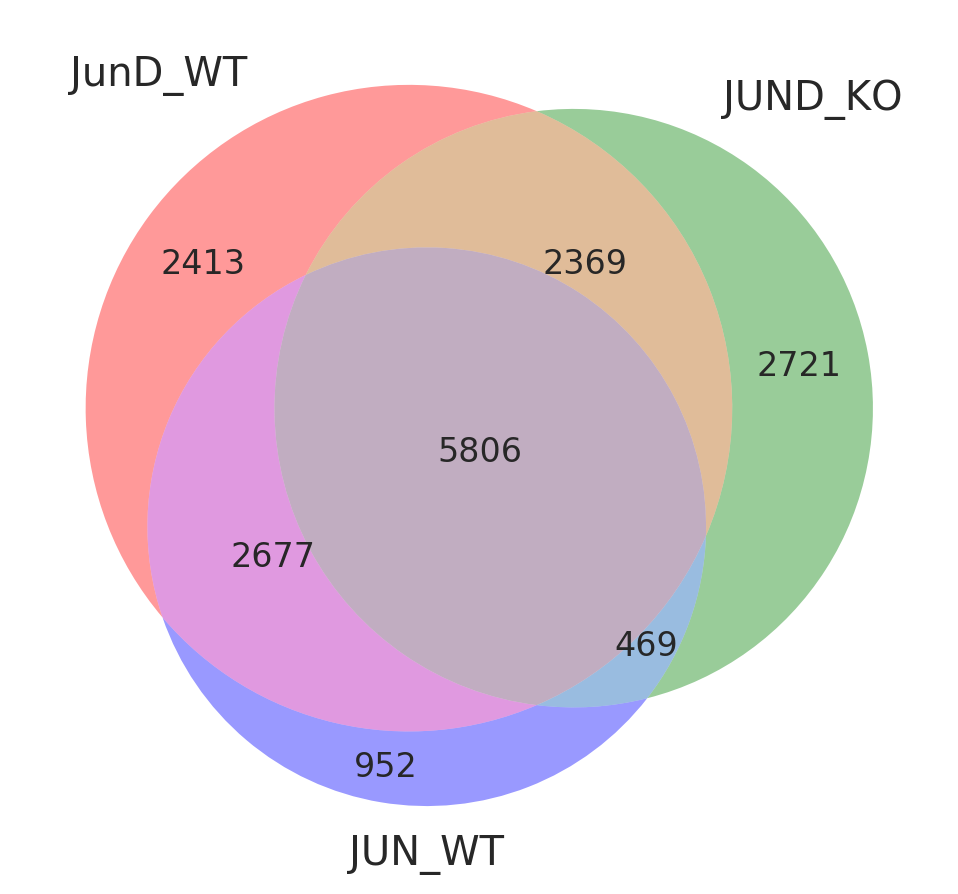

In [1636]:
ppar_indices = set(summary_validation_frame[summary_validation_frame['c57bl6_pparg_veh'] > 0].index.values)

atf3_wt_indices = set(summary_validation_frame[summary_validation_frame['c57bl6_atf3_veh'] > 0].index.values)
atf3_ko_indices = set(summary_validation_frame[summary_validation_frame['c57bl6-ppargko_atf3_veh'] > 0].index.values)

cjun_wt_indices = set(summary_validation_frame[summary_validation_frame['c57bl6_cjun_veh'] > 0].index.values)
cjun_ko_indices = set(summary_validation_frame[summary_validation_frame['c57bl6-ppargko_cjun_veh'] > 0].index.values)

jund_wt_indices = set(summary_validation_frame[summary_validation_frame['c57bl6_jund_veh'] > 0].index.values)
jund_ko_indices = set(summary_validation_frame[summary_validation_frame['c57bl6-ppargko_jund_veh'] > 0].index.values)





matplotlib_venn.venn3([ppar_indices.intersection(jund_wt_indices),
                       ppar_indices.intersection(jund_ko_indices),
                       ppar_indices.intersection(cjun_wt_indices)],
                      set_labels = ['JunD_WT', 'JUND_KO', 'JUN_WT'])

plt.savefig('./figures/figure_07_pparko_jund_jun_venn.svg', bbox_inches='tight')



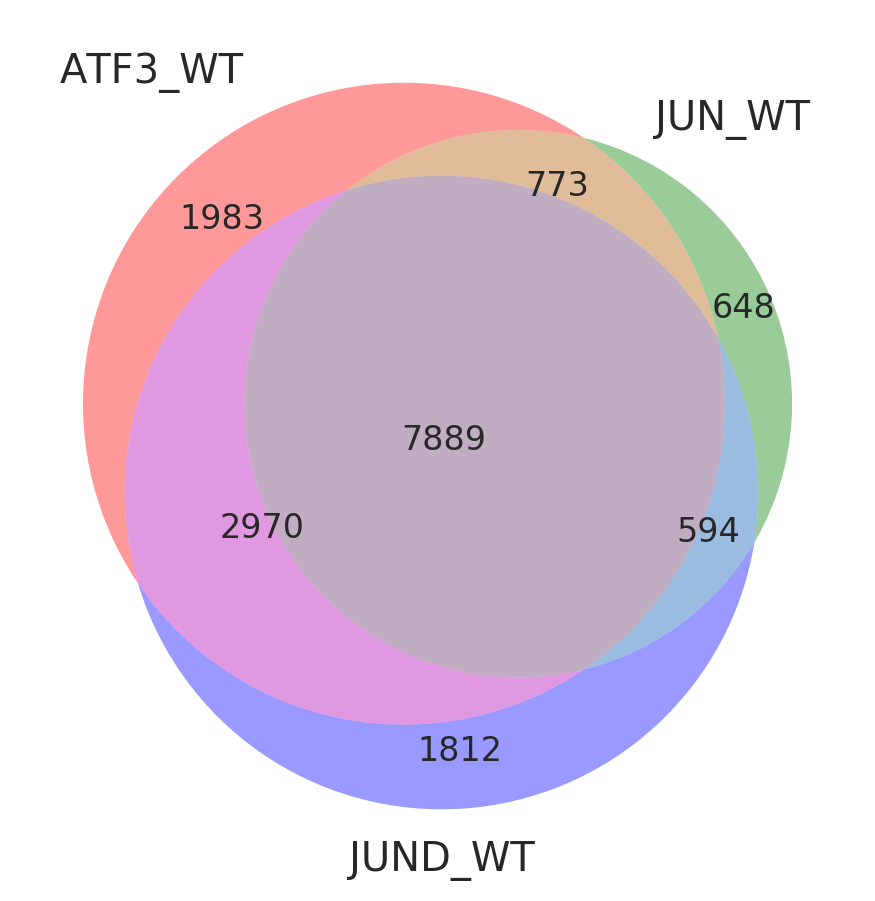

In [1637]:
ppar_indices = set(summary_validation_frame[summary_validation_frame['c57bl6_pparg_veh'] > 0].index.values)

atf3_wt_indices = set(summary_validation_frame[summary_validation_frame['c57bl6_atf3_veh'] > 0].index.values)
atf3_ko_indices = set(summary_validation_frame[summary_validation_frame['c57bl6-ppargko_atf3_veh'] > 0].index.values)

cjun_wt_indices = set(summary_validation_frame[summary_validation_frame['c57bl6_cjun_veh'] > 0].index.values)
cjun_ko_indices = set(summary_validation_frame[summary_validation_frame['c57bl6-ppargko_cjun_veh'] > 0].index.values)

jund_wt_indices = set(summary_validation_frame[summary_validation_frame['c57bl6_jund_veh'] > 0].index.values)
jund_ko_indices = set(summary_validation_frame[summary_validation_frame['c57bl6-ppargko_jund_veh'] > 0].index.values)





matplotlib_venn.venn3([ppar_indices.intersection(atf3_wt_indices),
                       ppar_indices.intersection(cjun_wt_indices),
                       ppar_indices.intersection(jund_wt_indices)],
                     set_labels = ['ATF3_WT', 'JUN_WT', 'JUND_WT'])

plt.savefig('./figures/figure_07_wt_venn.svg', bbox_inches='tight')




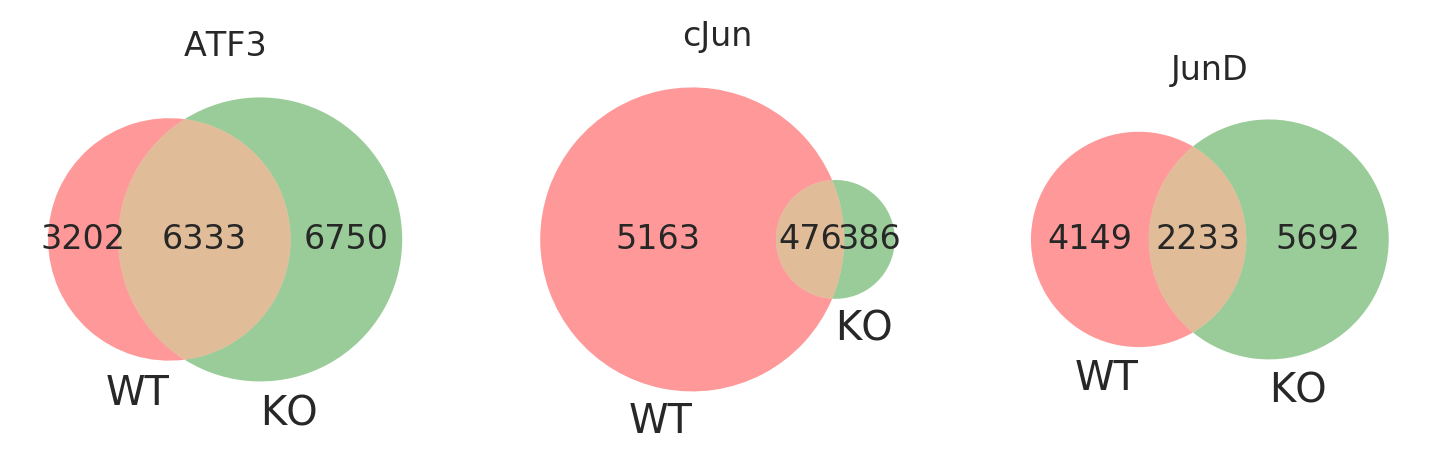

In [1638]:
fig, ax = plt.subplots(1,3, figsize=(9,3))
plt.subplot(1,3,1)
matplotlib_venn.venn2([atf3_wt_indices - ppar_indices,
                       atf3_ko_indices - ppar_indices],
                      set_labels = ['WT', 'KO'])
plt.title('ATF3')

plt.subplot(1,3,2)
matplotlib_venn.venn2([cjun_wt_indices - ppar_indices,
                       cjun_ko_indices - ppar_indices],
                     set_labels = ['WT', 'KO'])
plt.title('cJun')
plt.subplot(1,3,3)
matplotlib_venn.venn2([jund_wt_indices - ppar_indices,
                       jund_ko_indices - ppar_indices],
                     set_labels = ['WT', 'KO'])
plt.title('JunD')

### Expression of AP-1 Monomers in nuclear receptor knockouts

In [ ]:
! analyzeRepeats.pl rna mm10 -count exons -condenseGenes -rpkm -d  ~/analysis/ap1_analysis/tag_directories_rna/*Veh*UT*CR*/ ~/analysis/ap1_analysis/tag_directories_rna/*Veh*UT*VML*/ /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories_rna/C57Bl6-PPARgKO_*/ /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories_rna/C57Bl6-LXRDKO_Thiomac_RNA_Veh_NJS_15-08-21/> rpkm_ppargko.tsv



In [ ]:
# read in rpkm values
rpkm_pparko_frame = pd.read_csv('./rpkm_ppargko.tsv', sep='\t')

rpkm_pparko_frame.index = [x.split('|')[0].upper() for x in rpkm_pparko_frame['Annotation/Divergence']]
rpkm_pparko_frame = rpkm_pparko_frame.ix[:,8:]
rpkm_pparko_frame.columns = [x.split('/')[-2].split('_')[0] for x in rpkm_pparko_frame.columns.values]

# rotate frame for plotting
rpkm_plotting_frame = pd.DataFrame(rpkm_pparko_frame.stack(), 
                                   columns=['RPKM'])
rpkm_plotting_frame['Gene'] = [x[0] for x in rpkm_plotting_frame.index.values]
rpkm_plotting_frame['Genotype'] = [x[1] for x in rpkm_plotting_frame.index.values]
rpkm_plotting_frame['Log2 RPKM'] = np.log2(rpkm_plotting_frame['RPKM'].values + 1)

In [ ]:
gene_list = ['ATF3', 'JUN' , 'JUND',
#              'PPARG',
#              'NR1H2',
#              'RXRA',
#              'RXRB',
#              'GCGR',
#              'ESR1'
             ]

plottingFrame = rpkm_plotting_frame[rpkm_plotting_frame['Gene'].isin(gene_list)]

with sns.axes_style('ticks'):
    sns.factorplot(data = plottingFrame, x='Gene', y='Log2 RPKM', hue='Genotype', kind='bar', 
                   order = gene_list,
#                    hue_order=['Veh','KLA-1h'], 
                   ci=100,
                  size=3)

plt.xticks(rotation=90)
plt.savefig('./figures/figure_04_ppargko_monomer_expression.svg', bbox_inches='tight')




### Motif Weight Callout

In [34]:
strain = 'c57bl6'
treatment = 'veh'
factor_nr2f1_coeff_dict = {}
nr2f1_index = list(all_standardized_score_frame.columns.values).index('nr2f1')
test_size = 0.2
background_ratio = 1.0
for monomer in ['atf3', 'cjun', 'jund']:
    target_indices = summary_frame[summary_frame[strain + '_' + monomer + '_' + treatment] > 0.0].index.values
    background_indices = motif_score_background_frame[
        motif_score_background_frame['Factors'] == strain + '_' + monomer + '_' + treatment + '-background'].index.values

    # select subset of background indices to use
    if False:
        shuffle(background_indices)
        background_indices = background_indices[:np.ceil(background_ratio*len(target_indices))]

        target_features = all_standardized_score_frame[all_standardized_score_frame.index.isin(target_indices)]
        background_features = all_standardized_score_frame[all_standardized_score_frame.index.isin(background_indices)]

        # merge target and background features together 
        features = pd.concat([target_features, background_features])

        labels = pd.Series(data = [True] * len(target_indices) + [False] * len(background_indices),
                           index = features.index.values)
    else:
        print('using separately standardized features')
        features = monomer_treatment_standardized_features_dict[monomer + '_' + treatment]
        labels = pd.Series([False if 'background' in x else True for x in features.index.values],
                           index = features.index.values)
    
    print(np.sum(labels), len(labels))

    results = train_classifier(features, 
                                labels,
                                numIterations = 10,
                                test_size = test_size,
                                )
    # unpack result tuples
    all_rocs = results[0]
    all_precisions = results[1]
    all_coefficients = results[2]
    all_scores = results[3]
    all_testLabels = results[4]
    
    nr2f1_coeffs = [x[nr2f1_index] for x in all_coefficients]
    factor_nr2f1_coeff_dict[monomer] = nr2f1_coeffs

    print(monomer + '_' + treatment,
          'roc:', np.mean(all_rocs),
          'precision:', np.mean(all_precisions),
         )


using separately standardized features
23131 46262
atf3_veh roc: 0.940084029107 precision: 0.935696352534
using separately standardized features
15535 31070
cjun_veh roc: 0.935422593521 precision: 0.932971357554
using separately standardized features
19624 39248
jund_veh roc: 0.932249464076 precision: 0.926839658219


atf3 vs cjun ttest: 2.20859387878e-07
jund vs cjun ttest: 1.12127578519e-08


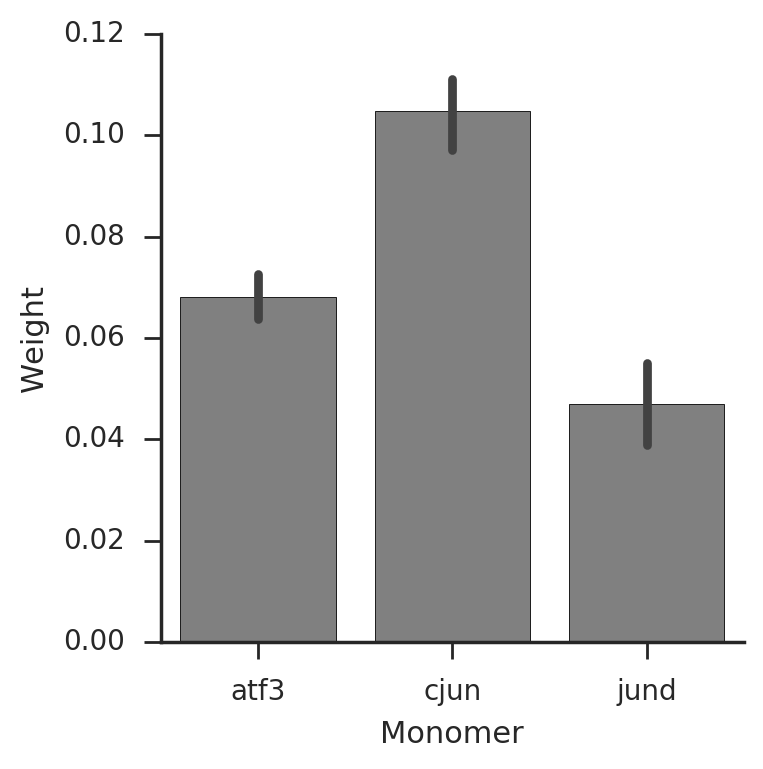

In [35]:
plotting_frame = pd.DataFrame(pd.DataFrame(factor_nr2f1_coeff_dict).stack())

plotting_frame['monomer'] = [x[1]for x in plotting_frame.index.values]
plotting_frame['Iteration'] = [x[0]for x in plotting_frame.index.values]
plotting_frame.columns = ['Weight', 'Monomer', 'Iteration']
print('atf3 vs cjun ttest:',
        scipy.stats.ttest_ind(factor_nr2f1_coeff_dict['atf3'],
                            factor_nr2f1_coeff_dict['cjun'])[1])
print('jund vs cjun ttest:',
        scipy.stats.ttest_ind(factor_nr2f1_coeff_dict['jund'],
                            factor_nr2f1_coeff_dict['cjun'])[1])
with sns.axes_style('ticks'):
    plt.figure(figsize=(1.0,1.0))
    sns.factorplot(data=plotting_frame, 
                   kind ='bar', 
                   x='Monomer', 
                   y='Weight',
                   ci=95,
                   color='grey')
    sns.despine()
#     plt.ylabel('Weight')
#     plt.savefig('./figures/figure_07_nr2f1_callout.svg', 
#             bbox_inches='tight')



# External PPARg-KO RNA-seq

In [177]:
!analyzeRepeats.pl rna mm10 -condenseGenes -count exons -noadj -d /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories_rna_external/*/ > raw_pparko.tsv

	Tag Directories:
		/gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories_rna_external/C57Bl6_BMDM_Veh_viladomiu_rep1/
		/gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories_rna_external/C57Bl6_BMDM_Veh_viladomiu_rep2/
		/gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories_rna_external/C57Bl6_BMDM_Veh_viladomiu_rep3/
		/gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories_rna_external/C57Bl6-PPARgKO_BMDM_Veh_viladomiu_rep1/
		/gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories_rna_external/C57Bl6-PPARgKO_BMDM_Veh_viladomiu_rep2/
		/gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories_rna_external/C57Bl6-PPARgKO_BMDM_Veh_viladomiu_rep3/
	Input file format: homerRmsk
	Filtering based on repeat parameters: kept 35756 of 35756
	Calculating read coverage for /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories_rna_external/C57Bl6_BMDM_Veh_viladomiu_rep1/
	Calculating read cov

In [242]:
!analyzeRepeats.pl rna mm10 -condenseGenes -count exons -rpkm -d ~/analysis/ap1_analysis/tag_directories_rna/C57*Veh*UT*CR*/ ~/analysis/ap1_analysis/tag_directories_rna/C57*Veh*UT*VML*/ /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories_rna_external/*/ > rpkm_pparko.tsv

	Tag Directories:
		/gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_Veh_UT_CR_12-03-09/
		/gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories_rna/C57Bl6_Thiomac_RNA_Veh_UT_VML_15-02-17/
		/gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories_rna_external/C57Bl6_BMDM_Veh_viladomiu_rep1/
		/gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories_rna_external/C57Bl6_BMDM_Veh_viladomiu_rep2/
		/gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories_rna_external/C57Bl6_BMDM_Veh_viladomiu_rep3/
		/gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories_rna_external/C57Bl6-PPARgKO_BMDM_Veh_viladomiu_rep1/
		/gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories_rna_external/C57Bl6-PPARgKO_BMDM_Veh_viladomiu_rep2/
		/gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories_rna_external/C57Bl6-PPARgKO_BMDM_Veh_viladomiu_rep3/
	Input file format: homer

In [179]:
!getDiffExpression.pl ./raw_pparko.tsv KO KO KO WT WT WT > diffExpression_pparko.tsv


	Differential Expression Program: edgeR
	Autodetecting input file format...
	Using edgeR to calculate differential expression/enrichment...
	Autodetected analyzeRepeats.pl file
	Output Stats KO vs. WT:
		Total Genes: 24453
		Total Up-regulated in WT vs. KO: 103 (0.421%) [log2fold>1, FDR<0.05]
		Total Dn-regulated in WT vs. KO: 106 (0.433%) [log2fold<-1, FDR<0.05]



In [245]:
# read in rpkm values
rpkm_pparko_frame = pd.read_csv('./rpkm_pparko.tsv', sep='\t')

rpkm_pparko_frame.index = [x.split('|')[0].upper() for x in rpkm_pparko_frame['Annotation/Divergence']]
rpkm_pparko_frame = rpkm_pparko_frame.ix[:,8:]
rpkm_pparko_frame.columns = ['_'.join(x.split('/')[-2].split('_')[0:2]) for x in rpkm_pparko_frame.columns.values]

# rotate frame for plotting
rpkm_plotting_frame = pd.DataFrame(rpkm_pparko_frame.stack(), 
                                   columns=['RPKM'])
rpkm_plotting_frame['Gene'] = [x[0] for x in rpkm_plotting_frame.index.values]
rpkm_plotting_frame['Genotype'] = [x[1] for x in rpkm_plotting_frame.index.values]
rpkm_plotting_frame['Log2 RPKM'] = np.log2(rpkm_plotting_frame['RPKM'].values + 1)

(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

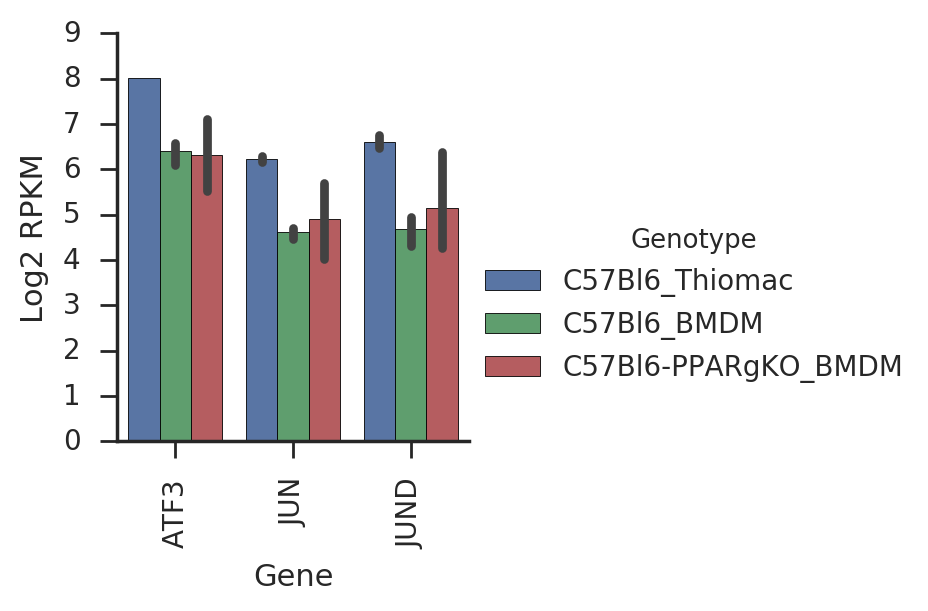

In [247]:
gene_list = ['ATF3', 'JUN' , 'JUND',

             ]

plottingFrame = rpkm_plotting_frame[rpkm_plotting_frame['Gene'].isin(gene_list)]

with sns.axes_style('ticks'):
    sns.factorplot(data = plottingFrame, x='Gene', y='Log2 RPKM', hue='Genotype', kind='bar', 
                   order = gene_list,
#                    hue_order=['Veh','KLA-1h'], 
                   ci=100,
                  size=3)

plt.xticks(rotation=90)
# plt.savefig('./figures/figure_04_ppargko_monomer_expression.svg', bbox_inches='tight')





In [182]:
diffExpression_pparko_frame = pd.read_csv('diffExpression_pparko.tsv', sep='\t')

In [195]:
down_genes = [x.split('|')[0].upper() for x in diffExpression_pparko_frame[
        (diffExpression_pparko_frame['KO vs. WT Log2 Fold Change'] <= -1) &
        (diffExpression_pparko_frame['KO vs. WT adj. p-value'] <= 0.05)]['Annotation/Divergence']]

In [196]:
up_genes = [x.split('|')[0].upper() for x in diffExpression_pparko_frame[
        (diffExpression_pparko_frame['KO vs. WT Log2 Fold Change'] >= 1) &
        (diffExpression_pparko_frame['KO vs. WT adj. p-value'] <= 0.05)]['Annotation/Divergence']]

In [250]:
rpkm_pparko_frame.columns

Index(['C57Bl6_Thiomac', 'C57Bl6_Thiomac', 'C57Bl6_BMDM', 'C57Bl6_BMDM',
       'C57Bl6_BMDM', 'C57Bl6-PPARgKO_BMDM', 'C57Bl6-PPARgKO_BMDM',
       'C57Bl6-PPARgKO_BMDM'],
      dtype='object')

In [252]:
mean_wt_vals = rpkm_pparko_frame['C57Bl6_Thiomac'].mean(axis=1)

mean_ko_vals = rpkm_pparko_frame['C57Bl6-PPARgKO_BMDM'].mean(axis=1)
mean_wt_bmdm_vals = rpkm_pparko_frame['C57Bl6_BMDM'].mean(axis=1)



In [ ]:
sns.clustermap(np.log2(pd.DataFrame({'TGEM-WT':mean_wt_vals, 'BMDM-WT':mean_wt_bmdm_vals, 'BMDM-KO':mean_ko_vals})+1),
               yticklabels = False
              )

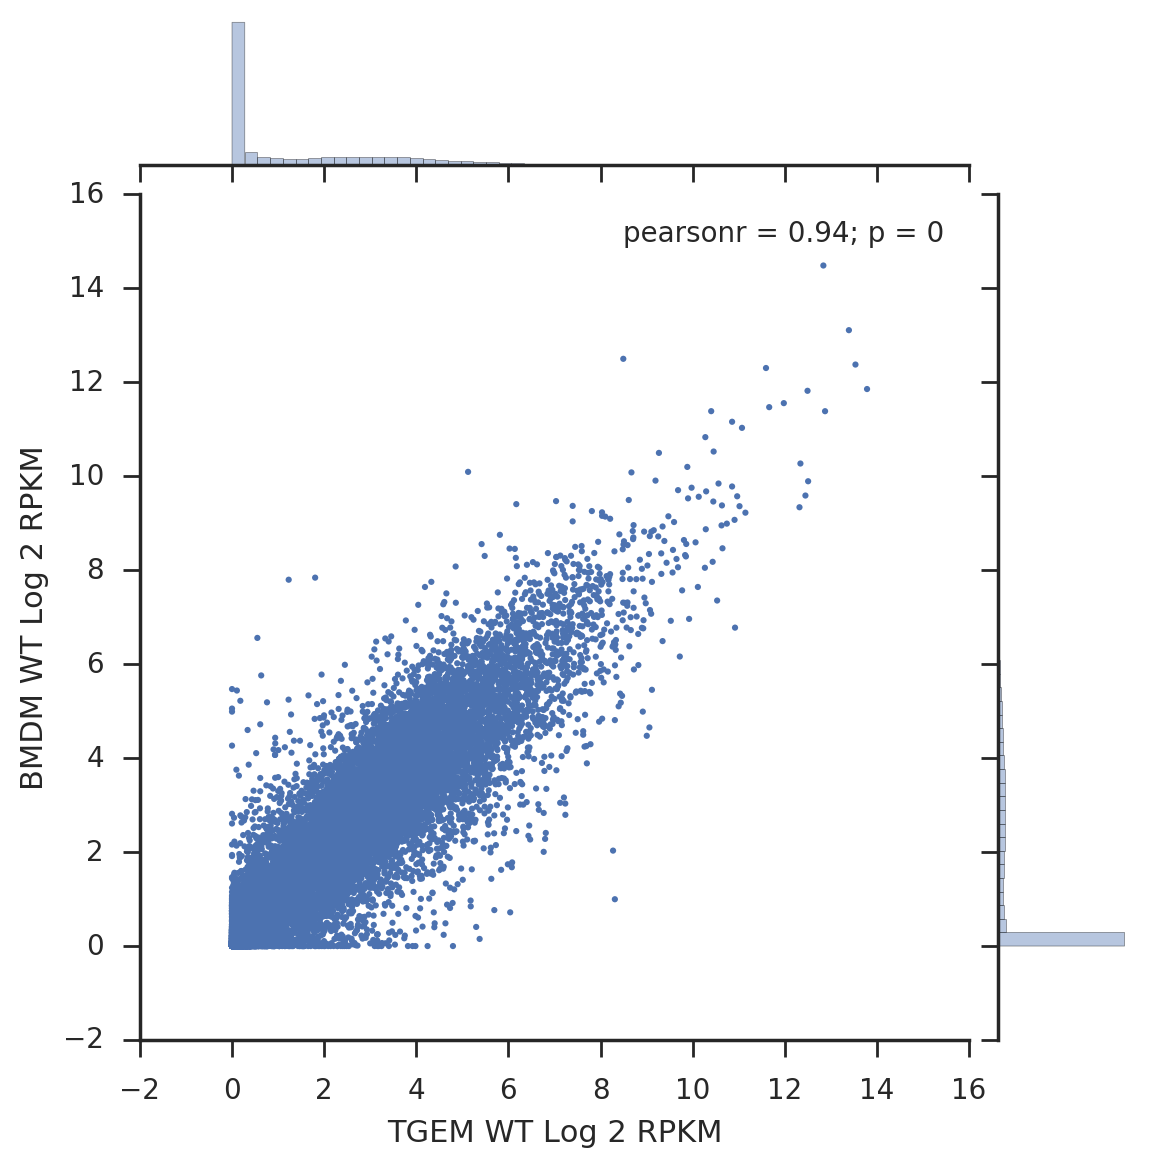

In [266]:
with sns.axes_style('ticks'):
    jg = sns.jointplot(np.log2(mean_wt_vals+1), 
                       np.log2(mean_wt_bmdm_vals + 1), 
                       marker = '.',
                       edgecolor='None'
                       )
    jg.ax_joint.set_xlabel('TGEM WT Log 2 RPKM')
    jg.ax_joint.set_ylabel('BMDM WT Log 2 RPKM')
    

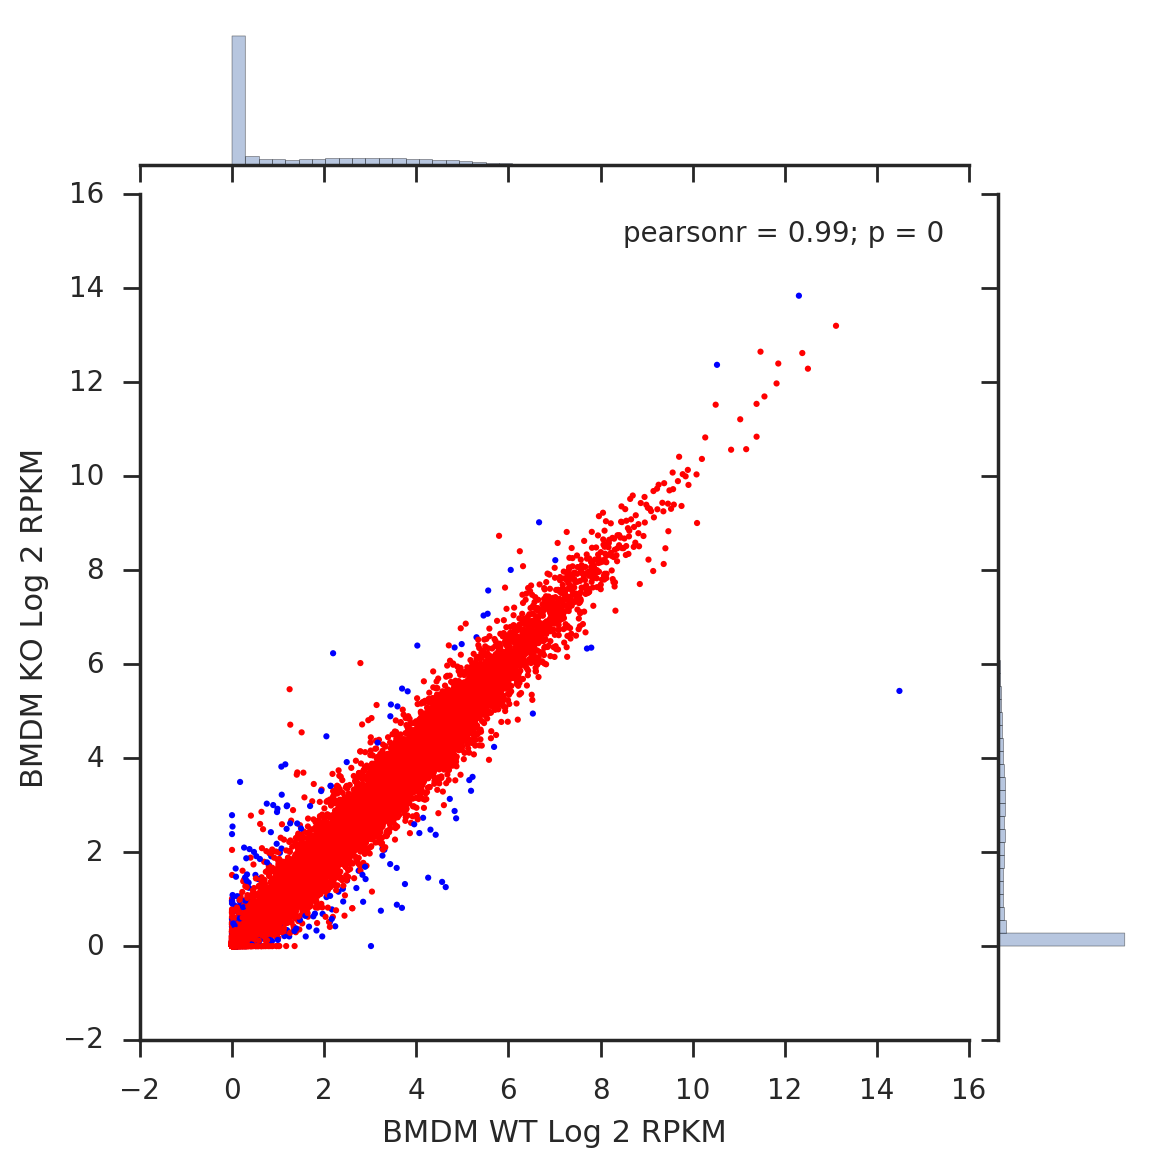

In [271]:
with sns.axes_style('ticks'):
    colors = ['blue' if (x in down_genes or x in up_genes) else 'red' for x in  mean_wt_bmdm_vals.index.values]
    jg = sns.jointplot(np.log2(mean_wt_bmdm_vals+1), 
                       np.log2(mean_ko_vals + 1), 
                       marker = '.',
                       edgecolor='None',
                       c=colors
                       )
    jg.ax_joint.set_xlabel('BMDM WT Log 2 RPKM')
    jg.ax_joint.set_ylabel('BMDM KO Log 2 RPKM')
    

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/pandas/core/frame.py:3225: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  na_position=na_position)


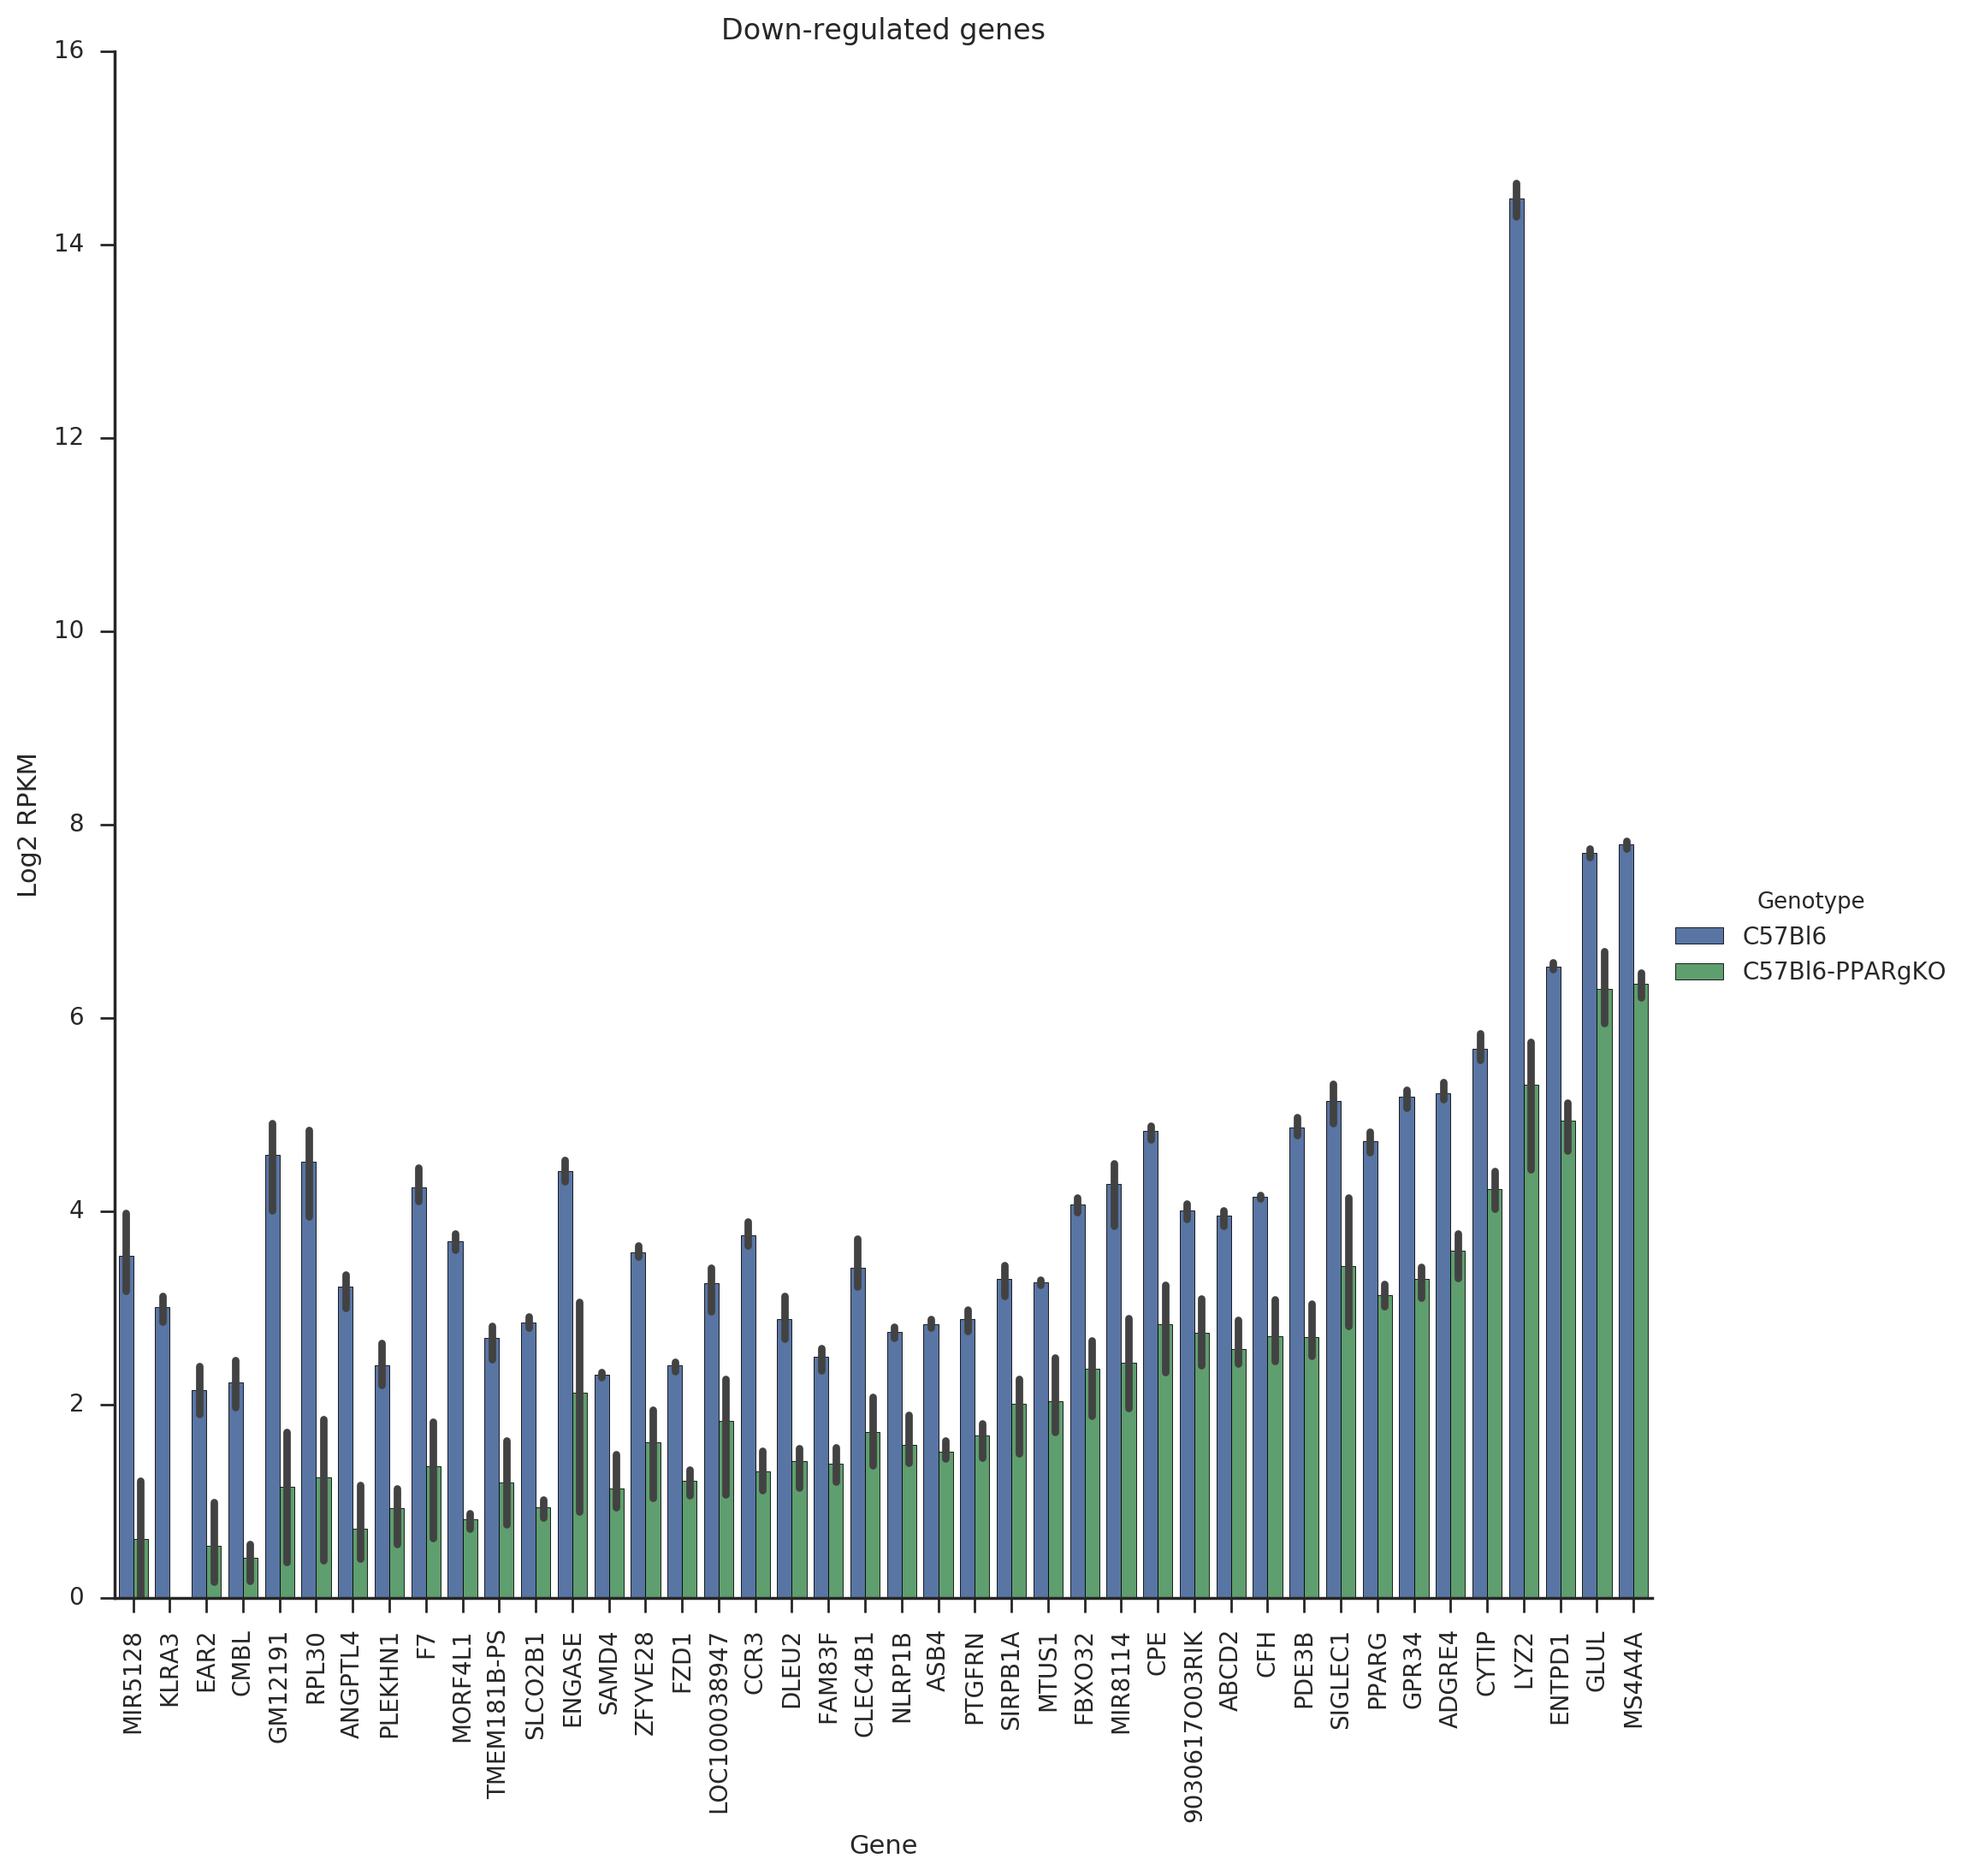

In [215]:
expressed_genes = rpkm_pparko_frame[rpkm_pparko_frame.max(axis=1) >= 4].index.values

plottingFrame = rpkm_plotting_frame[(rpkm_plotting_frame['Gene'].isin(down_genes)) &
                                    (rpkm_plotting_frame['Gene'].isin(expressed_genes))]
plottingFrame.sort('Log2 RPKM', inplace=True)
with sns.axes_style('ticks'):
    sns.factorplot(data = plottingFrame, 
                   x='Gene', 
                   y='Log2 RPKM', 
                   hue='Genotype', 
                   kind='bar', 
                   size =10,
                   hue_order = ['C57Bl6', 'C57Bl6-PPARgKO']
)

plt.xticks(rotation=90);
plt.title('Down-regulated genes')





/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()
/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/pandas/core/frame.py:3225: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  na_position=na_position)


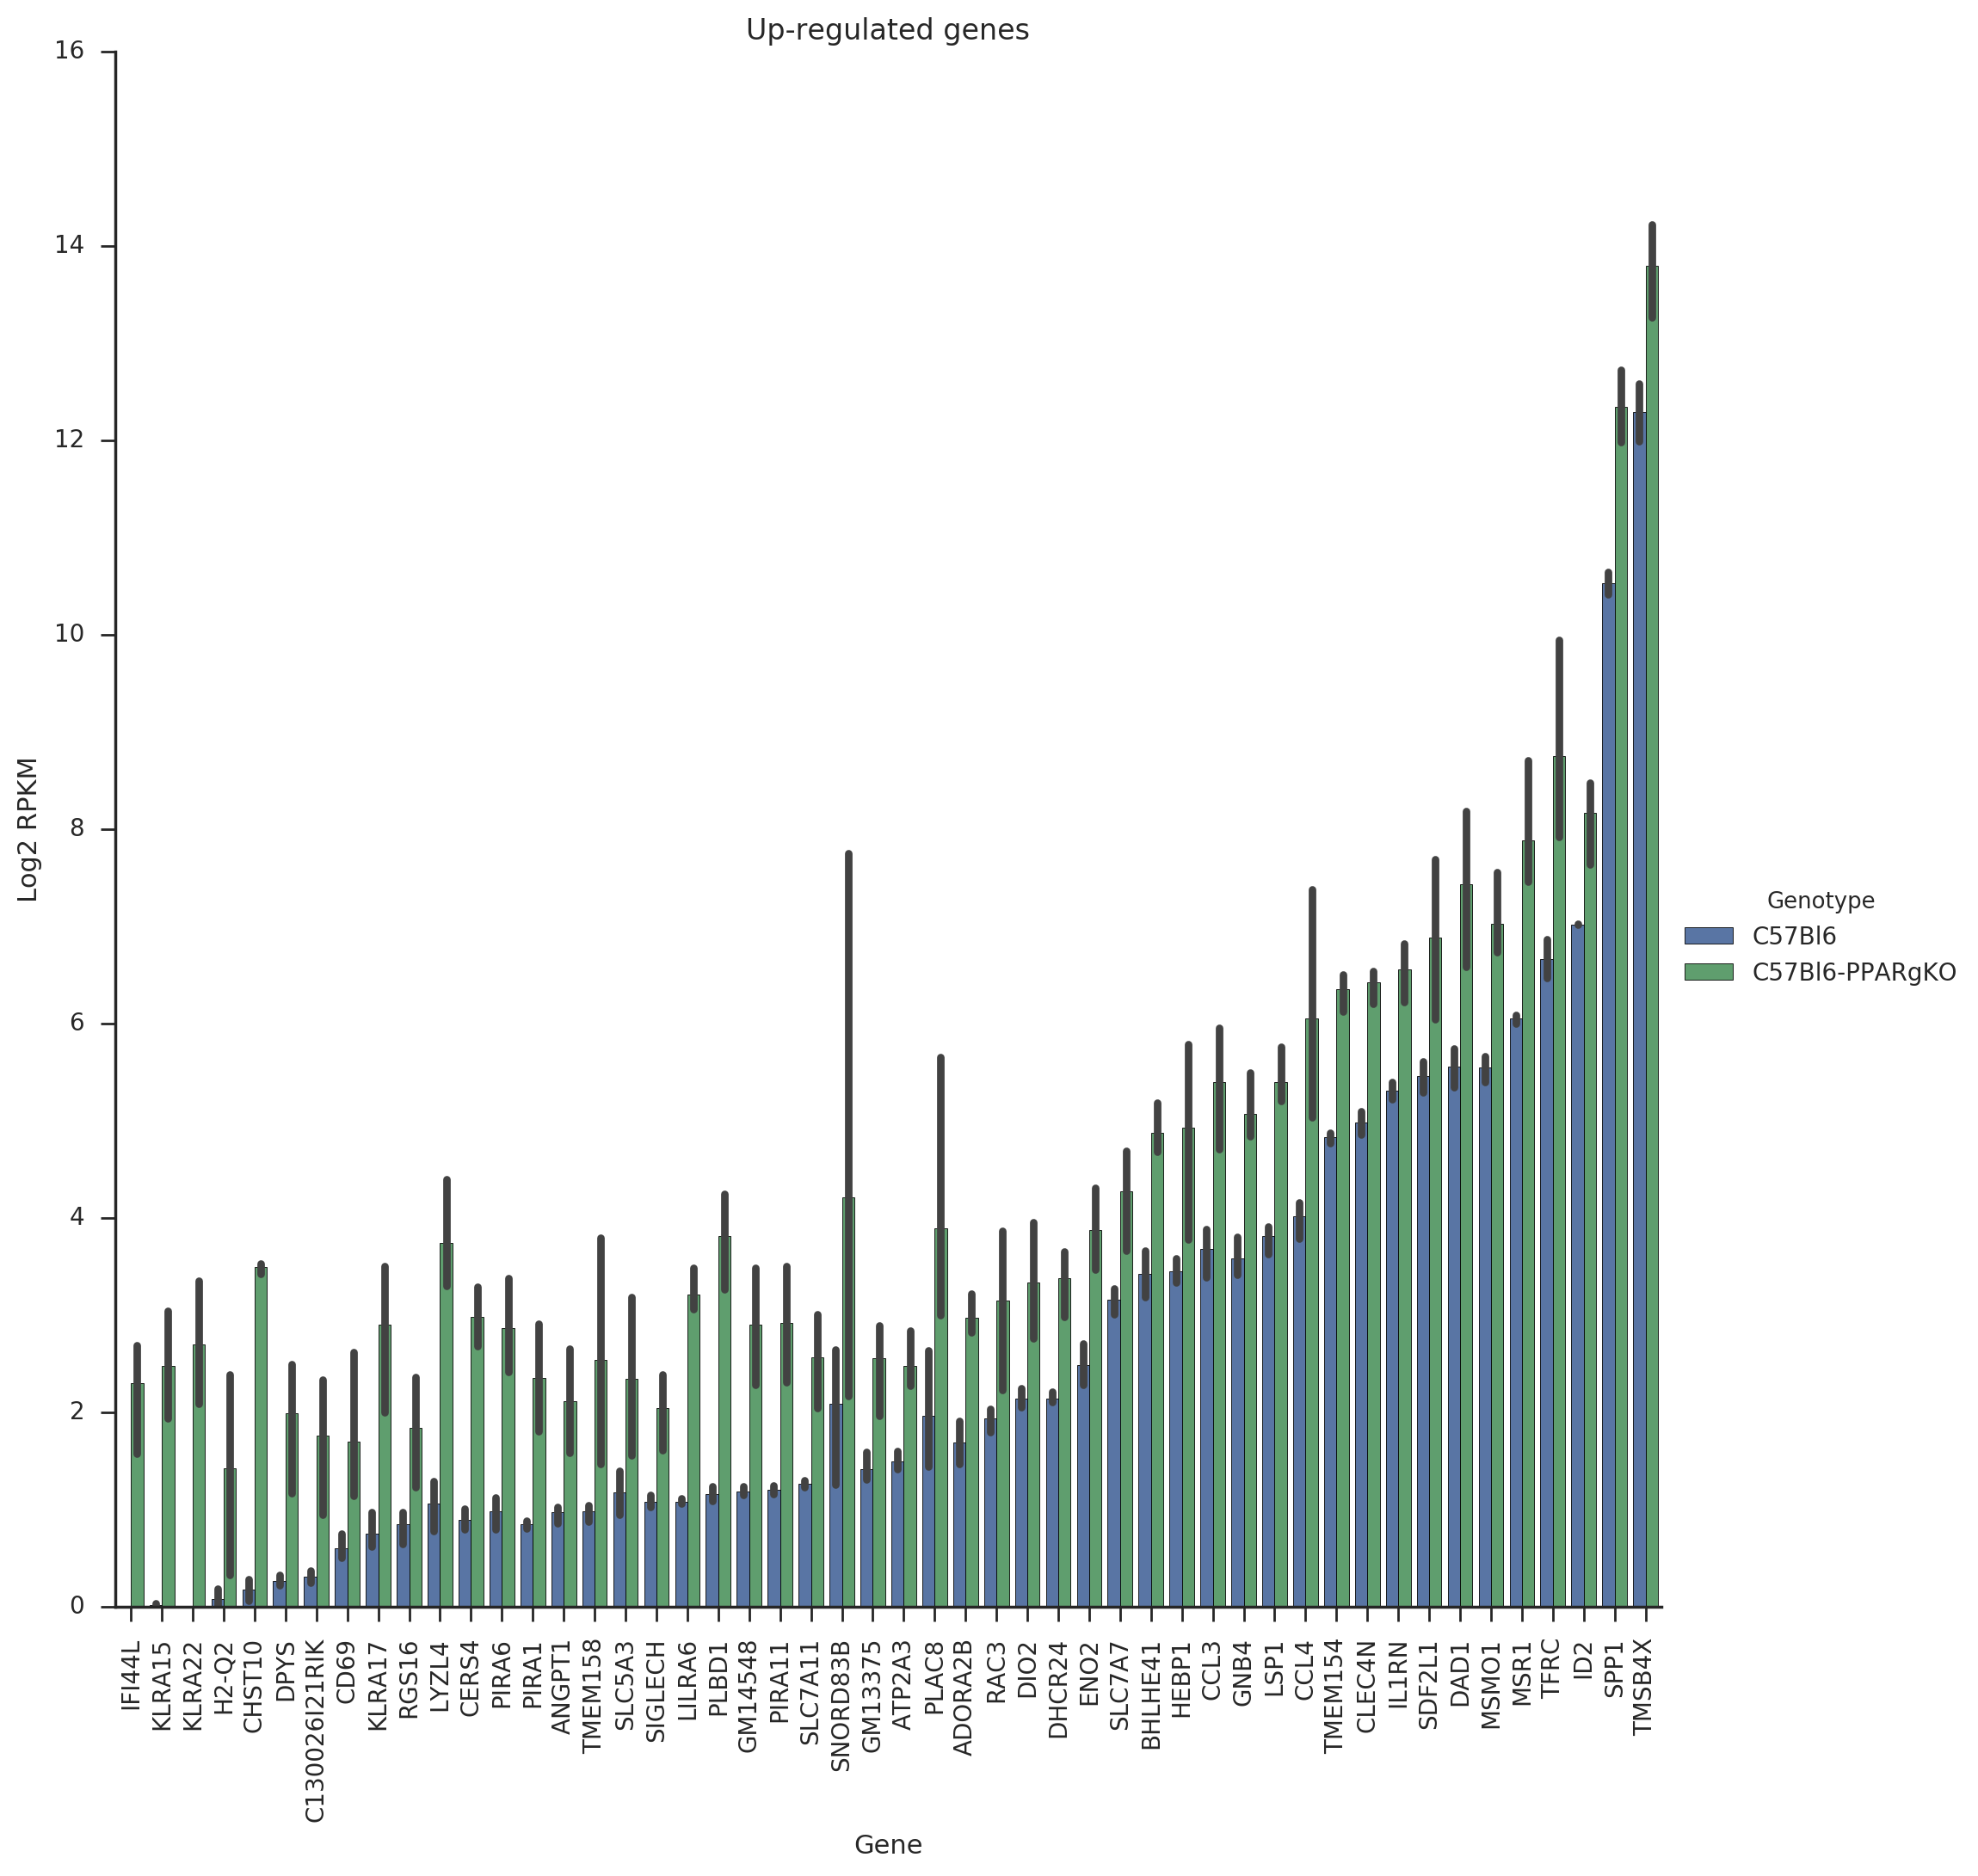

In [216]:
plottingFrame = rpkm_plotting_frame[(rpkm_plotting_frame['Gene'].isin(up_genes)) &
                                    (rpkm_plotting_frame['Gene'].isin(expressed_genes))]
plottingFrame.sort('Log2 RPKM', inplace = True)
with sns.axes_style('ticks'):
    sns.factorplot(data = plottingFrame, 
                   x='Gene', 
                   y='Log2 RPKM', 
                   hue='Genotype', 
                   kind='bar', 
                   size =10,
                   hue_order = ['C57Bl6', 'C57Bl6-PPARgKO']
                  )

plt.xticks(rotation=90);

plt.title('Up-regulated genes')







In [213]:
for g in down_genes:
    print(g)

TMEM181B-PS
JAG2
ENGASE
ENTPD1
ASB4
SHE
ABCA6
ZFYVE28
SLCO2B1
LOC100038947
PDE3B
MORC4
C1QTNF1
C920006O11RIK
CFH
FBXO32
DLEU2
SIGLEC1
GLUL
PAQR9
IL17RD
TDO2
CCR3
CYP26B1
1700028E10RIK
MIR5128
NLRP1B
MATN2
GM3704
CPE
ABCB1A
FOXQ1
F7
PLEKHN1
KLHL3
FHDC1
SAMD4
PTGFRN
ZFP541
KCNQ3
SPTA1
RIIAD1
DPPA3
PLOD2
PRLR
LRIG3
GPR68
MRAP
FGF1
GM12191
CAPN11
PECAM1
PPARG
FZD1
MIR8114
MS4A4A
MNS1
SIRPB1A
FZD6
RPL30
CLEC1A
EDIL3
KLRA9
MTUS1
D3ERTD751E
PPP1R3E
COL5A1
MORF4L1
SLIT1
FAM171A1
ACE
ANGPTL4
EAR2
SUV39H2
ABHD15
FOSB
CLEC4B1
LINCPPARA
KLRA3
CYTIP
9030617O03RIK
GM3435
FAM83F
ABCD2
VILL
F5
PFN2
GPR34
ZCCHC14
GM5122
AWAT1
PLXDC2
TEX11
CMBL
LRRC16B
CAMSAP3
LYZ2
VIPR1
CORO2B
WNT2B
SHISA9
ADGRE4
GRIK4
ARHGEF18
PDE1A
ASPA


In [214]:
for g in up_genes:
    print(g)

SVIP
TSPAN10
CHST10
SPP1
DIO2
KLRA15
GM14548
CD34
SLC1A2
KLRA4
LSP1
KCNAB1
SIGLECH
KLRA22
DNTT
LY6D
PIRA11
LYZL4
CST7
TMEM114
BHLHE41
CALML4
SDF2L1
KLRA18
ADORA2B
DPYS
ANGPT1
MSR1
CD1D2
SOX7
9430076C15RIK
ACAA1B
PXDC1
TCF7
COL10A1
LAG3
CCL4
TOX
SLC7A7
HDDC3
SYCP1
TRIM34B
CCL22
ATP6V1C2
RIMS2
RAC3
ATP2A3
GM13375
ENO2
LILRA6
THY1
PYDC3
ZFP462
RGS16
MORN4
APOLD1
HAVCR1
BCL11B
TFRC
CLEC4N
CD69
PLAC8
8430408G22RIK
TMEM154
TMEM158
SLC7A11
SNORD83B
CXCL9
ME1
HEBP1
ID2
CCL3
FRMD7
TMEM178
DAD1
NCALD
KLRA1
CLEC2G
H2-Q2
H2-BL
SLC5A3
C130026I21RIK
PLBD1
IFI44L
TMSB4X
KLK1B22
IL1RN
GNB4
SLC6A12
RUNX3
PIRA1
HCAR2
CERS4
CMTM8
DHCR24
PIRA6
MSMO1
2410017I17RIK
SLCO4A1
SLCO3A1
KLRA17
PLA2G2D
KLRA12
